### Library Import

In [60]:
import os
import pandas as pd
import numpy as np
import pickle

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
mpl.rcParams['figure.figsize'] = (15, 12)
plt.rcParams.update({'font.size': 12})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['text.color'] = 'white'#'#aaaaaa'
plt.rcParams.update({'text.color': "white",
                     'axes.labelcolor': "white"})

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard

import altair as alt
import seaborn as sns

import importlib

import datetime

import warnings
warnings.filterwarnings('ignore')


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [61]:
# load in test_train_split custom function
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, train_test_model, run, cnn_model
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2, plot_roc, plot_metrics, plot_images, visualize

# Loading in Images

#### From pickeled files
For loading the images for the model simply run the the below code

In [3]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_unrealEvenish_pkl.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl_uneven_w_drone.pkl'), 'rb') as pickle_file: #test_images_pkl_even_ratio.pkl
    test_data = pickle.load(pickle_file)


Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [64]:
from datetime import date

today = date.today()
now = today.strftime("%b-%d-%Y")

In [4]:
#splitting in to test train split for the training data
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)
# print(np.array(train_images).shape)
# print(np.array(train_labels).shape)

# ###############################
# #Manual data augmentation flow#
# ###############################

# #FLIPPING
# augmented_train_images = []
# augmented_train_labels = []
# for i in range(len(train_images)):
#     augmented_train_images.append(tf.image.flip_left_right(train_images[i]))
#     augmented_train_labels.append(train_labels[i])
#     # flipped = tf.image.flip_left_right(image, 0.4)
#     # visualize(image, flipped)

# train_images = tuple(list(train_images) + augmented_train_images)
# train_labels = train_labels + tuple(augmented_train_labels)

# #SATURATION
# # saturated_train_images = []
# # saturated_train_labels = []
# # for i in range(len(train_images)):
# #     saturated_train_images.append(tf.image.adjust_saturation(train_images[i], 2))
# #     saturated_train_labels.append(train_labels[i])


# # train_images = tuple(list(train_images) + saturated_train_images)
# # train_labels = train_labels + tuple(saturated_train_labels)

# # #BRIGHTNESS
# # bright_train_images = []
# # bright_train_labels = []
# # for i in range(len(train_images)):
# #     bright_train_images.append(tf.image.adjust_brightness(train_images[i], 0.4))
# #     bright_train_labels.append(train_labels[i])

# # train_images = tuple(list(train_images) + bright_train_images)
# # train_labels = train_labels + tuple(bright_train_labels)

# # #CONTRAST
# # contrast_train_images = []
# # contrast_train_labels = []
# # for i in range(len(train_images)):
# #     contrast_train_images.append(tf.image.adjust_contrast(train_images[i], 0.4))
# #     contrast_train_labels.append(train_labels[i])

# # train_images = tuple(list(train_images) + contrast_train_images)
# # train_labels = train_labels + tuple(contrast_train_labels)



#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0

# print(train_images.shape)
# print(train_labels.shape)

train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

input_shape = train_images.shape[1:]
print(input_shape)
print(train_images.shape)
print(train_labels.shape)


(100, 195, 3)
(1030, 100, 195, 3)
(1030, 1)


In [5]:
hold_out_images, hold_out_labels = zip(*test_data)

images_final_test = []
for img in hold_out_images:
    img = Image.fromarray(img)
    img = img.resize((input_shape[1], input_shape[0])) #change to shape of train images
    images_final_test.append(np.array(img))

hold_out_images = images_final_test

#normalize the images
hold_out_images = np.array(hold_out_images) / 255.0


augmented_hold_out_images = []
augmented_hold_out_labels = []
for i in range(len(hold_out_images)):
    augmented_hold_out_images.append(tf.image.flip_left_right(hold_out_images[i]))
    augmented_hold_out_labels.append(hold_out_labels[i])

hold_out_images = tuple(list(hold_out_images) + augmented_hold_out_images)
hold_out_labels = hold_out_labels + tuple(augmented_hold_out_labels)

hold_out_images = tf.convert_to_tensor(hold_out_images , dtype=tf.float32)
hold_out_images.shape[1:]

# plot_images(hold_out_images, hold_out_labels)

TensorShape([100, 195, 3])

In [6]:
#view the split of the data
df = pd.DataFrame([label[0] for label in train_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['train_data_label', 'count_of_label']
df

train_data_label  count_of_label
0               0.0             554
1               1.0             476

In [7]:
#view the split of the data
df = pd.DataFrame([label[0] for label in hold_out_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['hold_out_label', 'count_of_label']
df

hold_out_label  count_of_label
0               0            1918
1               1              20

# Hyperparameter Tuning

In [9]:
%reload_ext tensorboard
#! rm -rf ./logs/

# Pulling models from folder

In [13]:
modelLst = []
modelNames = []
modelDict = {}
for model in os.listdir("artifacts/modelFolder"):
    f = os.path.join("artifacts/modelFolder", model)
    modelNames.append(model)
    modelLst.append(tf.keras.models.load_model(f))

modelLst = modelLst[4:6]+modelLst[28:]
modelNames = modelNames[4:6]+modelNames[28:]

modelDict = dict(zip(modelLst[4:6]+modelLst[28:],modelNames[4:6]+modelNames[28:]))

# for excel in os.listdir("artifacts/excelFolder"):
#     f = os.path.join("artifacts/excelFolder", excel)
#     modelDfs.append(pd.read_excel(f))  

In [ ]:
# modelFromTheArchives = tf.keras.models.load_model(os.path.join("artifacts","model_20201209_107.h5"))

# restoring modelDf

In [10]:
modelDfs = []

losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
histories = []
best_thresholds = []
units = []
dropouts = []
optimizers = []
epoch = []
# for model in best_mods: #toggle to change lists
# for model in modelLst:
for model, name in modelDict.items():

    train_predictions_baseline = model.predict(train_images)

    fp, tp, _ = sklearn.metrics.roc_curve(train_labels,train_predictions_baseline)
    from numpy import argmax
    J = tp- fp
    ix = argmax(J)
    best_thresh = _[ix]
    best_thresh = 1-best_thresh
    print('best thresh')
    print('-----------')
    print(best_thresh)
    print('-----------')
    best_thresholds.append(best_thresh)

    loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc= model.evaluate(test_images, test_labels)
    
    losses.append(loss)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    aucs.append(auc)
    histories.append(model.history)

    splitStr = name.split("_")
    units.append(splitStr[2])
    dropouts.append(splitStr[3])
    epoch.append(splitStr[4])
    optimizers.append(splitStr[5].replace(".h5",""))

modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, aucs, precisions, recalls, histories, epoch, best_thresholds)),# f1_scores,
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'aucs', 'precisions', 'recalls', 'histories','epochs', 'best thresholds'])#'aucs',

modelDfs.append(modelDf)
    

best thresh
-----------
0.5000686943531036
-----------
5/5 [==============================] - 2s 128ms/step - loss: 0.6871 - tp: 50.0000 - fp: 3.0000 - tn: 62.0000 - fn: 14.0000 - accuracy: 0.8682 - precision: 0.9434 - recall: 0.7812 - auc: 0.8419 - prc: 0.8869
best thresh
-----------
0.19909685850143433
-----------
5/5 [==============================] - 2s 100ms/step - loss: 0.9207 - tp: 64.0000 - fp: 65.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.4961 - precision: 0.4961 - recall: 1.0000 - auc: 0.5712 - prc: 0.5782
best thresh
-----------
0.8980262279510498
-----------
5/5 [==============================] - 1s 106ms/step - loss: 1.1792 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 65.0000 - fn: 64.0000 - accuracy: 0.5039 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6615 - prc: 0.6891
best thresh
-----------
0.211309015750885
-----------
5/5 [==============================] - 1s 91ms/step - loss: 0.8878 - tp: 64.0000 - fp: 65.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accura

# Running new models

In [9]:
modelLst = []
modelDfs = []

In [94]:
session_num = 0
epochLst = [2,3,4,5,6,7,8,9]
epochLst = [7]
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64]))#16, 16,32,
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.8,0.9))
dropout_rate = 0.7
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))#,'adam', 'Nadam'])) #'sgd','Adagrad','RMSprop',,'Nadam','Nadam'

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []
predictions = []
epoch = []
modelz = []

for epochs in epochLst:
  for num_units in HP_NUM_UNITS.domain.values:
    # for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        units.append(num_units)
        dropouts.append(dropout_rate)
        optimizers.append(optimizer)
        model = run('logs/hparam_tuning/' + run_name, hparams, epochs, input_shape,train_images,train_labels,test_images, test_labels,
                HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, predictions,
                params, losses, accuracies, f1_scores, precisions, recalls, cms, aucs,
                units, dropouts, optimizers, histories, augmentModel=True)
        model.save(f"artifacts/modelFolder/model_{now}_{num_units}_{dropout_rate}_{epochs}_{optimizer}.h5")
        modelz.append(model)
        epoch.append(epochs)
        session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.7, 'optimizer': 'adam'}
Epoch 1/7
33/33 [==============================] - 104s 611ms/step - loss: 0.6252 - tp: 285.0000 - fp: 144.0000 - tn: 410.0000 - fn: 191.0000 - accuracy: 0.6748 - precision: 0.6643 - recall: 0.5987 - auc: 0.7230 - prc: 0.6955
Epoch 2/7
33/33 [==============================] - 20s 616ms/step - loss: 0.2804 - tp: 408.0000 - fp: 43.0000 - tn: 511.0000 - fn: 68.0000 - accuracy: 0.8922 - precision: 0.9047 - recall: 0.8571 - auc: 0.9552 - prc: 0.9586
Epoch 3/7
33/33 [==============================] - 21s 626ms/step - loss: 0.1500 - tp: 452.0000 - fp: 17.0000 - tn: 537.0000 - fn: 24.0000 - accuracy: 0.9602 - precision: 0.9638 - recall: 0.9496 - auc: 0.9835 - prc: 0.9876
Epoch 4/7
33/33 [==============================] - 20s 612ms/step - loss: 0.0922 - tp: 461.0000 - fp: 8.0000 - tn: 546.0000 - fn: 15.0000 - accuracy: 0.9777 - precision: 0.9829 - recall: 0.9685 - auc: 0.9918 - prc: 0.9935
Epoch 5/7
33/33 [========

In [97]:
modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, aucs, precisions, recalls, cms, histories,epoch)),# f1_scores,
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'aucs', 'precisions', 'recalls', 'cms','histories','epochs'])#'aucs',
        
#pd.ExcelWriter

# modelDfs.append(modelDf)
modelDfs = pd.concat([modelDfs,modelDf])
# modelLst.append(modelz) #if new models were generated
modelLst.extend(modelz) #if models were saved

In [14]:
#might have to concat depending on combo of new and saved

print(len(modelLst))
# modelDfs #= pd.concat([modelDfs[0],modelDfs[1]])
# modelDfs = modelDfs.reset_index()
# modelDfs = modelDfs.drop(columns='index')
modelDfs[0]

382


units dropouts optimizers    losses  accuracies      aucs  precisions  \
0      16      0.2      Nadam  0.687126    0.868217  0.841947    0.943396   
1      16      0.2    RMSprop  0.920688    0.496124  0.571154    0.496124   
2      16      0.3       adam  1.179154    0.503876  0.661538    0.000000   
3      16      0.3      Nadam  0.887771    0.496124  0.875601    0.496124   
4      16      0.3    RMSprop  0.758469    0.503876  0.790024    0.000000   
..    ...      ...        ...       ...         ...       ...         ...   
377    64      0.9      Nadam  0.687617    0.496124  0.811899    0.496124   
378    64      0.9    RMSprop  1.166344    0.503876  0.875000    0.000000   
379    64      0.9       adam  0.722936    0.503876  0.753846    0.000000   
380    64      0.9      Nadam  0.705941    0.503876  0.832332    0.000000   
381    64      0.9    RMSprop  2.211020    0.503876  0.807692    0.000000   

     recalls                                          histories epochs  \
0    0.78125  <keras.callbacks.History object at 0x000002B03...      3   
1    1.00000  <keras.callbacks.History object at 0x000002B03...      3   
2    0.00000  <keras.callbacks.History object at 0x000002B02...      5   
3    1.00000  <keras.callbacks.History object at 0x000002B01...      5   
4    0.00000  <keras.callbacks.History object at 0x000002B1A...      5   
..       ...                                                ...    ...   
377  1.00000  <keras.callbacks.History object at 0x000002B3E...      8   
378  0.00000  <keras.callbacks.History object at 0x000002B3E...      8   
379  0.00000  <keras.callbacks.History object at 0x000002B3E...      9   
380  0.00000  <keras.callbacks.History object at 0x000002B3E...      9   
381  0.00000  <keras.callbacks.History object at 0x000002B3E...      9   

     best thresholds  
0           0.500069  
1           0.199097  
2           0.898026  
3           0.211309  
4           0.684184  
..               ...  
377         0.470523  
378         0.895231  
379         0.645893  
380         0.634413  
381         0.988816  

[382 rows x 11 columns]

# Iterate through one model or small set of models

In [113]:
focusModel = [modelFromTheArchives] # [modelLst[407]]
modelDfs[(modelDfs['optimizers']=='adam')&(modelDfs['dropouts']==0.7)]

accuracies  aucs  best thresholds                 cms dropouts epochs  \
407         1.0   1.0              NaN  [[65, 0], [0, 64]]      0.7      7   

                                             histories   losses optimizers  \
407  <keras.callbacks.History object at 0x0000026C8...  0.01287       adam   

     precisions  recalls units  
407         1.0      1.0    64

In [65]:
counter = 0
TNrates = []
FPrates = []
FNrates = []
TPrates = []
Units = []
Dropouts = []
Optimizers = []
Epochs = []
positions = []
BestThresh = []
# for model in best_mods: #toggle to change lists
for model in focusModel:
    for thresHold in [0.4, 0.5, 0.6, 0.72, 0.85]:

        modelDetails = pd.DataFrame(modelDfs.iloc[407]).T #need to adjust positioning based on model input
        display(modelDetails)
        if pd.isnull(modelDetails['best thresholds'].values[0]):
            
            train_predictions_baseline = model.predict(train_images)

            fp, tp, _ = sklearn.metrics.roc_curve(train_labels,train_predictions_baseline)
            from numpy import argmax
            J = tp- fp
            ix = argmax(J)
            best_thresh = _[ix]
            best_thresh = 1-best_thresh
            print('best thresh')
            print('-----------')
            print(best_thresh)
            print('-----------')
            BestThresh.append(best_thresh)
        
        else:
            thresh = modelDetails['best thresholds'].values[0]
            BestThresh.append(thresh)

        predictions = model.predict(hold_out_images, verbose = 1)

        scores = []
        for prediction in predictions:
            if prediction >= thresHold:
                scores.append(1)
            else:
                scores.append(0)
        
        print(thresHold)
            
        # predictions = [prediction[0] for prediction in predictions]
        predictions1 = [prediction[0] for prediction in predictions][:10]
        predictions2 = [prediction[0] for prediction in predictions][969:979]
        
        # print(list(zip(hold_out_labels,predictions)))
        print(list(zip(hold_out_labels[:10],predictions1)))
        print(list(zip(hold_out_labels[969:979],predictions2)))

        TNrate, FPrate, FNrate, TPrate = plot_confusion_matrix_2(confusion_matrix(y_true=hold_out_labels, y_pred=scores),normalize=True)
    counter+=1

# Iterate through all models and various thresholds

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
30    16      0.6      Nadam  0.815819   0.503876  0.47476          0       0   

                                            histories epochs best thresholds  
30  <keras.callbacks.History object at 0x000002B0A...      7        0.736292

61/61 [==============================] - 7s 96ms/step
0.1
[([1], 0.7447747), ([1], 0.6512589), ([1], 0.057012618), ([1], 0.02060929), ([1], 0.6297762), ([1], 0.24996313), ([1], 0.61920756), ([1], 0.020925403), ([1], 0.076045245), ([1], 0.6158506)]
[([1], 0.66787535), ([1], 0.13662994), ([1], 0.15745807), ([1], 0.24103403), ([1], 0.53784394), ([1], 0.23720008), ([1], 0.6418834), ([1], 0.02550459), ([1], 0.12832719), ([1], 0.61957663)]


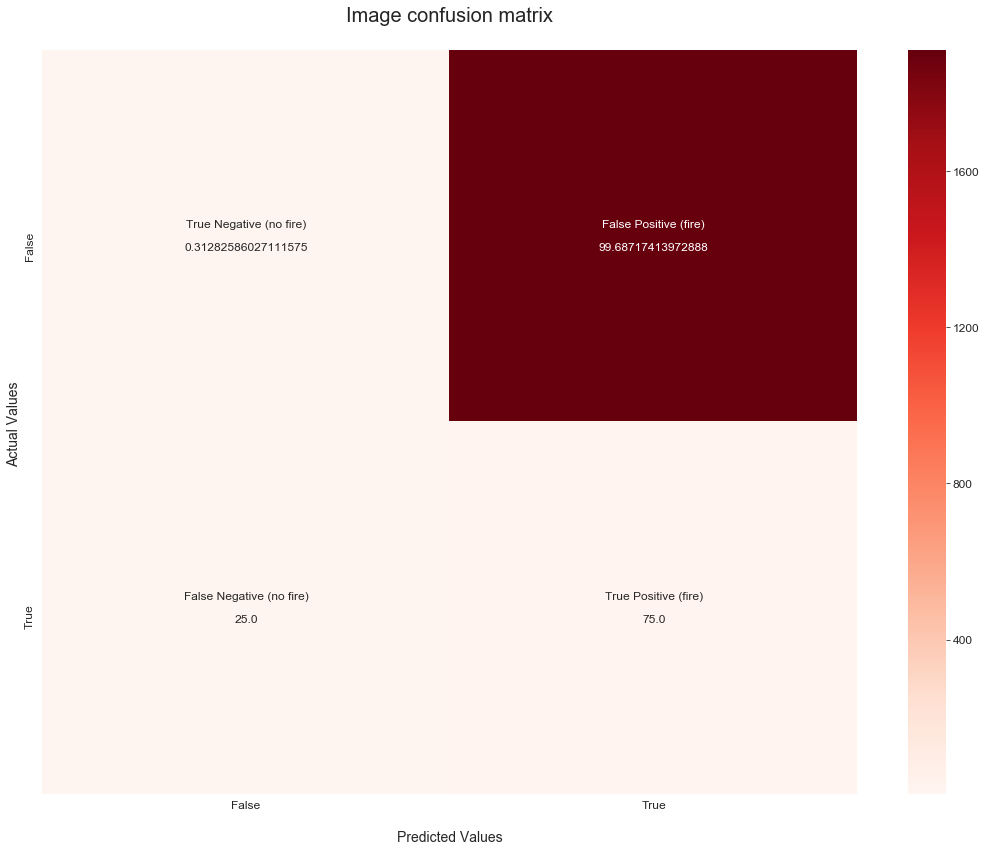

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
30    16      0.6      Nadam  0.815819   0.503876  0.47476          0       0   

                                            histories epochs best thresholds  
30  <keras.callbacks.History object at 0x000002B0A...      7        0.736292

61/61 [==============================] - 6s 90ms/step
0.3
[([1], 0.7447747), ([1], 0.6512589), ([1], 0.057012618), ([1], 0.02060929), ([1], 0.6297762), ([1], 0.24996313), ([1], 0.61920756), ([1], 0.020925403), ([1], 0.076045245), ([1], 0.6158506)]
[([1], 0.66787535), ([1], 0.13662994), ([1], 0.15745807), ([1], 0.24103403), ([1], 0.53784394), ([1], 0.23720008), ([1], 0.6418834), ([1], 0.02550459), ([1], 0.12832719), ([1], 0.61957663)]


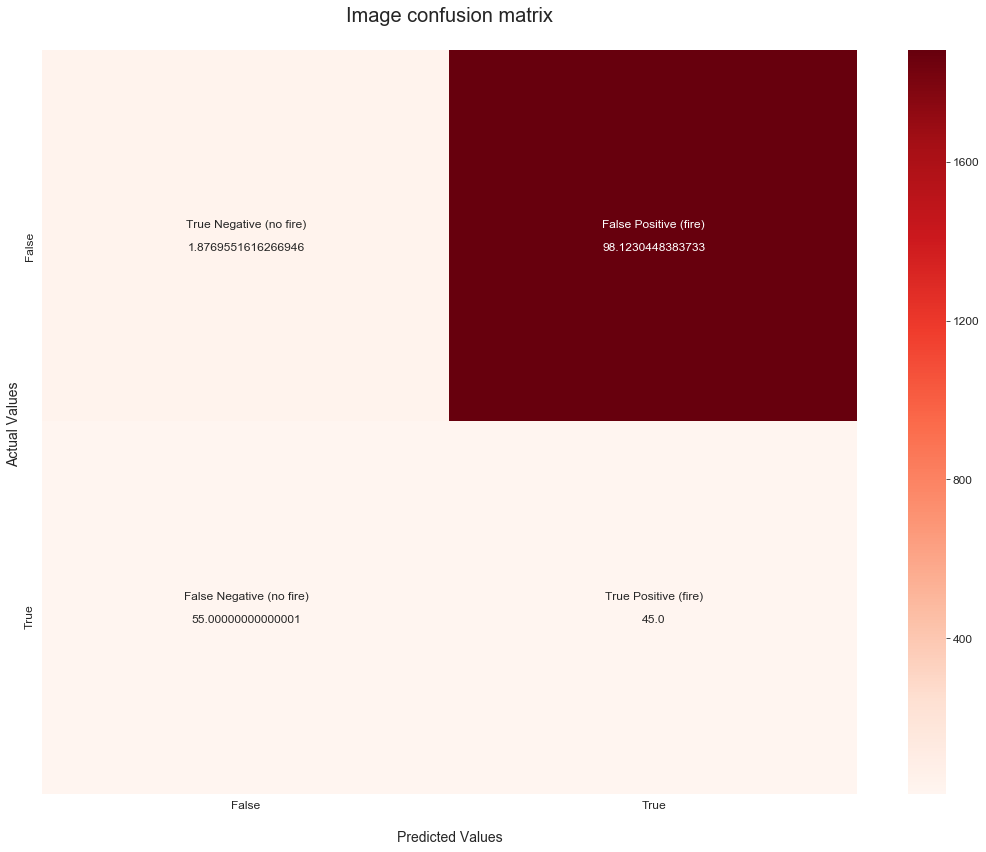

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
30    16      0.6      Nadam  0.815819   0.503876  0.47476          0       0   

                                            histories epochs best thresholds  
30  <keras.callbacks.History object at 0x000002B0A...      7        0.736292

61/61 [==============================] - 6s 93ms/step
0.5
[([1], 0.7447747), ([1], 0.6512589), ([1], 0.057012618), ([1], 0.02060929), ([1], 0.6297762), ([1], 0.24996313), ([1], 0.61920756), ([1], 0.020925403), ([1], 0.076045245), ([1], 0.6158506)]
[([1], 0.66787535), ([1], 0.13662994), ([1], 0.15745807), ([1], 0.24103403), ([1], 0.53784394), ([1], 0.23720008), ([1], 0.6418834), ([1], 0.02550459), ([1], 0.12832719), ([1], 0.61957663)]


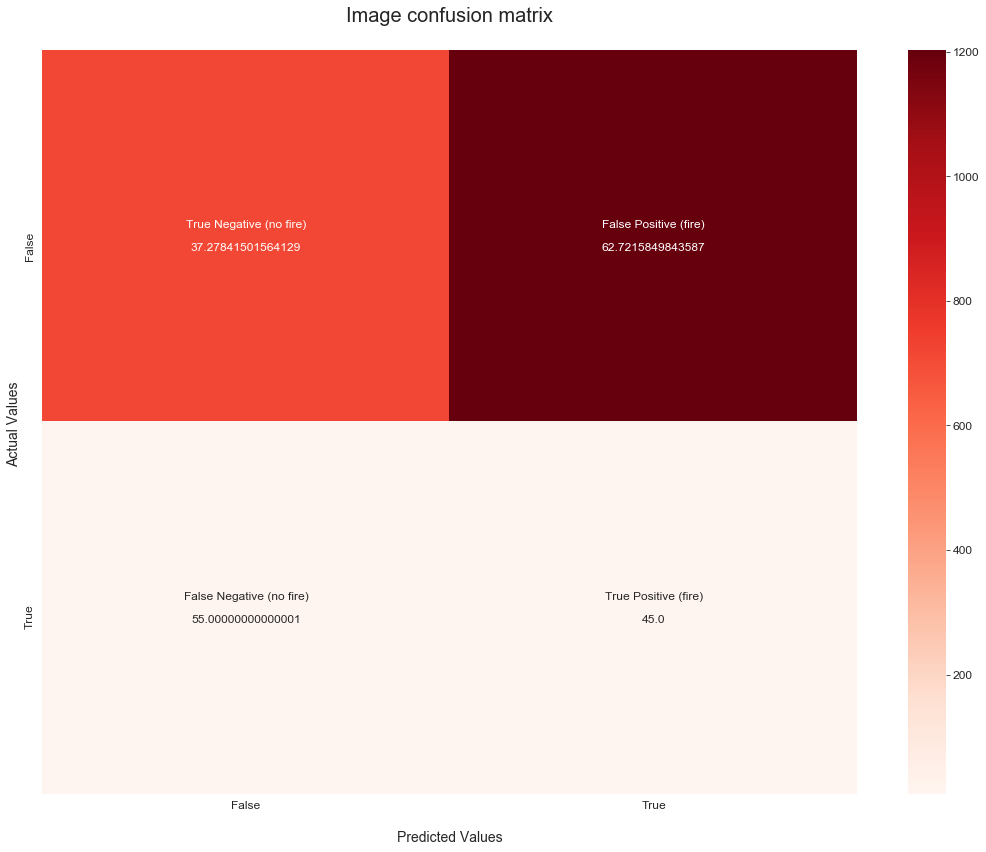

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
30    16      0.6      Nadam  0.815819   0.503876  0.47476          0       0   

                                            histories epochs best thresholds  
30  <keras.callbacks.History object at 0x000002B0A...      7        0.736292

61/61 [==============================] - 6s 94ms/step
0.65
[([1], 0.7447747), ([1], 0.6512589), ([1], 0.057012618), ([1], 0.02060929), ([1], 0.6297762), ([1], 0.24996313), ([1], 0.61920756), ([1], 0.020925403), ([1], 0.076045245), ([1], 0.6158506)]
[([1], 0.66787535), ([1], 0.13662994), ([1], 0.15745807), ([1], 0.24103403), ([1], 0.53784394), ([1], 0.23720008), ([1], 0.6418834), ([1], 0.02550459), ([1], 0.12832719), ([1], 0.61957663)]


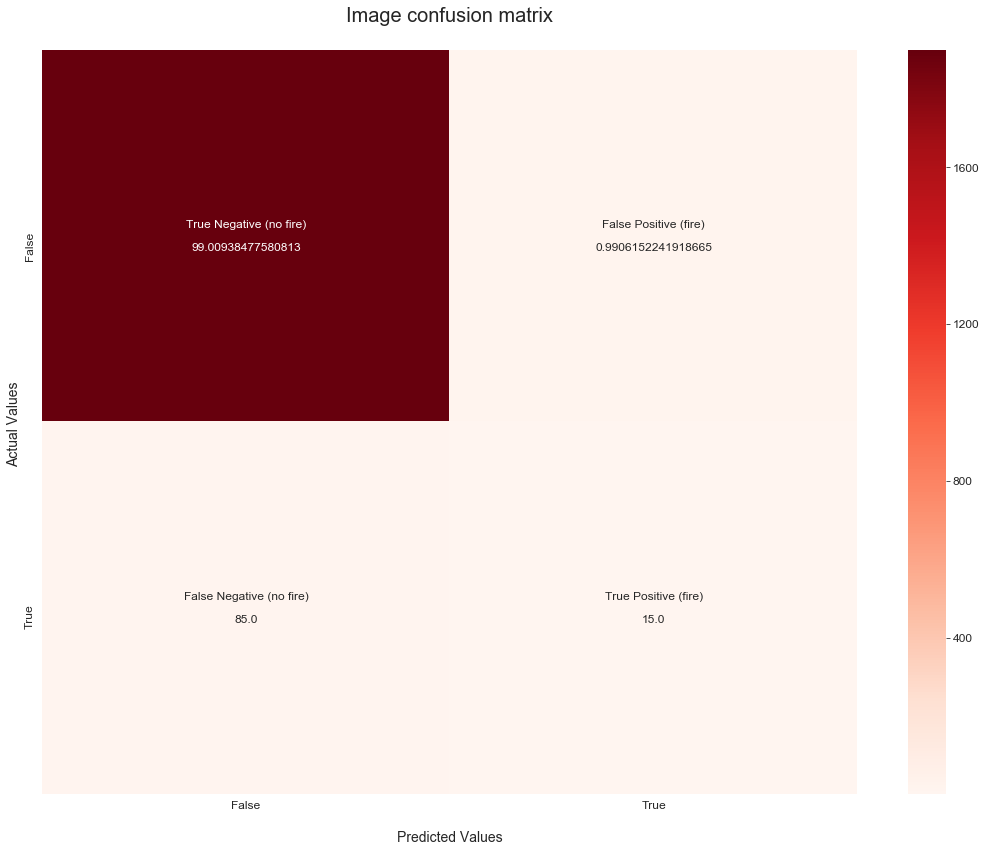

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
30    16      0.6      Nadam  0.815819   0.503876  0.47476          0       0   

                                            histories epochs best thresholds  
30  <keras.callbacks.History object at 0x000002B0A...      7        0.736292

61/61 [==============================] - 6s 94ms/step
0.725
[([1], 0.7447747), ([1], 0.6512589), ([1], 0.057012618), ([1], 0.02060929), ([1], 0.6297762), ([1], 0.24996313), ([1], 0.61920756), ([1], 0.020925403), ([1], 0.076045245), ([1], 0.6158506)]
[([1], 0.66787535), ([1], 0.13662994), ([1], 0.15745807), ([1], 0.24103403), ([1], 0.53784394), ([1], 0.23720008), ([1], 0.6418834), ([1], 0.02550459), ([1], 0.12832719), ([1], 0.61957663)]


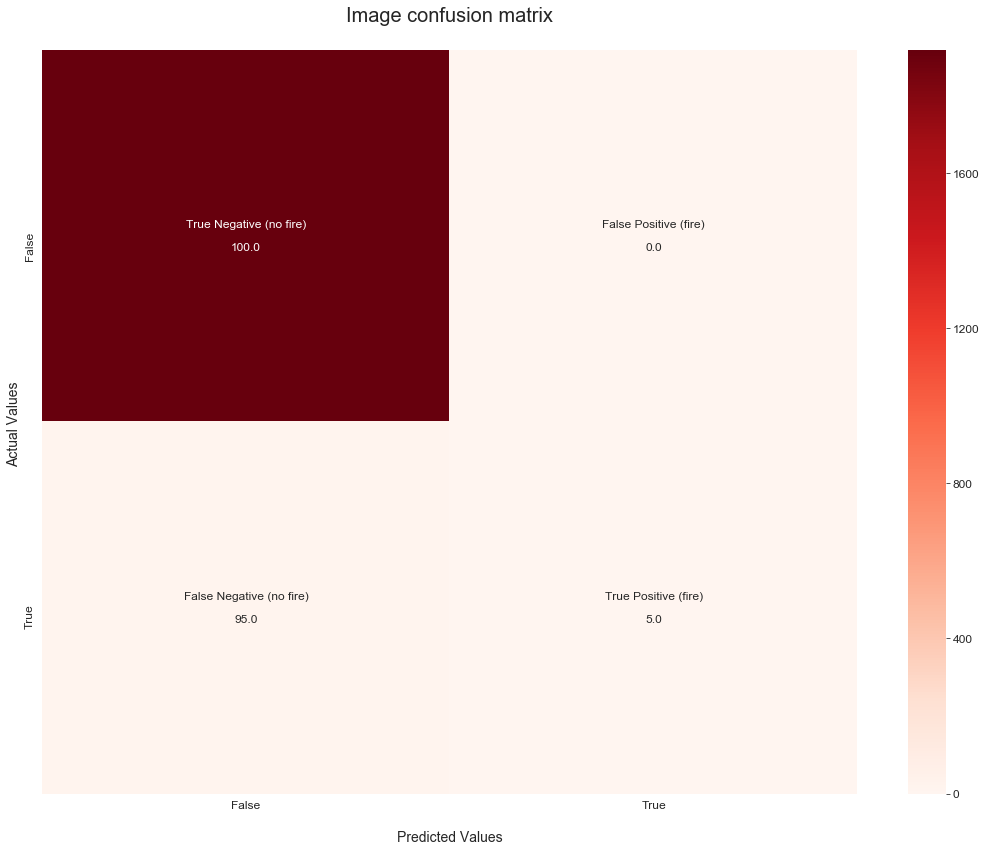

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
30    16      0.6      Nadam  0.815819   0.503876  0.47476          0       0   

                                            histories epochs best thresholds  
30  <keras.callbacks.History object at 0x000002B0A...      7        0.736292

61/61 [==============================] - 6s 95ms/step
0.8
[([1], 0.7447747), ([1], 0.6512589), ([1], 0.057012618), ([1], 0.02060929), ([1], 0.6297762), ([1], 0.24996313), ([1], 0.61920756), ([1], 0.020925403), ([1], 0.076045245), ([1], 0.6158506)]
[([1], 0.66787535), ([1], 0.13662994), ([1], 0.15745807), ([1], 0.24103403), ([1], 0.53784394), ([1], 0.23720008), ([1], 0.6418834), ([1], 0.02550459), ([1], 0.12832719), ([1], 0.61957663)]


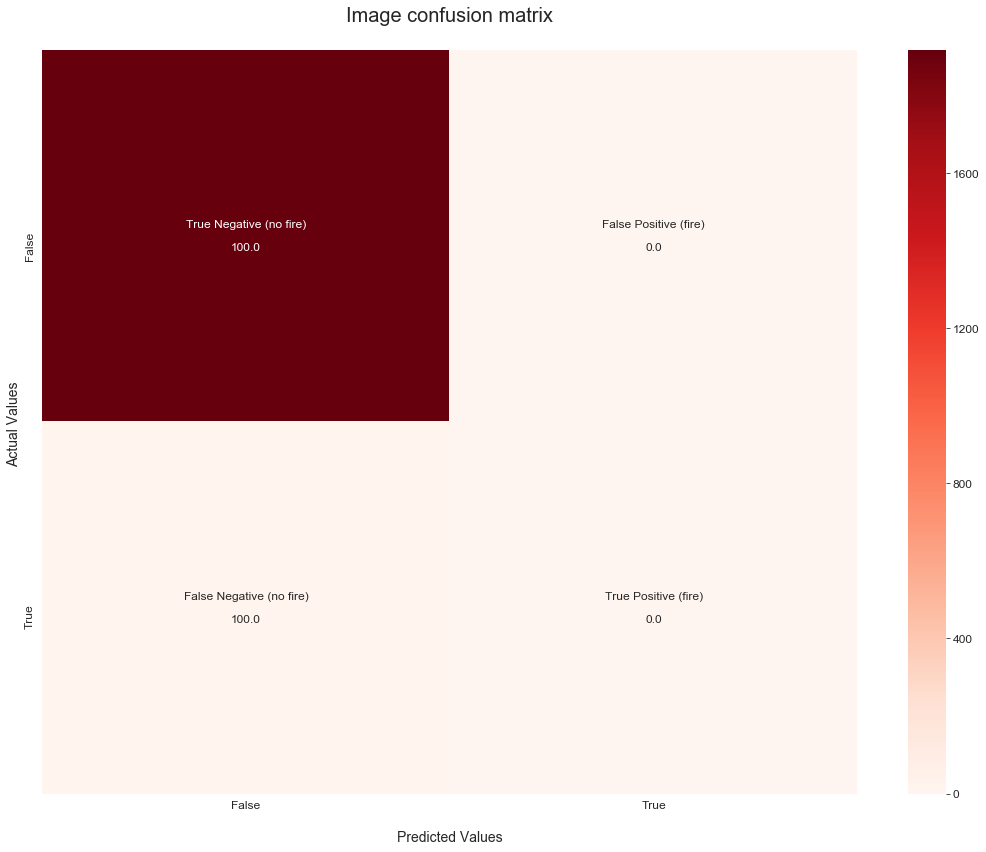

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
30    16      0.6      Nadam  0.815819   0.503876  0.47476          0       0   

                                            histories epochs best thresholds  
30  <keras.callbacks.History object at 0x000002B0A...      7        0.736292

61/61 [==============================] - 6s 96ms/step
0.85
[([1], 0.7447747), ([1], 0.6512589), ([1], 0.057012618), ([1], 0.02060929), ([1], 0.6297762), ([1], 0.24996313), ([1], 0.61920756), ([1], 0.020925403), ([1], 0.076045245), ([1], 0.6158506)]
[([1], 0.66787535), ([1], 0.13662994), ([1], 0.15745807), ([1], 0.24103403), ([1], 0.53784394), ([1], 0.23720008), ([1], 0.6418834), ([1], 0.02550459), ([1], 0.12832719), ([1], 0.61957663)]


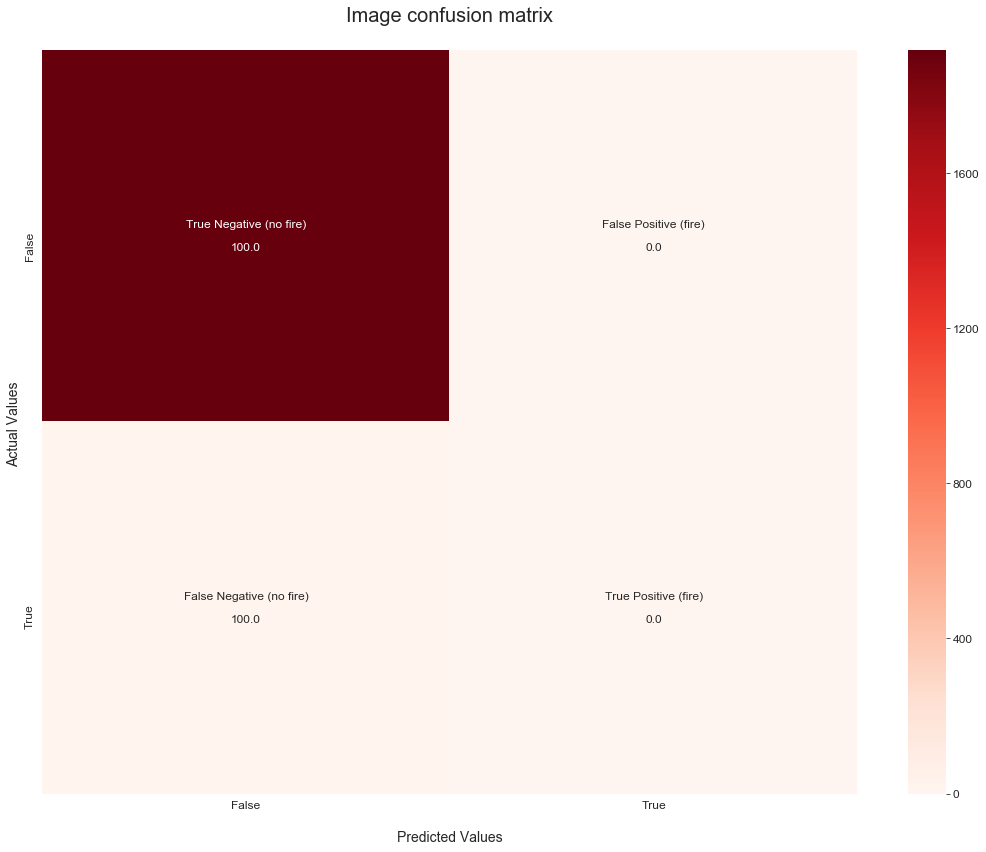

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
30    16      0.6      Nadam  0.815819   0.503876  0.47476          0       0   

                                            histories epochs best thresholds  
30  <keras.callbacks.History object at 0x000002B0A...      7        0.736292

61/61 [==============================] - 6s 97ms/step
0.9
[([1], 0.7447747), ([1], 0.6512589), ([1], 0.057012618), ([1], 0.02060929), ([1], 0.6297762), ([1], 0.24996313), ([1], 0.61920756), ([1], 0.020925403), ([1], 0.076045245), ([1], 0.6158506)]
[([1], 0.66787535), ([1], 0.13662994), ([1], 0.15745807), ([1], 0.24103403), ([1], 0.53784394), ([1], 0.23720008), ([1], 0.6418834), ([1], 0.02550459), ([1], 0.12832719), ([1], 0.61957663)]


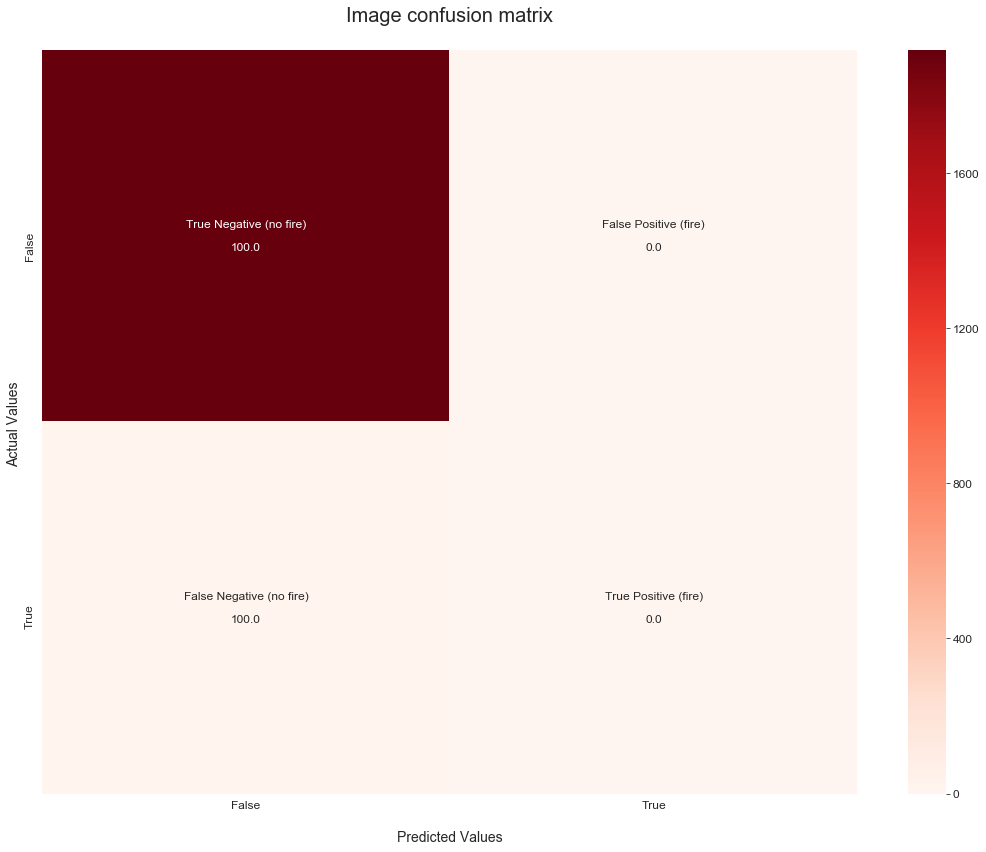

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
30    16      0.6      Nadam  0.815819   0.503876  0.47476          0       0   

                                            histories epochs best thresholds  
30  <keras.callbacks.History object at 0x000002B0A...      7        0.736292

61/61 [==============================] - 6s 97ms/step
0.95
[([1], 0.7447747), ([1], 0.6512589), ([1], 0.057012618), ([1], 0.02060929), ([1], 0.6297762), ([1], 0.24996313), ([1], 0.61920756), ([1], 0.020925403), ([1], 0.076045245), ([1], 0.6158506)]
[([1], 0.66787535), ([1], 0.13662994), ([1], 0.15745807), ([1], 0.24103403), ([1], 0.53784394), ([1], 0.23720008), ([1], 0.6418834), ([1], 0.02550459), ([1], 0.12832719), ([1], 0.61957663)]


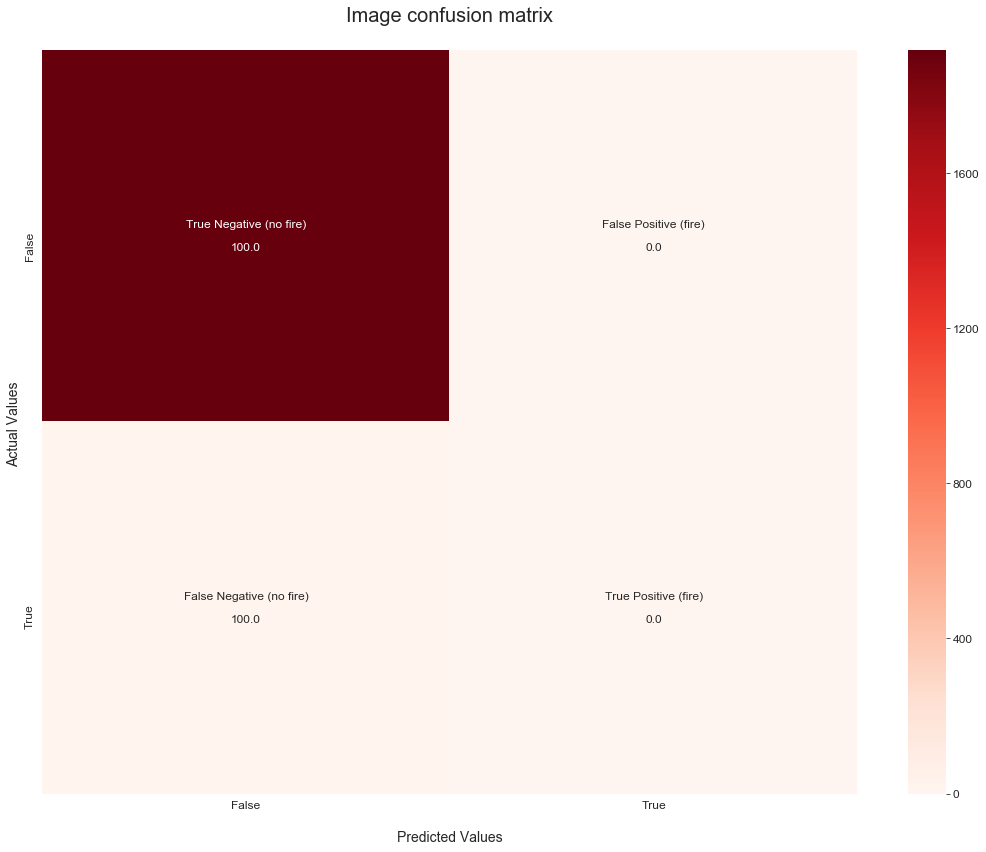

units dropouts optimizers    losses accuracies    aucs precisions recalls  \
31    16      0.6    RMSprop  0.672829   0.782946  0.8625          1  0.5625   

                                            histories epochs best thresholds  
31  <keras.callbacks.History object at 0x000002B0A...      7        0.504937

61/61 [==============================] - 7s 95ms/step
0.1
[([1], 0.9987012), ([1], 0.8921763), ([1], 0.6763346), ([1], 0.93638897), ([1], 0.99944556), ([1], 0.057682782), ([1], 0.99634147), ([1], 0.00711444), ([1], 0.03957346), ([1], 0.9992351)]
[([1], 0.9985189), ([1], 0.48665938), ([1], 0.8571622), ([1], 0.942574), ([1], 0.9996594), ([1], 0.30949438), ([1], 0.99551404), ([1], 0.0057225823), ([1], 0.04035729), ([1], 0.99883544)]


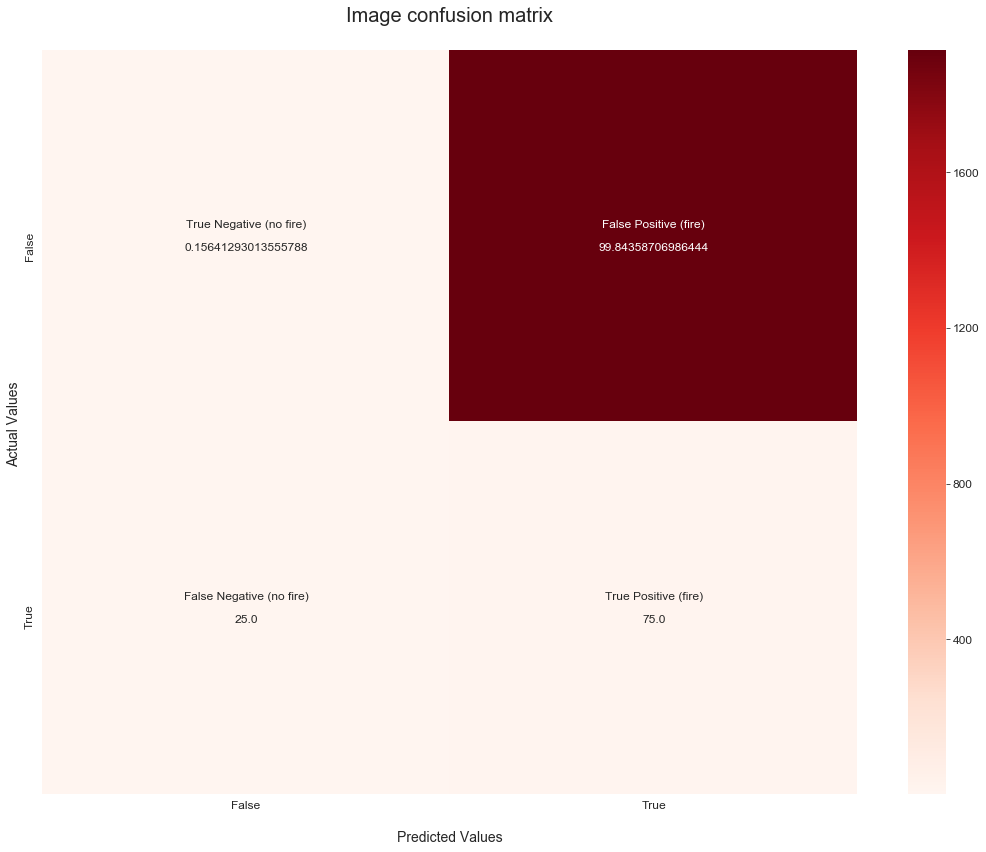

units dropouts optimizers    losses accuracies    aucs precisions recalls  \
31    16      0.6    RMSprop  0.672829   0.782946  0.8625          1  0.5625   

                                            histories epochs best thresholds  
31  <keras.callbacks.History object at 0x000002B0A...      7        0.504937

61/61 [==============================] - 6s 96ms/step
0.3
[([1], 0.9987012), ([1], 0.8921763), ([1], 0.6763346), ([1], 0.93638897), ([1], 0.99944556), ([1], 0.057682782), ([1], 0.99634147), ([1], 0.00711444), ([1], 0.03957346), ([1], 0.9992351)]
[([1], 0.9985189), ([1], 0.48665938), ([1], 0.8571622), ([1], 0.942574), ([1], 0.9996594), ([1], 0.30949438), ([1], 0.99551404), ([1], 0.0057225823), ([1], 0.04035729), ([1], 0.99883544)]


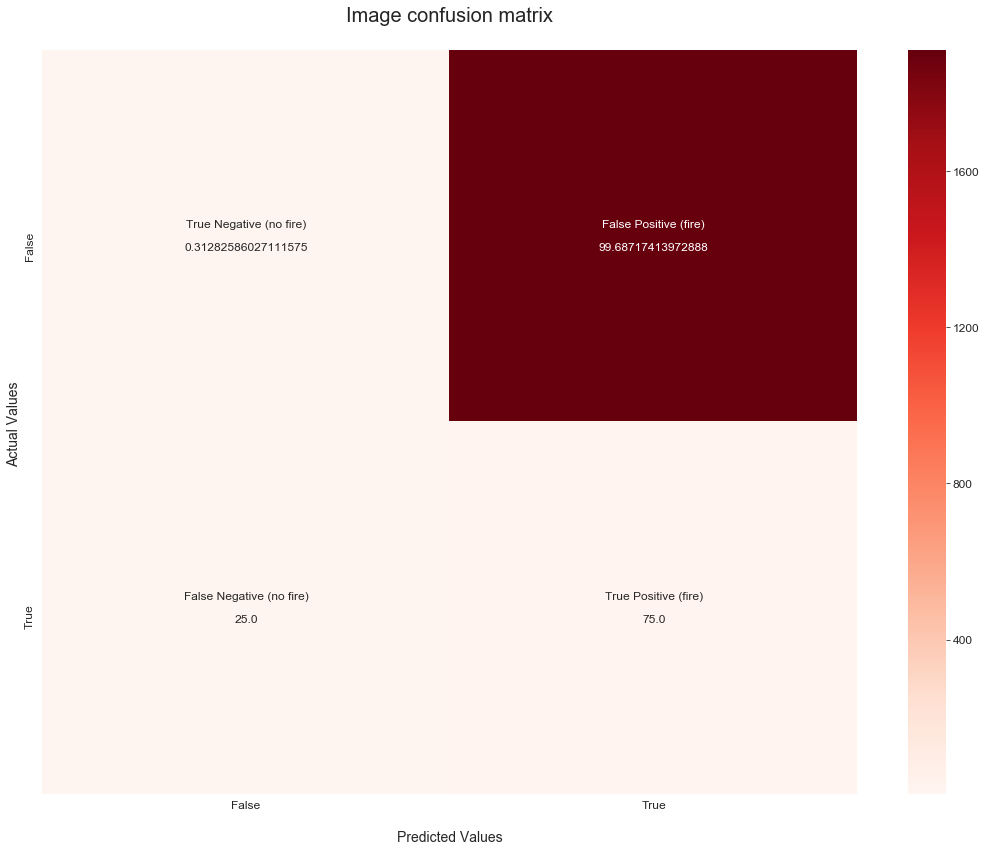

units dropouts optimizers    losses accuracies    aucs precisions recalls  \
31    16      0.6    RMSprop  0.672829   0.782946  0.8625          1  0.5625   

                                            histories epochs best thresholds  
31  <keras.callbacks.History object at 0x000002B0A...      7        0.504937

61/61 [==============================] - 6s 96ms/step
0.5
[([1], 0.9987012), ([1], 0.8921763), ([1], 0.6763346), ([1], 0.93638897), ([1], 0.99944556), ([1], 0.057682782), ([1], 0.99634147), ([1], 0.00711444), ([1], 0.03957346), ([1], 0.9992351)]
[([1], 0.9985189), ([1], 0.48665938), ([1], 0.8571622), ([1], 0.942574), ([1], 0.9996594), ([1], 0.30949438), ([1], 0.99551404), ([1], 0.0057225823), ([1], 0.04035729), ([1], 0.99883544)]


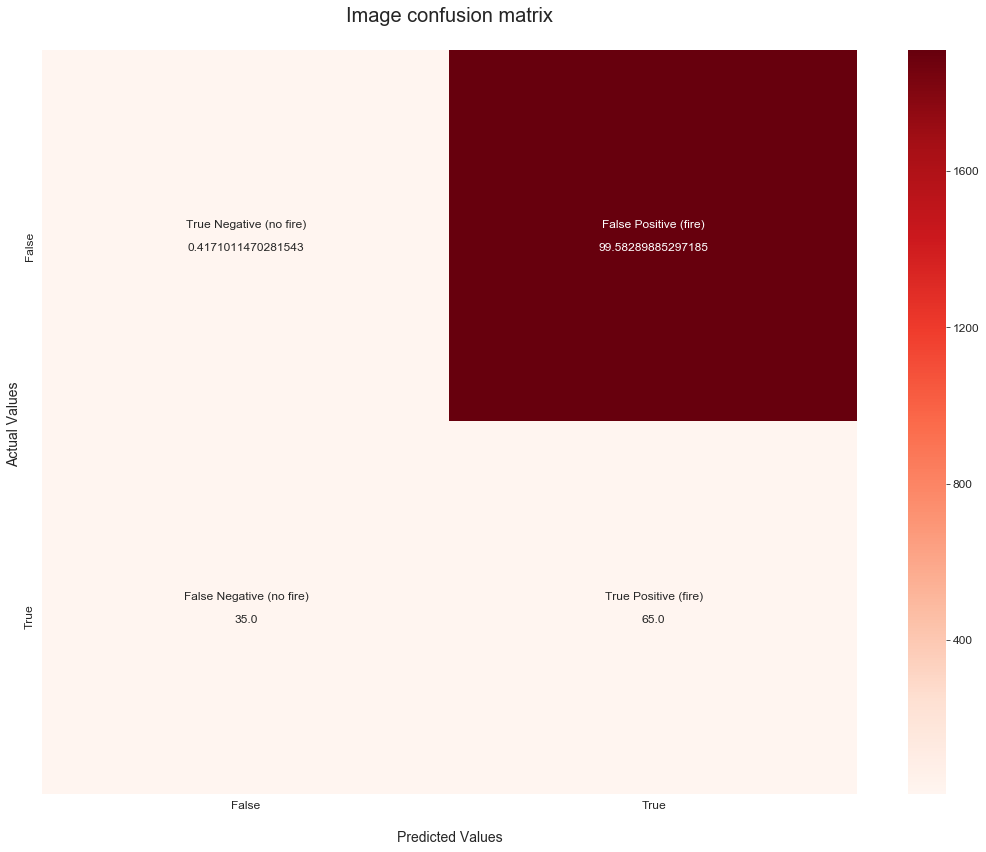

units dropouts optimizers    losses accuracies    aucs precisions recalls  \
31    16      0.6    RMSprop  0.672829   0.782946  0.8625          1  0.5625   

                                            histories epochs best thresholds  
31  <keras.callbacks.History object at 0x000002B0A...      7        0.504937

61/61 [==============================] - 6s 99ms/step
0.65
[([1], 0.9987012), ([1], 0.8921763), ([1], 0.6763346), ([1], 0.93638897), ([1], 0.99944556), ([1], 0.057682782), ([1], 0.99634147), ([1], 0.00711444), ([1], 0.03957346), ([1], 0.9992351)]
[([1], 0.9985189), ([1], 0.48665938), ([1], 0.8571622), ([1], 0.942574), ([1], 0.9996594), ([1], 0.30949438), ([1], 0.99551404), ([1], 0.0057225823), ([1], 0.04035729), ([1], 0.99883544)]


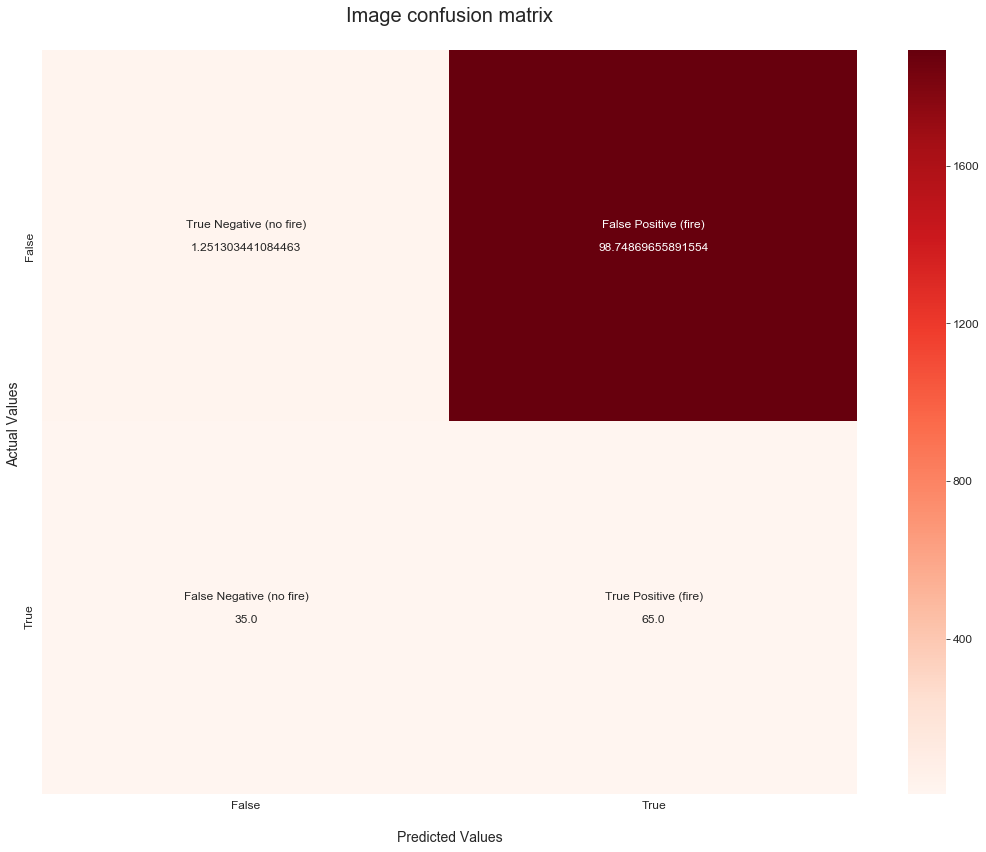

units dropouts optimizers    losses accuracies    aucs precisions recalls  \
31    16      0.6    RMSprop  0.672829   0.782946  0.8625          1  0.5625   

                                            histories epochs best thresholds  
31  <keras.callbacks.History object at 0x000002B0A...      7        0.504937

61/61 [==============================] - 6s 96ms/step
0.725
[([1], 0.9987012), ([1], 0.8921763), ([1], 0.6763346), ([1], 0.93638897), ([1], 0.99944556), ([1], 0.057682782), ([1], 0.99634147), ([1], 0.00711444), ([1], 0.03957346), ([1], 0.9992351)]
[([1], 0.9985189), ([1], 0.48665938), ([1], 0.8571622), ([1], 0.942574), ([1], 0.9996594), ([1], 0.30949438), ([1], 0.99551404), ([1], 0.0057225823), ([1], 0.04035729), ([1], 0.99883544)]


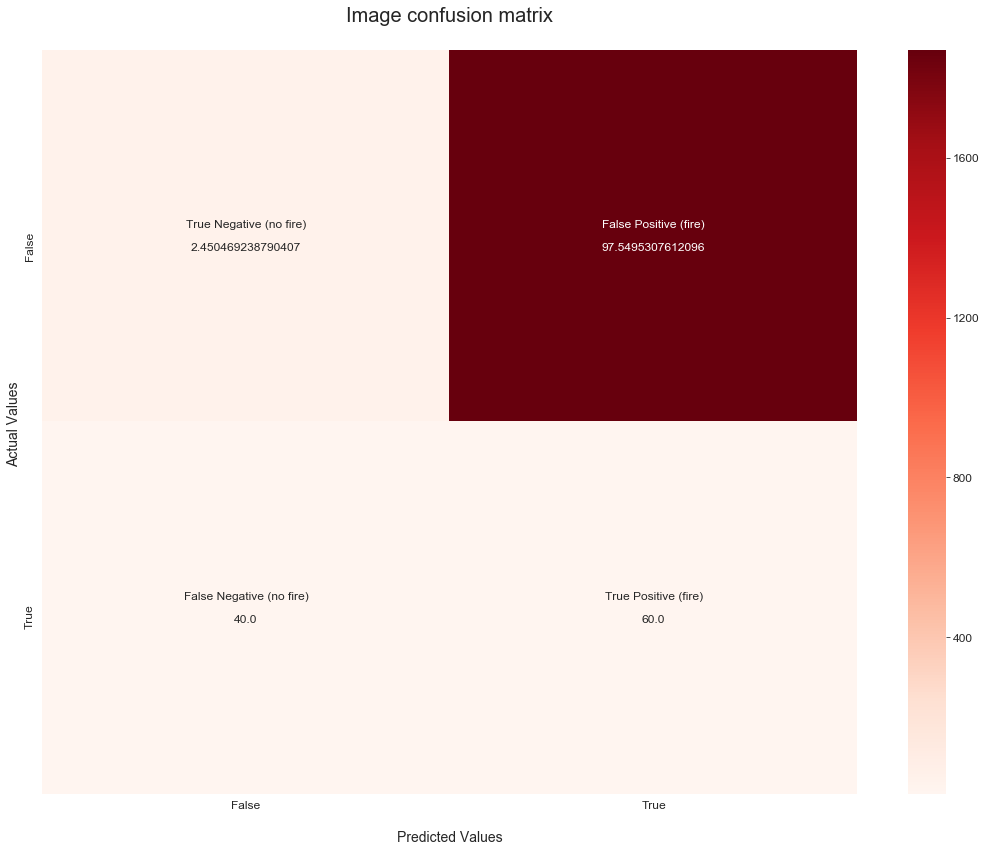

units dropouts optimizers    losses accuracies    aucs precisions recalls  \
31    16      0.6    RMSprop  0.672829   0.782946  0.8625          1  0.5625   

                                            histories epochs best thresholds  
31  <keras.callbacks.History object at 0x000002B0A...      7        0.504937

61/61 [==============================] - 6s 97ms/step
0.8
[([1], 0.9987012), ([1], 0.8921763), ([1], 0.6763346), ([1], 0.93638897), ([1], 0.99944556), ([1], 0.057682782), ([1], 0.99634147), ([1], 0.00711444), ([1], 0.03957346), ([1], 0.9992351)]
[([1], 0.9985189), ([1], 0.48665938), ([1], 0.8571622), ([1], 0.942574), ([1], 0.9996594), ([1], 0.30949438), ([1], 0.99551404), ([1], 0.0057225823), ([1], 0.04035729), ([1], 0.99883544)]


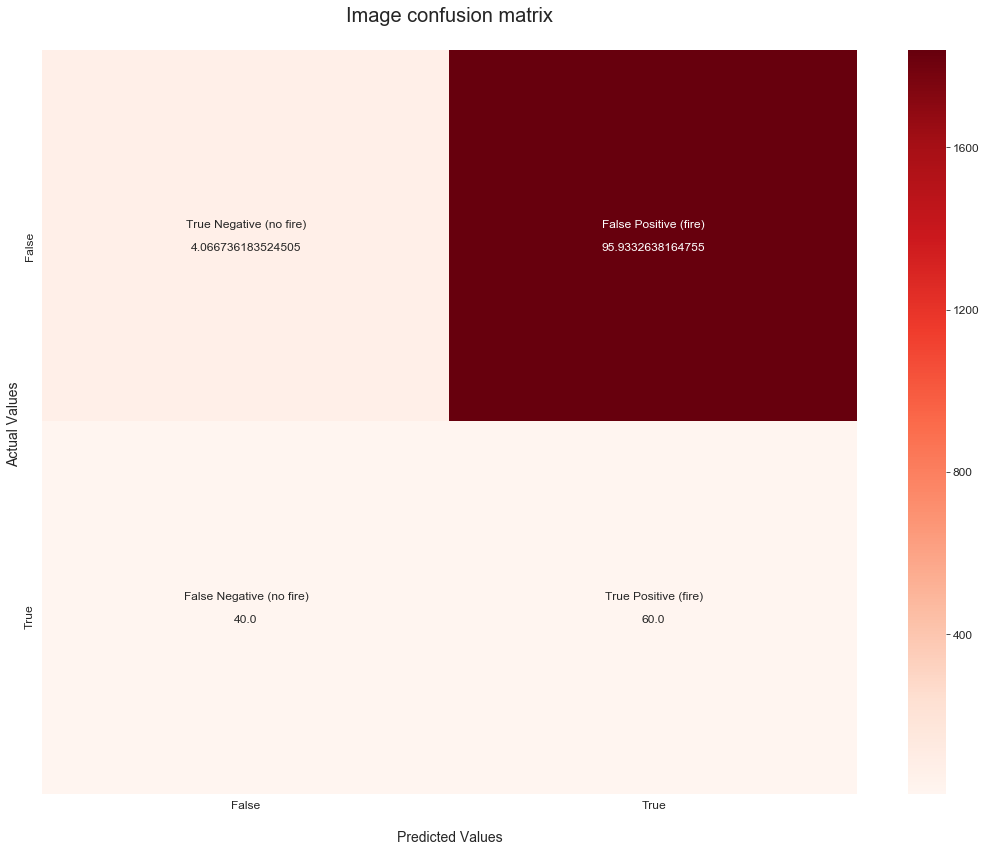

units dropouts optimizers    losses accuracies    aucs precisions recalls  \
31    16      0.6    RMSprop  0.672829   0.782946  0.8625          1  0.5625   

                                            histories epochs best thresholds  
31  <keras.callbacks.History object at 0x000002B0A...      7        0.504937

61/61 [==============================] - 6s 97ms/step
0.85
[([1], 0.9987012), ([1], 0.8921763), ([1], 0.6763346), ([1], 0.93638897), ([1], 0.99944556), ([1], 0.057682782), ([1], 0.99634147), ([1], 0.00711444), ([1], 0.03957346), ([1], 0.9992351)]
[([1], 0.9985189), ([1], 0.48665938), ([1], 0.8571622), ([1], 0.942574), ([1], 0.9996594), ([1], 0.30949438), ([1], 0.99551404), ([1], 0.0057225823), ([1], 0.04035729), ([1], 0.99883544)]


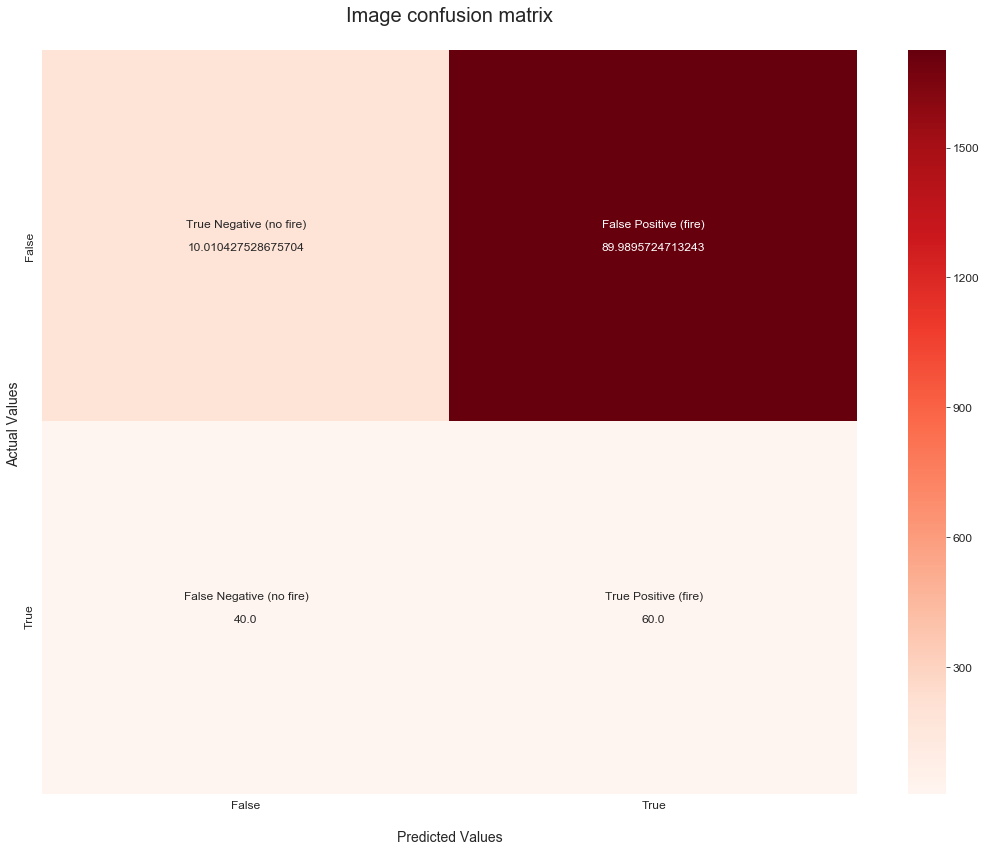

units dropouts optimizers    losses accuracies    aucs precisions recalls  \
31    16      0.6    RMSprop  0.672829   0.782946  0.8625          1  0.5625   

                                            histories epochs best thresholds  
31  <keras.callbacks.History object at 0x000002B0A...      7        0.504937

61/61 [==============================] - 6s 97ms/step
0.9
[([1], 0.9987012), ([1], 0.8921763), ([1], 0.6763346), ([1], 0.93638897), ([1], 0.99944556), ([1], 0.057682782), ([1], 0.99634147), ([1], 0.00711444), ([1], 0.03957346), ([1], 0.9992351)]
[([1], 0.9985189), ([1], 0.48665938), ([1], 0.8571622), ([1], 0.942574), ([1], 0.9996594), ([1], 0.30949438), ([1], 0.99551404), ([1], 0.0057225823), ([1], 0.04035729), ([1], 0.99883544)]


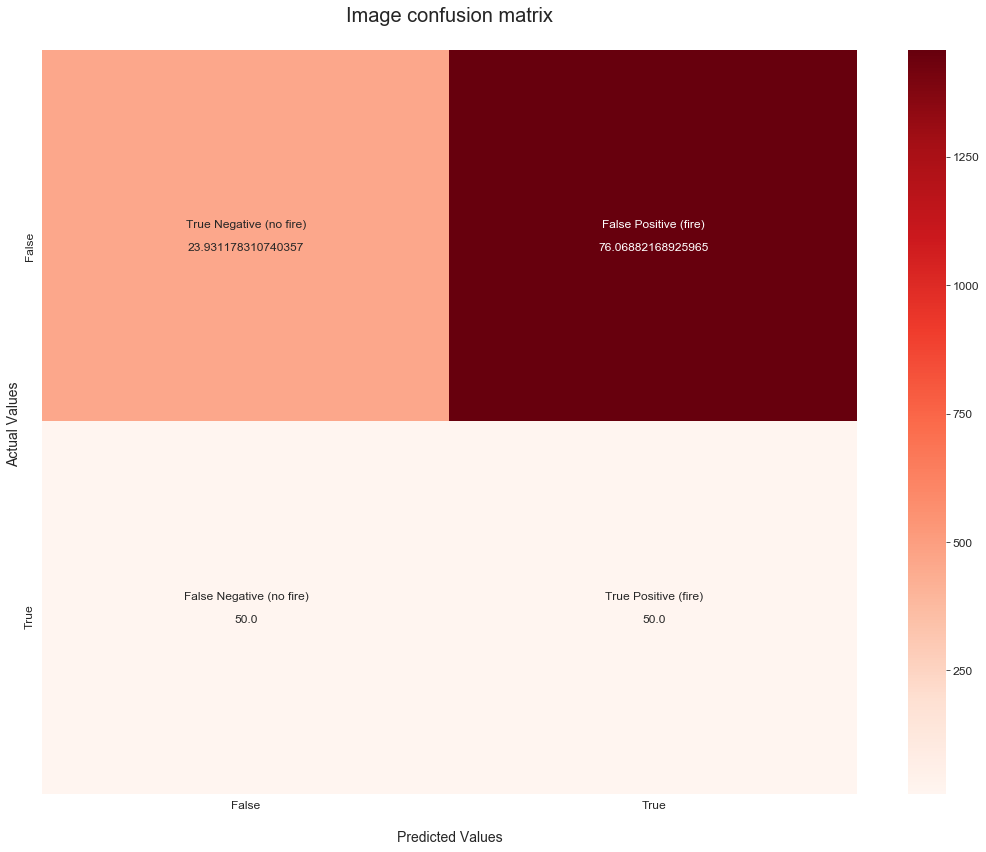

units dropouts optimizers    losses accuracies    aucs precisions recalls  \
31    16      0.6    RMSprop  0.672829   0.782946  0.8625          1  0.5625   

                                            histories epochs best thresholds  
31  <keras.callbacks.History object at 0x000002B0A...      7        0.504937

61/61 [==============================] - 6s 99ms/step
0.95
[([1], 0.9987012), ([1], 0.8921763), ([1], 0.6763346), ([1], 0.93638897), ([1], 0.99944556), ([1], 0.057682782), ([1], 0.99634147), ([1], 0.00711444), ([1], 0.03957346), ([1], 0.9992351)]
[([1], 0.9985189), ([1], 0.48665938), ([1], 0.8571622), ([1], 0.942574), ([1], 0.9996594), ([1], 0.30949438), ([1], 0.99551404), ([1], 0.0057225823), ([1], 0.04035729), ([1], 0.99883544)]


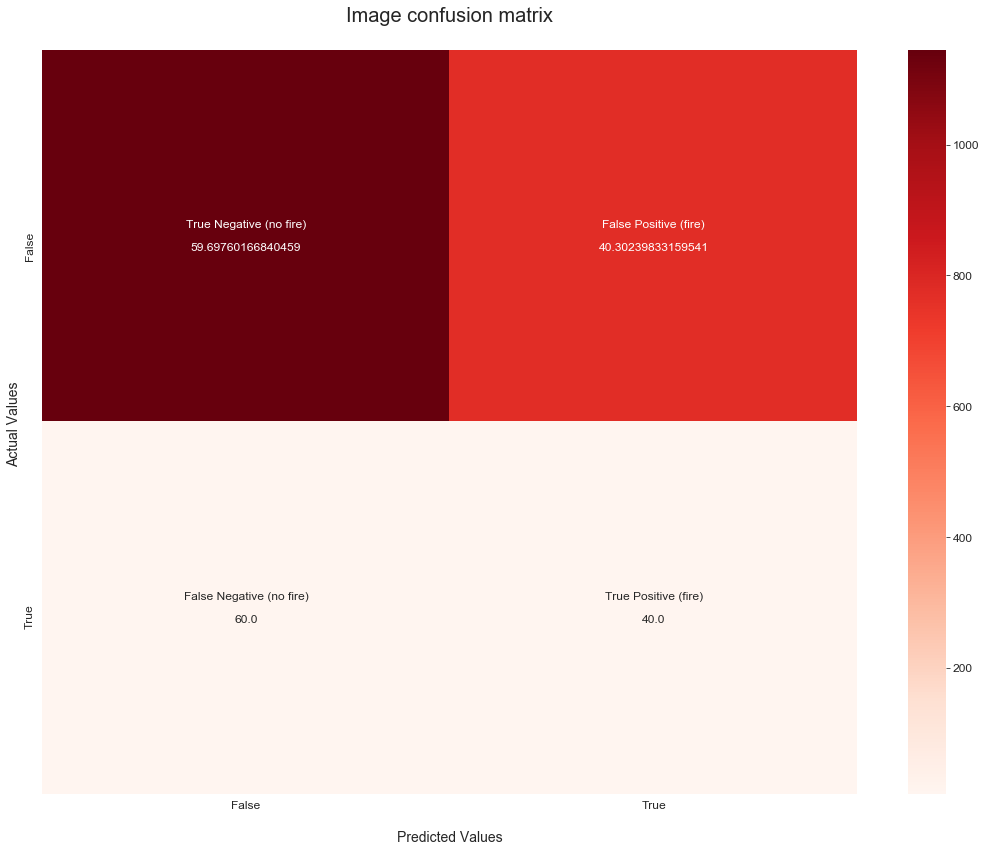

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
32    16      0.6       adam  0.710843   0.496124  0.64976   0.496124       1   

                                            histories epochs best thresholds  
32  <keras.callbacks.History object at 0x000002B0A...      8        0.404702

61/61 [==============================] - 6s 95ms/step
0.1
[([1], 0.5382678), ([1], 0.583014), ([1], 0.5350079), ([1], 0.47747678), ([1], 0.5350079), ([1], 0.5613128), ([1], 0.5638154), ([1], 0.54222333), ([1], 0.4372384), ([1], 0.55206007)]
[([1], 0.5350079), ([1], 0.5550926), ([1], 0.5350079), ([1], 0.59909636), ([1], 0.5350079), ([1], 0.54935116), ([1], 0.5651738), ([1], 0.54597074), ([1], 0.48307818), ([1], 0.61472607)]


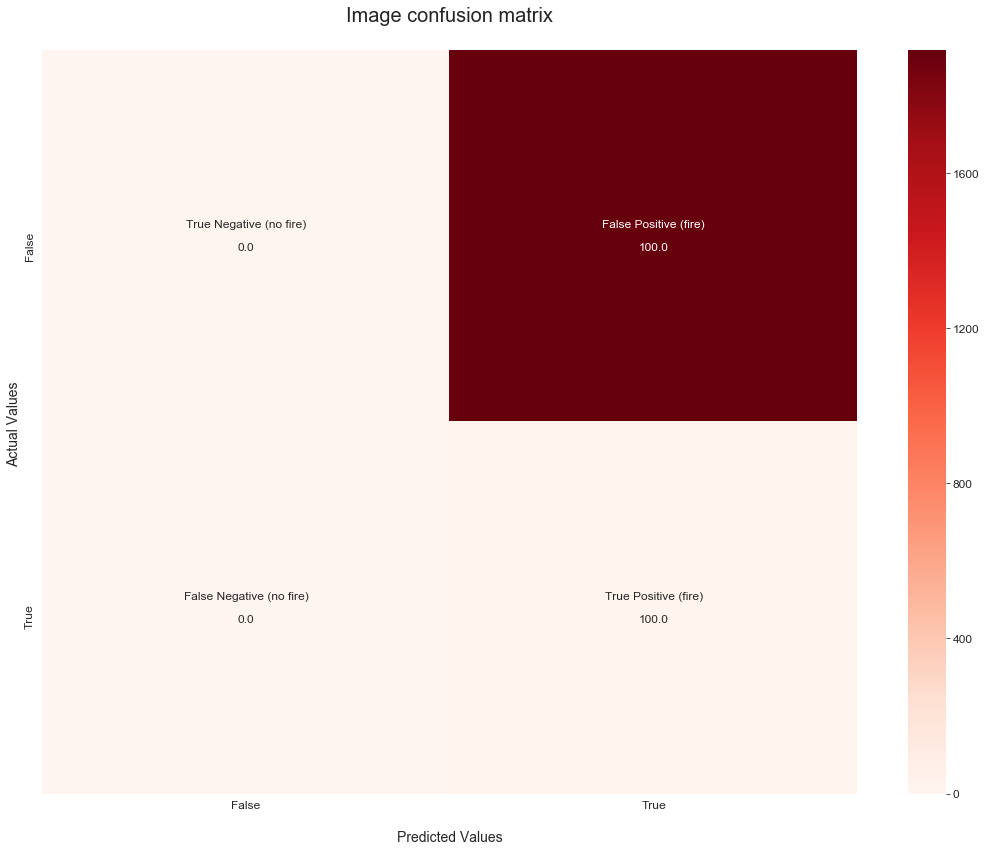

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
32    16      0.6       adam  0.710843   0.496124  0.64976   0.496124       1   

                                            histories epochs best thresholds  
32  <keras.callbacks.History object at 0x000002B0A...      8        0.404702

61/61 [==============================] - 7s 102ms/step
0.3
[([1], 0.5382678), ([1], 0.583014), ([1], 0.5350079), ([1], 0.47747678), ([1], 0.5350079), ([1], 0.5613128), ([1], 0.5638154), ([1], 0.54222333), ([1], 0.4372384), ([1], 0.55206007)]
[([1], 0.5350079), ([1], 0.5550926), ([1], 0.5350079), ([1], 0.59909636), ([1], 0.5350079), ([1], 0.54935116), ([1], 0.5651738), ([1], 0.54597074), ([1], 0.48307818), ([1], 0.61472607)]


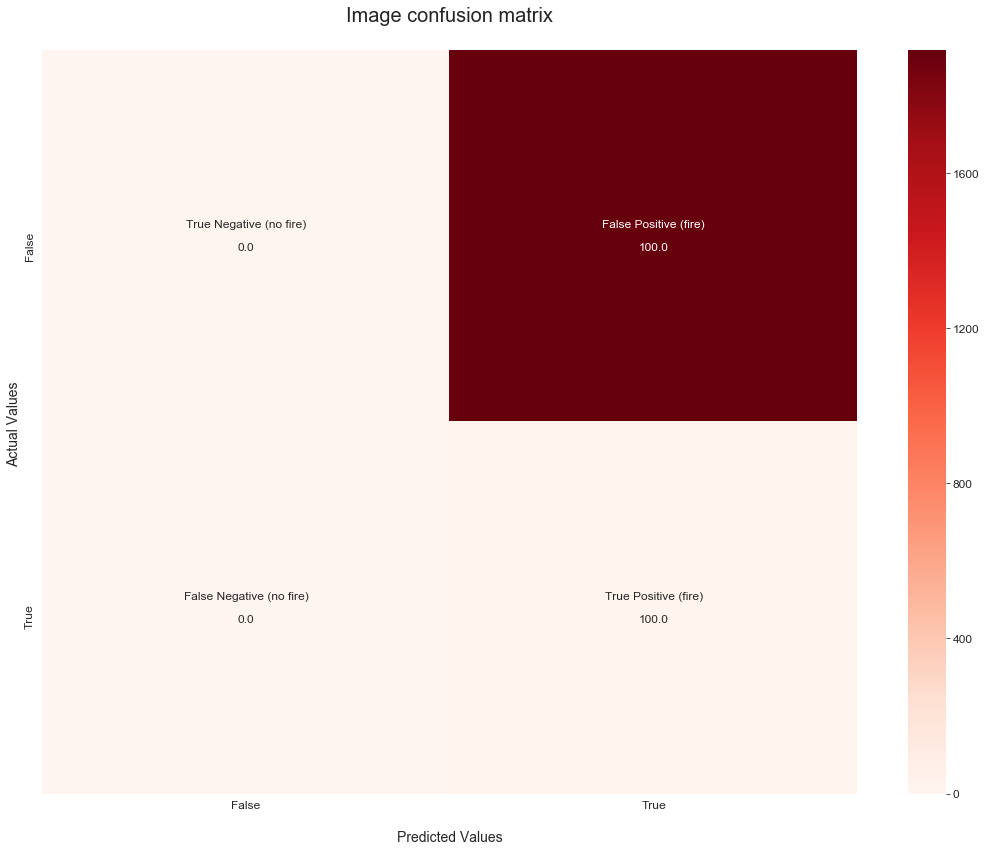

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
32    16      0.6       adam  0.710843   0.496124  0.64976   0.496124       1   

                                            histories epochs best thresholds  
32  <keras.callbacks.History object at 0x000002B0A...      8        0.404702

61/61 [==============================] - 7s 101ms/step
0.5
[([1], 0.5382678), ([1], 0.583014), ([1], 0.5350079), ([1], 0.47747678), ([1], 0.5350079), ([1], 0.5613128), ([1], 0.5638154), ([1], 0.54222333), ([1], 0.4372384), ([1], 0.55206007)]
[([1], 0.5350079), ([1], 0.5550926), ([1], 0.5350079), ([1], 0.59909636), ([1], 0.5350079), ([1], 0.54935116), ([1], 0.5651738), ([1], 0.54597074), ([1], 0.48307818), ([1], 0.61472607)]


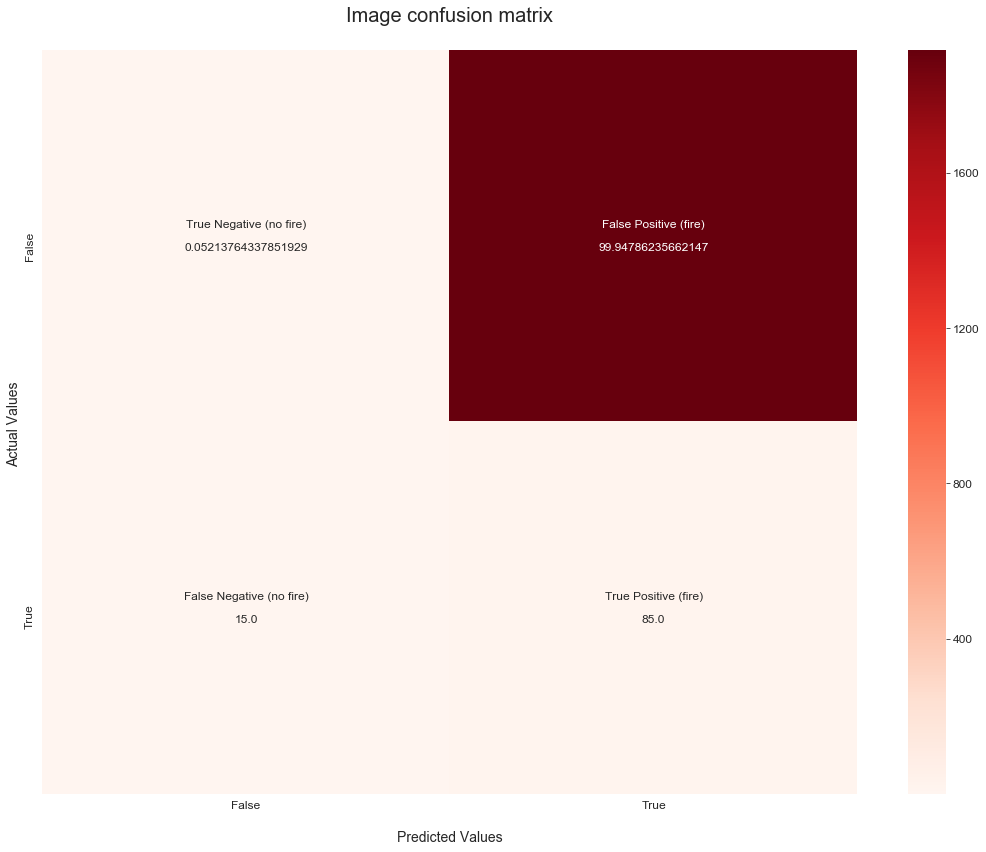

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
32    16      0.6       adam  0.710843   0.496124  0.64976   0.496124       1   

                                            histories epochs best thresholds  
32  <keras.callbacks.History object at 0x000002B0A...      8        0.404702

61/61 [==============================] - 6s 100ms/step
0.65
[([1], 0.5382678), ([1], 0.583014), ([1], 0.5350079), ([1], 0.47747678), ([1], 0.5350079), ([1], 0.5613128), ([1], 0.5638154), ([1], 0.54222333), ([1], 0.4372384), ([1], 0.55206007)]
[([1], 0.5350079), ([1], 0.5550926), ([1], 0.5350079), ([1], 0.59909636), ([1], 0.5350079), ([1], 0.54935116), ([1], 0.5651738), ([1], 0.54597074), ([1], 0.48307818), ([1], 0.61472607)]


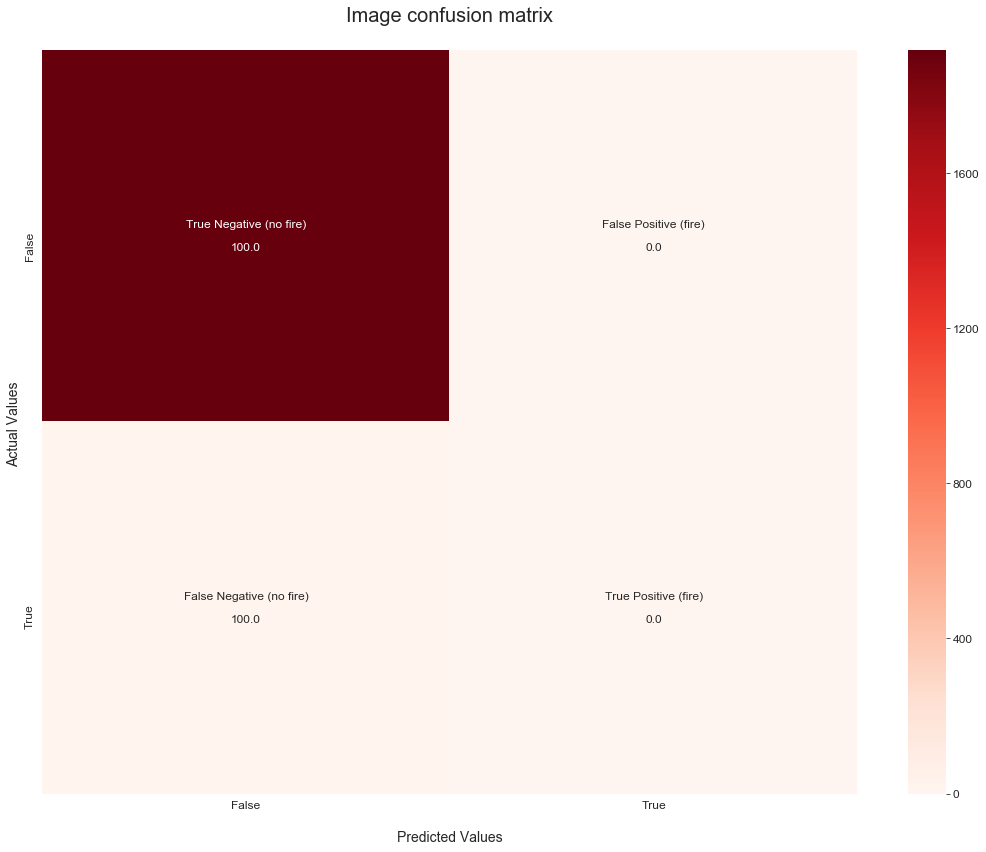

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
32    16      0.6       adam  0.710843   0.496124  0.64976   0.496124       1   

                                            histories epochs best thresholds  
32  <keras.callbacks.History object at 0x000002B0A...      8        0.404702

61/61 [==============================] - 6s 99ms/step
0.725
[([1], 0.5382678), ([1], 0.583014), ([1], 0.5350079), ([1], 0.47747678), ([1], 0.5350079), ([1], 0.5613128), ([1], 0.5638154), ([1], 0.54222333), ([1], 0.4372384), ([1], 0.55206007)]
[([1], 0.5350079), ([1], 0.5550926), ([1], 0.5350079), ([1], 0.59909636), ([1], 0.5350079), ([1], 0.54935116), ([1], 0.5651738), ([1], 0.54597074), ([1], 0.48307818), ([1], 0.61472607)]


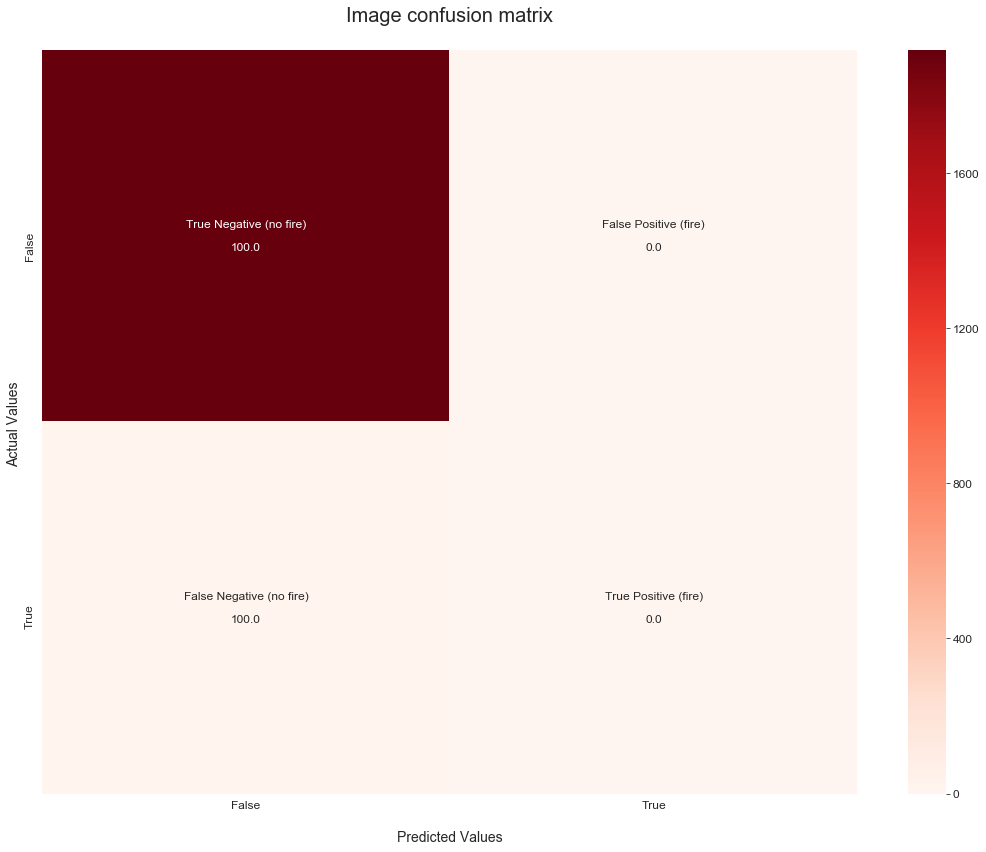

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
32    16      0.6       adam  0.710843   0.496124  0.64976   0.496124       1   

                                            histories epochs best thresholds  
32  <keras.callbacks.History object at 0x000002B0A...      8        0.404702

61/61 [==============================] - 6s 98ms/step
0.8
[([1], 0.5382678), ([1], 0.583014), ([1], 0.5350079), ([1], 0.47747678), ([1], 0.5350079), ([1], 0.5613128), ([1], 0.5638154), ([1], 0.54222333), ([1], 0.4372384), ([1], 0.55206007)]
[([1], 0.5350079), ([1], 0.5550926), ([1], 0.5350079), ([1], 0.59909636), ([1], 0.5350079), ([1], 0.54935116), ([1], 0.5651738), ([1], 0.54597074), ([1], 0.48307818), ([1], 0.61472607)]


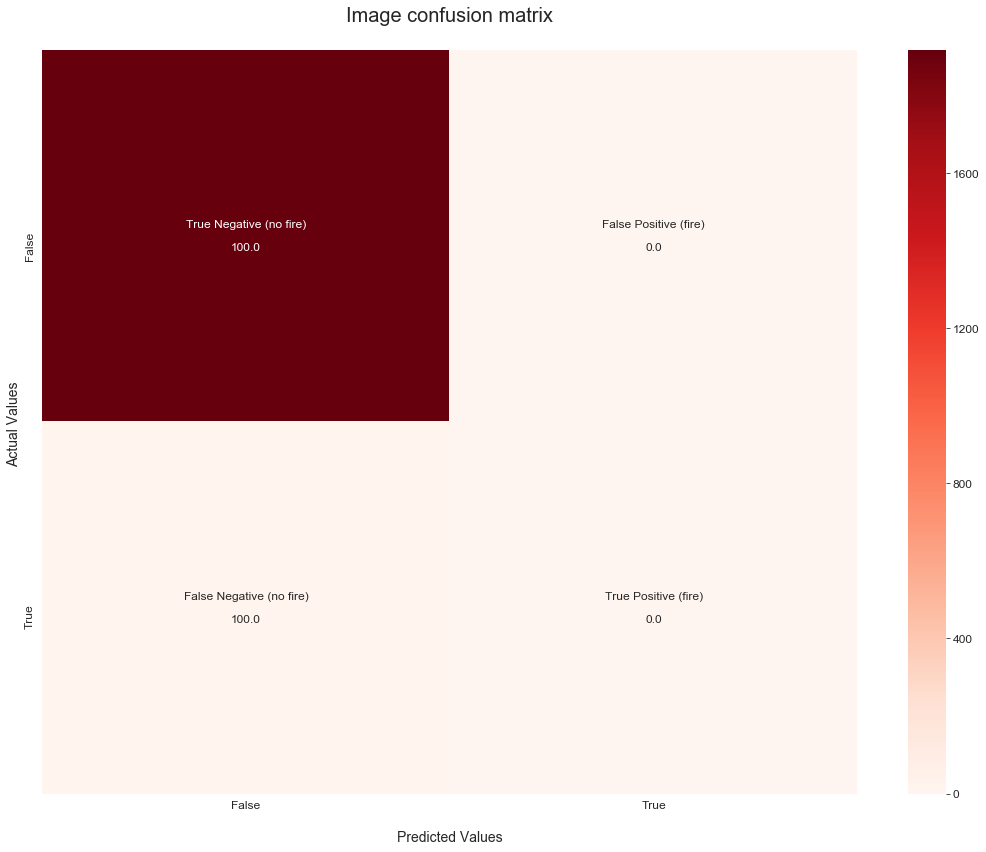

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
32    16      0.6       adam  0.710843   0.496124  0.64976   0.496124       1   

                                            histories epochs best thresholds  
32  <keras.callbacks.History object at 0x000002B0A...      8        0.404702

61/61 [==============================] - 6s 98ms/step
0.85
[([1], 0.5382678), ([1], 0.583014), ([1], 0.5350079), ([1], 0.47747678), ([1], 0.5350079), ([1], 0.5613128), ([1], 0.5638154), ([1], 0.54222333), ([1], 0.4372384), ([1], 0.55206007)]
[([1], 0.5350079), ([1], 0.5550926), ([1], 0.5350079), ([1], 0.59909636), ([1], 0.5350079), ([1], 0.54935116), ([1], 0.5651738), ([1], 0.54597074), ([1], 0.48307818), ([1], 0.61472607)]


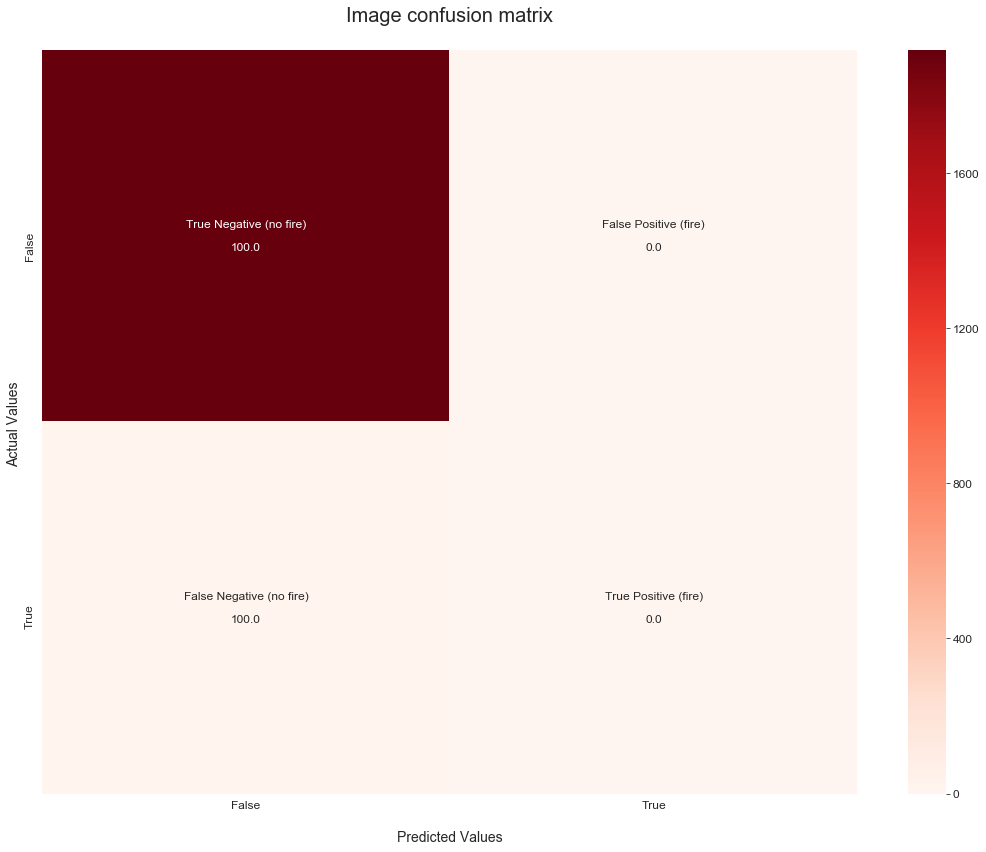

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
32    16      0.6       adam  0.710843   0.496124  0.64976   0.496124       1   

                                            histories epochs best thresholds  
32  <keras.callbacks.History object at 0x000002B0A...      8        0.404702

61/61 [==============================] - 6s 99ms/step
0.9
[([1], 0.5382678), ([1], 0.583014), ([1], 0.5350079), ([1], 0.47747678), ([1], 0.5350079), ([1], 0.5613128), ([1], 0.5638154), ([1], 0.54222333), ([1], 0.4372384), ([1], 0.55206007)]
[([1], 0.5350079), ([1], 0.5550926), ([1], 0.5350079), ([1], 0.59909636), ([1], 0.5350079), ([1], 0.54935116), ([1], 0.5651738), ([1], 0.54597074), ([1], 0.48307818), ([1], 0.61472607)]


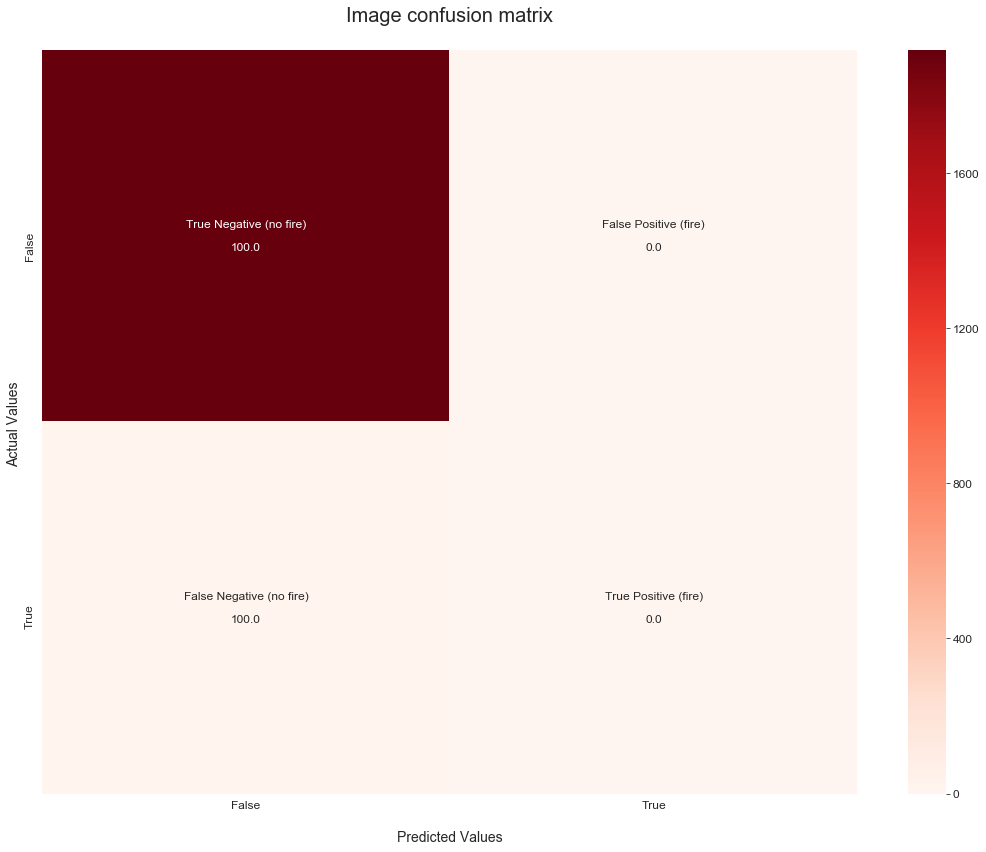

units dropouts optimizers    losses accuracies     aucs precisions recalls  \
32    16      0.6       adam  0.710843   0.496124  0.64976   0.496124       1   

                                            histories epochs best thresholds  
32  <keras.callbacks.History object at 0x000002B0A...      8        0.404702

61/61 [==============================] - 6s 98ms/step
0.95
[([1], 0.5382678), ([1], 0.583014), ([1], 0.5350079), ([1], 0.47747678), ([1], 0.5350079), ([1], 0.5613128), ([1], 0.5638154), ([1], 0.54222333), ([1], 0.4372384), ([1], 0.55206007)]
[([1], 0.5350079), ([1], 0.5550926), ([1], 0.5350079), ([1], 0.59909636), ([1], 0.5350079), ([1], 0.54935116), ([1], 0.5651738), ([1], 0.54597074), ([1], 0.48307818), ([1], 0.61472607)]


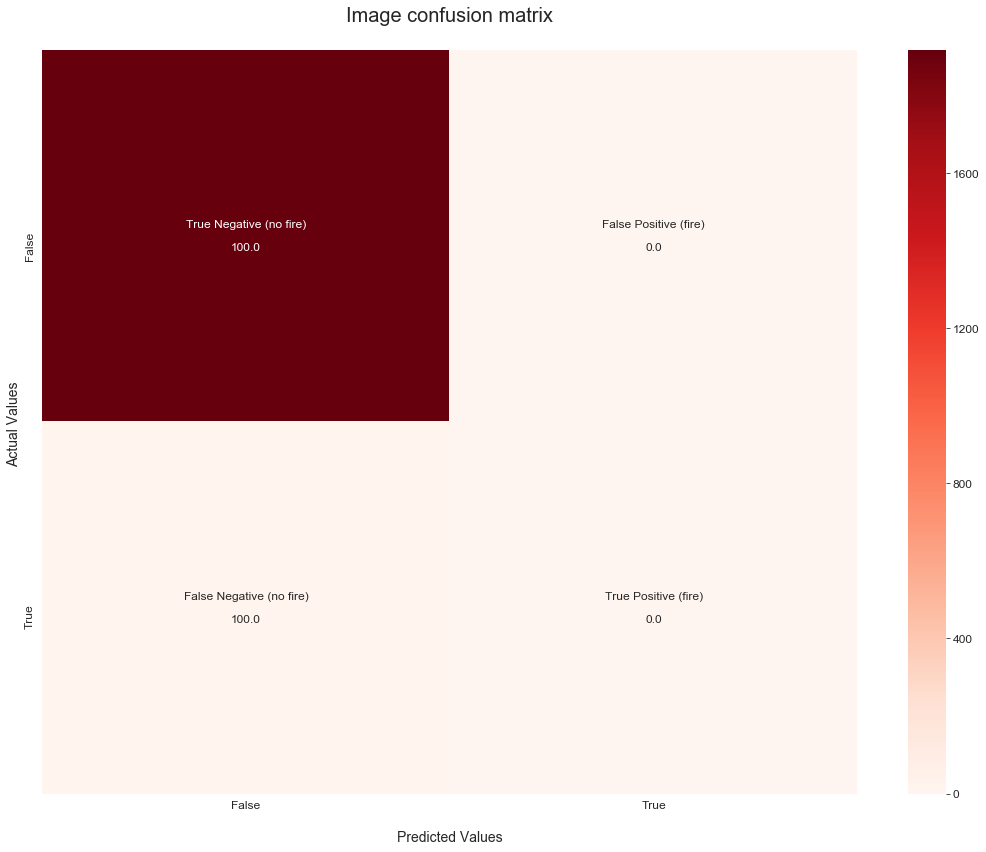

units dropouts optimizers    losses accuracies      aucs precisions  \
33    16      0.6      Nadam  0.935103   0.496124  0.768389   0.496124   

   recalls                                          histories epochs  \
33       1  <keras.callbacks.History object at 0x000002B0B...      8   

   best thresholds  
33        0.186827

61/61 [==============================] - 7s 96ms/step
0.1
[([1], 0.983416), ([1], 0.9645612), ([1], 0.090004206), ([1], 0.16407883), ([1], 0.9542479), ([1], 0.26027784), ([1], 0.94793856), ([1], 0.019242227), ([1], 0.03935346), ([1], 0.80904794)]
[([1], 0.98028946), ([1], 0.46967843), ([1], 0.2304233), ([1], 0.6537165), ([1], 0.95595014), ([1], 0.14115864), ([1], 0.9498724), ([1], 0.014412254), ([1], 0.0814763), ([1], 0.9670399)]


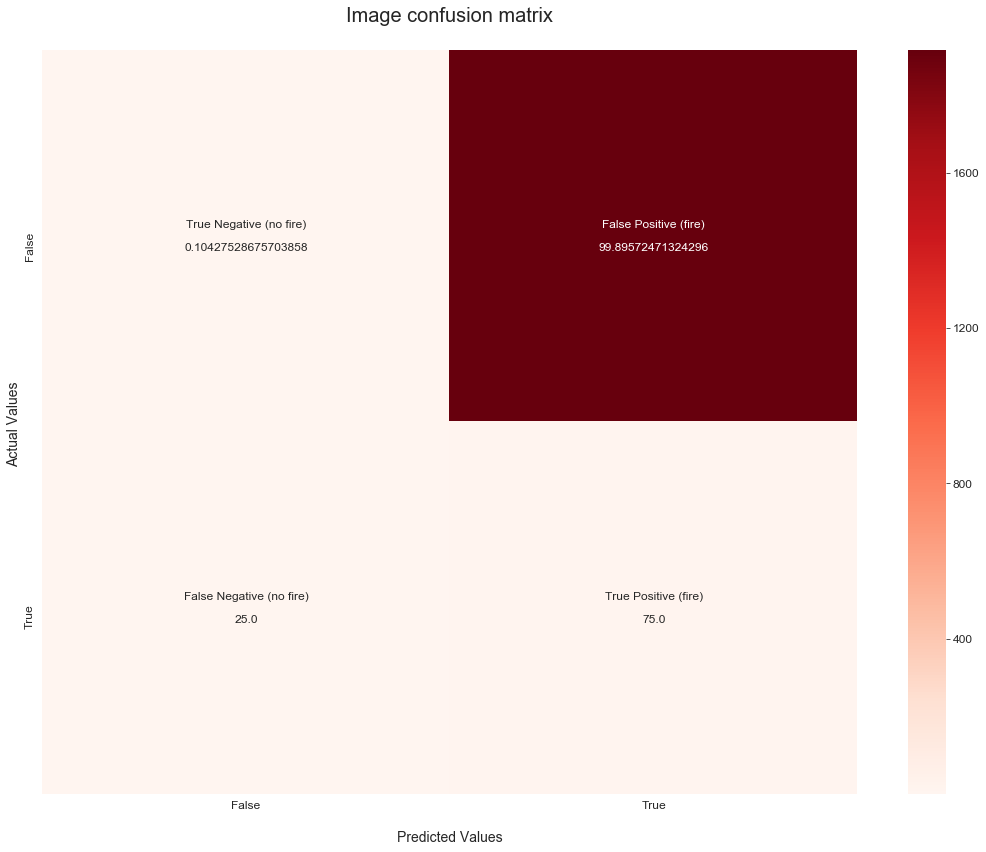

units dropouts optimizers    losses accuracies      aucs precisions  \
33    16      0.6      Nadam  0.935103   0.496124  0.768389   0.496124   

   recalls                                          histories epochs  \
33       1  <keras.callbacks.History object at 0x000002B0B...      8   

   best thresholds  
33        0.186827

61/61 [==============================] - 6s 97ms/step
0.3
[([1], 0.983416), ([1], 0.9645612), ([1], 0.090004206), ([1], 0.16407883), ([1], 0.9542479), ([1], 0.26027784), ([1], 0.94793856), ([1], 0.019242227), ([1], 0.03935346), ([1], 0.80904794)]
[([1], 0.98028946), ([1], 0.46967843), ([1], 0.2304233), ([1], 0.6537165), ([1], 0.95595014), ([1], 0.14115864), ([1], 0.9498724), ([1], 0.014412254), ([1], 0.0814763), ([1], 0.9670399)]


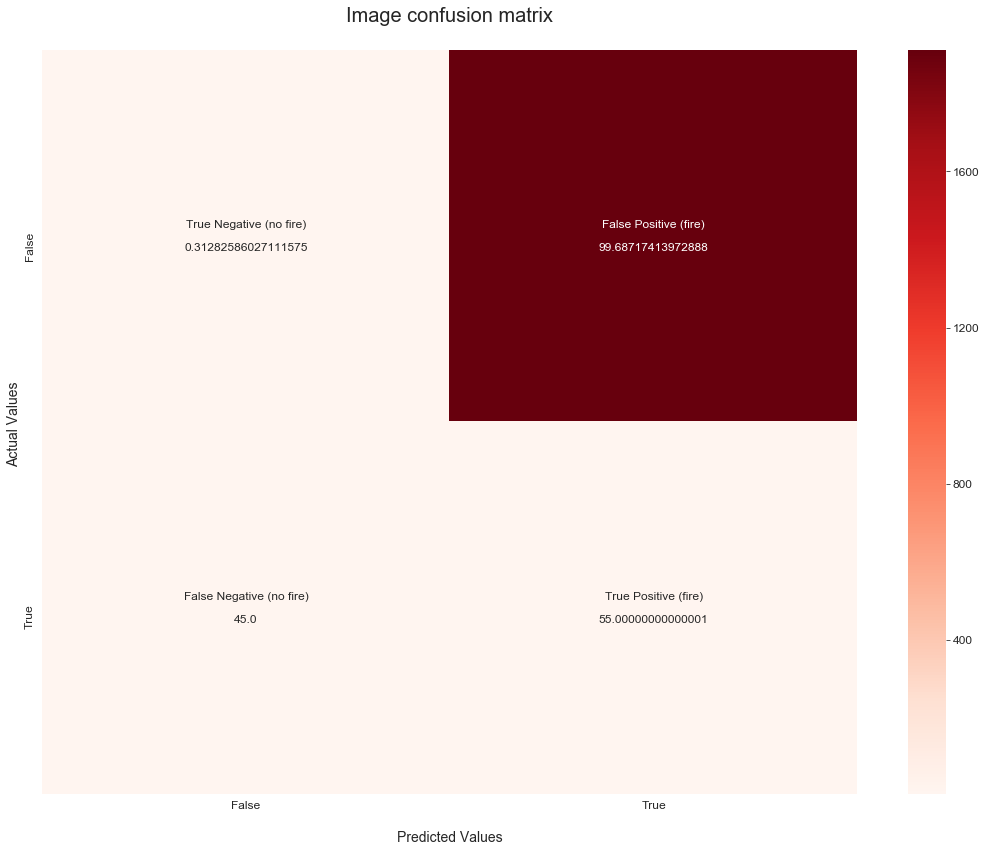

units dropouts optimizers    losses accuracies      aucs precisions  \
33    16      0.6      Nadam  0.935103   0.496124  0.768389   0.496124   

   recalls                                          histories epochs  \
33       1  <keras.callbacks.History object at 0x000002B0B...      8   

   best thresholds  
33        0.186827

61/61 [==============================] - 6s 95ms/step
0.5
[([1], 0.983416), ([1], 0.9645612), ([1], 0.090004206), ([1], 0.16407883), ([1], 0.9542479), ([1], 0.26027784), ([1], 0.94793856), ([1], 0.019242227), ([1], 0.03935346), ([1], 0.80904794)]
[([1], 0.98028946), ([1], 0.46967843), ([1], 0.2304233), ([1], 0.6537165), ([1], 0.95595014), ([1], 0.14115864), ([1], 0.9498724), ([1], 0.014412254), ([1], 0.0814763), ([1], 0.9670399)]


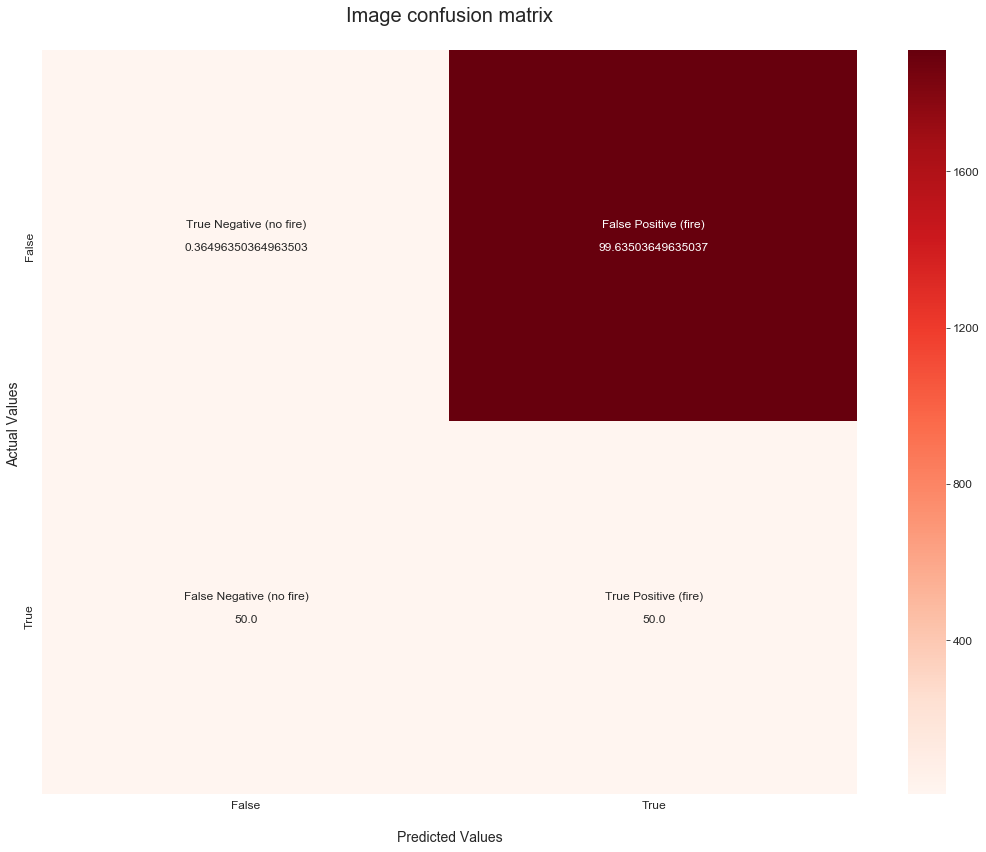

units dropouts optimizers    losses accuracies      aucs precisions  \
33    16      0.6      Nadam  0.935103   0.496124  0.768389   0.496124   

   recalls                                          histories epochs  \
33       1  <keras.callbacks.History object at 0x000002B0B...      8   

   best thresholds  
33        0.186827

61/61 [==============================] - 6s 95ms/step
0.65
[([1], 0.983416), ([1], 0.9645612), ([1], 0.090004206), ([1], 0.16407883), ([1], 0.9542479), ([1], 0.26027784), ([1], 0.94793856), ([1], 0.019242227), ([1], 0.03935346), ([1], 0.80904794)]
[([1], 0.98028946), ([1], 0.46967843), ([1], 0.2304233), ([1], 0.6537165), ([1], 0.95595014), ([1], 0.14115864), ([1], 0.9498724), ([1], 0.014412254), ([1], 0.0814763), ([1], 0.9670399)]


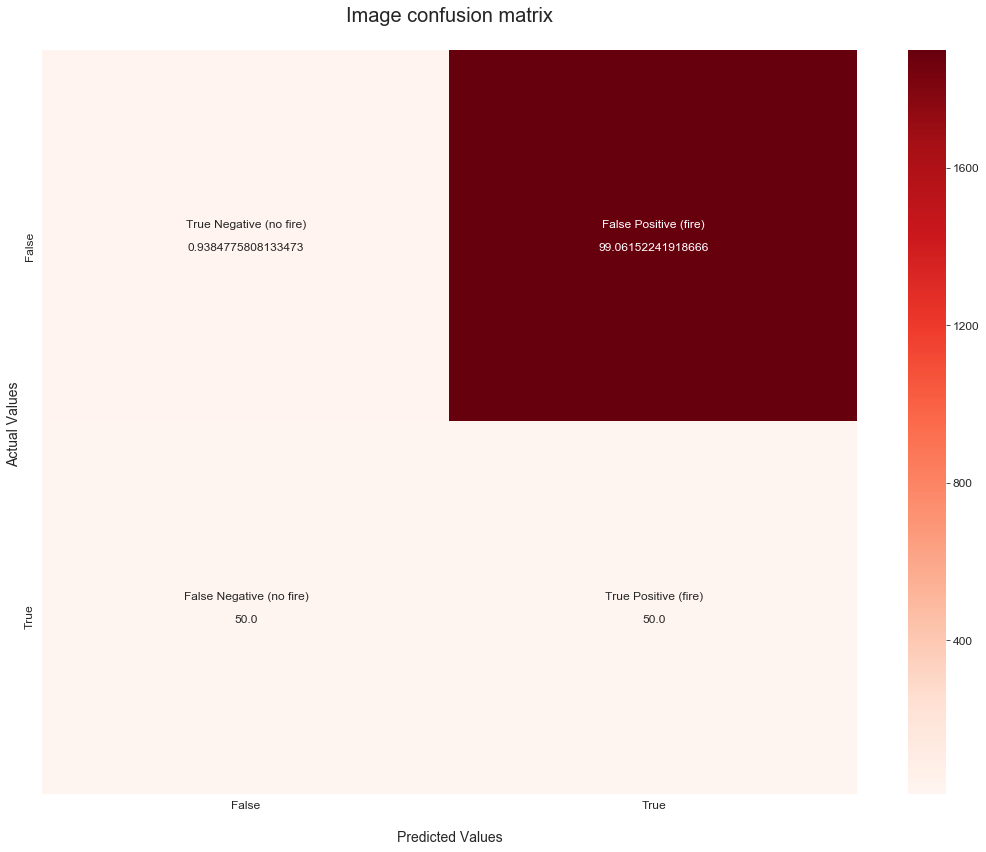

units dropouts optimizers    losses accuracies      aucs precisions  \
33    16      0.6      Nadam  0.935103   0.496124  0.768389   0.496124   

   recalls                                          histories epochs  \
33       1  <keras.callbacks.History object at 0x000002B0B...      8   

   best thresholds  
33        0.186827

61/61 [==============================] - 6s 95ms/step
0.725
[([1], 0.983416), ([1], 0.9645612), ([1], 0.090004206), ([1], 0.16407883), ([1], 0.9542479), ([1], 0.26027784), ([1], 0.94793856), ([1], 0.019242227), ([1], 0.03935346), ([1], 0.80904794)]
[([1], 0.98028946), ([1], 0.46967843), ([1], 0.2304233), ([1], 0.6537165), ([1], 0.95595014), ([1], 0.14115864), ([1], 0.9498724), ([1], 0.014412254), ([1], 0.0814763), ([1], 0.9670399)]


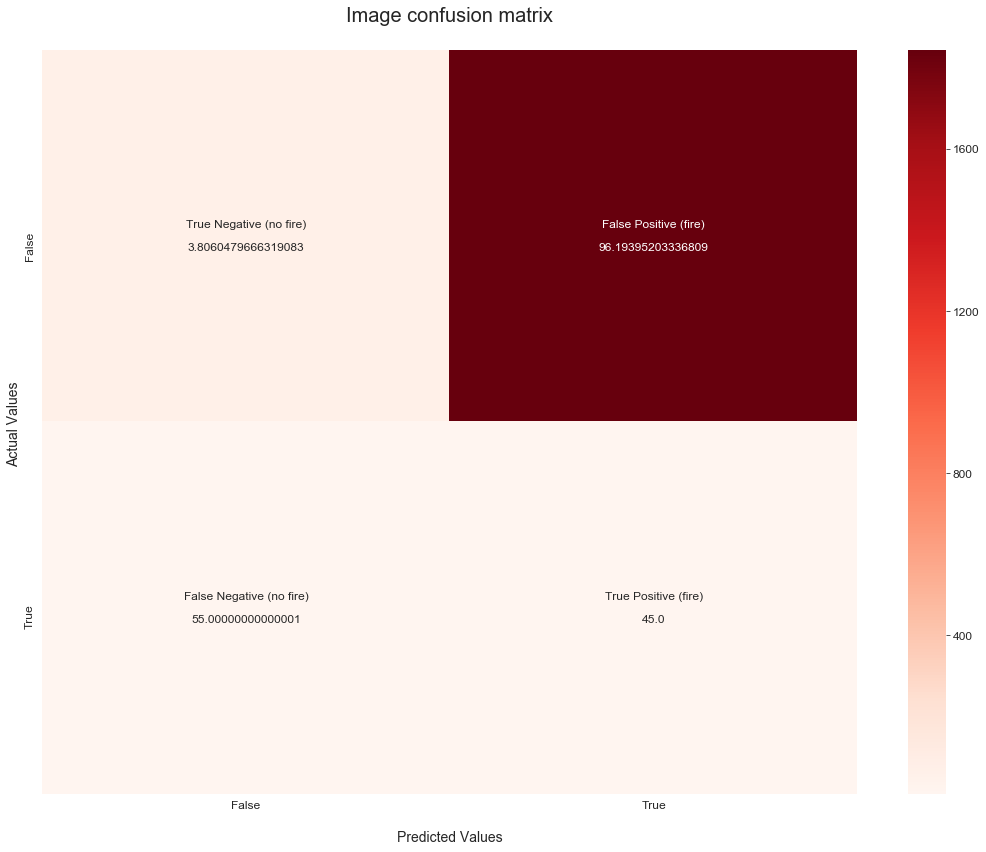

units dropouts optimizers    losses accuracies      aucs precisions  \
33    16      0.6      Nadam  0.935103   0.496124  0.768389   0.496124   

   recalls                                          histories epochs  \
33       1  <keras.callbacks.History object at 0x000002B0B...      8   

   best thresholds  
33        0.186827

61/61 [==============================] - 6s 96ms/step
0.8
[([1], 0.983416), ([1], 0.9645612), ([1], 0.090004206), ([1], 0.16407883), ([1], 0.9542479), ([1], 0.26027784), ([1], 0.94793856), ([1], 0.019242227), ([1], 0.03935346), ([1], 0.80904794)]
[([1], 0.98028946), ([1], 0.46967843), ([1], 0.2304233), ([1], 0.6537165), ([1], 0.95595014), ([1], 0.14115864), ([1], 0.9498724), ([1], 0.014412254), ([1], 0.0814763), ([1], 0.9670399)]


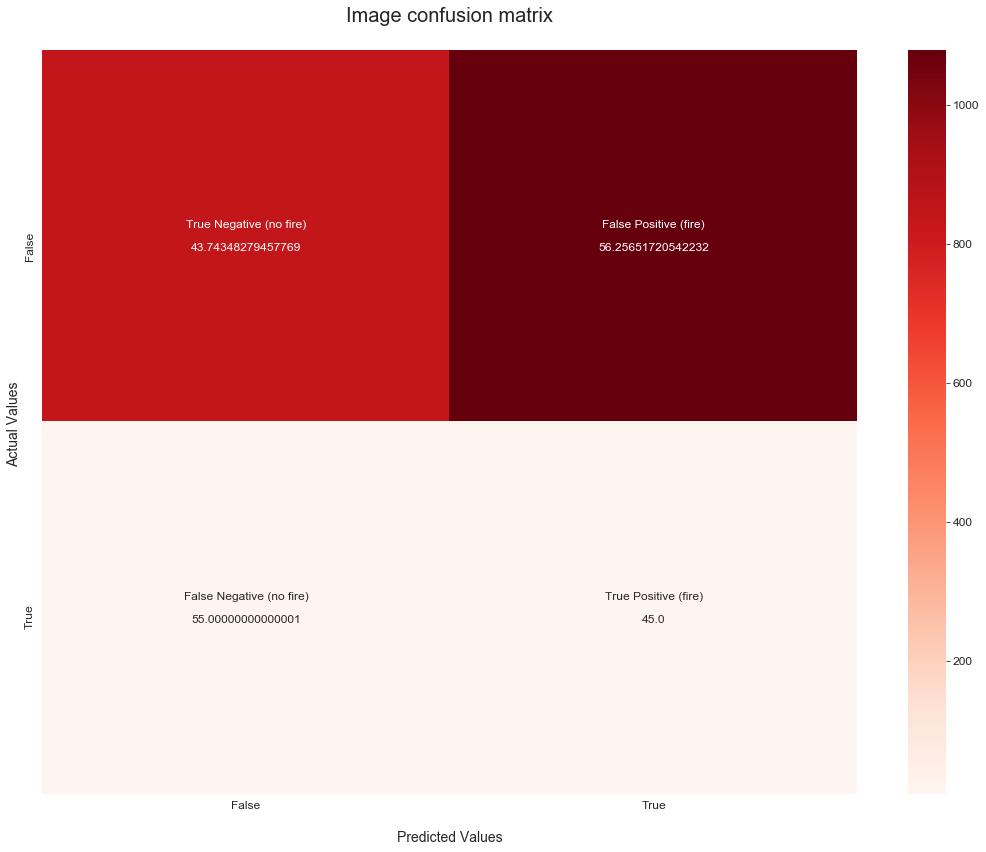

units dropouts optimizers    losses accuracies      aucs precisions  \
33    16      0.6      Nadam  0.935103   0.496124  0.768389   0.496124   

   recalls                                          histories epochs  \
33       1  <keras.callbacks.History object at 0x000002B0B...      8   

   best thresholds  
33        0.186827

61/61 [==============================] - 6s 95ms/step
0.85
[([1], 0.983416), ([1], 0.9645612), ([1], 0.090004206), ([1], 0.16407883), ([1], 0.9542479), ([1], 0.26027784), ([1], 0.94793856), ([1], 0.019242227), ([1], 0.03935346), ([1], 0.80904794)]
[([1], 0.98028946), ([1], 0.46967843), ([1], 0.2304233), ([1], 0.6537165), ([1], 0.95595014), ([1], 0.14115864), ([1], 0.9498724), ([1], 0.014412254), ([1], 0.0814763), ([1], 0.9670399)]


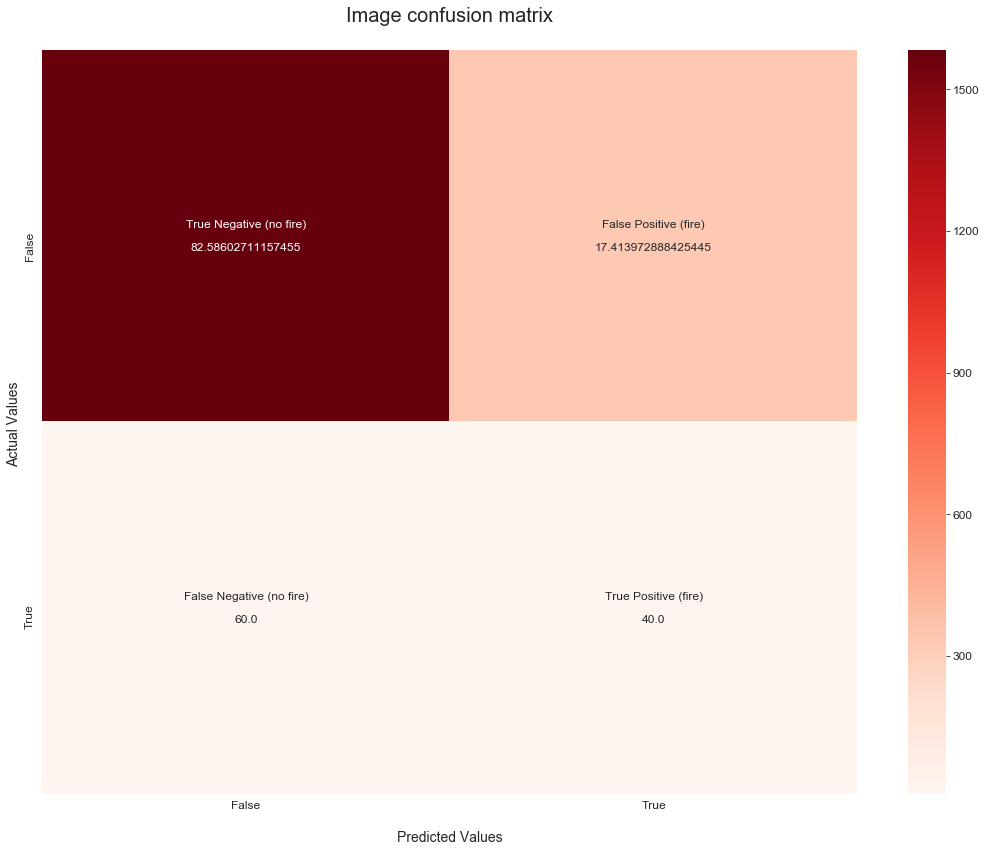

units dropouts optimizers    losses accuracies      aucs precisions  \
33    16      0.6      Nadam  0.935103   0.496124  0.768389   0.496124   

   recalls                                          histories epochs  \
33       1  <keras.callbacks.History object at 0x000002B0B...      8   

   best thresholds  
33        0.186827

61/61 [==============================] - 6s 95ms/step
0.9
[([1], 0.983416), ([1], 0.9645612), ([1], 0.090004206), ([1], 0.16407883), ([1], 0.9542479), ([1], 0.26027784), ([1], 0.94793856), ([1], 0.019242227), ([1], 0.03935346), ([1], 0.80904794)]
[([1], 0.98028946), ([1], 0.46967843), ([1], 0.2304233), ([1], 0.6537165), ([1], 0.95595014), ([1], 0.14115864), ([1], 0.9498724), ([1], 0.014412254), ([1], 0.0814763), ([1], 0.9670399)]


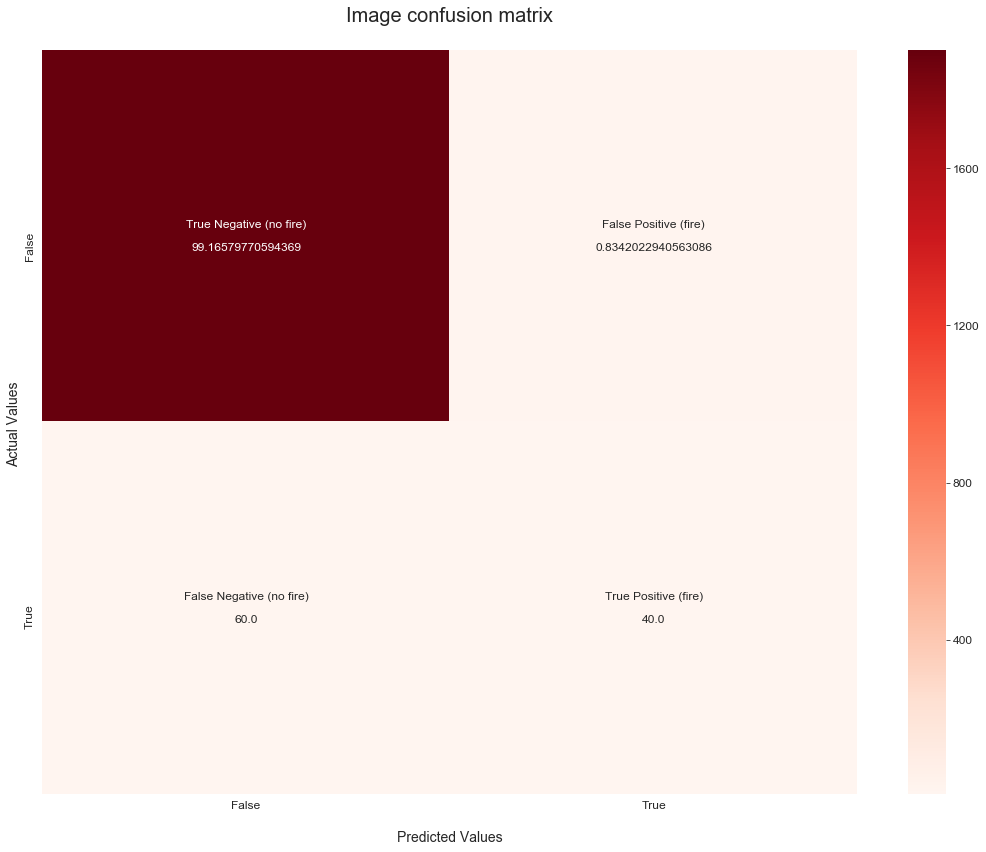

units dropouts optimizers    losses accuracies      aucs precisions  \
33    16      0.6      Nadam  0.935103   0.496124  0.768389   0.496124   

   recalls                                          histories epochs  \
33       1  <keras.callbacks.History object at 0x000002B0B...      8   

   best thresholds  
33        0.186827

61/61 [==============================] - 6s 96ms/step
0.95
[([1], 0.983416), ([1], 0.9645612), ([1], 0.090004206), ([1], 0.16407883), ([1], 0.9542479), ([1], 0.26027784), ([1], 0.94793856), ([1], 0.019242227), ([1], 0.03935346), ([1], 0.80904794)]
[([1], 0.98028946), ([1], 0.46967843), ([1], 0.2304233), ([1], 0.6537165), ([1], 0.95595014), ([1], 0.14115864), ([1], 0.9498724), ([1], 0.014412254), ([1], 0.0814763), ([1], 0.9670399)]


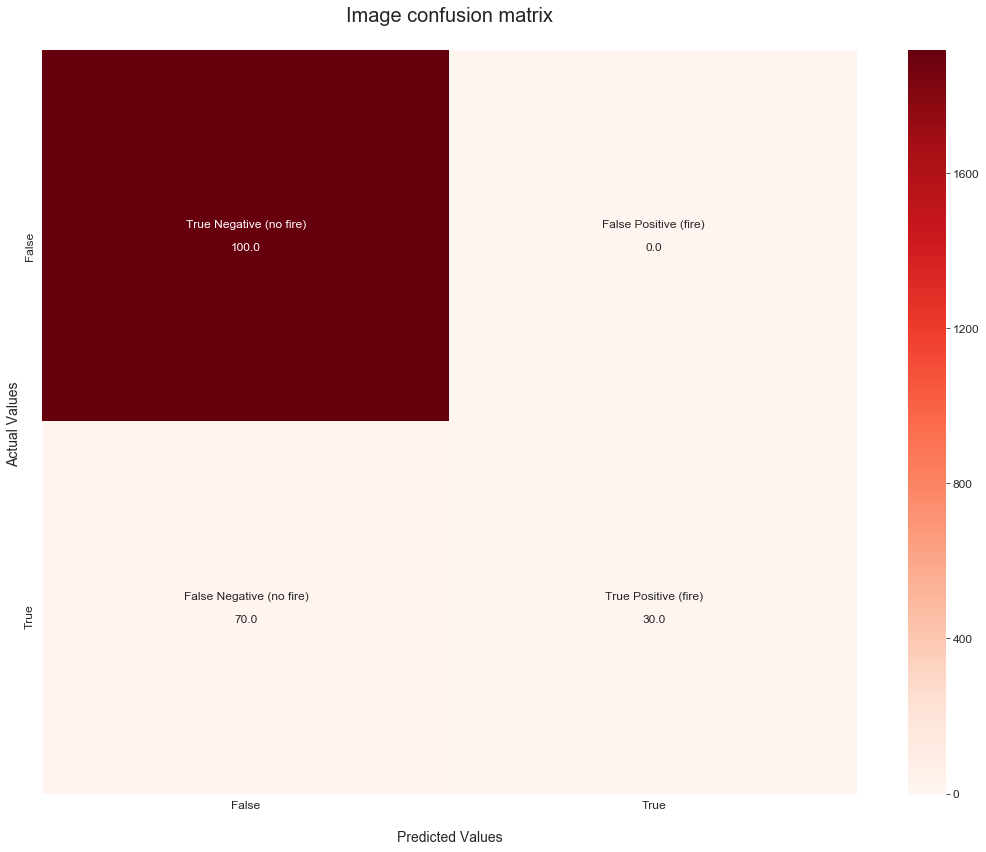

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
34    16      0.6    RMSprop  1.21853   0.503876  0.784495          0       0   

                                            histories epochs best thresholds  
34  <keras.callbacks.History object at 0x000002B0B...      8        0.907105

61/61 [==============================] - 7s 97ms/step
0.1
[([1], 0.918486), ([1], 0.7899066), ([1], 0.004762262), ([1], 0.0002962947), ([1], 0.95194453), ([1], 1.536429e-05), ([1], 0.9807905), ([1], 0.0015554428), ([1], 0.016786426), ([1], 0.70601296)]
[([1], 0.594918), ([1], 0.040518135), ([1], 0.015211582), ([1], 0.01120612), ([1], 0.9680109), ([1], 4.2284348e-05), ([1], 0.9328885), ([1], 0.0014341176), ([1], 0.011783242), ([1], 0.64235705)]


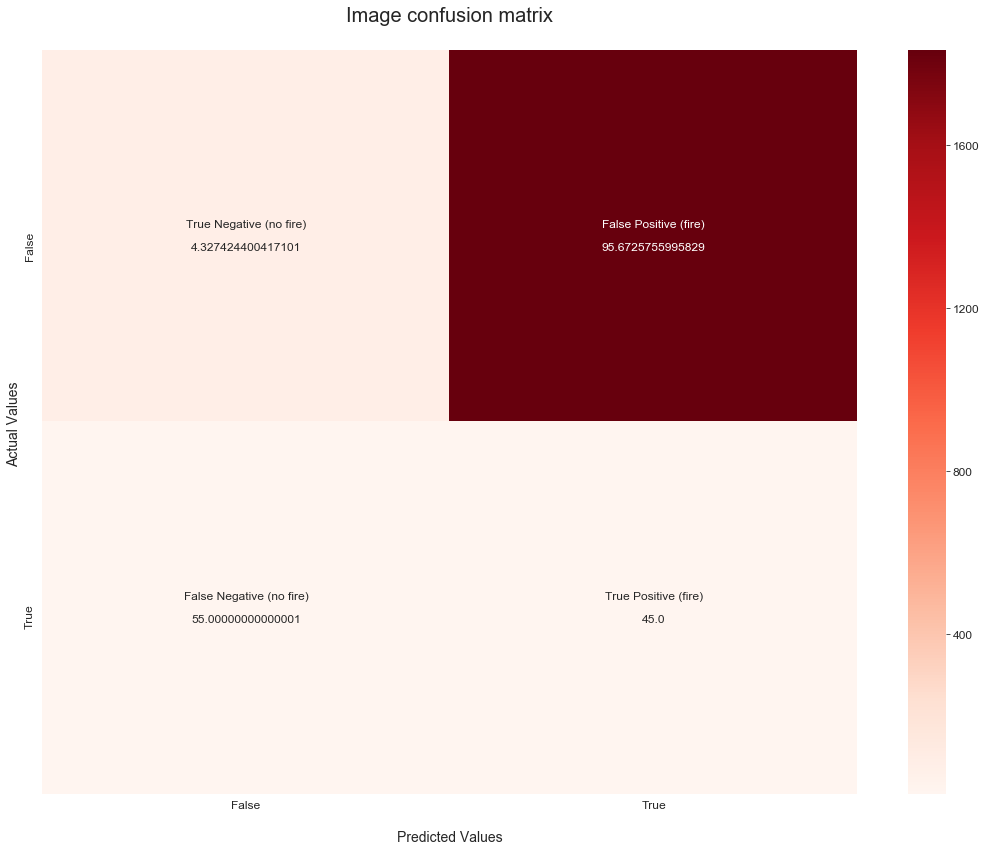

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
34    16      0.6    RMSprop  1.21853   0.503876  0.784495          0       0   

                                            histories epochs best thresholds  
34  <keras.callbacks.History object at 0x000002B0B...      8        0.907105

61/61 [==============================] - 6s 97ms/step
0.3
[([1], 0.918486), ([1], 0.7899066), ([1], 0.004762262), ([1], 0.0002962947), ([1], 0.95194453), ([1], 1.536429e-05), ([1], 0.9807905), ([1], 0.0015554428), ([1], 0.016786426), ([1], 0.70601296)]
[([1], 0.594918), ([1], 0.040518135), ([1], 0.015211582), ([1], 0.01120612), ([1], 0.9680109), ([1], 4.2284348e-05), ([1], 0.9328885), ([1], 0.0014341176), ([1], 0.011783242), ([1], 0.64235705)]


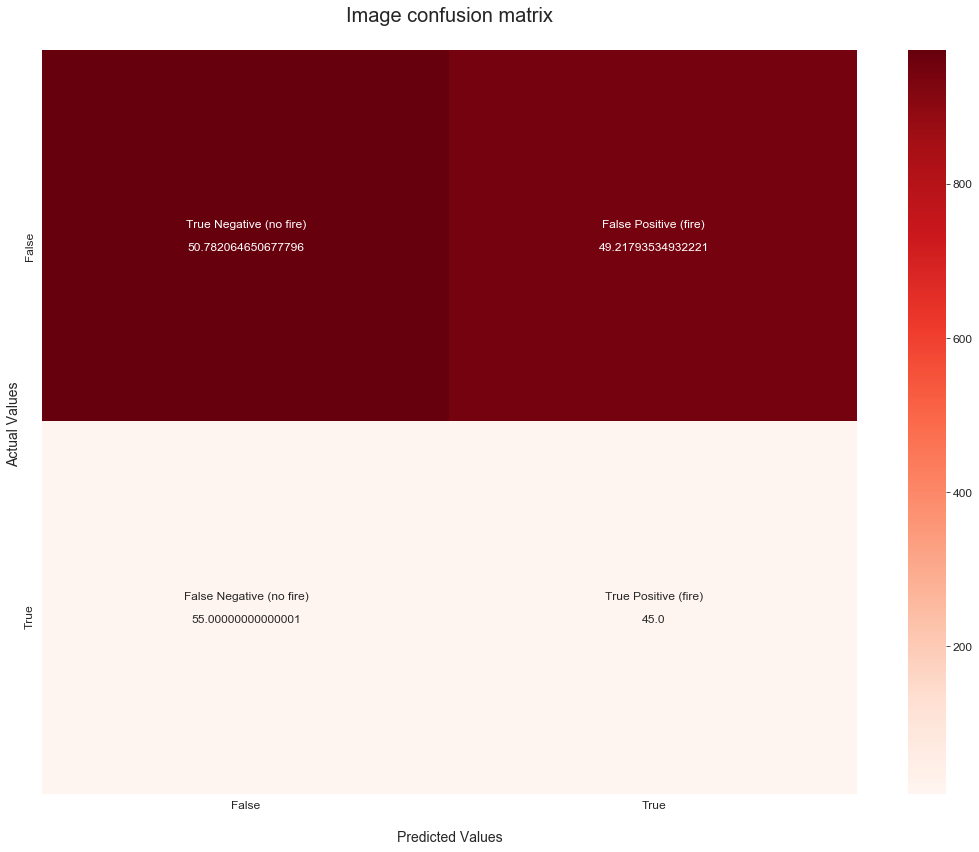

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
34    16      0.6    RMSprop  1.21853   0.503876  0.784495          0       0   

                                            histories epochs best thresholds  
34  <keras.callbacks.History object at 0x000002B0B...      8        0.907105

61/61 [==============================] - 6s 97ms/step
0.5
[([1], 0.918486), ([1], 0.7899066), ([1], 0.004762262), ([1], 0.0002962947), ([1], 0.95194453), ([1], 1.536429e-05), ([1], 0.9807905), ([1], 0.0015554428), ([1], 0.016786426), ([1], 0.70601296)]
[([1], 0.594918), ([1], 0.040518135), ([1], 0.015211582), ([1], 0.01120612), ([1], 0.9680109), ([1], 4.2284348e-05), ([1], 0.9328885), ([1], 0.0014341176), ([1], 0.011783242), ([1], 0.64235705)]


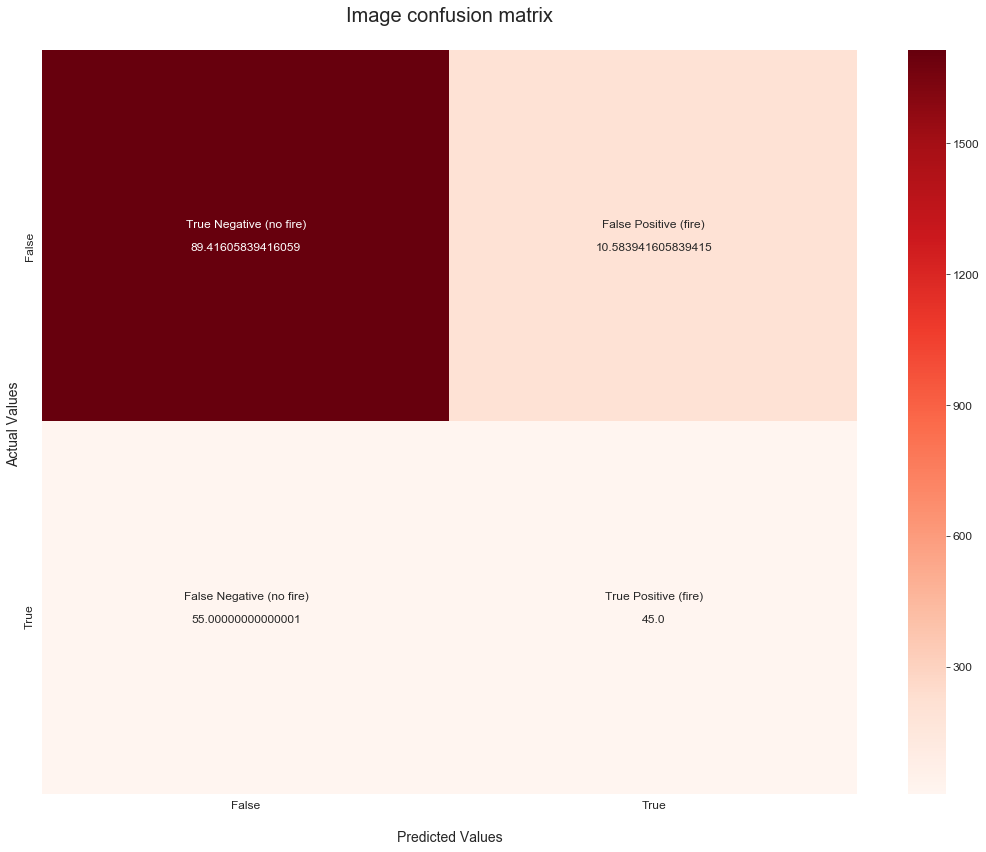

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
34    16      0.6    RMSprop  1.21853   0.503876  0.784495          0       0   

                                            histories epochs best thresholds  
34  <keras.callbacks.History object at 0x000002B0B...      8        0.907105

61/61 [==============================] - 6s 96ms/step
0.65
[([1], 0.918486), ([1], 0.7899066), ([1], 0.004762262), ([1], 0.0002962947), ([1], 0.95194453), ([1], 1.536429e-05), ([1], 0.9807905), ([1], 0.0015554428), ([1], 0.016786426), ([1], 0.70601296)]
[([1], 0.594918), ([1], 0.040518135), ([1], 0.015211582), ([1], 0.01120612), ([1], 0.9680109), ([1], 4.2284348e-05), ([1], 0.9328885), ([1], 0.0014341176), ([1], 0.011783242), ([1], 0.64235705)]


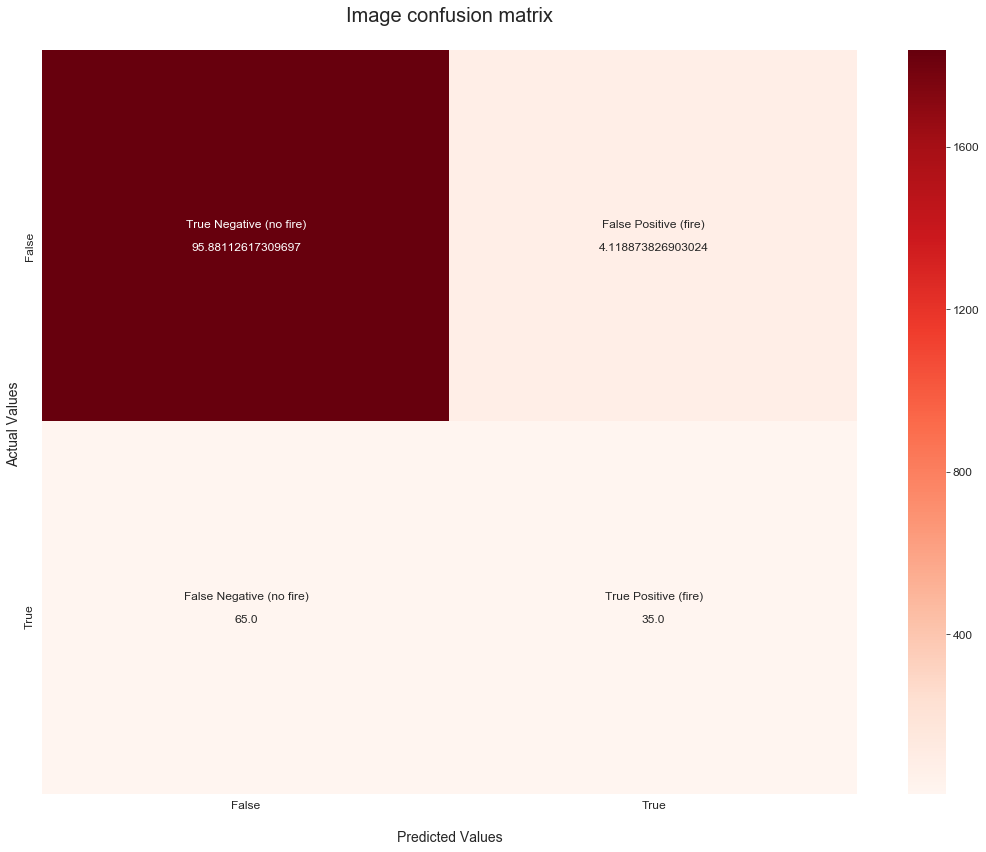

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
34    16      0.6    RMSprop  1.21853   0.503876  0.784495          0       0   

                                            histories epochs best thresholds  
34  <keras.callbacks.History object at 0x000002B0B...      8        0.907105

61/61 [==============================] - 6s 96ms/step
0.725
[([1], 0.918486), ([1], 0.7899066), ([1], 0.004762262), ([1], 0.0002962947), ([1], 0.95194453), ([1], 1.536429e-05), ([1], 0.9807905), ([1], 0.0015554428), ([1], 0.016786426), ([1], 0.70601296)]
[([1], 0.594918), ([1], 0.040518135), ([1], 0.015211582), ([1], 0.01120612), ([1], 0.9680109), ([1], 4.2284348e-05), ([1], 0.9328885), ([1], 0.0014341176), ([1], 0.011783242), ([1], 0.64235705)]


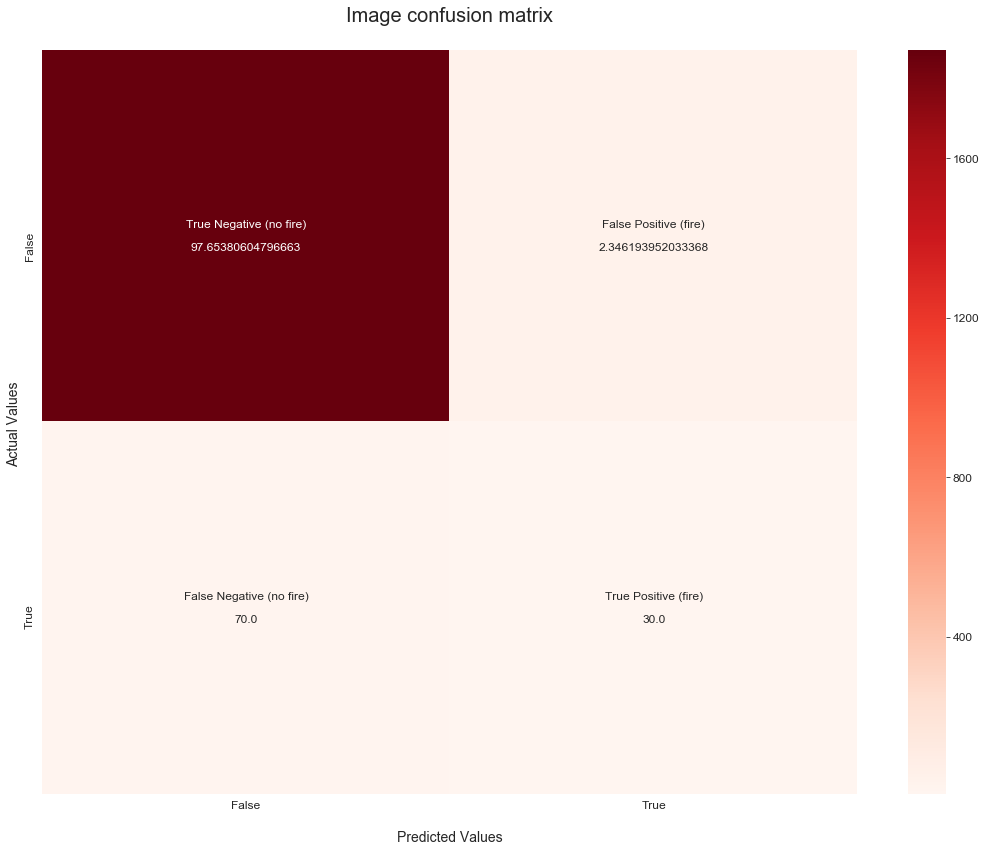

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
34    16      0.6    RMSprop  1.21853   0.503876  0.784495          0       0   

                                            histories epochs best thresholds  
34  <keras.callbacks.History object at 0x000002B0B...      8        0.907105

61/61 [==============================] - 6s 96ms/step
0.8
[([1], 0.918486), ([1], 0.7899066), ([1], 0.004762262), ([1], 0.0002962947), ([1], 0.95194453), ([1], 1.536429e-05), ([1], 0.9807905), ([1], 0.0015554428), ([1], 0.016786426), ([1], 0.70601296)]
[([1], 0.594918), ([1], 0.040518135), ([1], 0.015211582), ([1], 0.01120612), ([1], 0.9680109), ([1], 4.2284348e-05), ([1], 0.9328885), ([1], 0.0014341176), ([1], 0.011783242), ([1], 0.64235705)]


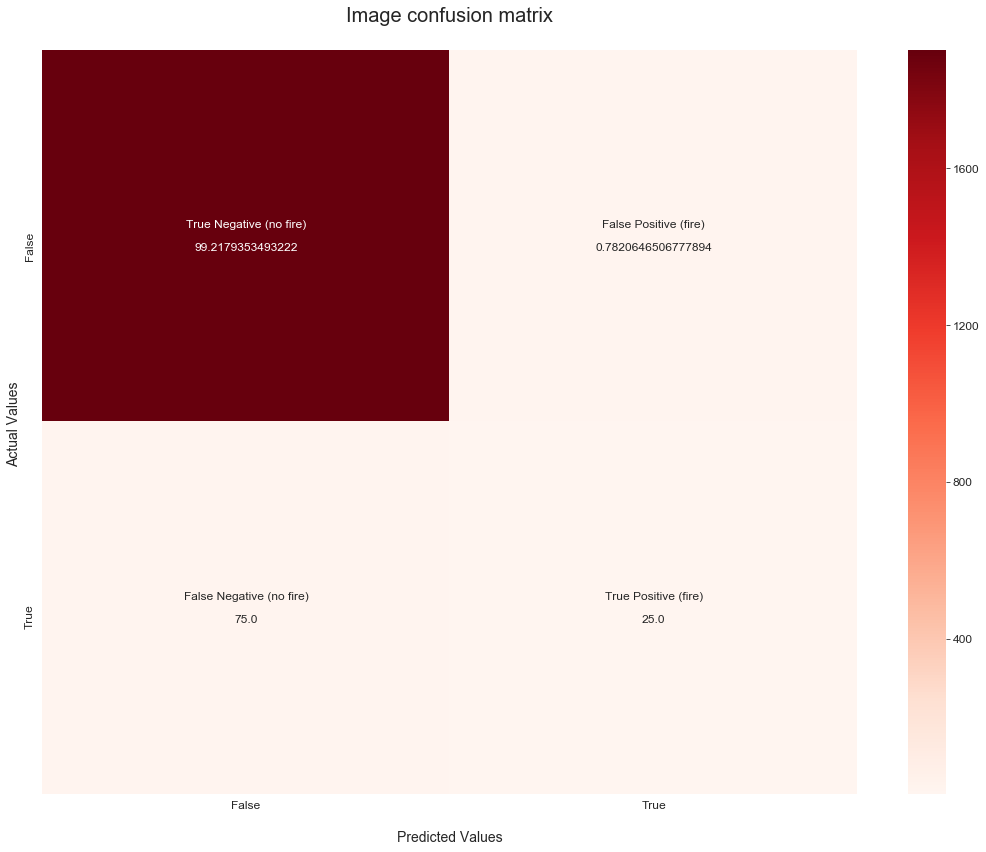

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
34    16      0.6    RMSprop  1.21853   0.503876  0.784495          0       0   

                                            histories epochs best thresholds  
34  <keras.callbacks.History object at 0x000002B0B...      8        0.907105

61/61 [==============================] - 6s 95ms/step
0.85
[([1], 0.918486), ([1], 0.7899066), ([1], 0.004762262), ([1], 0.0002962947), ([1], 0.95194453), ([1], 1.536429e-05), ([1], 0.9807905), ([1], 0.0015554428), ([1], 0.016786426), ([1], 0.70601296)]
[([1], 0.594918), ([1], 0.040518135), ([1], 0.015211582), ([1], 0.01120612), ([1], 0.9680109), ([1], 4.2284348e-05), ([1], 0.9328885), ([1], 0.0014341176), ([1], 0.011783242), ([1], 0.64235705)]


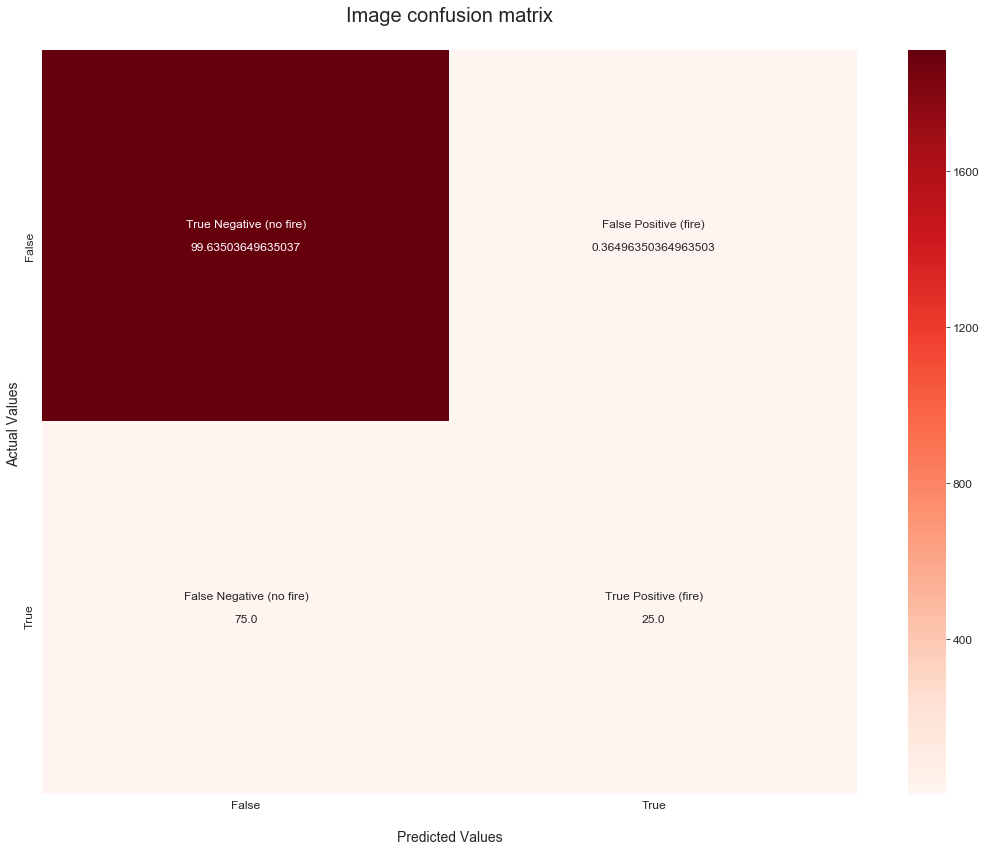

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
34    16      0.6    RMSprop  1.21853   0.503876  0.784495          0       0   

                                            histories epochs best thresholds  
34  <keras.callbacks.History object at 0x000002B0B...      8        0.907105

61/61 [==============================] - 6s 96ms/step
0.9
[([1], 0.918486), ([1], 0.7899066), ([1], 0.004762262), ([1], 0.0002962947), ([1], 0.95194453), ([1], 1.536429e-05), ([1], 0.9807905), ([1], 0.0015554428), ([1], 0.016786426), ([1], 0.70601296)]
[([1], 0.594918), ([1], 0.040518135), ([1], 0.015211582), ([1], 0.01120612), ([1], 0.9680109), ([1], 4.2284348e-05), ([1], 0.9328885), ([1], 0.0014341176), ([1], 0.011783242), ([1], 0.64235705)]


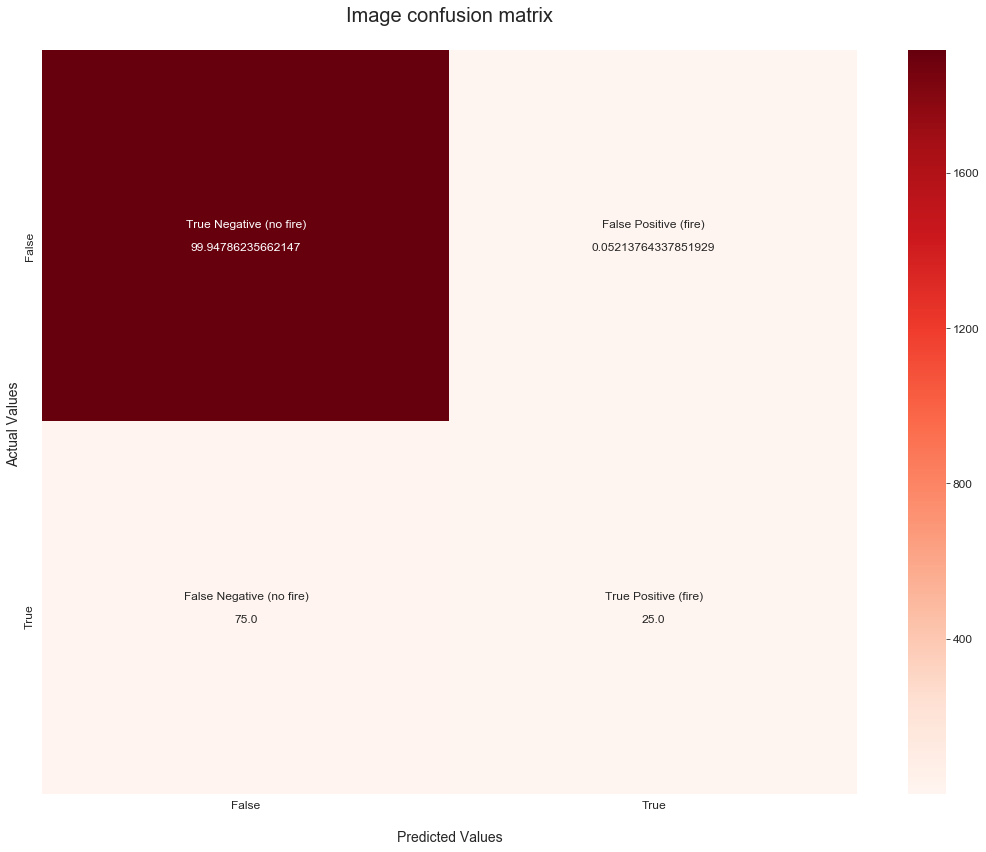

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
34    16      0.6    RMSprop  1.21853   0.503876  0.784495          0       0   

                                            histories epochs best thresholds  
34  <keras.callbacks.History object at 0x000002B0B...      8        0.907105

61/61 [==============================] - 6s 95ms/step
0.95
[([1], 0.918486), ([1], 0.7899066), ([1], 0.004762262), ([1], 0.0002962947), ([1], 0.95194453), ([1], 1.536429e-05), ([1], 0.9807905), ([1], 0.0015554428), ([1], 0.016786426), ([1], 0.70601296)]
[([1], 0.594918), ([1], 0.040518135), ([1], 0.015211582), ([1], 0.01120612), ([1], 0.9680109), ([1], 4.2284348e-05), ([1], 0.9328885), ([1], 0.0014341176), ([1], 0.011783242), ([1], 0.64235705)]


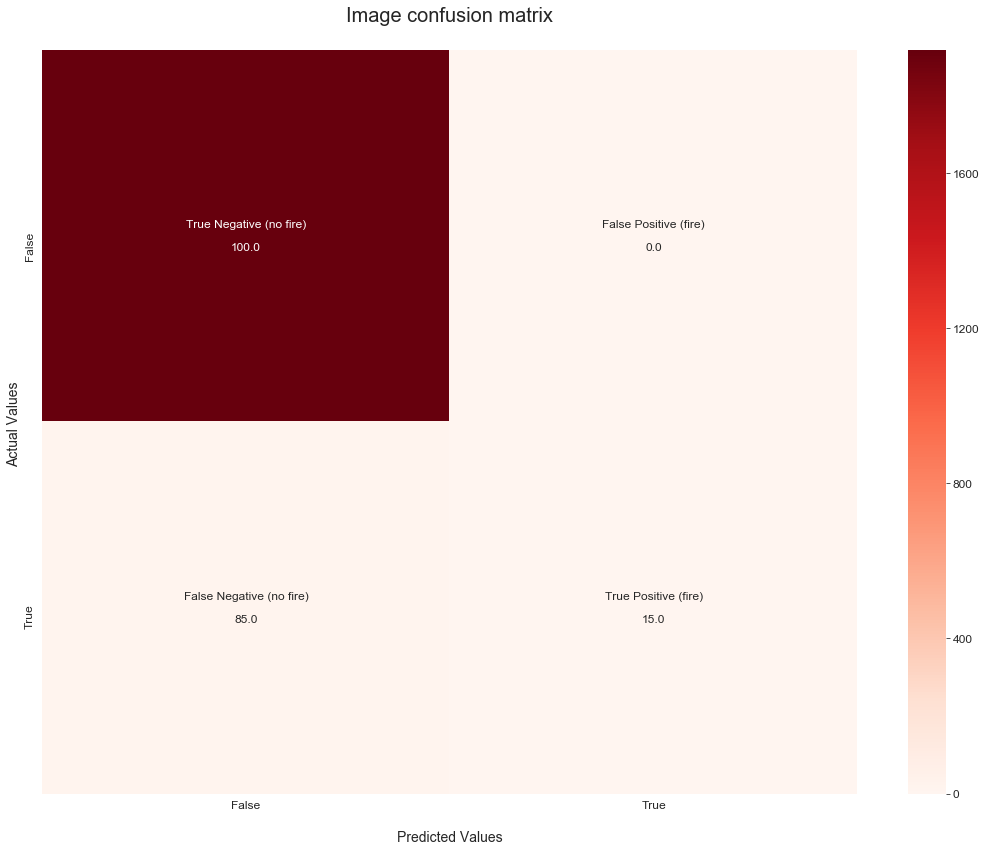

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
35    16      0.6       adam  1.23565   0.496124  0.771995   0.496124       1   

                                            histories epochs best thresholds  
35  <keras.callbacks.History object at 0x000002B0B...      9        0.088776

61/61 [==============================] - 6s 95ms/step
0.1
[([1], 0.69711894), ([1], 0.11690131), ([1], 0.0013484955), ([1], 0.024982095), ([1], 0.826611), ([1], 0.027346194), ([1], 0.61470455), ([1], 0.0011264384), ([1], 0.029647082), ([1], 0.84688723)]
[([1], 0.7365668), ([1], 0.030175269), ([1], 0.002509445), ([1], 0.023280174), ([1], 0.79268), ([1], 0.028027385), ([1], 0.66916025), ([1], 0.001534909), ([1], 0.023238182), ([1], 0.87711596)]


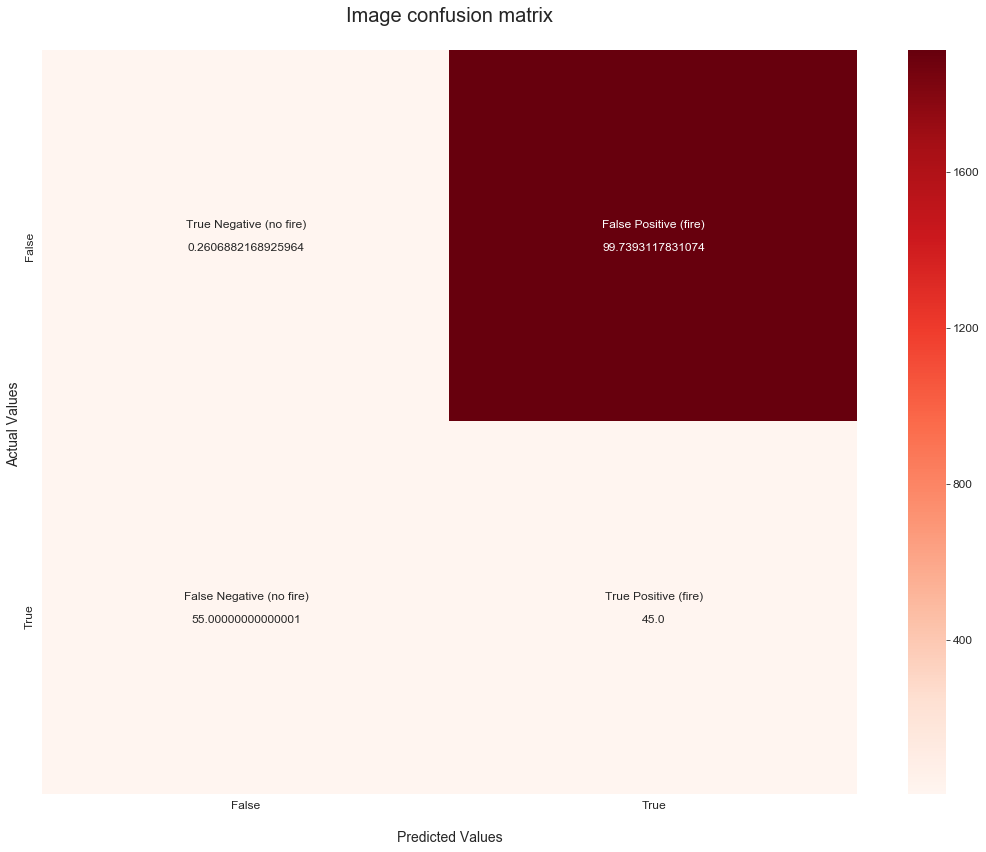

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
35    16      0.6       adam  1.23565   0.496124  0.771995   0.496124       1   

                                            histories epochs best thresholds  
35  <keras.callbacks.History object at 0x000002B0B...      9        0.088776

61/61 [==============================] - 6s 98ms/step
0.3
[([1], 0.69711894), ([1], 0.11690131), ([1], 0.0013484955), ([1], 0.024982095), ([1], 0.826611), ([1], 0.027346194), ([1], 0.61470455), ([1], 0.0011264384), ([1], 0.029647082), ([1], 0.84688723)]
[([1], 0.7365668), ([1], 0.030175269), ([1], 0.002509445), ([1], 0.023280174), ([1], 0.79268), ([1], 0.028027385), ([1], 0.66916025), ([1], 0.001534909), ([1], 0.023238182), ([1], 0.87711596)]


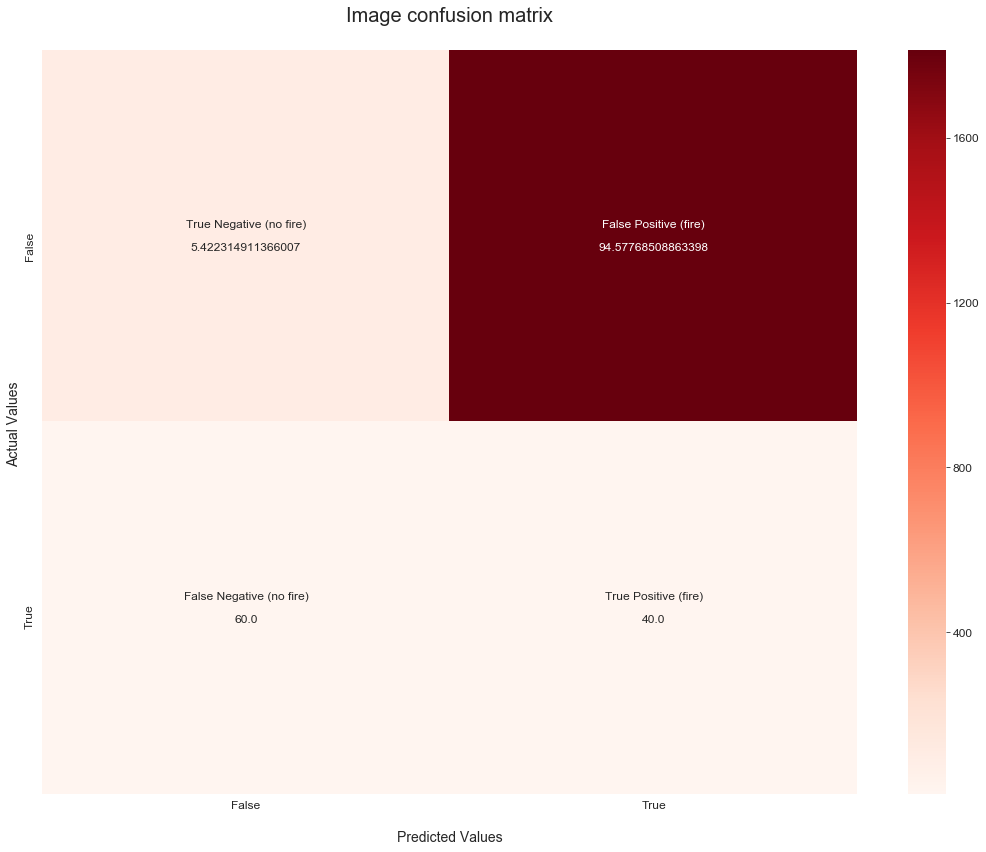

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
35    16      0.6       adam  1.23565   0.496124  0.771995   0.496124       1   

                                            histories epochs best thresholds  
35  <keras.callbacks.History object at 0x000002B0B...      9        0.088776

61/61 [==============================] - 6s 96ms/step
0.5
[([1], 0.69711894), ([1], 0.11690131), ([1], 0.0013484955), ([1], 0.024982095), ([1], 0.826611), ([1], 0.027346194), ([1], 0.61470455), ([1], 0.0011264384), ([1], 0.029647082), ([1], 0.84688723)]
[([1], 0.7365668), ([1], 0.030175269), ([1], 0.002509445), ([1], 0.023280174), ([1], 0.79268), ([1], 0.028027385), ([1], 0.66916025), ([1], 0.001534909), ([1], 0.023238182), ([1], 0.87711596)]


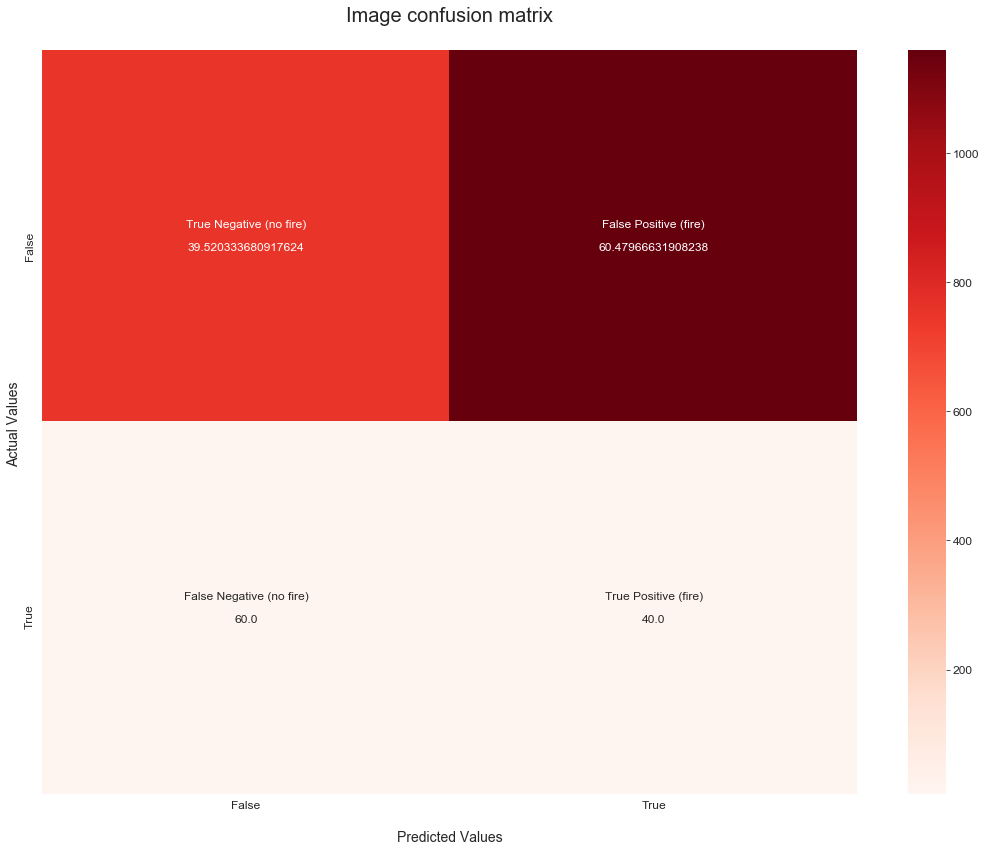

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
35    16      0.6       adam  1.23565   0.496124  0.771995   0.496124       1   

                                            histories epochs best thresholds  
35  <keras.callbacks.History object at 0x000002B0B...      9        0.088776

61/61 [==============================] - 6s 95ms/step
0.65
[([1], 0.69711894), ([1], 0.11690131), ([1], 0.0013484955), ([1], 0.024982095), ([1], 0.826611), ([1], 0.027346194), ([1], 0.61470455), ([1], 0.0011264384), ([1], 0.029647082), ([1], 0.84688723)]
[([1], 0.7365668), ([1], 0.030175269), ([1], 0.002509445), ([1], 0.023280174), ([1], 0.79268), ([1], 0.028027385), ([1], 0.66916025), ([1], 0.001534909), ([1], 0.023238182), ([1], 0.87711596)]


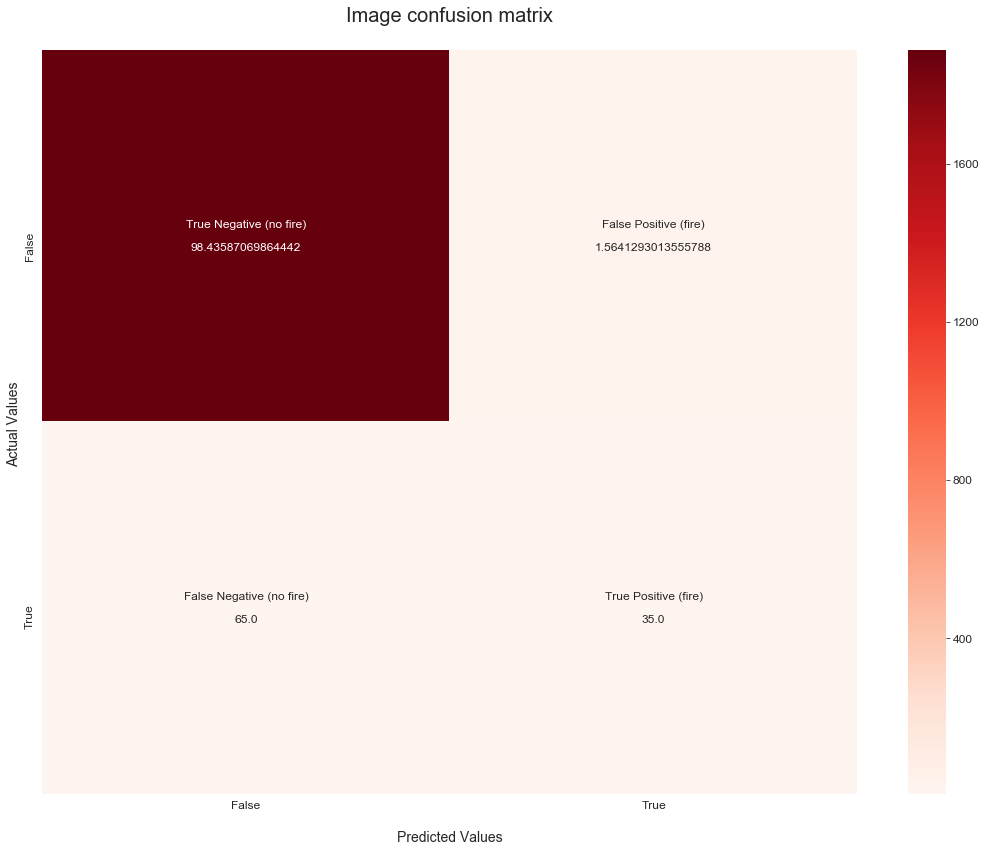

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
35    16      0.6       adam  1.23565   0.496124  0.771995   0.496124       1   

                                            histories epochs best thresholds  
35  <keras.callbacks.History object at 0x000002B0B...      9        0.088776

61/61 [==============================] - 6s 96ms/step
0.725
[([1], 0.69711894), ([1], 0.11690131), ([1], 0.0013484955), ([1], 0.024982095), ([1], 0.826611), ([1], 0.027346194), ([1], 0.61470455), ([1], 0.0011264384), ([1], 0.029647082), ([1], 0.84688723)]
[([1], 0.7365668), ([1], 0.030175269), ([1], 0.002509445), ([1], 0.023280174), ([1], 0.79268), ([1], 0.028027385), ([1], 0.66916025), ([1], 0.001534909), ([1], 0.023238182), ([1], 0.87711596)]


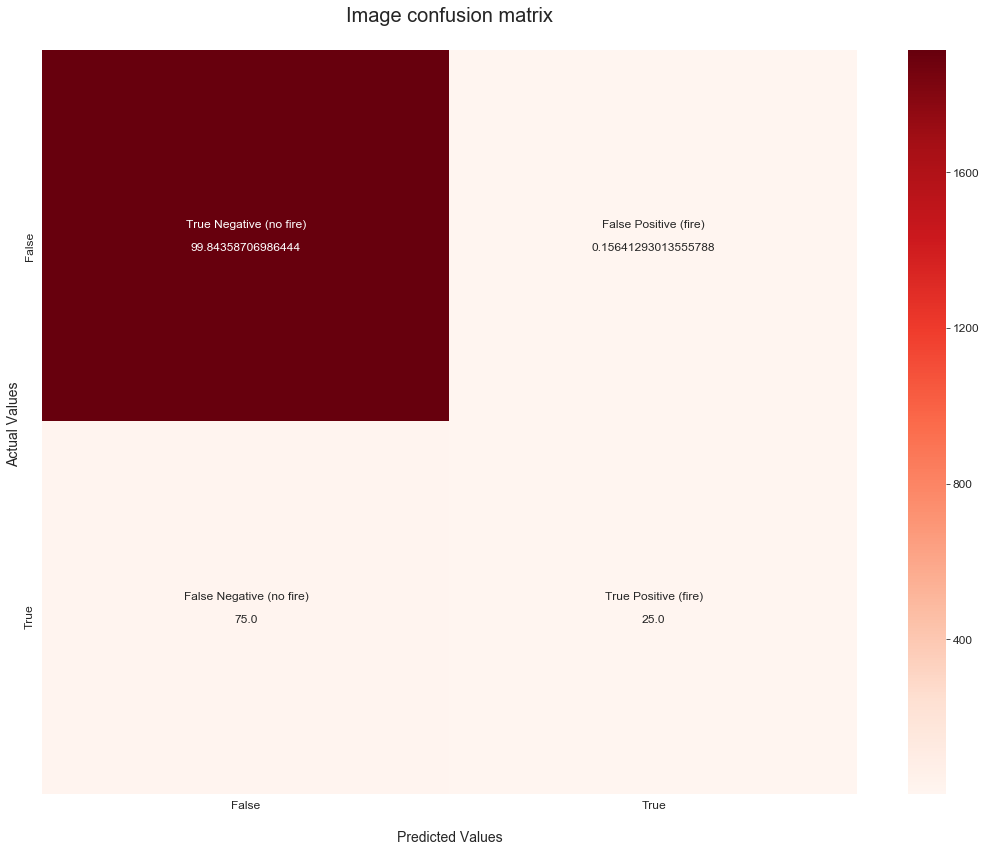

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
35    16      0.6       adam  1.23565   0.496124  0.771995   0.496124       1   

                                            histories epochs best thresholds  
35  <keras.callbacks.History object at 0x000002B0B...      9        0.088776

61/61 [==============================] - 6s 95ms/step
0.8
[([1], 0.69711894), ([1], 0.11690131), ([1], 0.0013484955), ([1], 0.024982095), ([1], 0.826611), ([1], 0.027346194), ([1], 0.61470455), ([1], 0.0011264384), ([1], 0.029647082), ([1], 0.84688723)]
[([1], 0.7365668), ([1], 0.030175269), ([1], 0.002509445), ([1], 0.023280174), ([1], 0.79268), ([1], 0.028027385), ([1], 0.66916025), ([1], 0.001534909), ([1], 0.023238182), ([1], 0.87711596)]


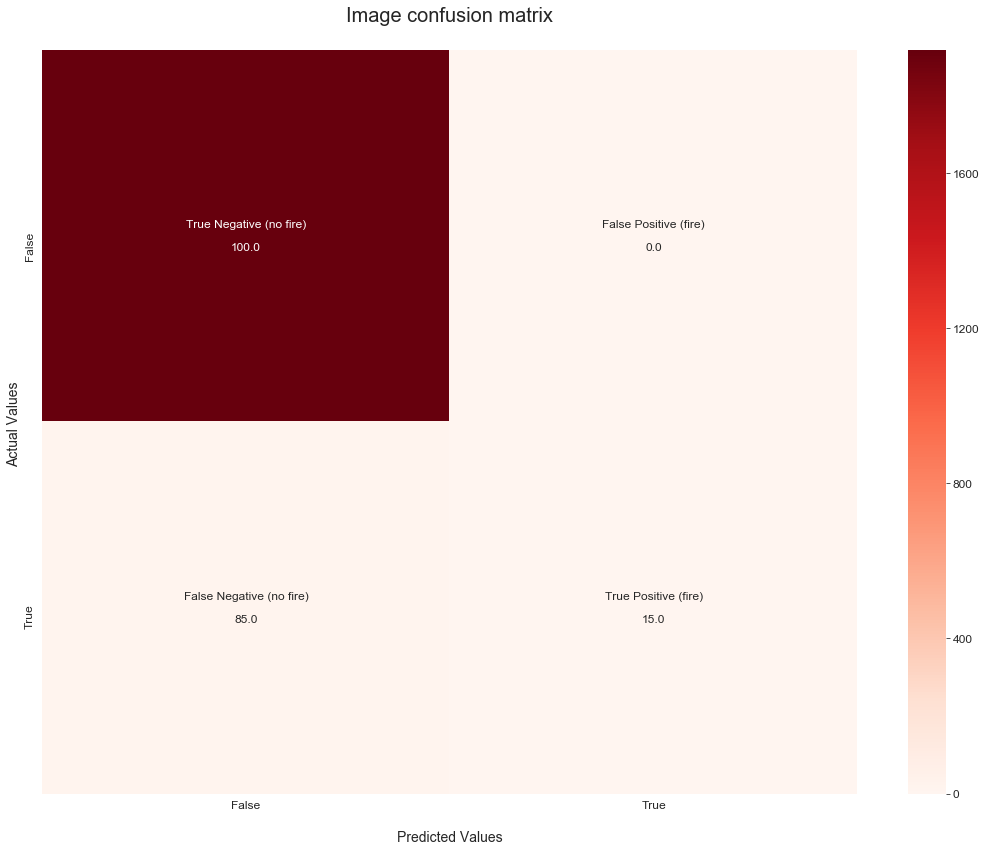

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
35    16      0.6       adam  1.23565   0.496124  0.771995   0.496124       1   

                                            histories epochs best thresholds  
35  <keras.callbacks.History object at 0x000002B0B...      9        0.088776

61/61 [==============================] - 6s 97ms/step
0.85
[([1], 0.69711894), ([1], 0.11690131), ([1], 0.0013484955), ([1], 0.024982095), ([1], 0.826611), ([1], 0.027346194), ([1], 0.61470455), ([1], 0.0011264384), ([1], 0.029647082), ([1], 0.84688723)]
[([1], 0.7365668), ([1], 0.030175269), ([1], 0.002509445), ([1], 0.023280174), ([1], 0.79268), ([1], 0.028027385), ([1], 0.66916025), ([1], 0.001534909), ([1], 0.023238182), ([1], 0.87711596)]


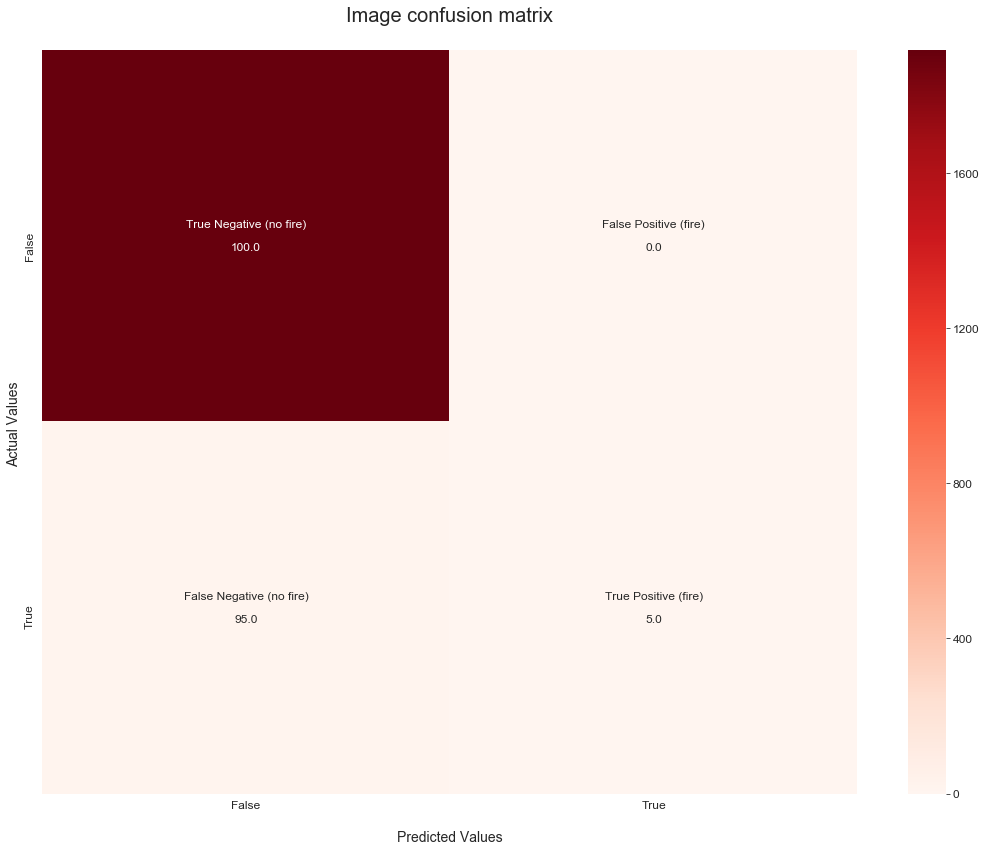

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
35    16      0.6       adam  1.23565   0.496124  0.771995   0.496124       1   

                                            histories epochs best thresholds  
35  <keras.callbacks.History object at 0x000002B0B...      9        0.088776

61/61 [==============================] - 6s 95ms/step
0.9
[([1], 0.69711894), ([1], 0.11690131), ([1], 0.0013484955), ([1], 0.024982095), ([1], 0.826611), ([1], 0.027346194), ([1], 0.61470455), ([1], 0.0011264384), ([1], 0.029647082), ([1], 0.84688723)]
[([1], 0.7365668), ([1], 0.030175269), ([1], 0.002509445), ([1], 0.023280174), ([1], 0.79268), ([1], 0.028027385), ([1], 0.66916025), ([1], 0.001534909), ([1], 0.023238182), ([1], 0.87711596)]


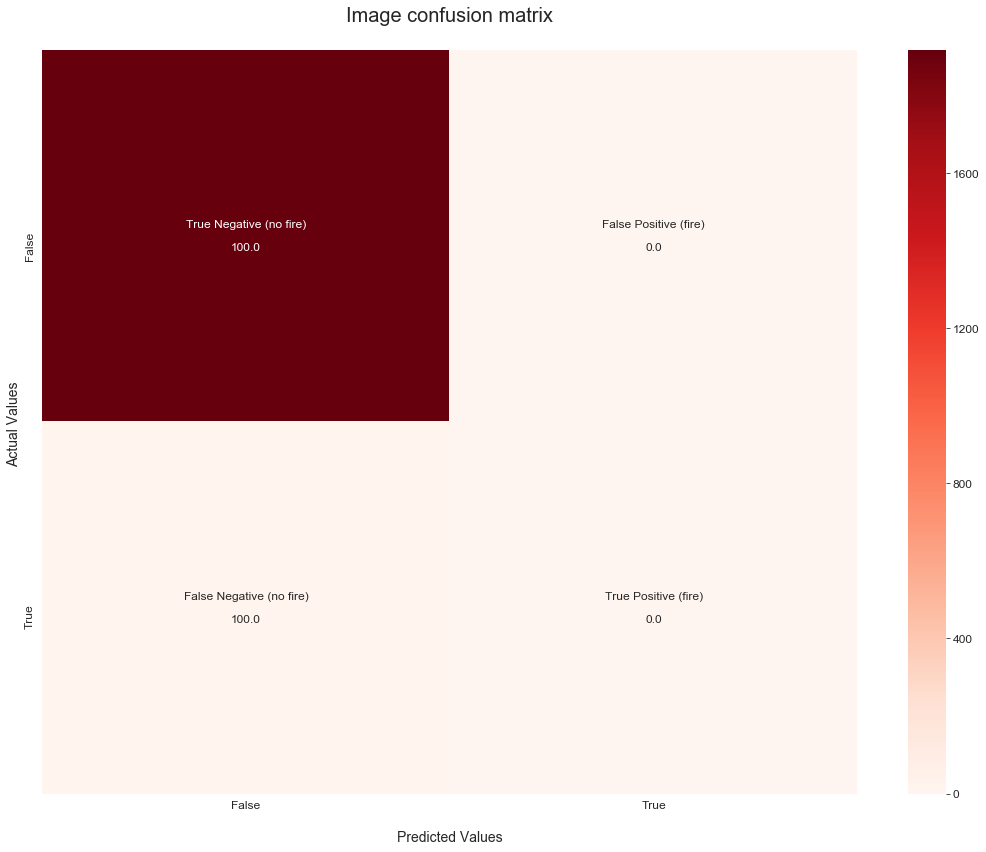

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
35    16      0.6       adam  1.23565   0.496124  0.771995   0.496124       1   

                                            histories epochs best thresholds  
35  <keras.callbacks.History object at 0x000002B0B...      9        0.088776

61/61 [==============================] - 6s 96ms/step
0.95
[([1], 0.69711894), ([1], 0.11690131), ([1], 0.0013484955), ([1], 0.024982095), ([1], 0.826611), ([1], 0.027346194), ([1], 0.61470455), ([1], 0.0011264384), ([1], 0.029647082), ([1], 0.84688723)]
[([1], 0.7365668), ([1], 0.030175269), ([1], 0.002509445), ([1], 0.023280174), ([1], 0.79268), ([1], 0.028027385), ([1], 0.66916025), ([1], 0.001534909), ([1], 0.023238182), ([1], 0.87711596)]


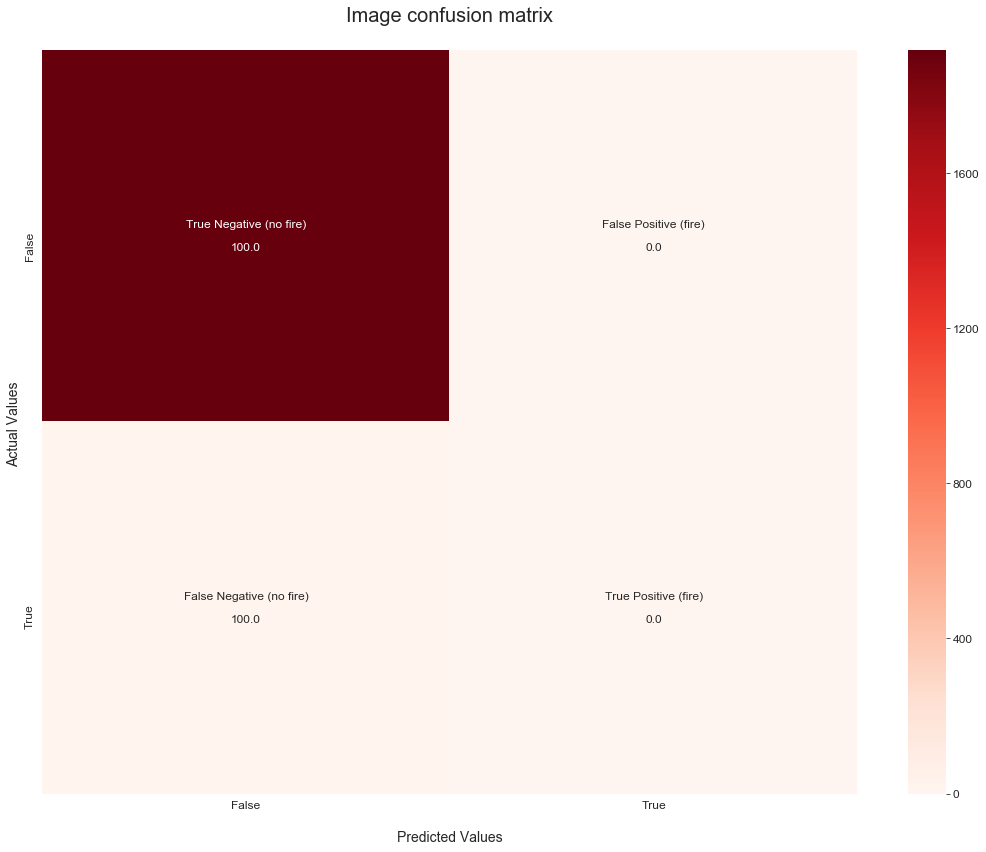

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
36    16      0.6      Nadam  0.72858   0.503876  0.406611          0       0   

                                            histories epochs best thresholds  
36  <keras.callbacks.History object at 0x000002B0B...      9        0.631201

61/61 [==============================] - 6s 96ms/step
0.1
[([1], 0.67141473), ([1], 0.5362451), ([1], 0.023398697), ([1], 0.46377423), ([1], 0.552676), ([1], 0.13031611), ([1], 0.46377423), ([1], 0.037081927), ([1], 0.18918502), ([1], 0.6667457)]
[([1], 0.6666765), ([1], 0.24850744), ([1], 0.02400741), ([1], 0.11727396), ([1], 0.54583156), ([1], 0.09495452), ([1], 0.46377423), ([1], 0.037662417), ([1], 0.076986164), ([1], 0.6890388)]


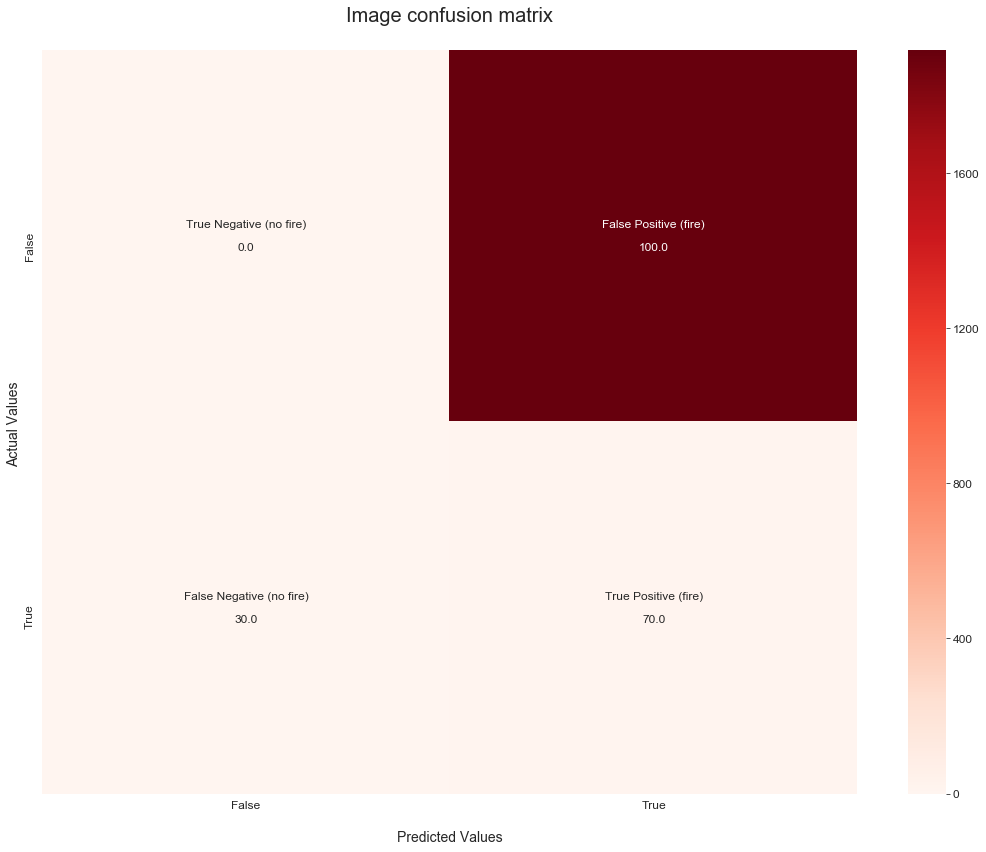

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
36    16      0.6      Nadam  0.72858   0.503876  0.406611          0       0   

                                            histories epochs best thresholds  
36  <keras.callbacks.History object at 0x000002B0B...      9        0.631201

61/61 [==============================] - 6s 97ms/step
0.3
[([1], 0.67141473), ([1], 0.5362451), ([1], 0.023398697), ([1], 0.46377423), ([1], 0.552676), ([1], 0.13031611), ([1], 0.46377423), ([1], 0.037081927), ([1], 0.18918502), ([1], 0.6667457)]
[([1], 0.6666765), ([1], 0.24850744), ([1], 0.02400741), ([1], 0.11727396), ([1], 0.54583156), ([1], 0.09495452), ([1], 0.46377423), ([1], 0.037662417), ([1], 0.076986164), ([1], 0.6890388)]


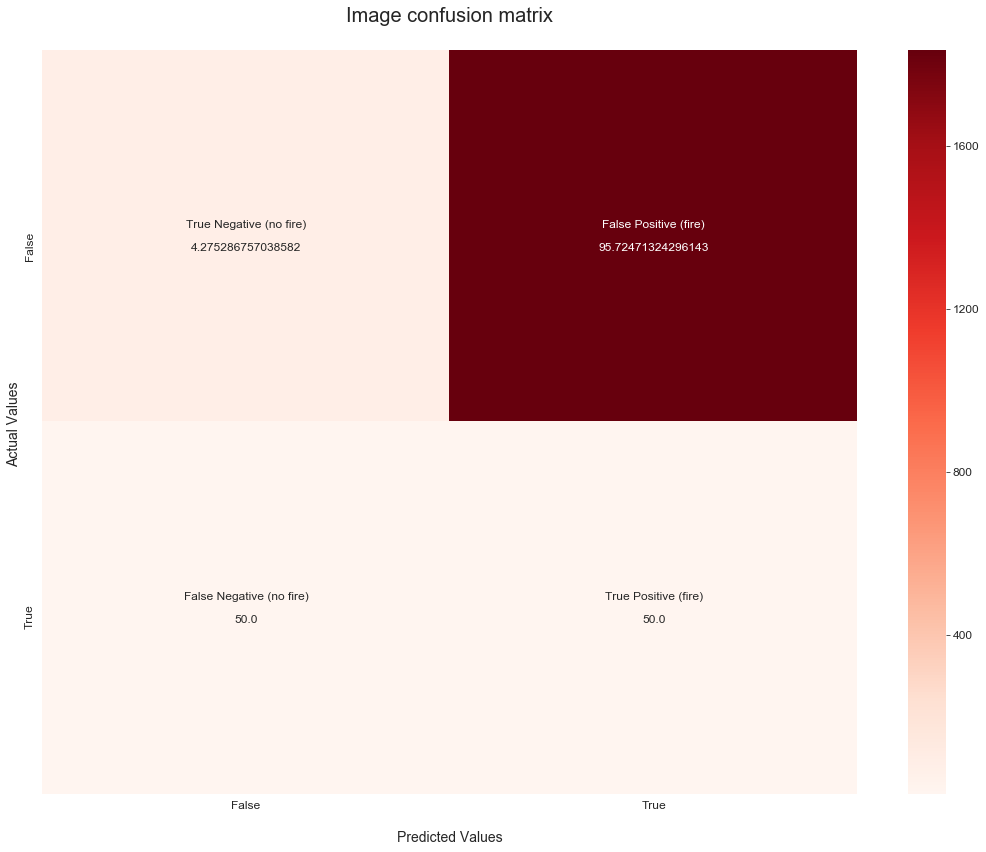

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
36    16      0.6      Nadam  0.72858   0.503876  0.406611          0       0   

                                            histories epochs best thresholds  
36  <keras.callbacks.History object at 0x000002B0B...      9        0.631201

61/61 [==============================] - 6s 98ms/step
0.5
[([1], 0.67141473), ([1], 0.5362451), ([1], 0.023398697), ([1], 0.46377423), ([1], 0.552676), ([1], 0.13031611), ([1], 0.46377423), ([1], 0.037081927), ([1], 0.18918502), ([1], 0.6667457)]
[([1], 0.6666765), ([1], 0.24850744), ([1], 0.02400741), ([1], 0.11727396), ([1], 0.54583156), ([1], 0.09495452), ([1], 0.46377423), ([1], 0.037662417), ([1], 0.076986164), ([1], 0.6890388)]


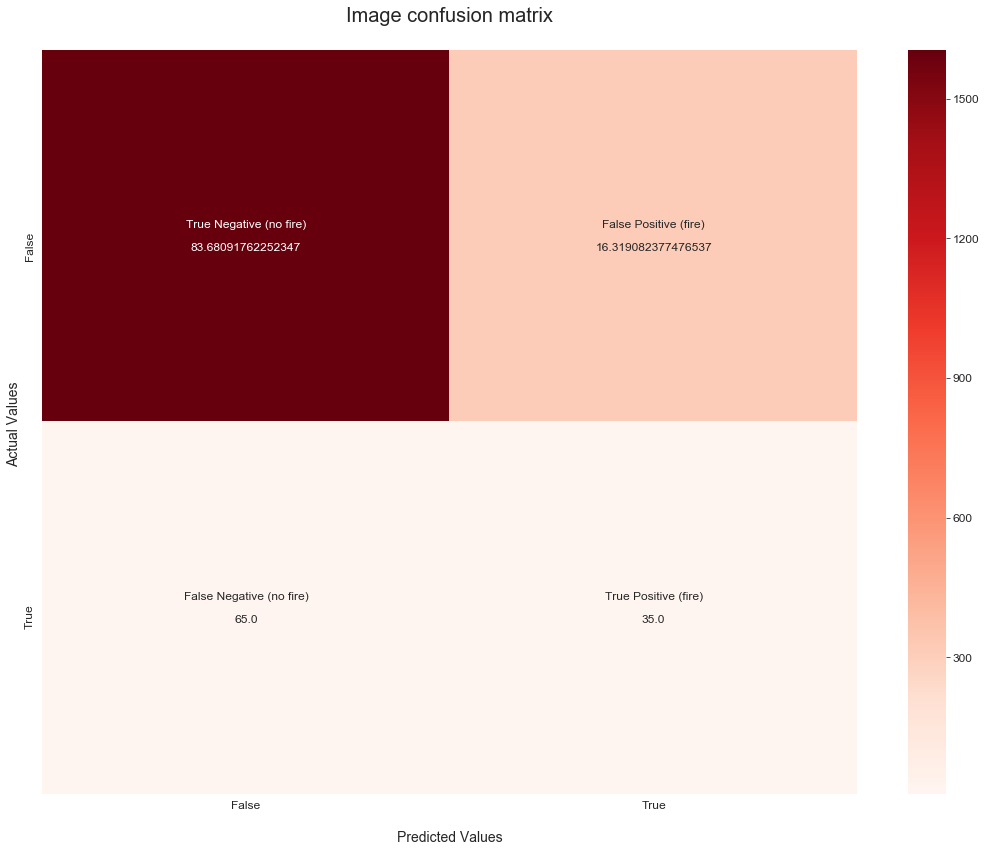

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
36    16      0.6      Nadam  0.72858   0.503876  0.406611          0       0   

                                            histories epochs best thresholds  
36  <keras.callbacks.History object at 0x000002B0B...      9        0.631201

61/61 [==============================] - 6s 95ms/step
0.65
[([1], 0.67141473), ([1], 0.5362451), ([1], 0.023398697), ([1], 0.46377423), ([1], 0.552676), ([1], 0.13031611), ([1], 0.46377423), ([1], 0.037081927), ([1], 0.18918502), ([1], 0.6667457)]
[([1], 0.6666765), ([1], 0.24850744), ([1], 0.02400741), ([1], 0.11727396), ([1], 0.54583156), ([1], 0.09495452), ([1], 0.46377423), ([1], 0.037662417), ([1], 0.076986164), ([1], 0.6890388)]


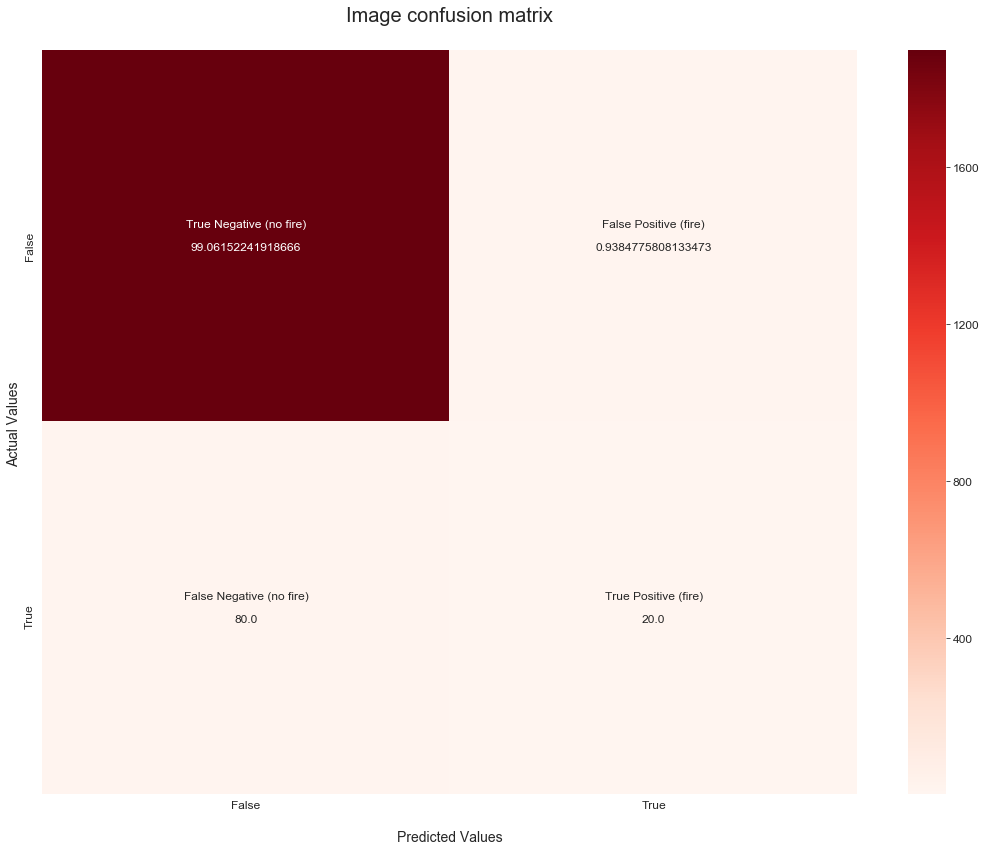

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
36    16      0.6      Nadam  0.72858   0.503876  0.406611          0       0   

                                            histories epochs best thresholds  
36  <keras.callbacks.History object at 0x000002B0B...      9        0.631201

61/61 [==============================] - 6s 96ms/step
0.725
[([1], 0.67141473), ([1], 0.5362451), ([1], 0.023398697), ([1], 0.46377423), ([1], 0.552676), ([1], 0.13031611), ([1], 0.46377423), ([1], 0.037081927), ([1], 0.18918502), ([1], 0.6667457)]
[([1], 0.6666765), ([1], 0.24850744), ([1], 0.02400741), ([1], 0.11727396), ([1], 0.54583156), ([1], 0.09495452), ([1], 0.46377423), ([1], 0.037662417), ([1], 0.076986164), ([1], 0.6890388)]


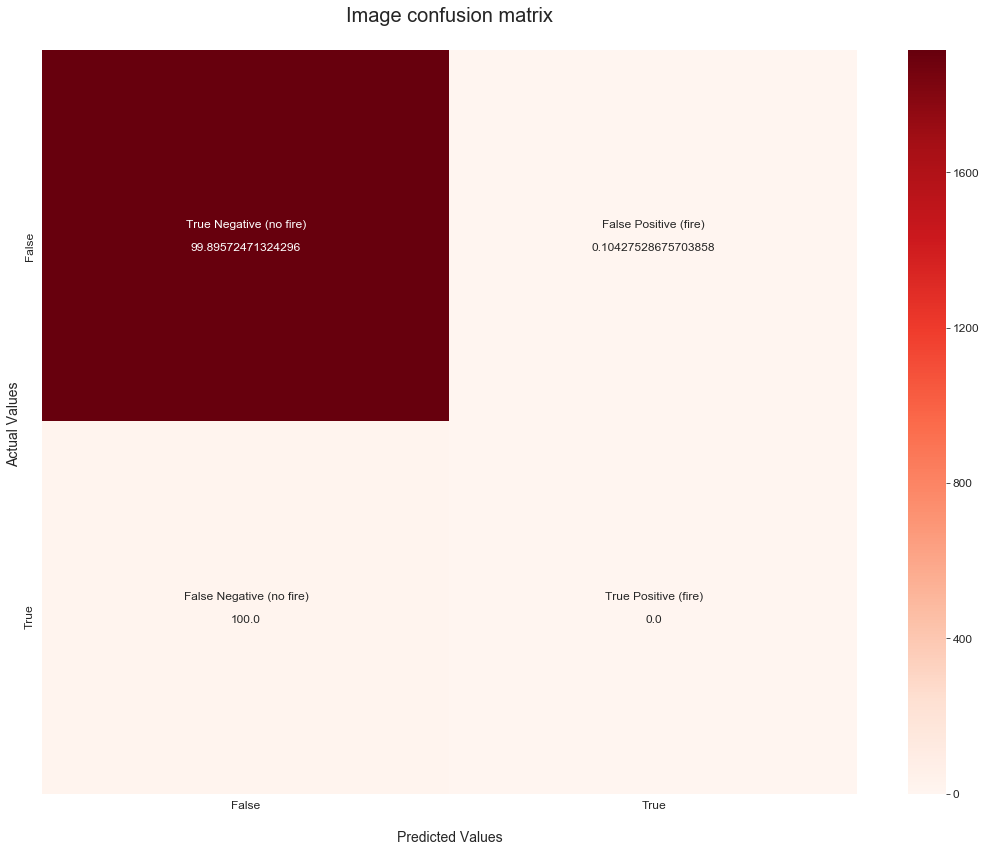

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
36    16      0.6      Nadam  0.72858   0.503876  0.406611          0       0   

                                            histories epochs best thresholds  
36  <keras.callbacks.History object at 0x000002B0B...      9        0.631201

61/61 [==============================] - 6s 98ms/step
0.8
[([1], 0.67141473), ([1], 0.5362451), ([1], 0.023398697), ([1], 0.46377423), ([1], 0.552676), ([1], 0.13031611), ([1], 0.46377423), ([1], 0.037081927), ([1], 0.18918502), ([1], 0.6667457)]
[([1], 0.6666765), ([1], 0.24850744), ([1], 0.02400741), ([1], 0.11727396), ([1], 0.54583156), ([1], 0.09495452), ([1], 0.46377423), ([1], 0.037662417), ([1], 0.076986164), ([1], 0.6890388)]


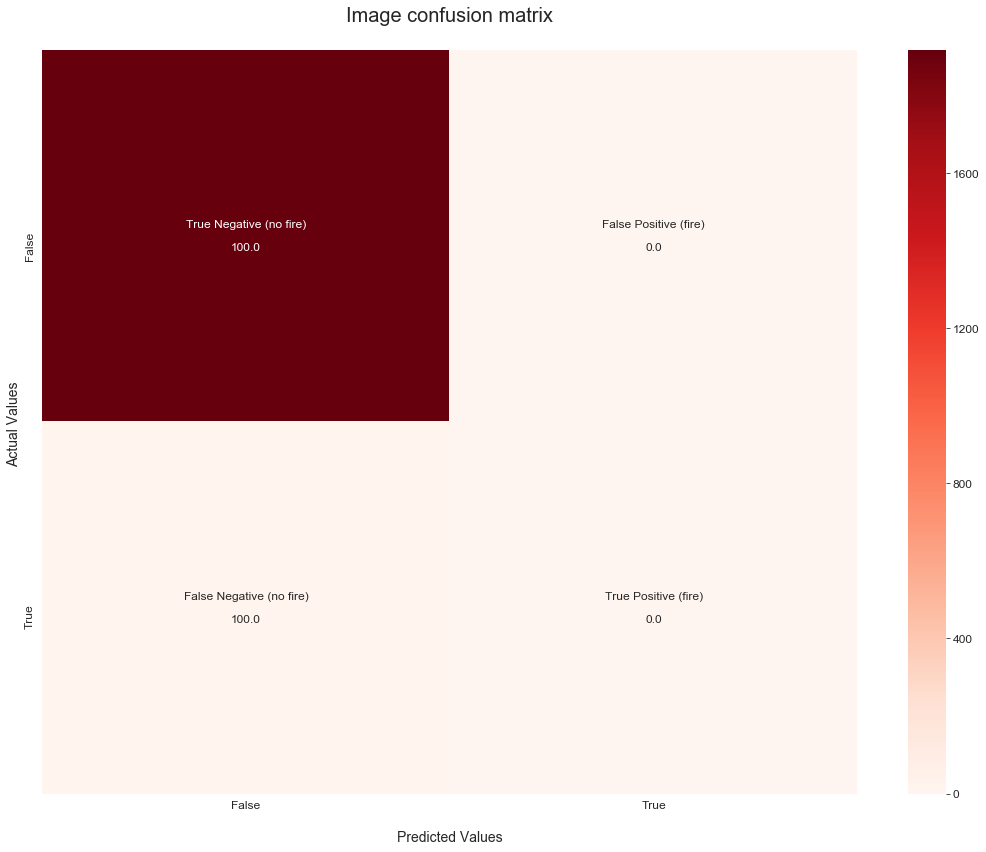

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
36    16      0.6      Nadam  0.72858   0.503876  0.406611          0       0   

                                            histories epochs best thresholds  
36  <keras.callbacks.History object at 0x000002B0B...      9        0.631201

61/61 [==============================] - 6s 96ms/step
0.85
[([1], 0.67141473), ([1], 0.5362451), ([1], 0.023398697), ([1], 0.46377423), ([1], 0.552676), ([1], 0.13031611), ([1], 0.46377423), ([1], 0.037081927), ([1], 0.18918502), ([1], 0.6667457)]
[([1], 0.6666765), ([1], 0.24850744), ([1], 0.02400741), ([1], 0.11727396), ([1], 0.54583156), ([1], 0.09495452), ([1], 0.46377423), ([1], 0.037662417), ([1], 0.076986164), ([1], 0.6890388)]


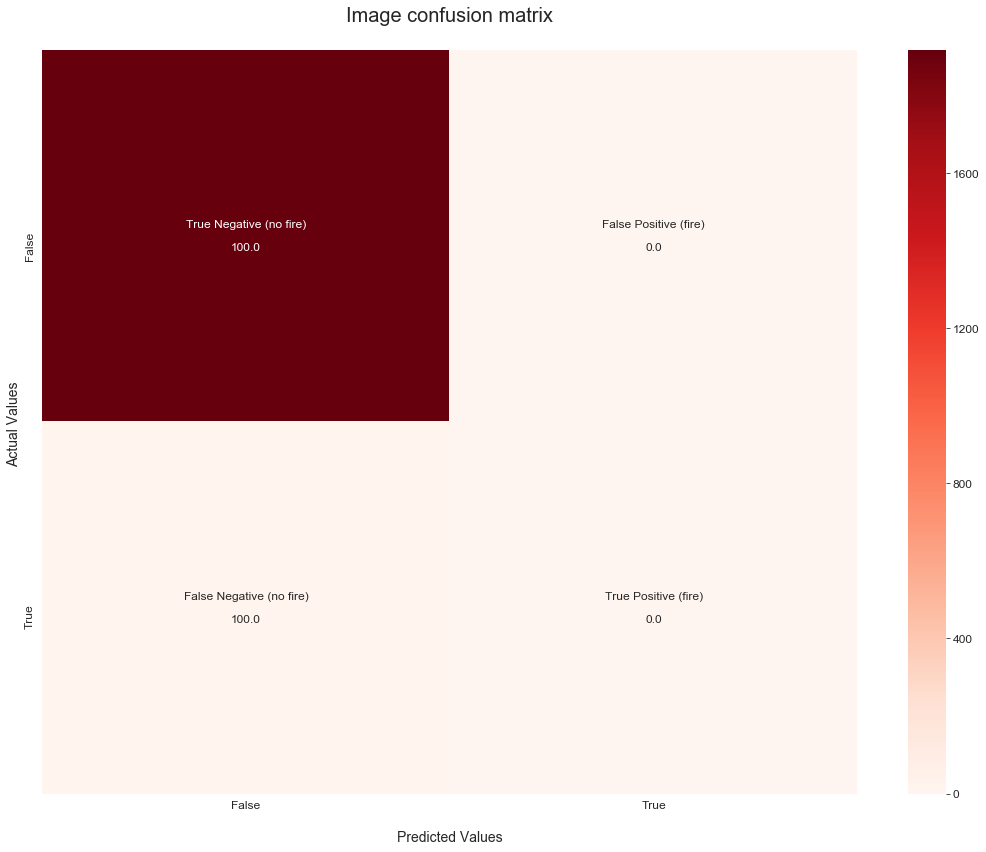

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
36    16      0.6      Nadam  0.72858   0.503876  0.406611          0       0   

                                            histories epochs best thresholds  
36  <keras.callbacks.History object at 0x000002B0B...      9        0.631201

61/61 [==============================] - 6s 96ms/step
0.9
[([1], 0.67141473), ([1], 0.5362451), ([1], 0.023398697), ([1], 0.46377423), ([1], 0.552676), ([1], 0.13031611), ([1], 0.46377423), ([1], 0.037081927), ([1], 0.18918502), ([1], 0.6667457)]
[([1], 0.6666765), ([1], 0.24850744), ([1], 0.02400741), ([1], 0.11727396), ([1], 0.54583156), ([1], 0.09495452), ([1], 0.46377423), ([1], 0.037662417), ([1], 0.076986164), ([1], 0.6890388)]


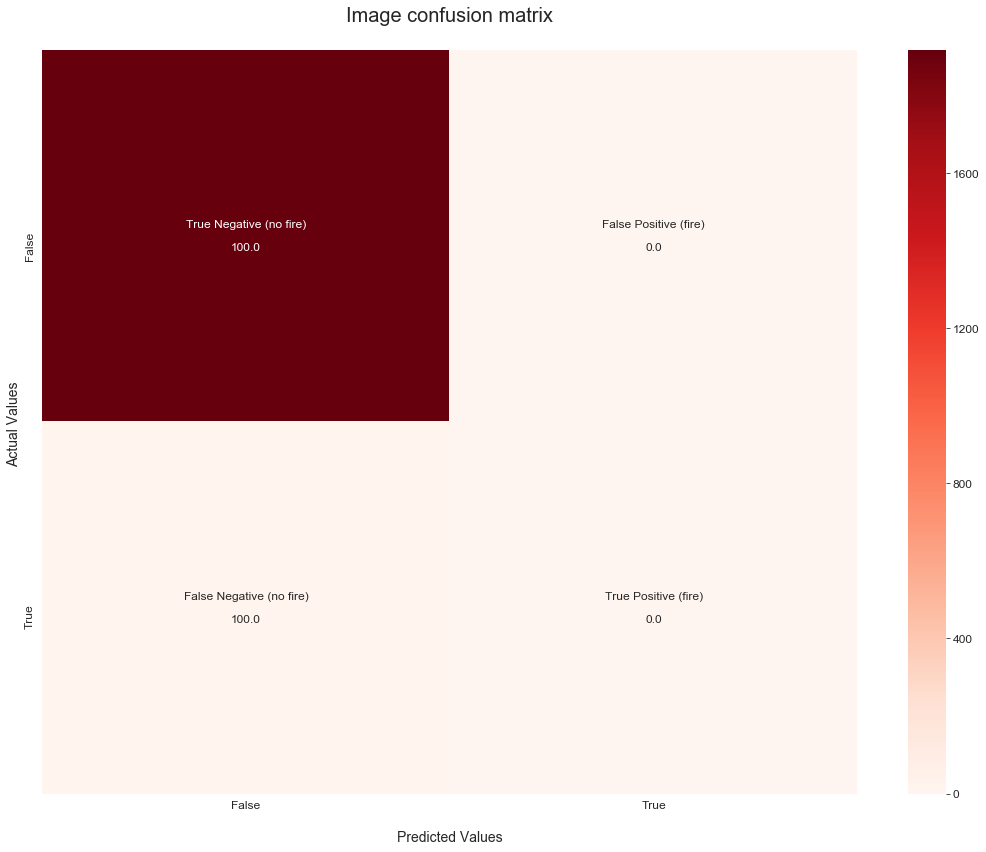

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
36    16      0.6      Nadam  0.72858   0.503876  0.406611          0       0   

                                            histories epochs best thresholds  
36  <keras.callbacks.History object at 0x000002B0B...      9        0.631201

61/61 [==============================] - 6s 96ms/step
0.95
[([1], 0.67141473), ([1], 0.5362451), ([1], 0.023398697), ([1], 0.46377423), ([1], 0.552676), ([1], 0.13031611), ([1], 0.46377423), ([1], 0.037081927), ([1], 0.18918502), ([1], 0.6667457)]
[([1], 0.6666765), ([1], 0.24850744), ([1], 0.02400741), ([1], 0.11727396), ([1], 0.54583156), ([1], 0.09495452), ([1], 0.46377423), ([1], 0.037662417), ([1], 0.076986164), ([1], 0.6890388)]


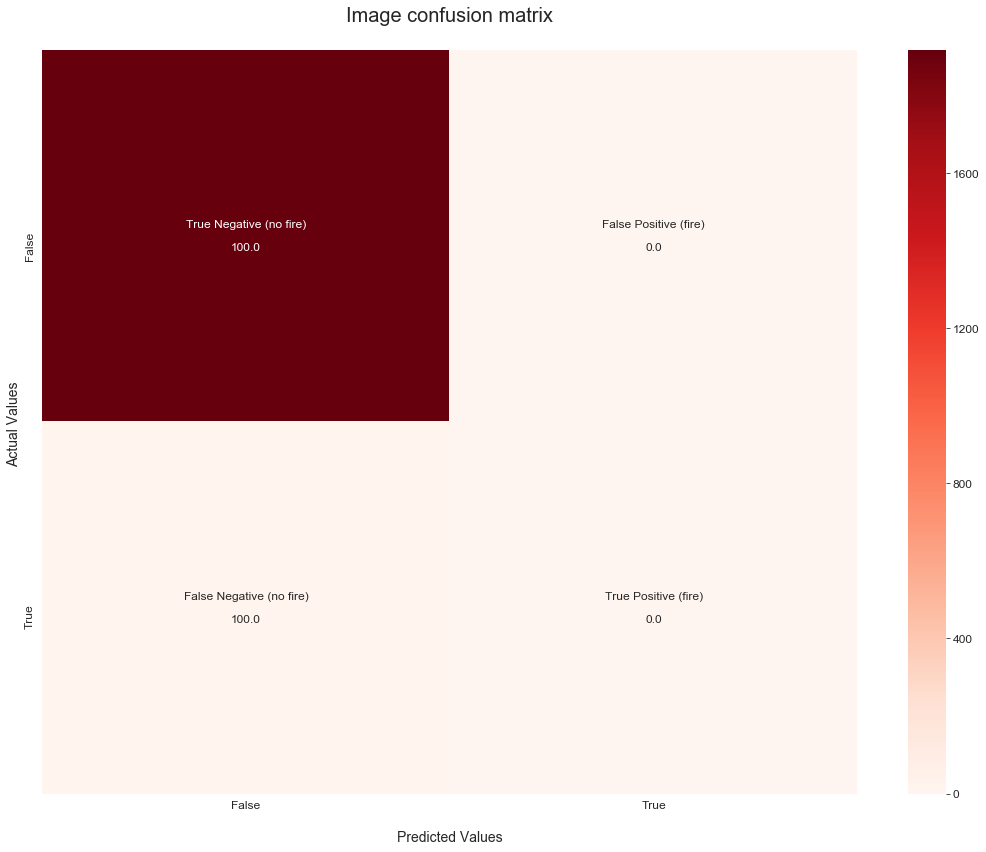

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
37    16      0.6    RMSprop  1.33107   0.496124  0.801923   0.496124       1   

                                            histories epochs best thresholds  
37  <keras.callbacks.History object at 0x000002B0B...      9       0.0726223

61/61 [==============================] - 7s 95ms/step
0.1
[([1], 0.9568224), ([1], 0.90251285), ([1], 0.07533839), ([1], 0.24192941), ([1], 0.57135314), ([1], 0.08520654), ([1], 0.75915813), ([1], 0.011395872), ([1], 0.16556016), ([1], 0.039001197)]
[([1], 0.84398204), ([1], 0.06017375), ([1], 0.033975214), ([1], 0.00069361925), ([1], 0.7602972), ([1], 0.2439039), ([1], 0.59199023), ([1], 0.014074385), ([1], 0.030688703), ([1], 0.33224493)]


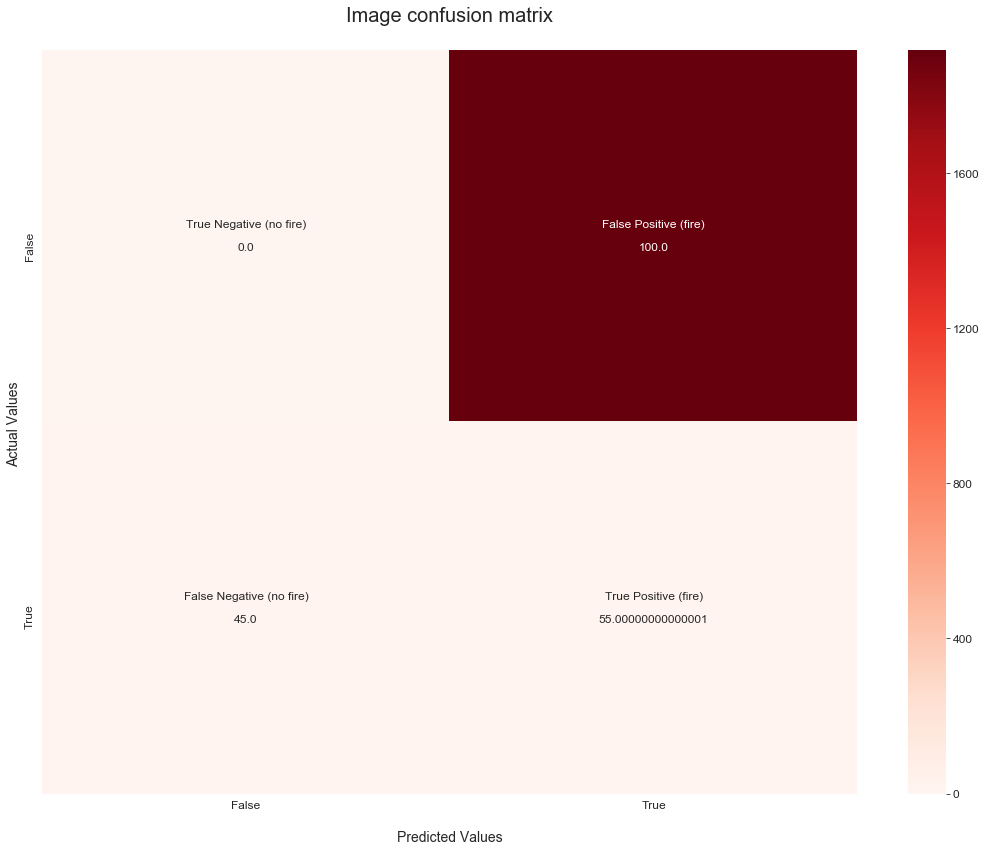

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
37    16      0.6    RMSprop  1.33107   0.496124  0.801923   0.496124       1   

                                            histories epochs best thresholds  
37  <keras.callbacks.History object at 0x000002B0B...      9       0.0726223

61/61 [==============================] - 6s 97ms/step
0.3
[([1], 0.9568224), ([1], 0.90251285), ([1], 0.07533839), ([1], 0.24192941), ([1], 0.57135314), ([1], 0.08520654), ([1], 0.75915813), ([1], 0.011395872), ([1], 0.16556016), ([1], 0.039001197)]
[([1], 0.84398204), ([1], 0.06017375), ([1], 0.033975214), ([1], 0.00069361925), ([1], 0.7602972), ([1], 0.2439039), ([1], 0.59199023), ([1], 0.014074385), ([1], 0.030688703), ([1], 0.33224493)]


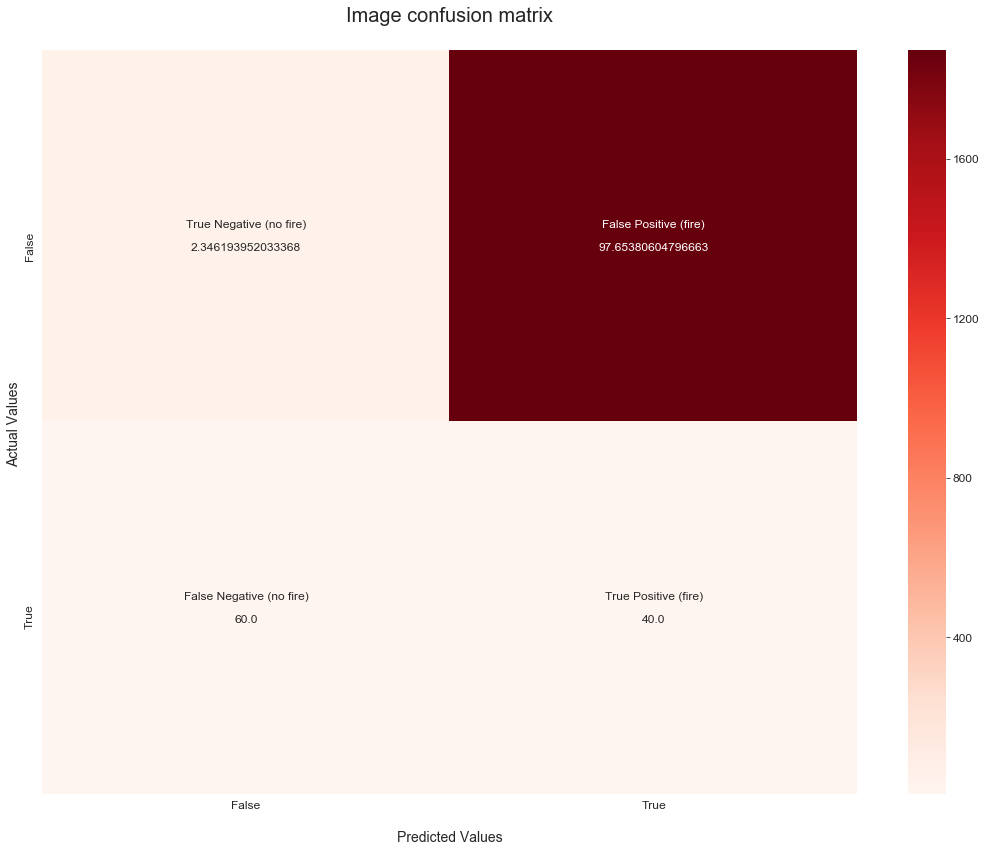

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
37    16      0.6    RMSprop  1.33107   0.496124  0.801923   0.496124       1   

                                            histories epochs best thresholds  
37  <keras.callbacks.History object at 0x000002B0B...      9       0.0726223

61/61 [==============================] - 6s 96ms/step
0.5
[([1], 0.9568224), ([1], 0.90251285), ([1], 0.07533839), ([1], 0.24192941), ([1], 0.57135314), ([1], 0.08520654), ([1], 0.75915813), ([1], 0.011395872), ([1], 0.16556016), ([1], 0.039001197)]
[([1], 0.84398204), ([1], 0.06017375), ([1], 0.033975214), ([1], 0.00069361925), ([1], 0.7602972), ([1], 0.2439039), ([1], 0.59199023), ([1], 0.014074385), ([1], 0.030688703), ([1], 0.33224493)]


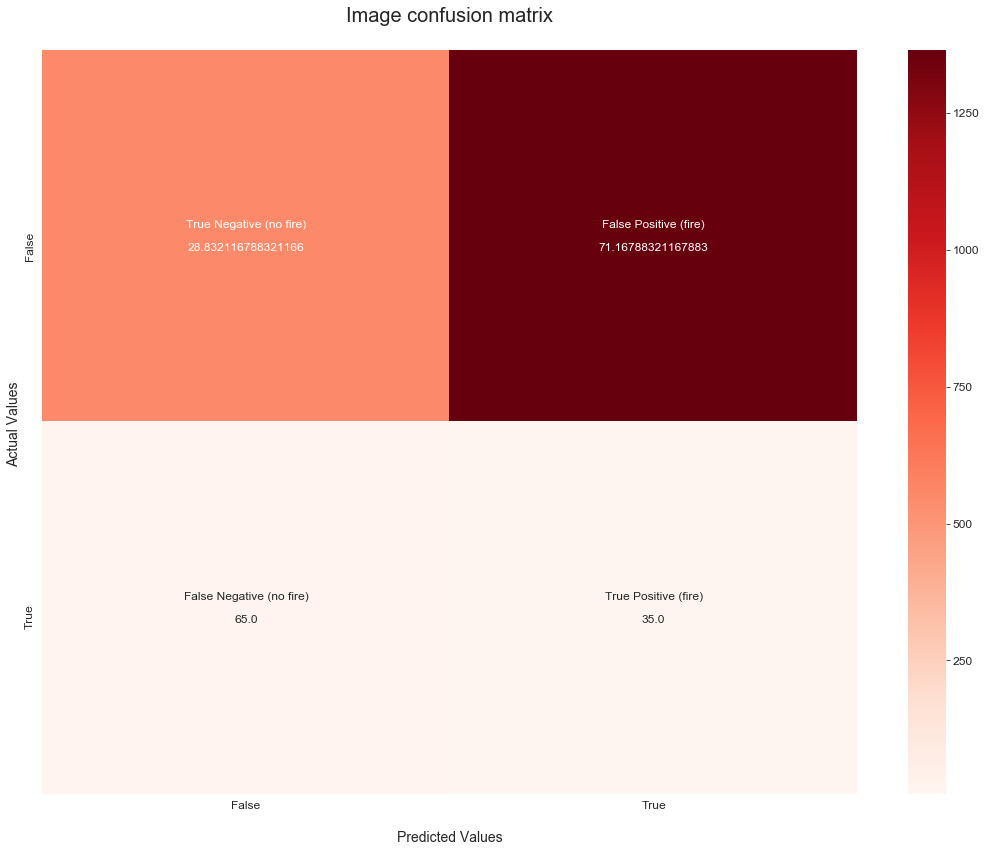

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
37    16      0.6    RMSprop  1.33107   0.496124  0.801923   0.496124       1   

                                            histories epochs best thresholds  
37  <keras.callbacks.History object at 0x000002B0B...      9       0.0726223

61/61 [==============================] - 6s 97ms/step
0.65
[([1], 0.9568224), ([1], 0.90251285), ([1], 0.07533839), ([1], 0.24192941), ([1], 0.57135314), ([1], 0.08520654), ([1], 0.75915813), ([1], 0.011395872), ([1], 0.16556016), ([1], 0.039001197)]
[([1], 0.84398204), ([1], 0.06017375), ([1], 0.033975214), ([1], 0.00069361925), ([1], 0.7602972), ([1], 0.2439039), ([1], 0.59199023), ([1], 0.014074385), ([1], 0.030688703), ([1], 0.33224493)]


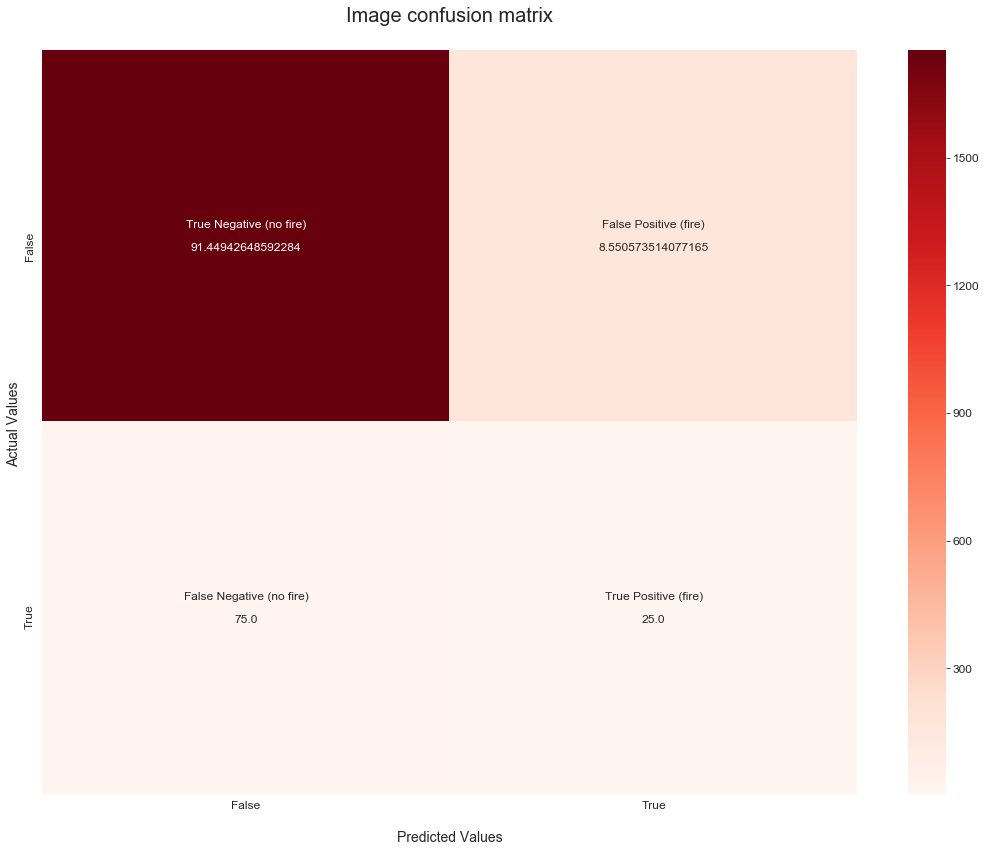

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
37    16      0.6    RMSprop  1.33107   0.496124  0.801923   0.496124       1   

                                            histories epochs best thresholds  
37  <keras.callbacks.History object at 0x000002B0B...      9       0.0726223

61/61 [==============================] - 6s 97ms/step
0.725
[([1], 0.9568224), ([1], 0.90251285), ([1], 0.07533839), ([1], 0.24192941), ([1], 0.57135314), ([1], 0.08520654), ([1], 0.75915813), ([1], 0.011395872), ([1], 0.16556016), ([1], 0.039001197)]
[([1], 0.84398204), ([1], 0.06017375), ([1], 0.033975214), ([1], 0.00069361925), ([1], 0.7602972), ([1], 0.2439039), ([1], 0.59199023), ([1], 0.014074385), ([1], 0.030688703), ([1], 0.33224493)]


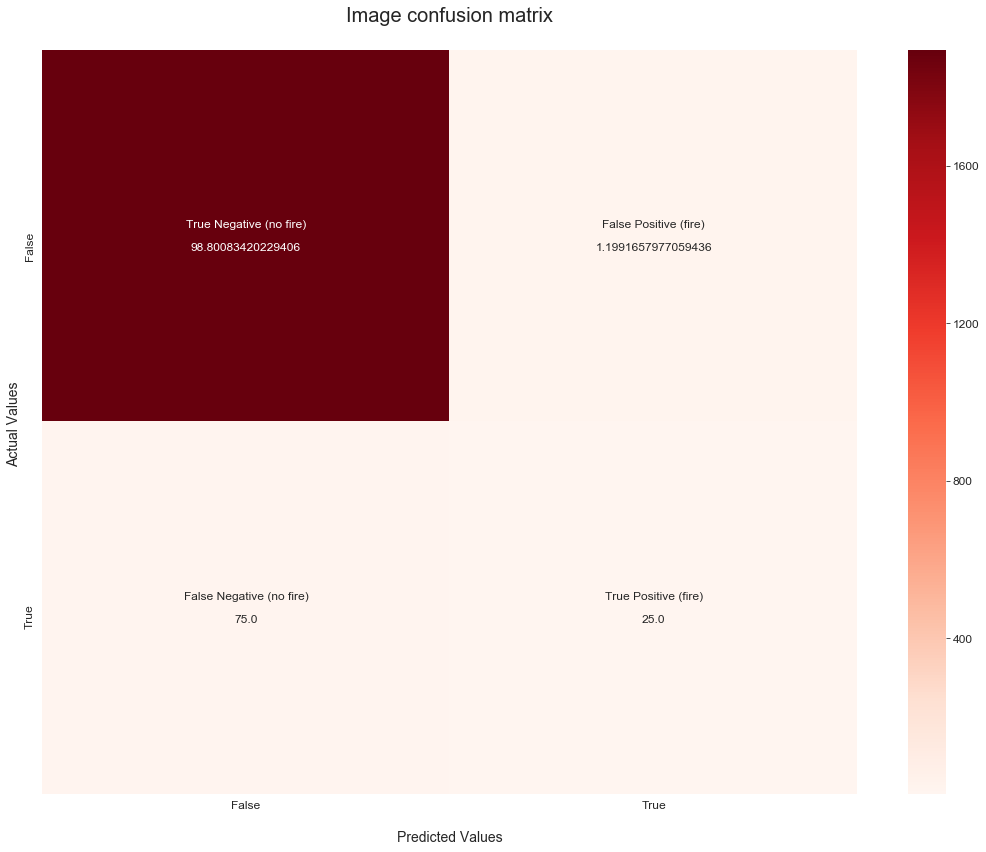

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
37    16      0.6    RMSprop  1.33107   0.496124  0.801923   0.496124       1   

                                            histories epochs best thresholds  
37  <keras.callbacks.History object at 0x000002B0B...      9       0.0726223

61/61 [==============================] - 6s 96ms/step
0.8
[([1], 0.9568224), ([1], 0.90251285), ([1], 0.07533839), ([1], 0.24192941), ([1], 0.57135314), ([1], 0.08520654), ([1], 0.75915813), ([1], 0.011395872), ([1], 0.16556016), ([1], 0.039001197)]
[([1], 0.84398204), ([1], 0.06017375), ([1], 0.033975214), ([1], 0.00069361925), ([1], 0.7602972), ([1], 0.2439039), ([1], 0.59199023), ([1], 0.014074385), ([1], 0.030688703), ([1], 0.33224493)]


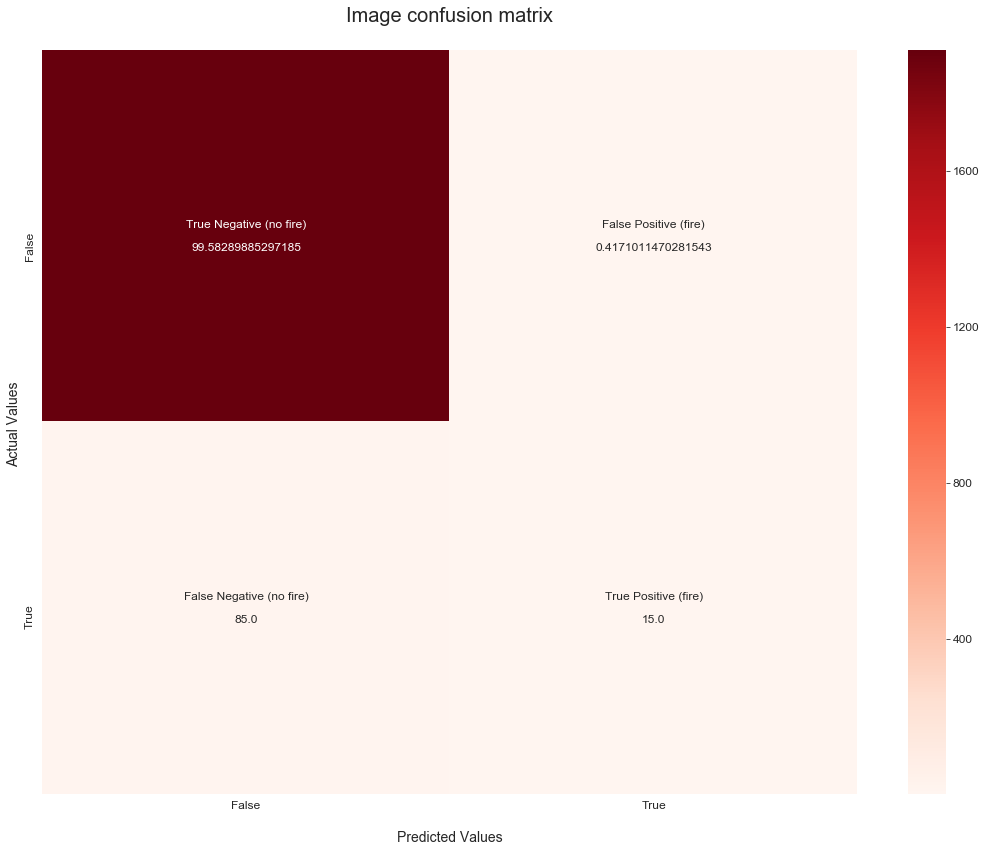

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
37    16      0.6    RMSprop  1.33107   0.496124  0.801923   0.496124       1   

                                            histories epochs best thresholds  
37  <keras.callbacks.History object at 0x000002B0B...      9       0.0726223

61/61 [==============================] - 6s 96ms/step
0.85
[([1], 0.9568224), ([1], 0.90251285), ([1], 0.07533839), ([1], 0.24192941), ([1], 0.57135314), ([1], 0.08520654), ([1], 0.75915813), ([1], 0.011395872), ([1], 0.16556016), ([1], 0.039001197)]
[([1], 0.84398204), ([1], 0.06017375), ([1], 0.033975214), ([1], 0.00069361925), ([1], 0.7602972), ([1], 0.2439039), ([1], 0.59199023), ([1], 0.014074385), ([1], 0.030688703), ([1], 0.33224493)]


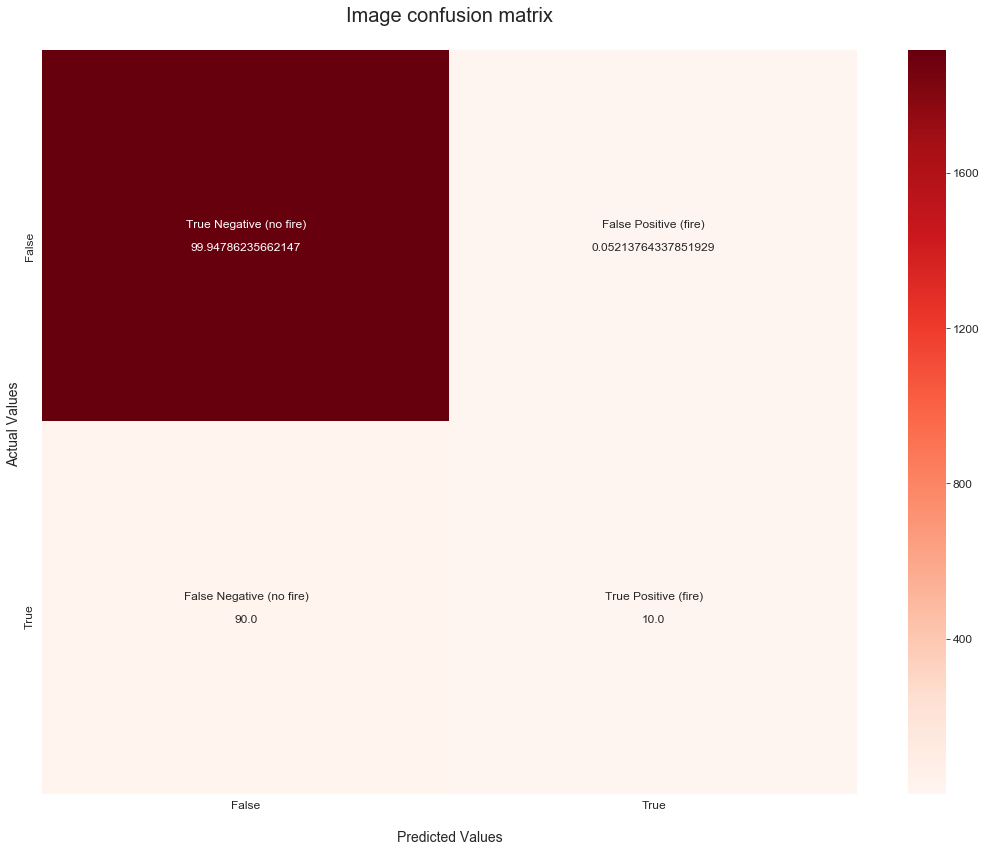

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
37    16      0.6    RMSprop  1.33107   0.496124  0.801923   0.496124       1   

                                            histories epochs best thresholds  
37  <keras.callbacks.History object at 0x000002B0B...      9       0.0726223

61/61 [==============================] - 6s 96ms/step
0.9
[([1], 0.9568224), ([1], 0.90251285), ([1], 0.07533839), ([1], 0.24192941), ([1], 0.57135314), ([1], 0.08520654), ([1], 0.75915813), ([1], 0.011395872), ([1], 0.16556016), ([1], 0.039001197)]
[([1], 0.84398204), ([1], 0.06017375), ([1], 0.033975214), ([1], 0.00069361925), ([1], 0.7602972), ([1], 0.2439039), ([1], 0.59199023), ([1], 0.014074385), ([1], 0.030688703), ([1], 0.33224493)]


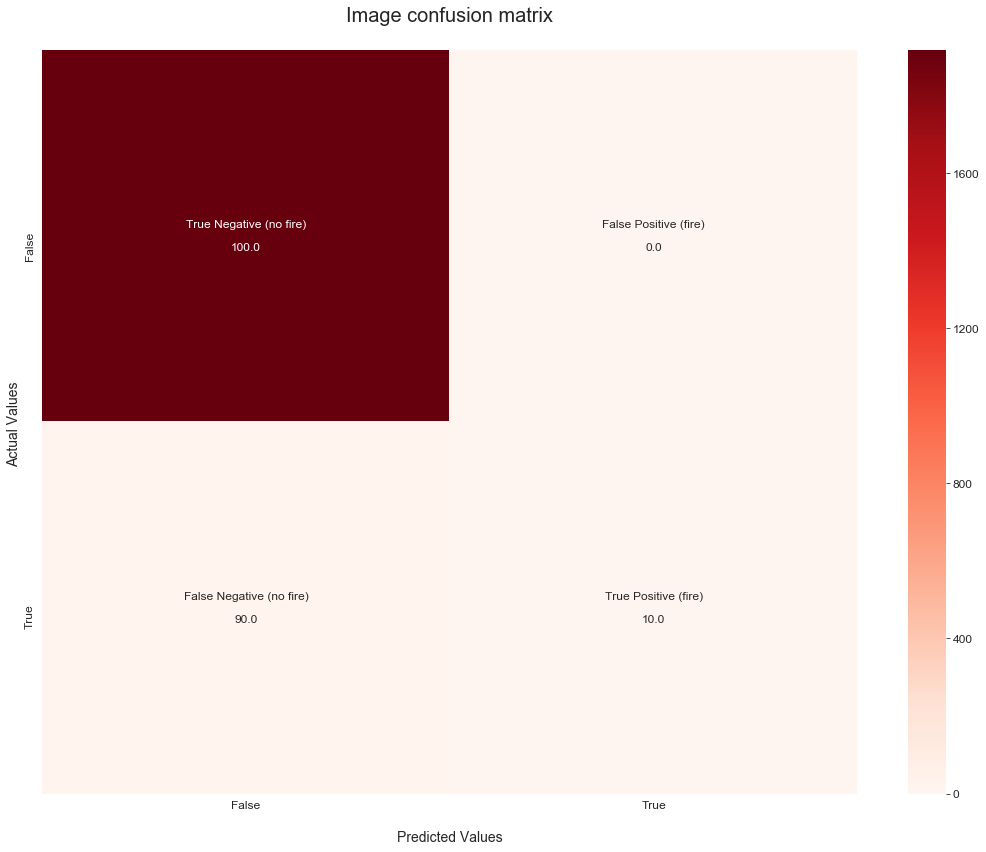

units dropouts optimizers   losses accuracies      aucs precisions recalls  \
37    16      0.6    RMSprop  1.33107   0.496124  0.801923   0.496124       1   

                                            histories epochs best thresholds  
37  <keras.callbacks.History object at 0x000002B0B...      9       0.0726223

61/61 [==============================] - 6s 98ms/step
0.95
[([1], 0.9568224), ([1], 0.90251285), ([1], 0.07533839), ([1], 0.24192941), ([1], 0.57135314), ([1], 0.08520654), ([1], 0.75915813), ([1], 0.011395872), ([1], 0.16556016), ([1], 0.039001197)]
[([1], 0.84398204), ([1], 0.06017375), ([1], 0.033975214), ([1], 0.00069361925), ([1], 0.7602972), ([1], 0.2439039), ([1], 0.59199023), ([1], 0.014074385), ([1], 0.030688703), ([1], 0.33224493)]


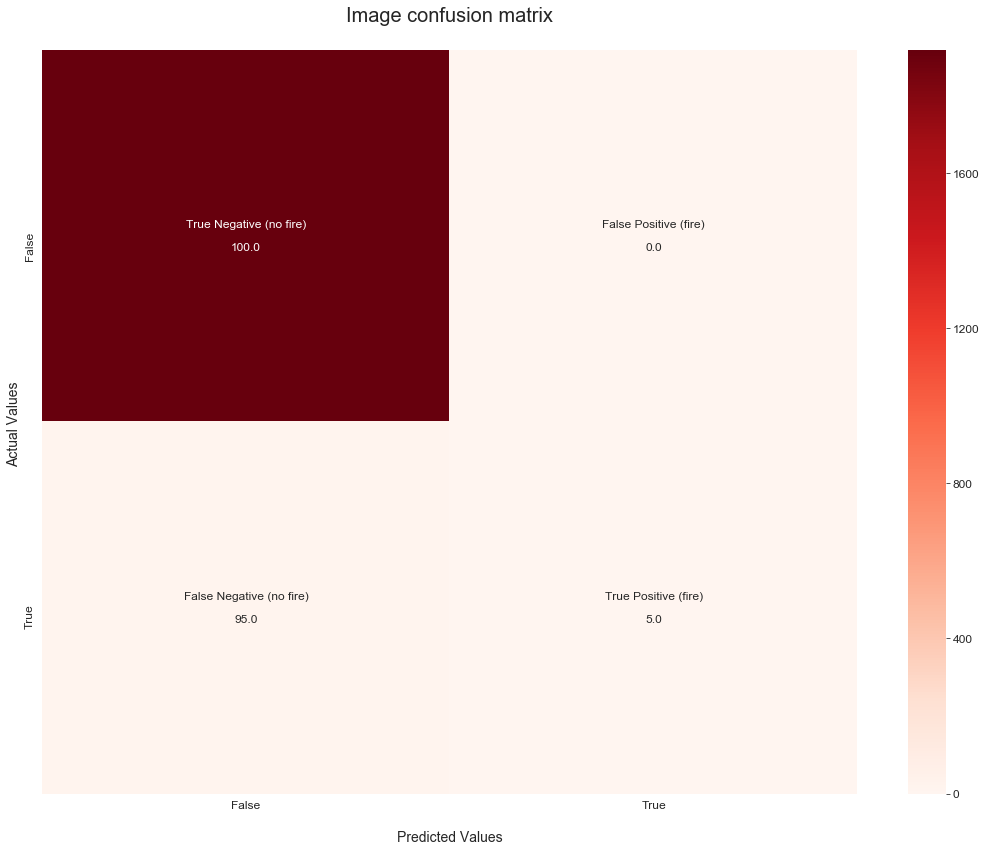

units dropouts optimizers    losses accuracies      aucs precisions  \
38    16      0.7       adam  0.709938   0.496124  0.465745   0.496124   

   recalls                                          histories epochs  \
38       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
38        0.413203

61/61 [==============================] - 7s 95ms/step
0.1
[([1], 0.846757), ([1], 0.8042645), ([1], 0.8904855), ([1], 0.8150693), ([1], 0.8762815), ([1], 0.8996444), ([1], 0.936183), ([1], 0.5203036), ([1], 0.49146655), ([1], 0.92067945)]
[([1], 0.8060374), ([1], 0.72275287), ([1], 0.89782566), ([1], 0.8490524), ([1], 0.8428148), ([1], 0.9003866), ([1], 0.93882436), ([1], 0.5332498), ([1], 0.51555824), ([1], 0.90553457)]


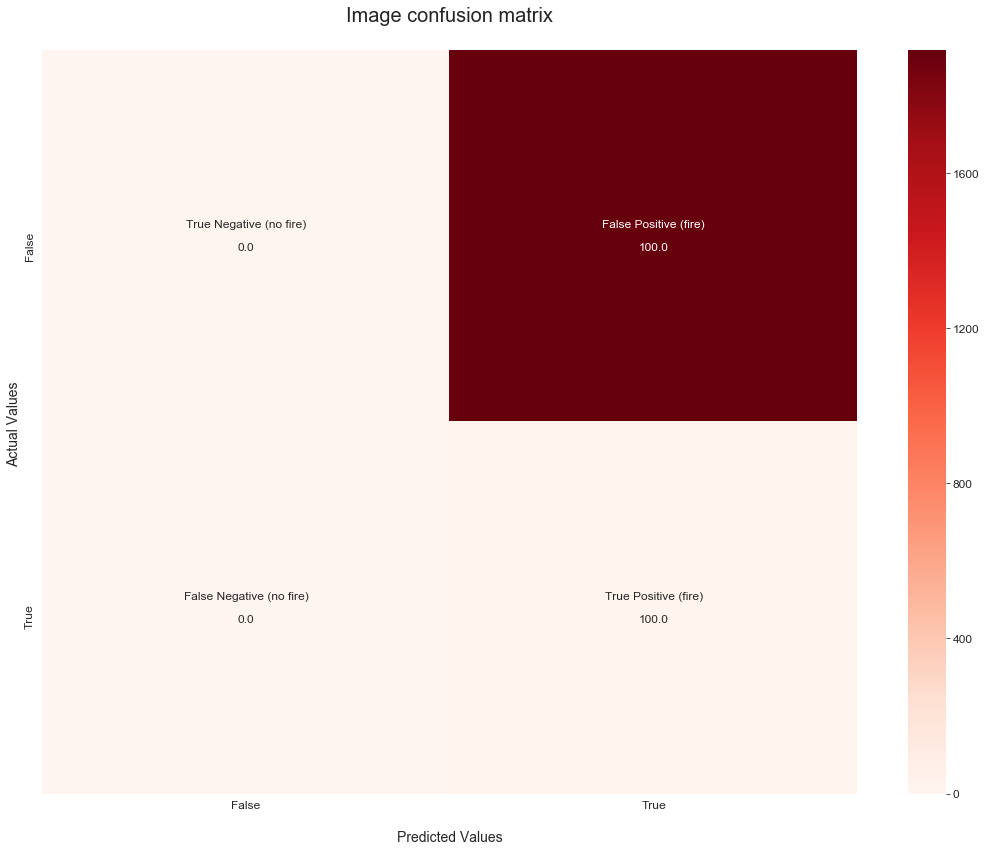

units dropouts optimizers    losses accuracies      aucs precisions  \
38    16      0.7       adam  0.709938   0.496124  0.465745   0.496124   

   recalls                                          histories epochs  \
38       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
38        0.413203

61/61 [==============================] - 6s 97ms/step
0.3
[([1], 0.846757), ([1], 0.8042645), ([1], 0.8904855), ([1], 0.8150693), ([1], 0.8762815), ([1], 0.8996444), ([1], 0.936183), ([1], 0.5203036), ([1], 0.49146655), ([1], 0.92067945)]
[([1], 0.8060374), ([1], 0.72275287), ([1], 0.89782566), ([1], 0.8490524), ([1], 0.8428148), ([1], 0.9003866), ([1], 0.93882436), ([1], 0.5332498), ([1], 0.51555824), ([1], 0.90553457)]


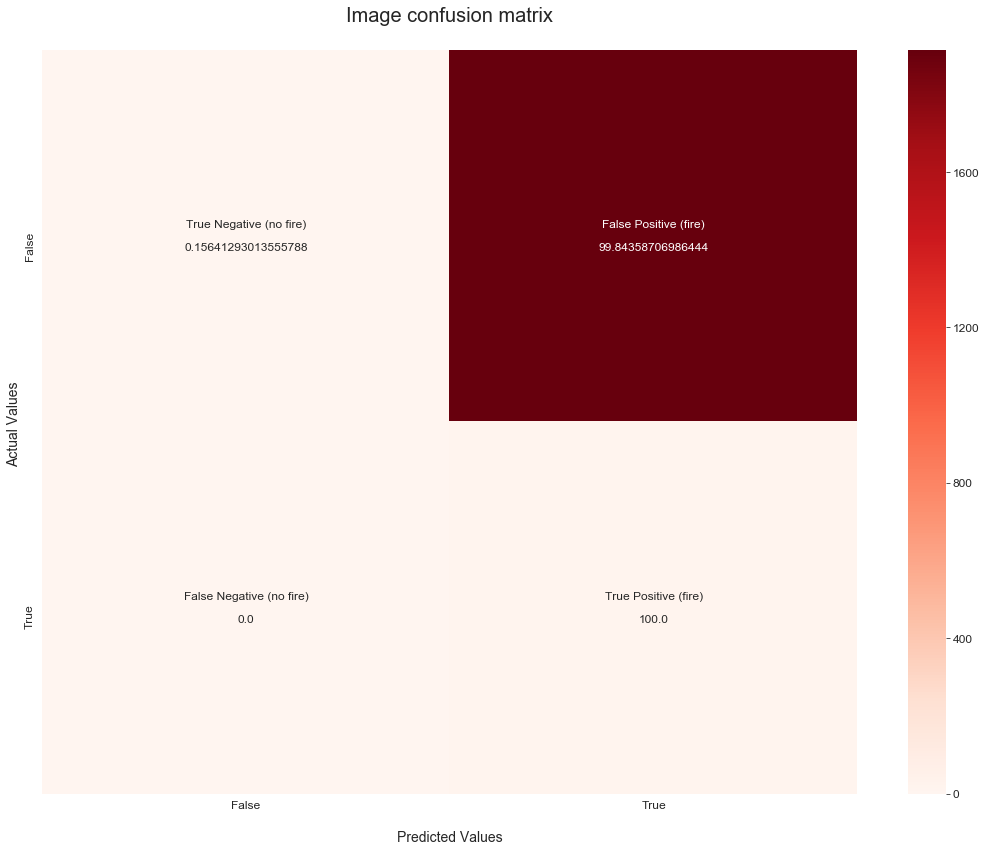

units dropouts optimizers    losses accuracies      aucs precisions  \
38    16      0.7       adam  0.709938   0.496124  0.465745   0.496124   

   recalls                                          histories epochs  \
38       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
38        0.413203

61/61 [==============================] - 6s 97ms/step
0.5
[([1], 0.846757), ([1], 0.8042645), ([1], 0.8904855), ([1], 0.8150693), ([1], 0.8762815), ([1], 0.8996444), ([1], 0.936183), ([1], 0.5203036), ([1], 0.49146655), ([1], 0.92067945)]
[([1], 0.8060374), ([1], 0.72275287), ([1], 0.89782566), ([1], 0.8490524), ([1], 0.8428148), ([1], 0.9003866), ([1], 0.93882436), ([1], 0.5332498), ([1], 0.51555824), ([1], 0.90553457)]


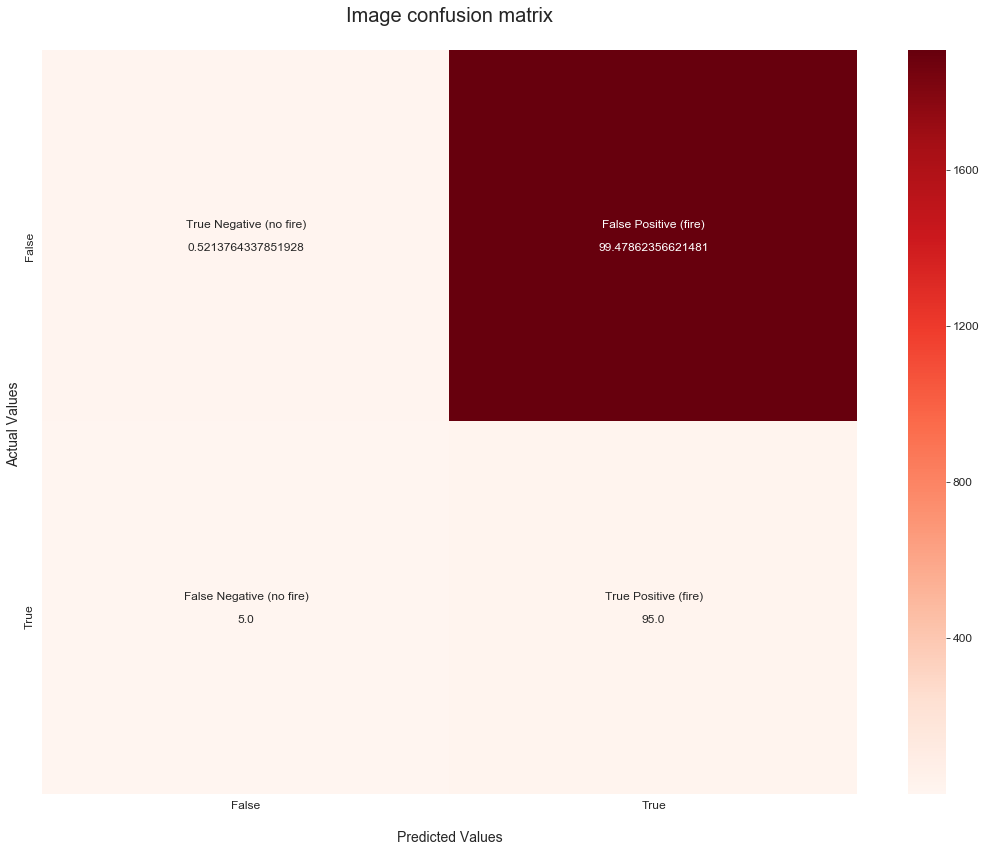

units dropouts optimizers    losses accuracies      aucs precisions  \
38    16      0.7       adam  0.709938   0.496124  0.465745   0.496124   

   recalls                                          histories epochs  \
38       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
38        0.413203

61/61 [==============================] - 6s 97ms/step
0.65
[([1], 0.846757), ([1], 0.8042645), ([1], 0.8904855), ([1], 0.8150693), ([1], 0.8762815), ([1], 0.8996444), ([1], 0.936183), ([1], 0.5203036), ([1], 0.49146655), ([1], 0.92067945)]
[([1], 0.8060374), ([1], 0.72275287), ([1], 0.89782566), ([1], 0.8490524), ([1], 0.8428148), ([1], 0.9003866), ([1], 0.93882436), ([1], 0.5332498), ([1], 0.51555824), ([1], 0.90553457)]


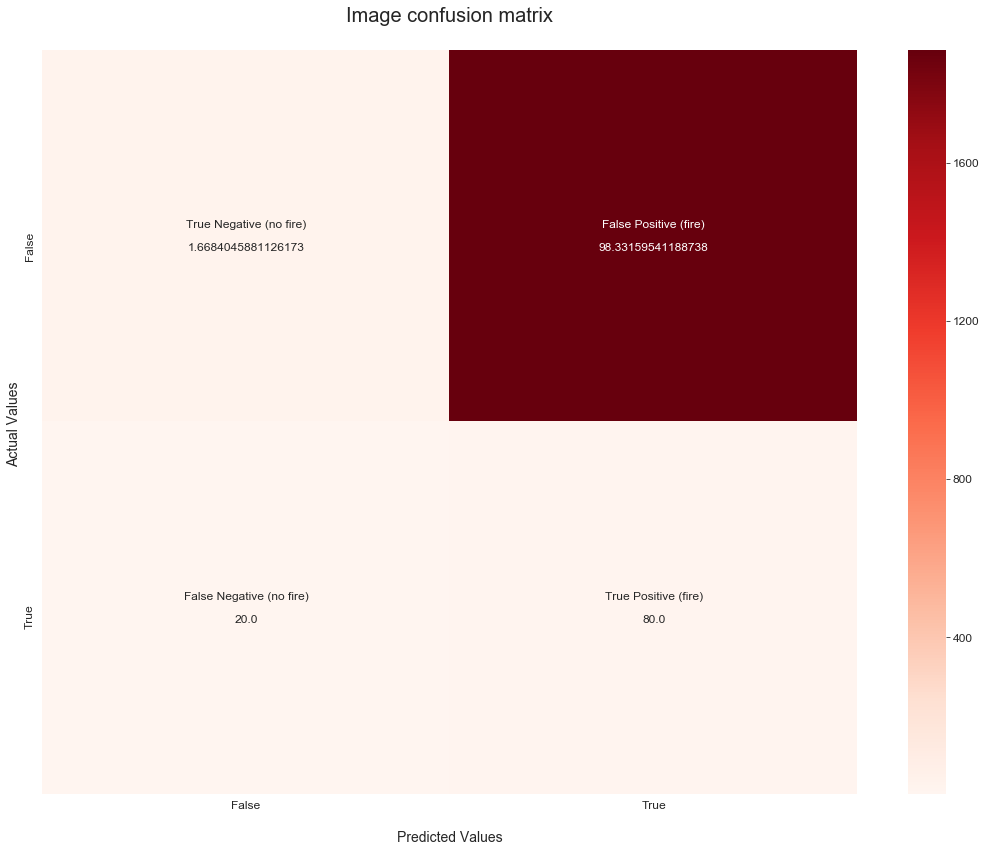

units dropouts optimizers    losses accuracies      aucs precisions  \
38    16      0.7       adam  0.709938   0.496124  0.465745   0.496124   

   recalls                                          histories epochs  \
38       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
38        0.413203

61/61 [==============================] - 6s 98ms/step
0.725
[([1], 0.846757), ([1], 0.8042645), ([1], 0.8904855), ([1], 0.8150693), ([1], 0.8762815), ([1], 0.8996444), ([1], 0.936183), ([1], 0.5203036), ([1], 0.49146655), ([1], 0.92067945)]
[([1], 0.8060374), ([1], 0.72275287), ([1], 0.89782566), ([1], 0.8490524), ([1], 0.8428148), ([1], 0.9003866), ([1], 0.93882436), ([1], 0.5332498), ([1], 0.51555824), ([1], 0.90553457)]


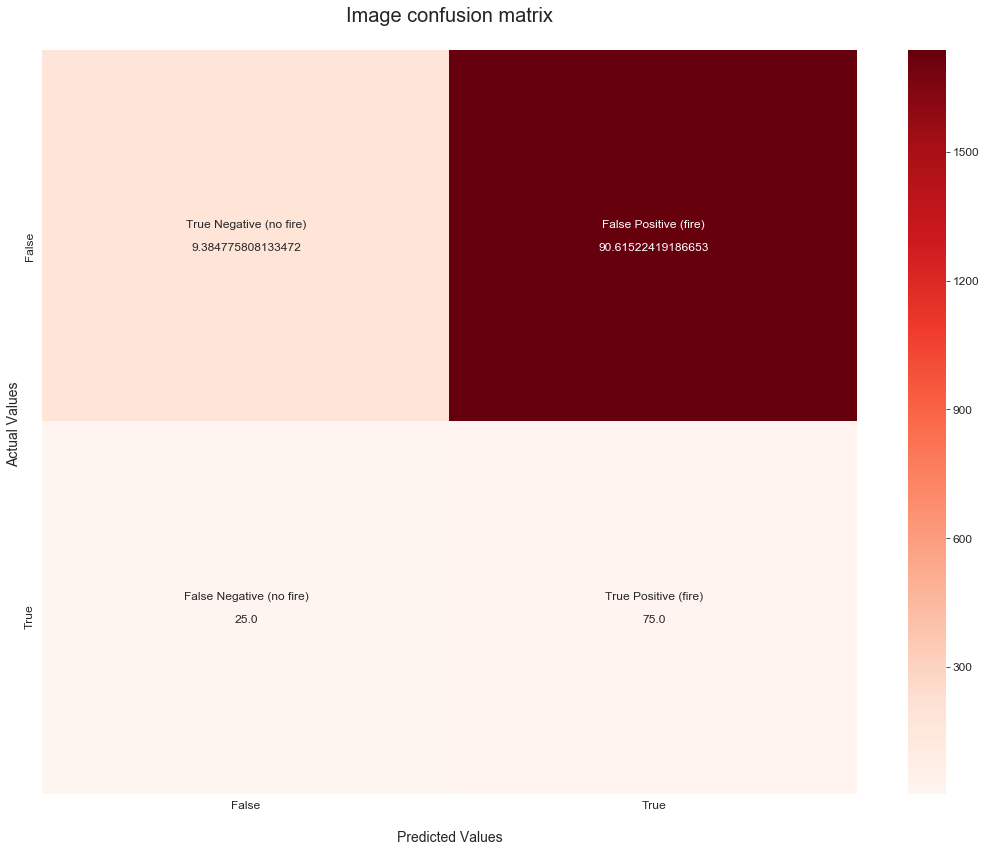

units dropouts optimizers    losses accuracies      aucs precisions  \
38    16      0.7       adam  0.709938   0.496124  0.465745   0.496124   

   recalls                                          histories epochs  \
38       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
38        0.413203

61/61 [==============================] - 6s 97ms/step
0.8
[([1], 0.846757), ([1], 0.8042645), ([1], 0.8904855), ([1], 0.8150693), ([1], 0.8762815), ([1], 0.8996444), ([1], 0.936183), ([1], 0.5203036), ([1], 0.49146655), ([1], 0.92067945)]
[([1], 0.8060374), ([1], 0.72275287), ([1], 0.89782566), ([1], 0.8490524), ([1], 0.8428148), ([1], 0.9003866), ([1], 0.93882436), ([1], 0.5332498), ([1], 0.51555824), ([1], 0.90553457)]


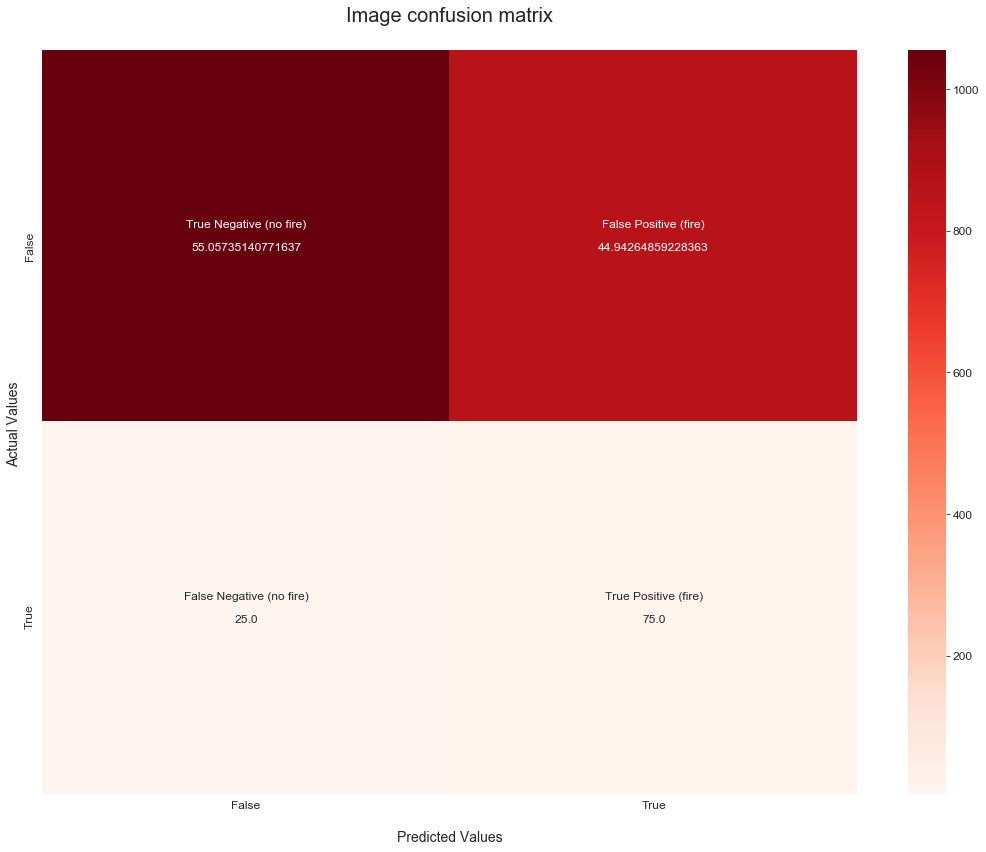

units dropouts optimizers    losses accuracies      aucs precisions  \
38    16      0.7       adam  0.709938   0.496124  0.465745   0.496124   

   recalls                                          histories epochs  \
38       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
38        0.413203

61/61 [==============================] - 6s 96ms/step
0.85
[([1], 0.846757), ([1], 0.8042645), ([1], 0.8904855), ([1], 0.8150693), ([1], 0.8762815), ([1], 0.8996444), ([1], 0.936183), ([1], 0.5203036), ([1], 0.49146655), ([1], 0.92067945)]
[([1], 0.8060374), ([1], 0.72275287), ([1], 0.89782566), ([1], 0.8490524), ([1], 0.8428148), ([1], 0.9003866), ([1], 0.93882436), ([1], 0.5332498), ([1], 0.51555824), ([1], 0.90553457)]


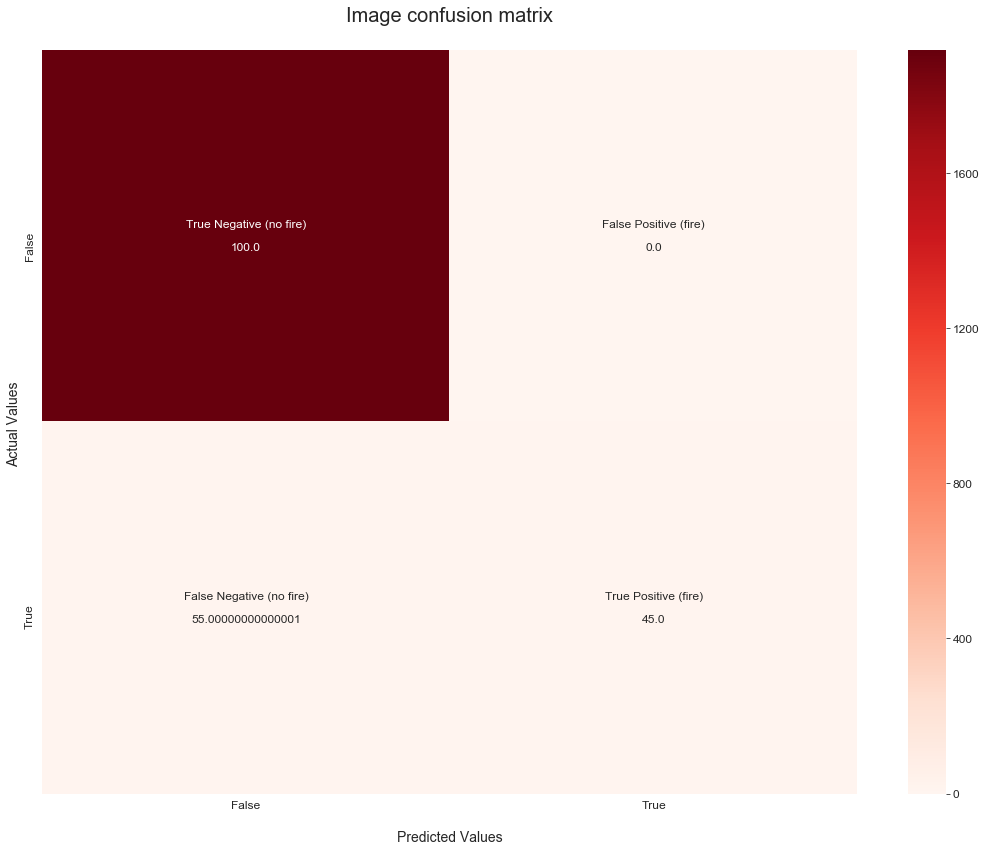

units dropouts optimizers    losses accuracies      aucs precisions  \
38    16      0.7       adam  0.709938   0.496124  0.465745   0.496124   

   recalls                                          histories epochs  \
38       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
38        0.413203

61/61 [==============================] - 6s 96ms/step
0.9
[([1], 0.846757), ([1], 0.8042645), ([1], 0.8904855), ([1], 0.8150693), ([1], 0.8762815), ([1], 0.8996444), ([1], 0.936183), ([1], 0.5203036), ([1], 0.49146655), ([1], 0.92067945)]
[([1], 0.8060374), ([1], 0.72275287), ([1], 0.89782566), ([1], 0.8490524), ([1], 0.8428148), ([1], 0.9003866), ([1], 0.93882436), ([1], 0.5332498), ([1], 0.51555824), ([1], 0.90553457)]


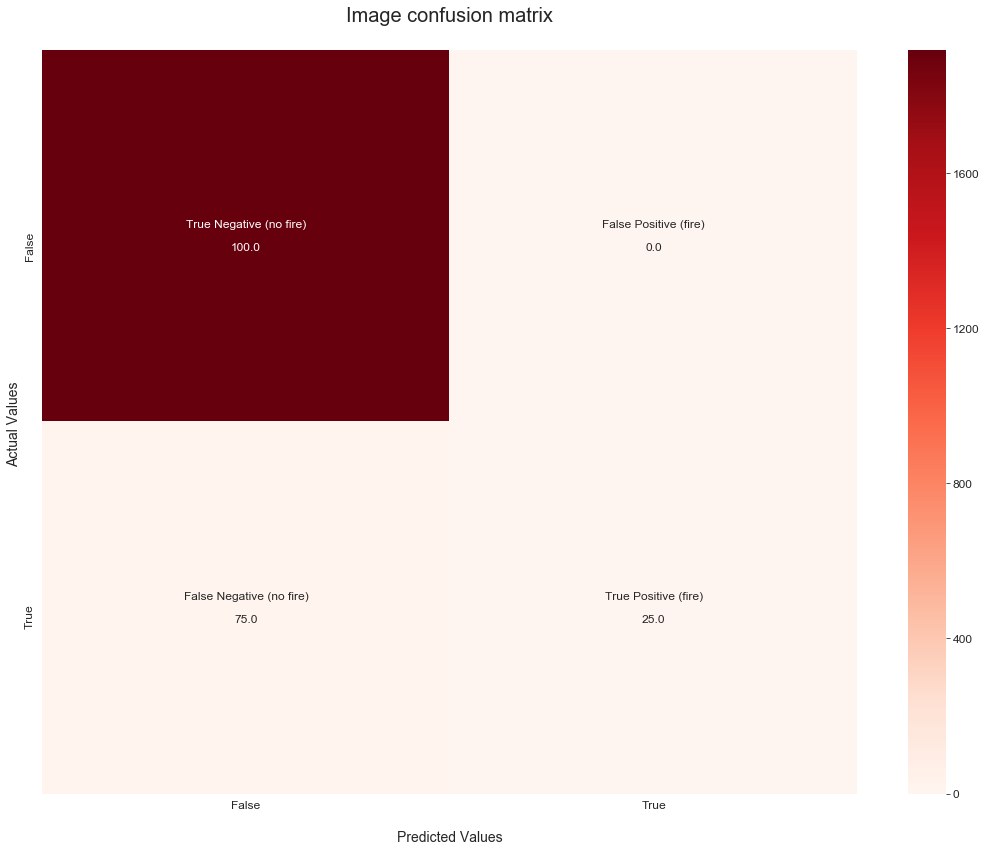

units dropouts optimizers    losses accuracies      aucs precisions  \
38    16      0.7       adam  0.709938   0.496124  0.465745   0.496124   

   recalls                                          histories epochs  \
38       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
38        0.413203

61/61 [==============================] - 6s 97ms/step
0.95
[([1], 0.846757), ([1], 0.8042645), ([1], 0.8904855), ([1], 0.8150693), ([1], 0.8762815), ([1], 0.8996444), ([1], 0.936183), ([1], 0.5203036), ([1], 0.49146655), ([1], 0.92067945)]
[([1], 0.8060374), ([1], 0.72275287), ([1], 0.89782566), ([1], 0.8490524), ([1], 0.8428148), ([1], 0.9003866), ([1], 0.93882436), ([1], 0.5332498), ([1], 0.51555824), ([1], 0.90553457)]


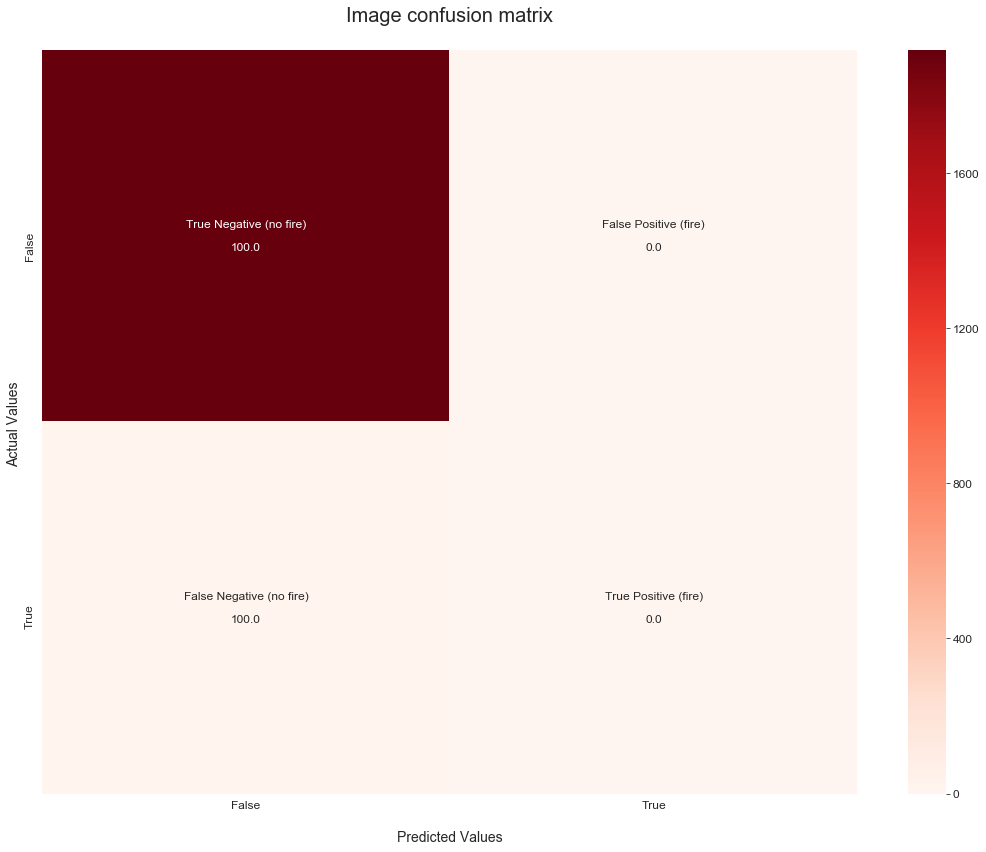

units dropouts optimizers    losses accuracies      aucs precisions  \
39    16      0.7      Nadam  0.689956   0.503876  0.761178          0   

   recalls                                          histories epochs  \
39       0  <keras.callbacks.History object at 0x000002B03...      2   

   best thresholds  
39        0.517417

61/61 [==============================] - 7s 96ms/step
0.1
[([1], 0.95565724), ([1], 0.8975674), ([1], 0.951397), ([1], 0.92096996), ([1], 0.93605196), ([1], 0.9730181), ([1], 0.98344964), ([1], 0.62073594), ([1], 0.5016006), ([1], 0.9429632)]
[([1], 0.93538356), ([1], 0.81423664), ([1], 0.95652986), ([1], 0.9483722), ([1], 0.9129093), ([1], 0.97517216), ([1], 0.98491585), ([1], 0.60784835), ([1], 0.4946117), ([1], 0.9354038)]


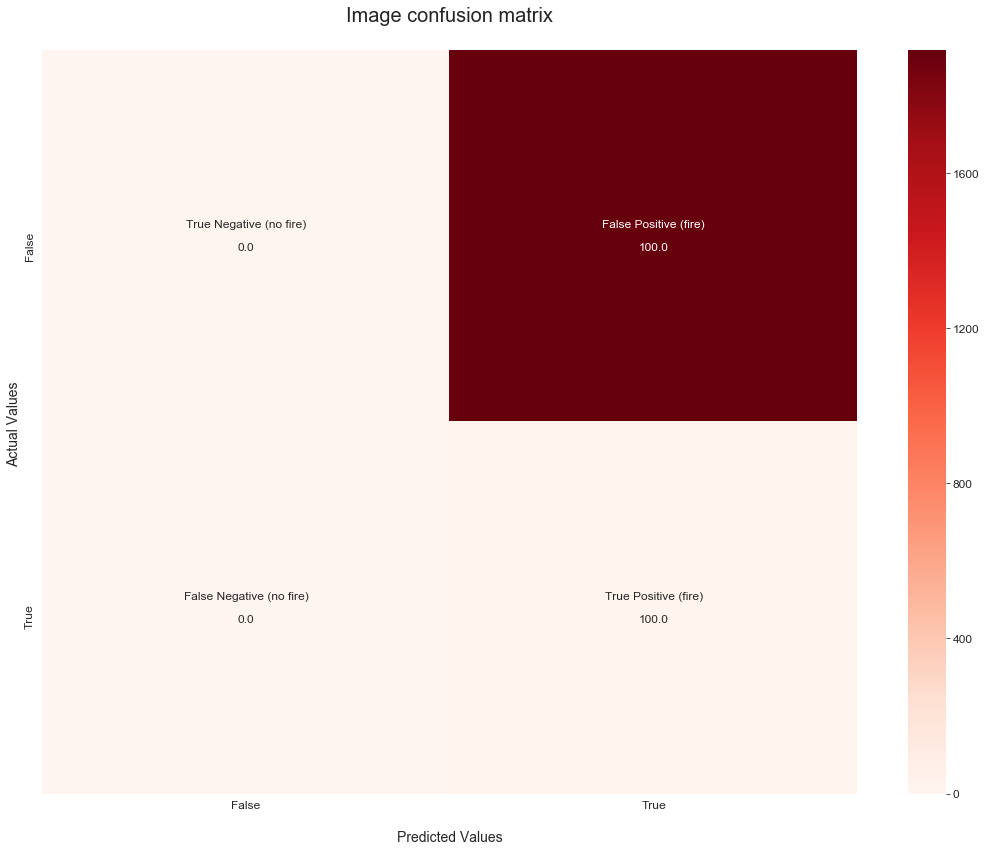

units dropouts optimizers    losses accuracies      aucs precisions  \
39    16      0.7      Nadam  0.689956   0.503876  0.761178          0   

   recalls                                          histories epochs  \
39       0  <keras.callbacks.History object at 0x000002B03...      2   

   best thresholds  
39        0.517417

61/61 [==============================] - 6s 98ms/step
0.3
[([1], 0.95565724), ([1], 0.8975674), ([1], 0.951397), ([1], 0.92096996), ([1], 0.93605196), ([1], 0.9730181), ([1], 0.98344964), ([1], 0.62073594), ([1], 0.5016006), ([1], 0.9429632)]
[([1], 0.93538356), ([1], 0.81423664), ([1], 0.95652986), ([1], 0.9483722), ([1], 0.9129093), ([1], 0.97517216), ([1], 0.98491585), ([1], 0.60784835), ([1], 0.4946117), ([1], 0.9354038)]


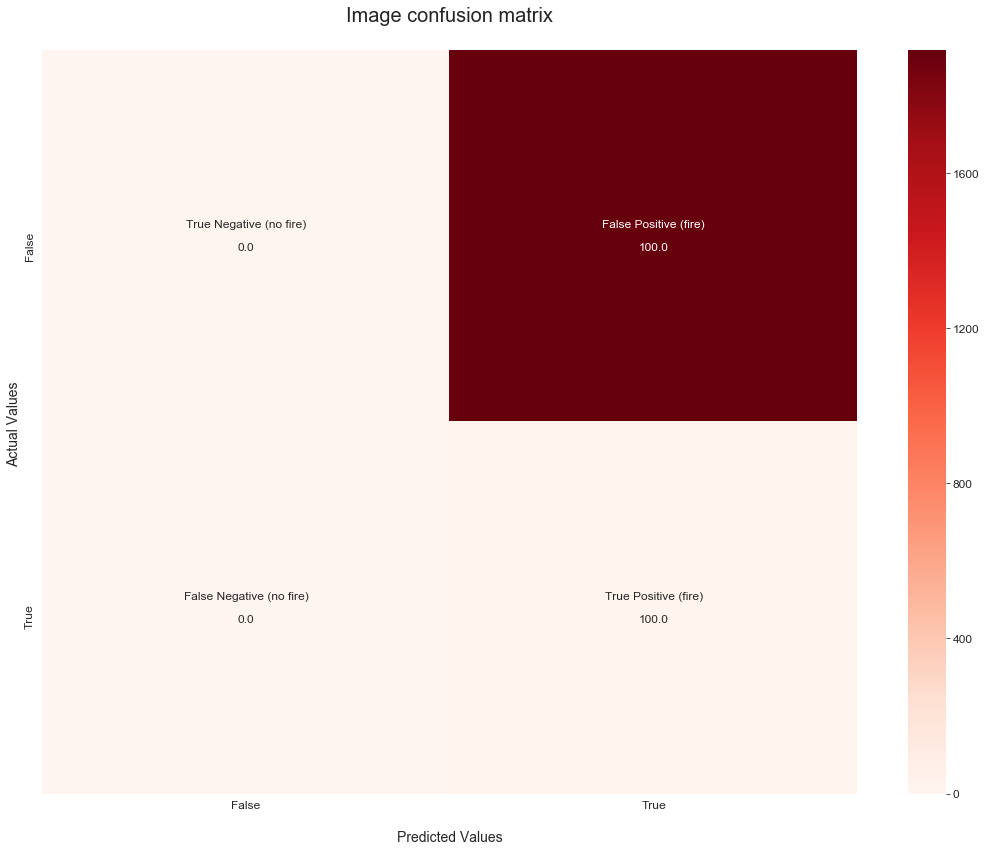

units dropouts optimizers    losses accuracies      aucs precisions  \
39    16      0.7      Nadam  0.689956   0.503876  0.761178          0   

   recalls                                          histories epochs  \
39       0  <keras.callbacks.History object at 0x000002B03...      2   

   best thresholds  
39        0.517417

61/61 [==============================] - 6s 96ms/step
0.5
[([1], 0.95565724), ([1], 0.8975674), ([1], 0.951397), ([1], 0.92096996), ([1], 0.93605196), ([1], 0.9730181), ([1], 0.98344964), ([1], 0.62073594), ([1], 0.5016006), ([1], 0.9429632)]
[([1], 0.93538356), ([1], 0.81423664), ([1], 0.95652986), ([1], 0.9483722), ([1], 0.9129093), ([1], 0.97517216), ([1], 0.98491585), ([1], 0.60784835), ([1], 0.4946117), ([1], 0.9354038)]


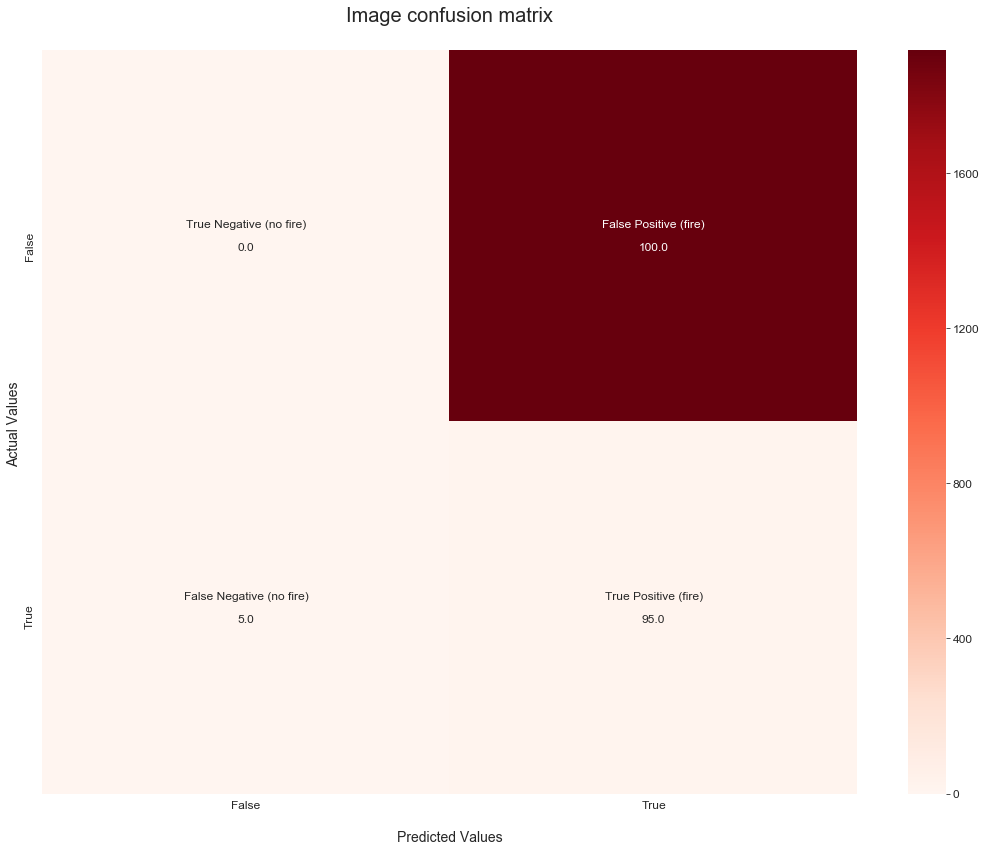

units dropouts optimizers    losses accuracies      aucs precisions  \
39    16      0.7      Nadam  0.689956   0.503876  0.761178          0   

   recalls                                          histories epochs  \
39       0  <keras.callbacks.History object at 0x000002B03...      2   

   best thresholds  
39        0.517417

61/61 [==============================] - 6s 96ms/step
0.65
[([1], 0.95565724), ([1], 0.8975674), ([1], 0.951397), ([1], 0.92096996), ([1], 0.93605196), ([1], 0.9730181), ([1], 0.98344964), ([1], 0.62073594), ([1], 0.5016006), ([1], 0.9429632)]
[([1], 0.93538356), ([1], 0.81423664), ([1], 0.95652986), ([1], 0.9483722), ([1], 0.9129093), ([1], 0.97517216), ([1], 0.98491585), ([1], 0.60784835), ([1], 0.4946117), ([1], 0.9354038)]


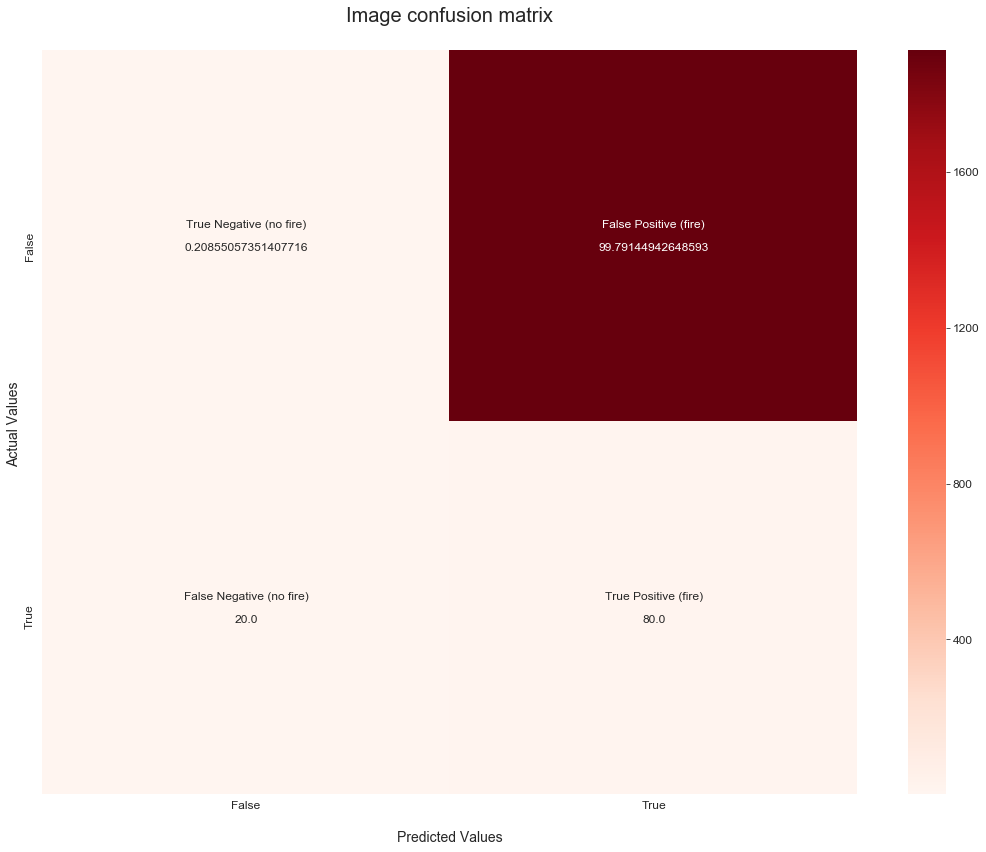

units dropouts optimizers    losses accuracies      aucs precisions  \
39    16      0.7      Nadam  0.689956   0.503876  0.761178          0   

   recalls                                          histories epochs  \
39       0  <keras.callbacks.History object at 0x000002B03...      2   

   best thresholds  
39        0.517417

61/61 [==============================] - 6s 97ms/step
0.725
[([1], 0.95565724), ([1], 0.8975674), ([1], 0.951397), ([1], 0.92096996), ([1], 0.93605196), ([1], 0.9730181), ([1], 0.98344964), ([1], 0.62073594), ([1], 0.5016006), ([1], 0.9429632)]
[([1], 0.93538356), ([1], 0.81423664), ([1], 0.95652986), ([1], 0.9483722), ([1], 0.9129093), ([1], 0.97517216), ([1], 0.98491585), ([1], 0.60784835), ([1], 0.4946117), ([1], 0.9354038)]


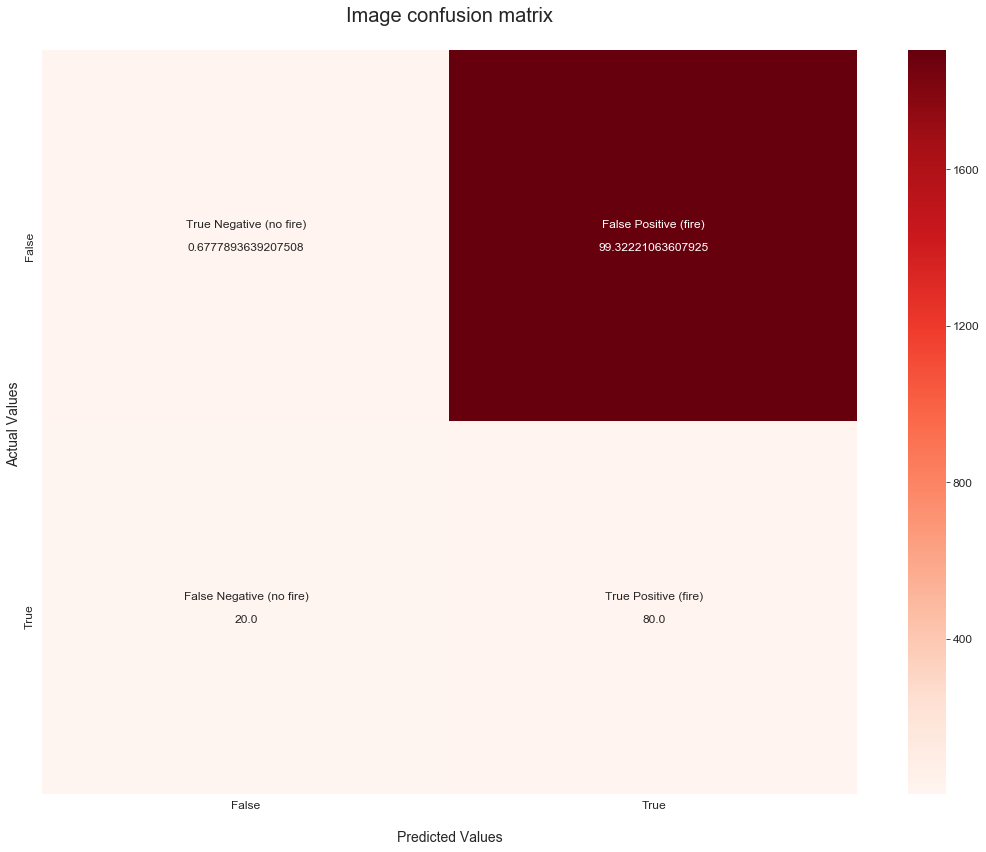

units dropouts optimizers    losses accuracies      aucs precisions  \
39    16      0.7      Nadam  0.689956   0.503876  0.761178          0   

   recalls                                          histories epochs  \
39       0  <keras.callbacks.History object at 0x000002B03...      2   

   best thresholds  
39        0.517417

61/61 [==============================] - 7s 101ms/step
0.8
[([1], 0.95565724), ([1], 0.8975674), ([1], 0.951397), ([1], 0.92096996), ([1], 0.93605196), ([1], 0.9730181), ([1], 0.98344964), ([1], 0.62073594), ([1], 0.5016006), ([1], 0.9429632)]
[([1], 0.93538356), ([1], 0.81423664), ([1], 0.95652986), ([1], 0.9483722), ([1], 0.9129093), ([1], 0.97517216), ([1], 0.98491585), ([1], 0.60784835), ([1], 0.4946117), ([1], 0.9354038)]


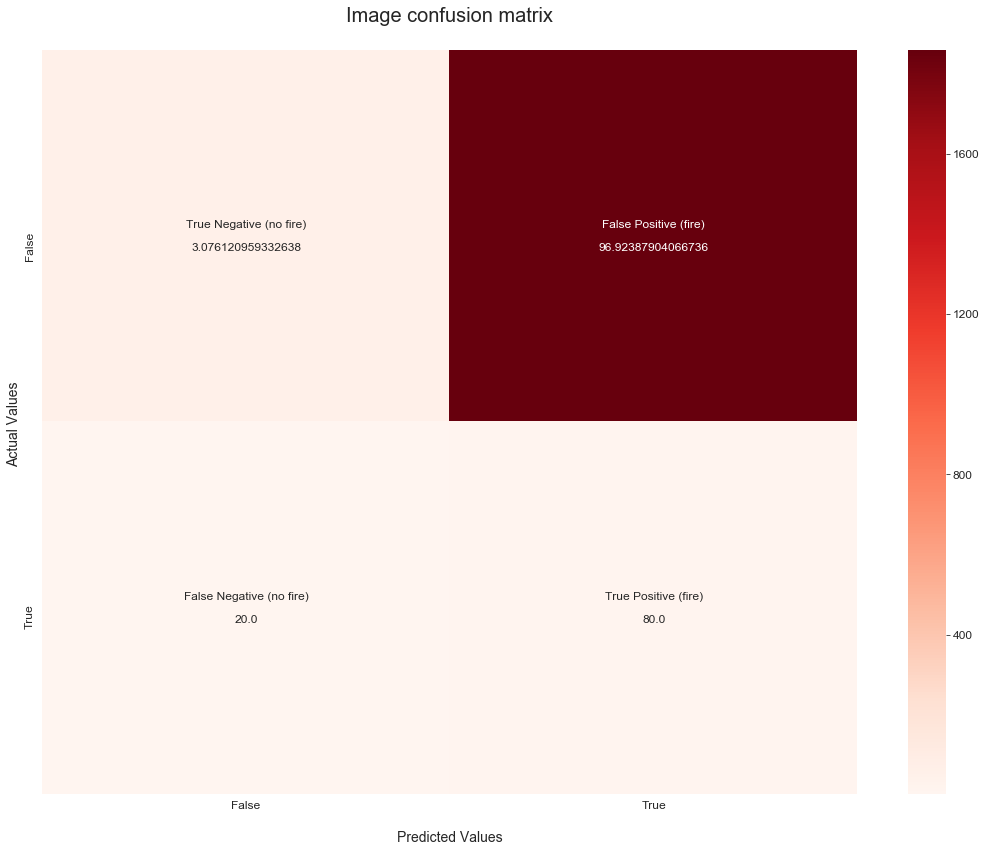

units dropouts optimizers    losses accuracies      aucs precisions  \
39    16      0.7      Nadam  0.689956   0.503876  0.761178          0   

   recalls                                          histories epochs  \
39       0  <keras.callbacks.History object at 0x000002B03...      2   

   best thresholds  
39        0.517417

61/61 [==============================] - 6s 98ms/step
0.85
[([1], 0.95565724), ([1], 0.8975674), ([1], 0.951397), ([1], 0.92096996), ([1], 0.93605196), ([1], 0.9730181), ([1], 0.98344964), ([1], 0.62073594), ([1], 0.5016006), ([1], 0.9429632)]
[([1], 0.93538356), ([1], 0.81423664), ([1], 0.95652986), ([1], 0.9483722), ([1], 0.9129093), ([1], 0.97517216), ([1], 0.98491585), ([1], 0.60784835), ([1], 0.4946117), ([1], 0.9354038)]


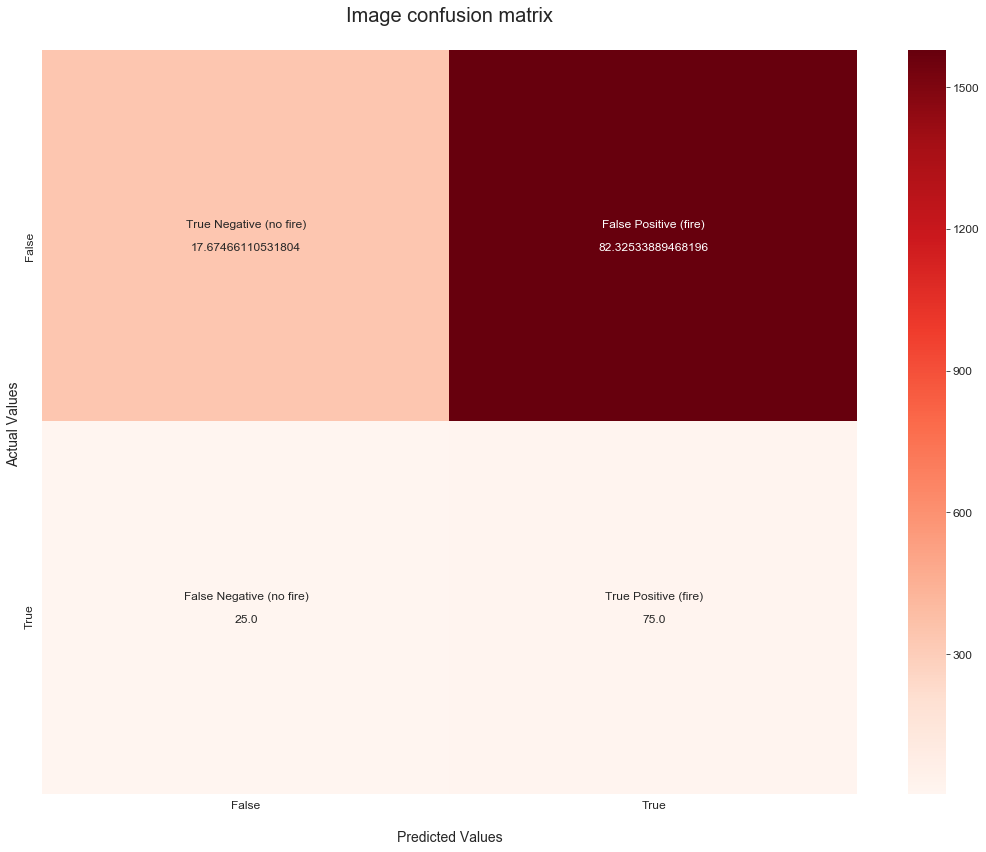

units dropouts optimizers    losses accuracies      aucs precisions  \
39    16      0.7      Nadam  0.689956   0.503876  0.761178          0   

   recalls                                          histories epochs  \
39       0  <keras.callbacks.History object at 0x000002B03...      2   

   best thresholds  
39        0.517417

61/61 [==============================] - 6s 98ms/step
0.9
[([1], 0.95565724), ([1], 0.8975674), ([1], 0.951397), ([1], 0.92096996), ([1], 0.93605196), ([1], 0.9730181), ([1], 0.98344964), ([1], 0.62073594), ([1], 0.5016006), ([1], 0.9429632)]
[([1], 0.93538356), ([1], 0.81423664), ([1], 0.95652986), ([1], 0.9483722), ([1], 0.9129093), ([1], 0.97517216), ([1], 0.98491585), ([1], 0.60784835), ([1], 0.4946117), ([1], 0.9354038)]


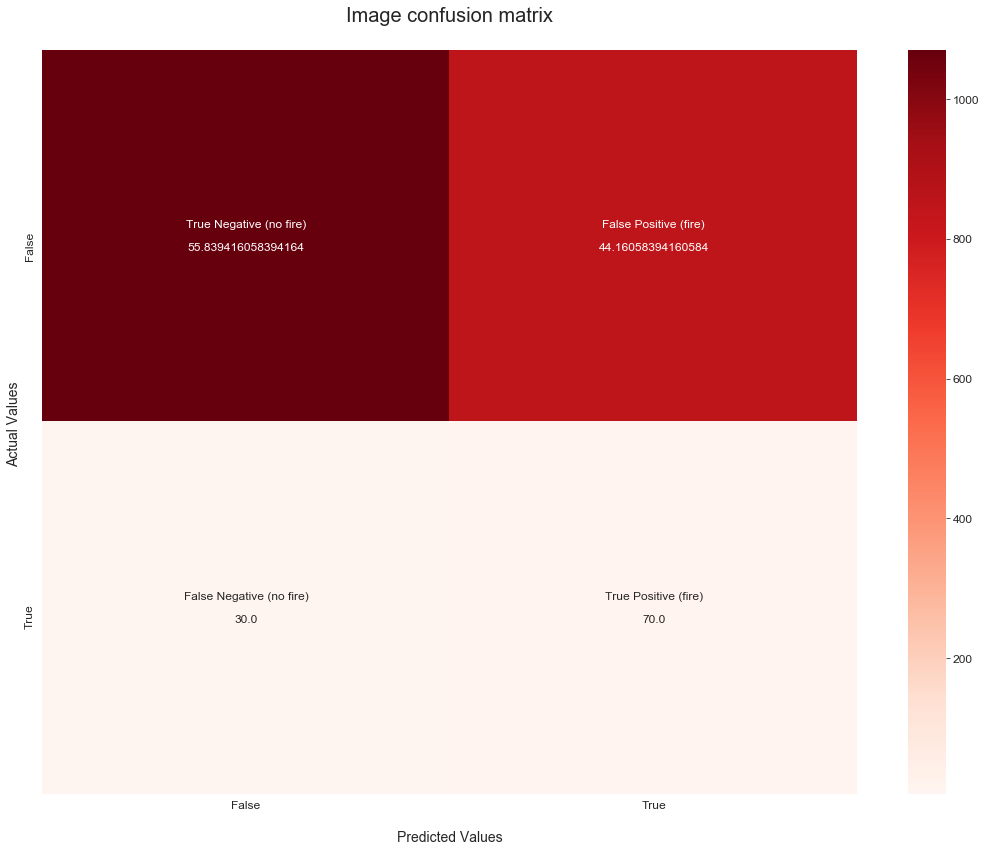

units dropouts optimizers    losses accuracies      aucs precisions  \
39    16      0.7      Nadam  0.689956   0.503876  0.761178          0   

   recalls                                          histories epochs  \
39       0  <keras.callbacks.History object at 0x000002B03...      2   

   best thresholds  
39        0.517417

61/61 [==============================] - 7s 100ms/step
0.95
[([1], 0.95565724), ([1], 0.8975674), ([1], 0.951397), ([1], 0.92096996), ([1], 0.93605196), ([1], 0.9730181), ([1], 0.98344964), ([1], 0.62073594), ([1], 0.5016006), ([1], 0.9429632)]
[([1], 0.93538356), ([1], 0.81423664), ([1], 0.95652986), ([1], 0.9483722), ([1], 0.9129093), ([1], 0.97517216), ([1], 0.98491585), ([1], 0.60784835), ([1], 0.4946117), ([1], 0.9354038)]


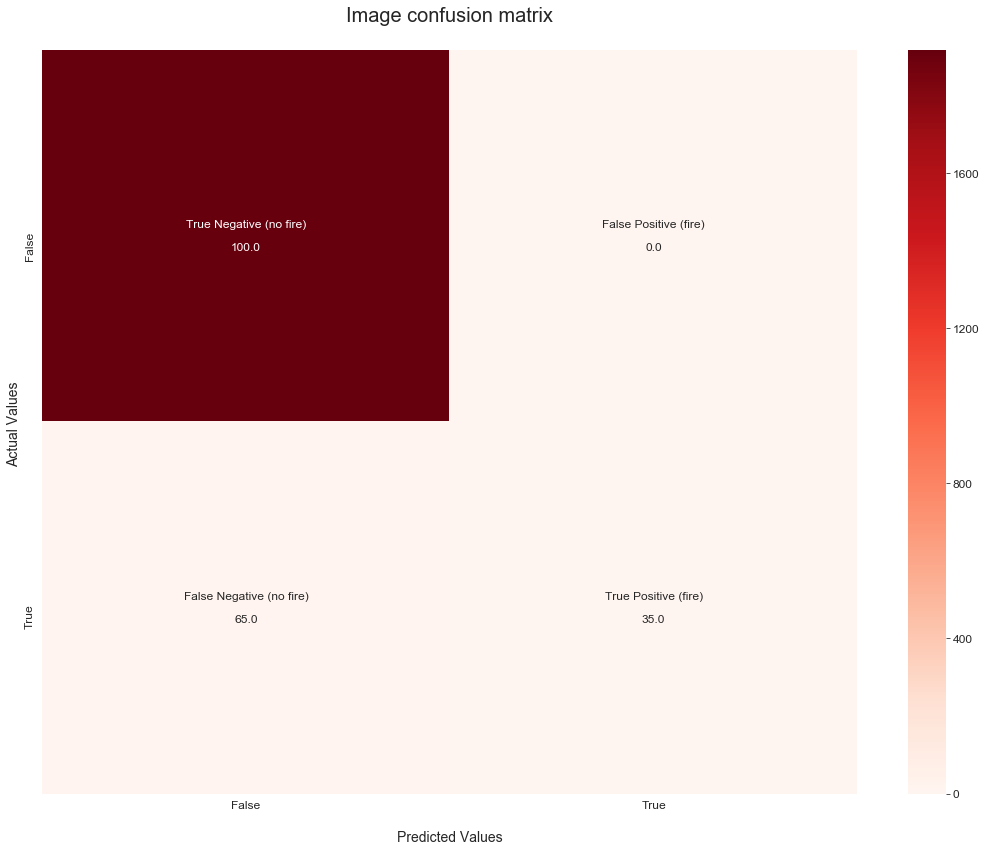

units dropouts optimizers    losses accuracies      aucs precisions  \
40    16      0.7    RMSprop  0.697077   0.496124  0.642909   0.496124   

   recalls                                          histories epochs  \
40       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
40        0.448611

61/61 [==============================] - 7s 96ms/step
0.1
[([1], 0.93531203), ([1], 0.87032247), ([1], 0.9418273), ([1], 0.8663853), ([1], 0.9377097), ([1], 0.9507264), ([1], 0.98503715), ([1], 0.47297892), ([1], 0.4186606), ([1], 0.98232055)]
[([1], 0.8938206), ([1], 0.76674056), ([1], 0.9479333), ([1], 0.9359212), ([1], 0.90083903), ([1], 0.96259546), ([1], 0.9867096), ([1], 0.46084478), ([1], 0.41562605), ([1], 0.9764744)]


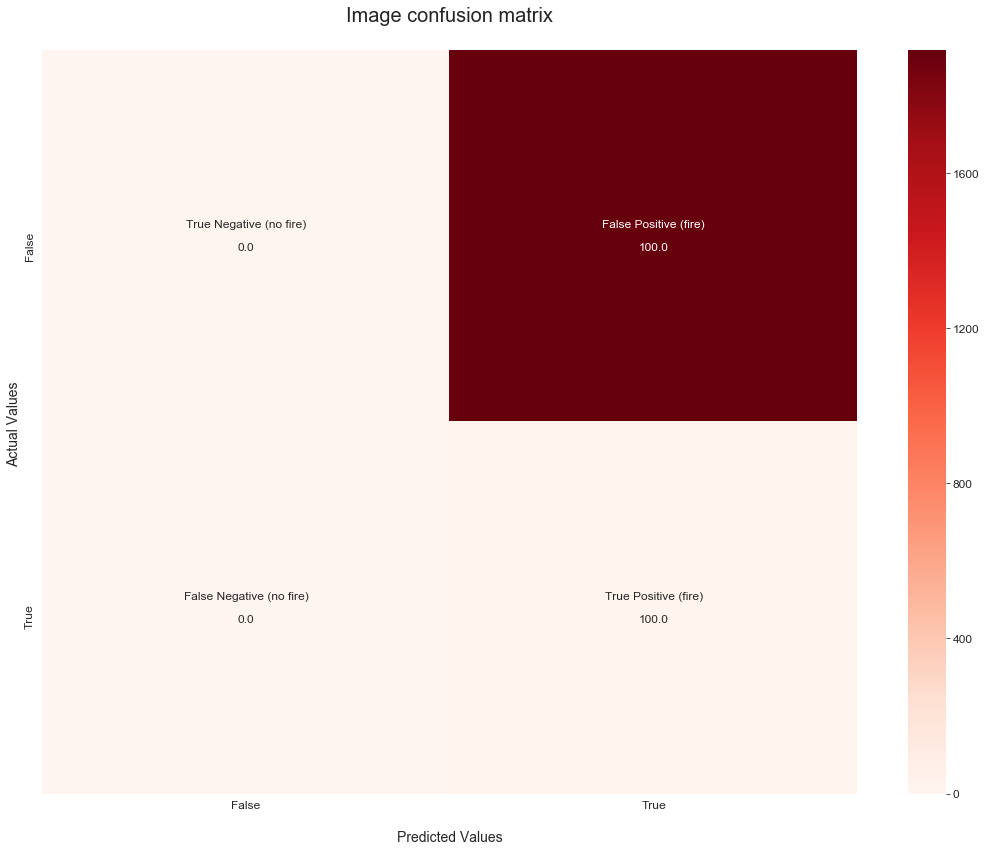

units dropouts optimizers    losses accuracies      aucs precisions  \
40    16      0.7    RMSprop  0.697077   0.496124  0.642909   0.496124   

   recalls                                          histories epochs  \
40       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
40        0.448611

61/61 [==============================] - 6s 97ms/step
0.3
[([1], 0.93531203), ([1], 0.87032247), ([1], 0.9418273), ([1], 0.8663853), ([1], 0.9377097), ([1], 0.9507264), ([1], 0.98503715), ([1], 0.47297892), ([1], 0.4186606), ([1], 0.98232055)]
[([1], 0.8938206), ([1], 0.76674056), ([1], 0.9479333), ([1], 0.9359212), ([1], 0.90083903), ([1], 0.96259546), ([1], 0.9867096), ([1], 0.46084478), ([1], 0.41562605), ([1], 0.9764744)]


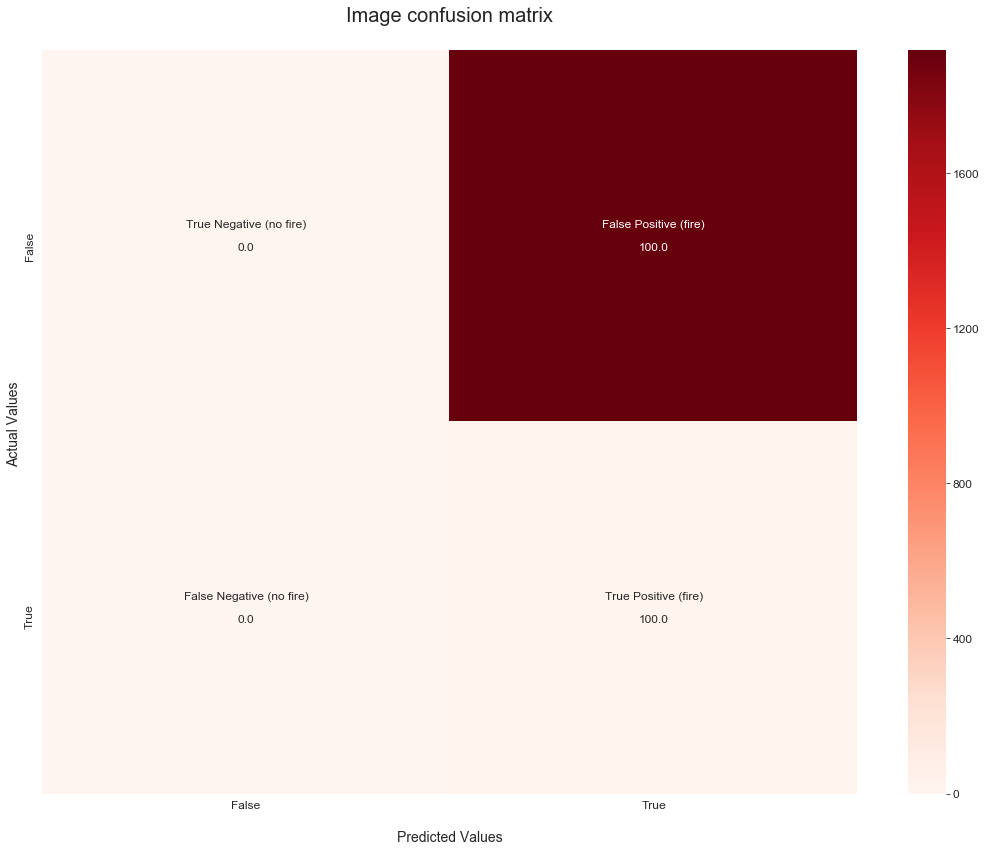

units dropouts optimizers    losses accuracies      aucs precisions  \
40    16      0.7    RMSprop  0.697077   0.496124  0.642909   0.496124   

   recalls                                          histories epochs  \
40       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
40        0.448611

61/61 [==============================] - 6s 96ms/step
0.5
[([1], 0.93531203), ([1], 0.87032247), ([1], 0.9418273), ([1], 0.8663853), ([1], 0.9377097), ([1], 0.9507264), ([1], 0.98503715), ([1], 0.47297892), ([1], 0.4186606), ([1], 0.98232055)]
[([1], 0.8938206), ([1], 0.76674056), ([1], 0.9479333), ([1], 0.9359212), ([1], 0.90083903), ([1], 0.96259546), ([1], 0.9867096), ([1], 0.46084478), ([1], 0.41562605), ([1], 0.9764744)]


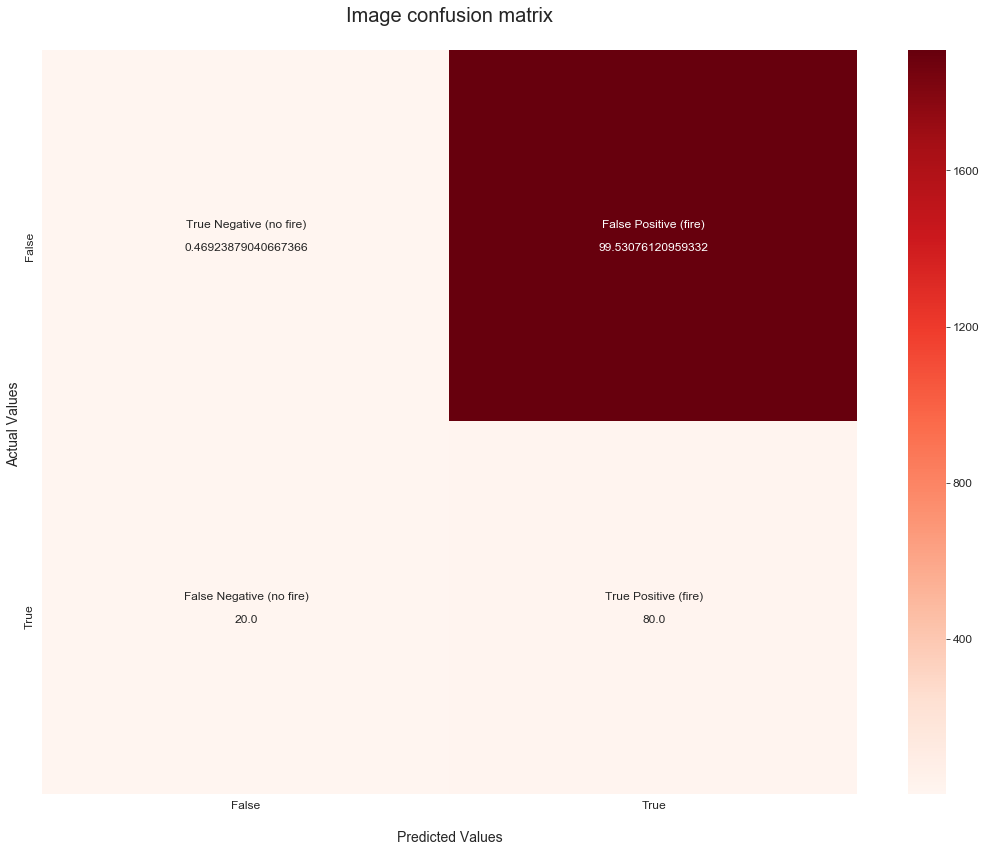

units dropouts optimizers    losses accuracies      aucs precisions  \
40    16      0.7    RMSprop  0.697077   0.496124  0.642909   0.496124   

   recalls                                          histories epochs  \
40       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
40        0.448611

61/61 [==============================] - 6s 97ms/step
0.65
[([1], 0.93531203), ([1], 0.87032247), ([1], 0.9418273), ([1], 0.8663853), ([1], 0.9377097), ([1], 0.9507264), ([1], 0.98503715), ([1], 0.47297892), ([1], 0.4186606), ([1], 0.98232055)]
[([1], 0.8938206), ([1], 0.76674056), ([1], 0.9479333), ([1], 0.9359212), ([1], 0.90083903), ([1], 0.96259546), ([1], 0.9867096), ([1], 0.46084478), ([1], 0.41562605), ([1], 0.9764744)]


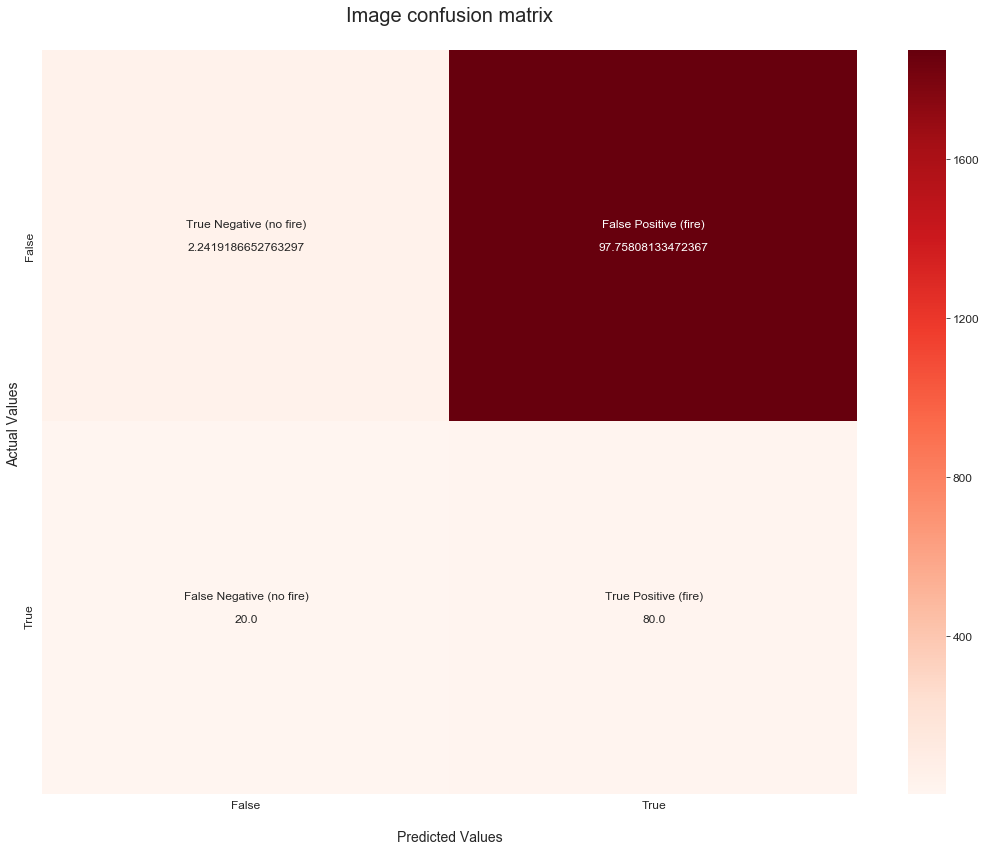

units dropouts optimizers    losses accuracies      aucs precisions  \
40    16      0.7    RMSprop  0.697077   0.496124  0.642909   0.496124   

   recalls                                          histories epochs  \
40       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
40        0.448611

61/61 [==============================] - 6s 96ms/step
0.725
[([1], 0.93531203), ([1], 0.87032247), ([1], 0.9418273), ([1], 0.8663853), ([1], 0.9377097), ([1], 0.9507264), ([1], 0.98503715), ([1], 0.47297892), ([1], 0.4186606), ([1], 0.98232055)]
[([1], 0.8938206), ([1], 0.76674056), ([1], 0.9479333), ([1], 0.9359212), ([1], 0.90083903), ([1], 0.96259546), ([1], 0.9867096), ([1], 0.46084478), ([1], 0.41562605), ([1], 0.9764744)]


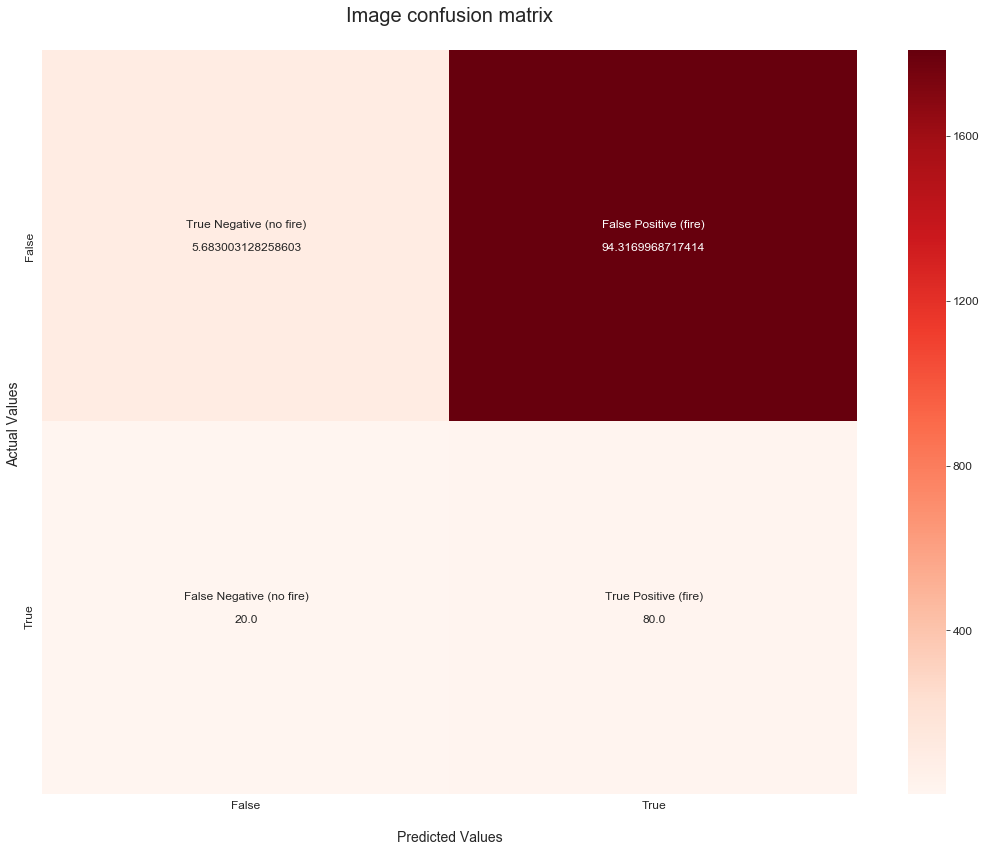

units dropouts optimizers    losses accuracies      aucs precisions  \
40    16      0.7    RMSprop  0.697077   0.496124  0.642909   0.496124   

   recalls                                          histories epochs  \
40       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
40        0.448611

61/61 [==============================] - 6s 98ms/step
0.8
[([1], 0.93531203), ([1], 0.87032247), ([1], 0.9418273), ([1], 0.8663853), ([1], 0.9377097), ([1], 0.9507264), ([1], 0.98503715), ([1], 0.47297892), ([1], 0.4186606), ([1], 0.98232055)]
[([1], 0.8938206), ([1], 0.76674056), ([1], 0.9479333), ([1], 0.9359212), ([1], 0.90083903), ([1], 0.96259546), ([1], 0.9867096), ([1], 0.46084478), ([1], 0.41562605), ([1], 0.9764744)]


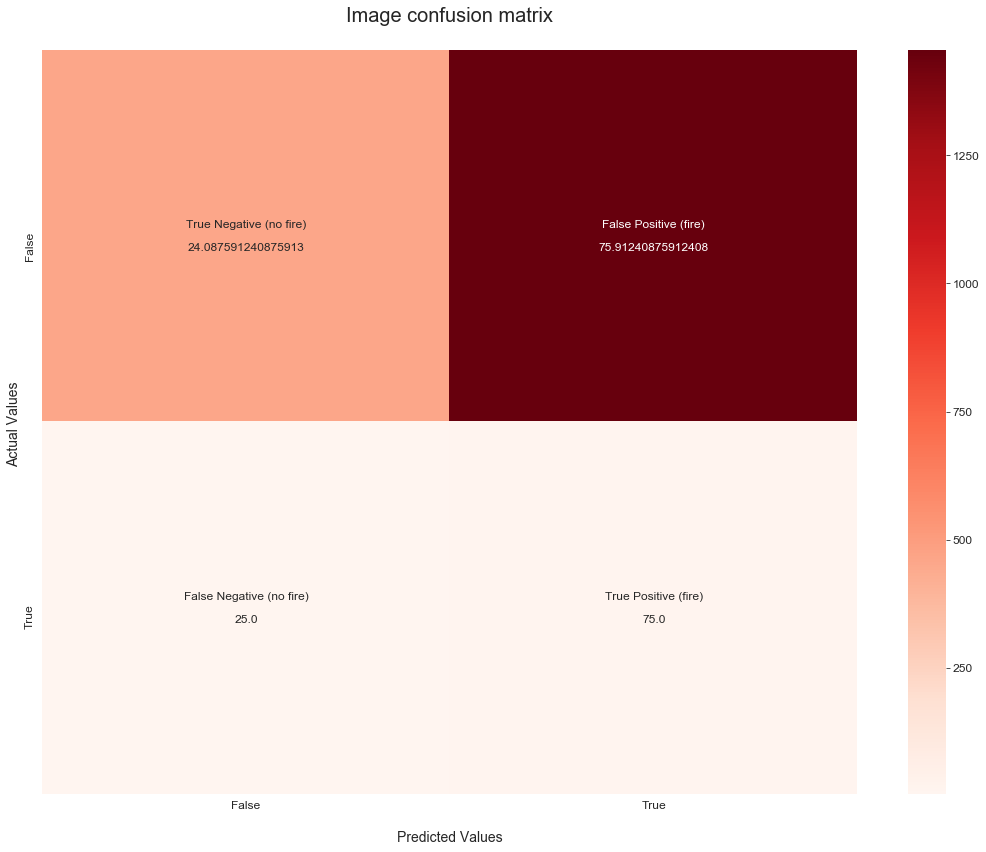

units dropouts optimizers    losses accuracies      aucs precisions  \
40    16      0.7    RMSprop  0.697077   0.496124  0.642909   0.496124   

   recalls                                          histories epochs  \
40       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
40        0.448611

61/61 [==============================] - 6s 98ms/step
0.85
[([1], 0.93531203), ([1], 0.87032247), ([1], 0.9418273), ([1], 0.8663853), ([1], 0.9377097), ([1], 0.9507264), ([1], 0.98503715), ([1], 0.47297892), ([1], 0.4186606), ([1], 0.98232055)]
[([1], 0.8938206), ([1], 0.76674056), ([1], 0.9479333), ([1], 0.9359212), ([1], 0.90083903), ([1], 0.96259546), ([1], 0.9867096), ([1], 0.46084478), ([1], 0.41562605), ([1], 0.9764744)]


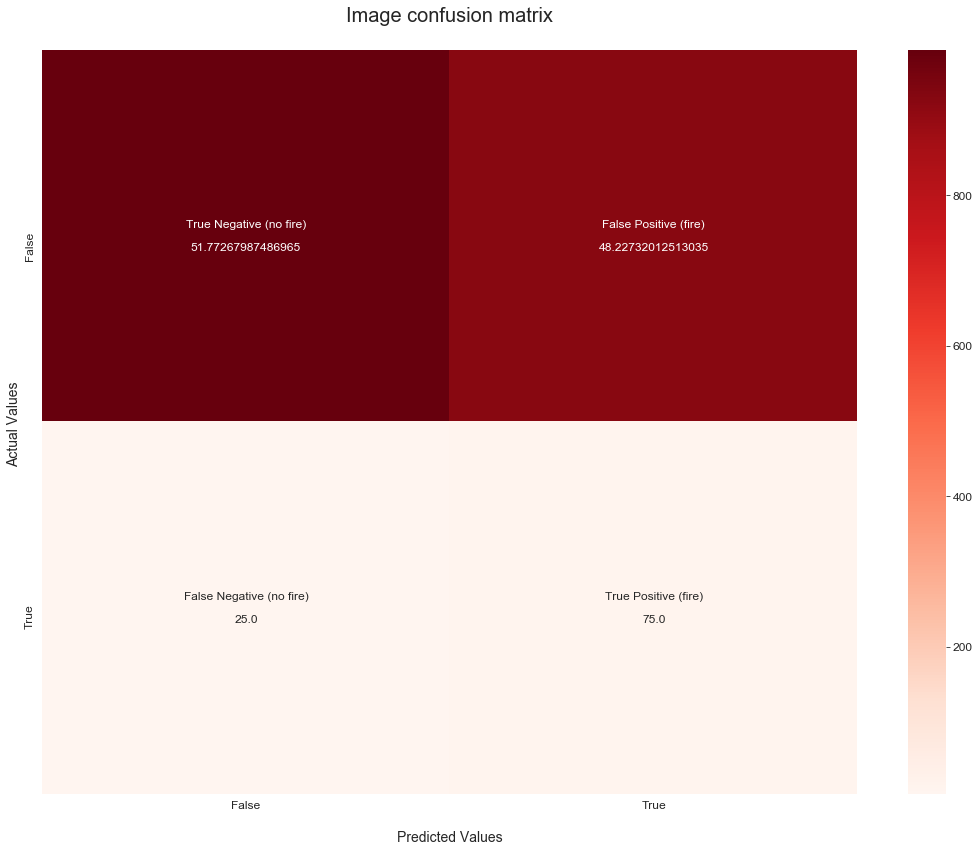

units dropouts optimizers    losses accuracies      aucs precisions  \
40    16      0.7    RMSprop  0.697077   0.496124  0.642909   0.496124   

   recalls                                          histories epochs  \
40       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
40        0.448611

61/61 [==============================] - 6s 96ms/step
0.9
[([1], 0.93531203), ([1], 0.87032247), ([1], 0.9418273), ([1], 0.8663853), ([1], 0.9377097), ([1], 0.9507264), ([1], 0.98503715), ([1], 0.47297892), ([1], 0.4186606), ([1], 0.98232055)]
[([1], 0.8938206), ([1], 0.76674056), ([1], 0.9479333), ([1], 0.9359212), ([1], 0.90083903), ([1], 0.96259546), ([1], 0.9867096), ([1], 0.46084478), ([1], 0.41562605), ([1], 0.9764744)]


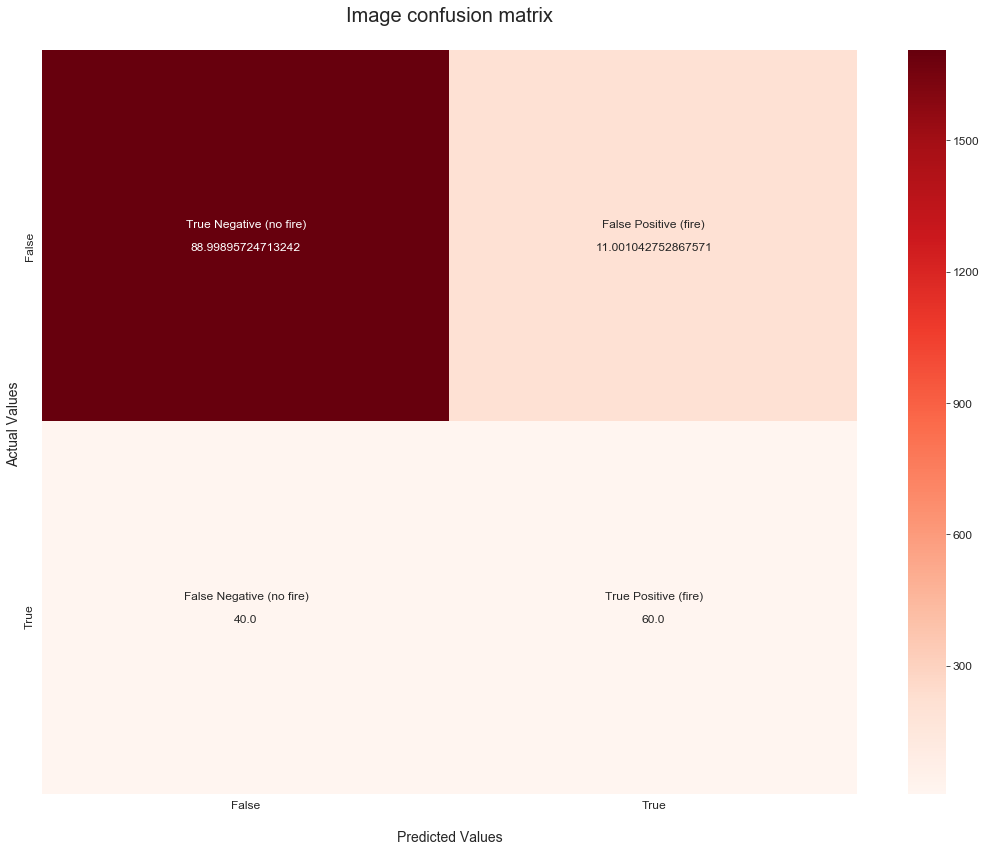

units dropouts optimizers    losses accuracies      aucs precisions  \
40    16      0.7    RMSprop  0.697077   0.496124  0.642909   0.496124   

   recalls                                          histories epochs  \
40       1  <keras.callbacks.History object at 0x000002B0B...      2   

   best thresholds  
40        0.448611

61/61 [==============================] - 6s 96ms/step
0.95
[([1], 0.93531203), ([1], 0.87032247), ([1], 0.9418273), ([1], 0.8663853), ([1], 0.9377097), ([1], 0.9507264), ([1], 0.98503715), ([1], 0.47297892), ([1], 0.4186606), ([1], 0.98232055)]
[([1], 0.8938206), ([1], 0.76674056), ([1], 0.9479333), ([1], 0.9359212), ([1], 0.90083903), ([1], 0.96259546), ([1], 0.9867096), ([1], 0.46084478), ([1], 0.41562605), ([1], 0.9764744)]


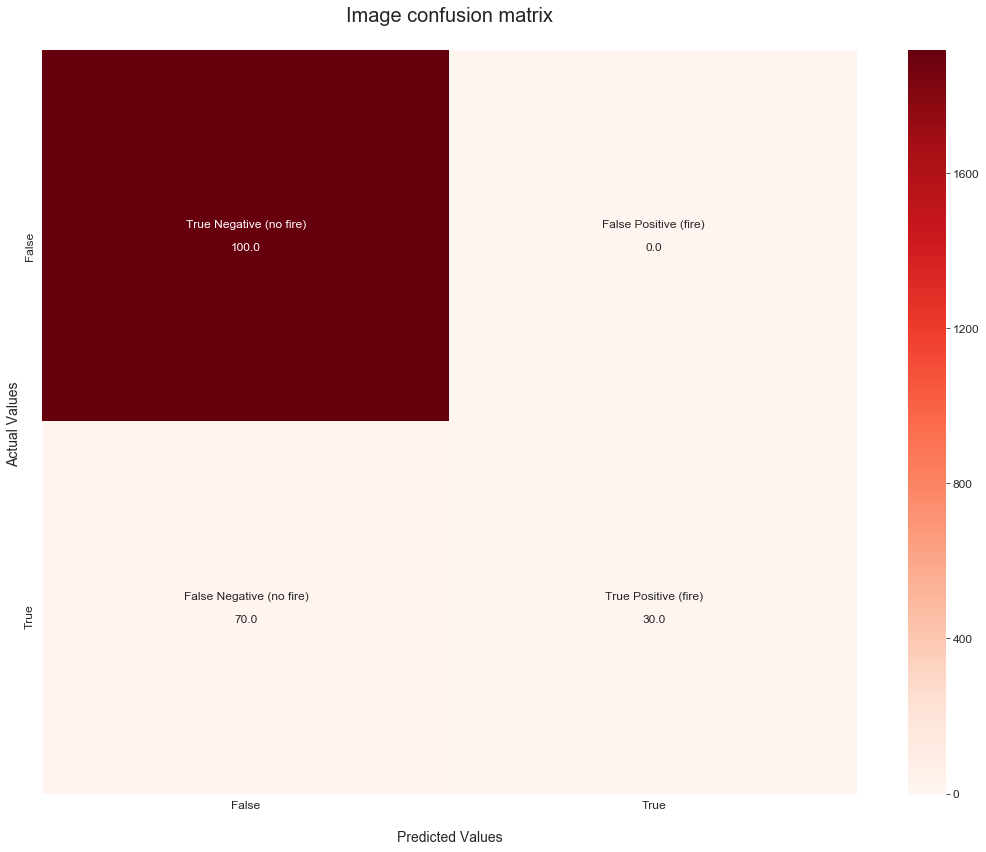

units dropouts optimizers    losses accuracies      aucs precisions  \
41    16      0.7       adam  0.693374   0.496124  0.501923   0.496124   

   recalls                                          histories epochs  \
41       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
41        0.493209

61/61 [==============================] - 7s 97ms/step
0.1
[([1], 0.9984387), ([1], 0.9689743), ([1], 0.9625261), ([1], 0.7465808), ([1], 0.99162173), ([1], 0.99705696), ([1], 0.99850786), ([1], 0.5276595), ([1], 0.39880198), ([1], 0.9970192)]
[([1], 0.9944904), ([1], 0.8384074), ([1], 0.9872972), ([1], 0.9817777), ([1], 0.9622808), ([1], 0.9975156), ([1], 0.99904525), ([1], 0.450011), ([1], 0.455867), ([1], 0.9958812)]


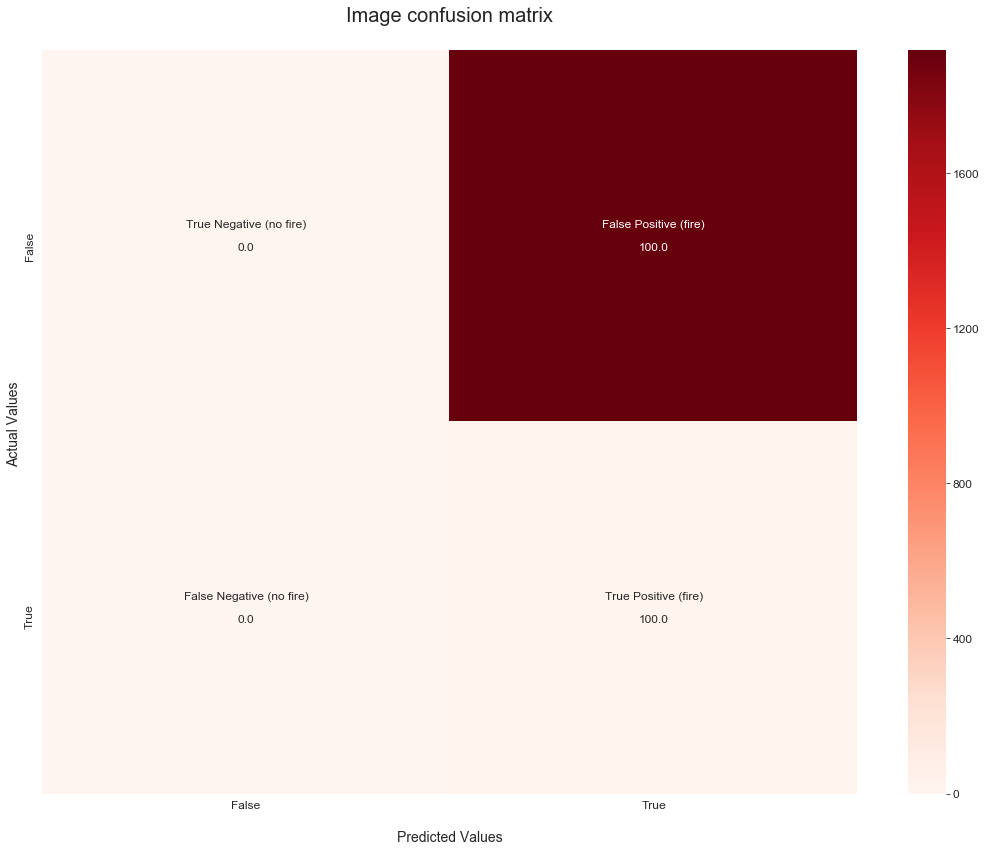

units dropouts optimizers    losses accuracies      aucs precisions  \
41    16      0.7       adam  0.693374   0.496124  0.501923   0.496124   

   recalls                                          histories epochs  \
41       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
41        0.493209

61/61 [==============================] - 6s 97ms/step
0.3
[([1], 0.9984387), ([1], 0.9689743), ([1], 0.9625261), ([1], 0.7465808), ([1], 0.99162173), ([1], 0.99705696), ([1], 0.99850786), ([1], 0.5276595), ([1], 0.39880198), ([1], 0.9970192)]
[([1], 0.9944904), ([1], 0.8384074), ([1], 0.9872972), ([1], 0.9817777), ([1], 0.9622808), ([1], 0.9975156), ([1], 0.99904525), ([1], 0.450011), ([1], 0.455867), ([1], 0.9958812)]


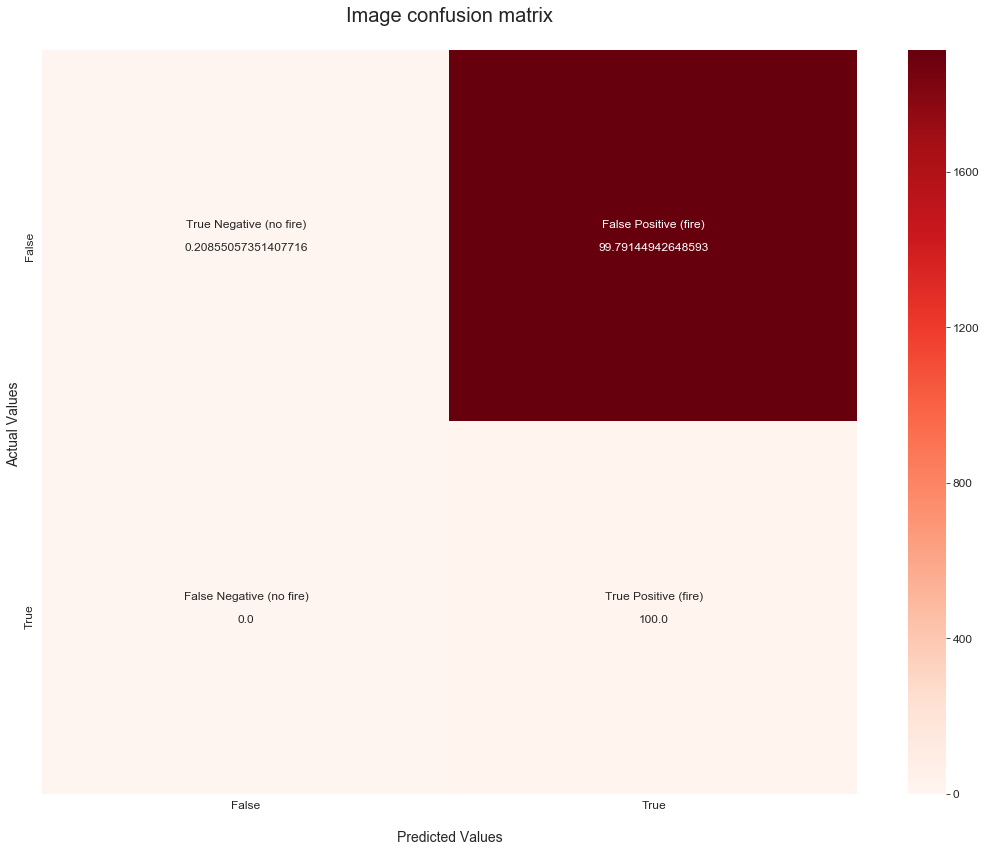

units dropouts optimizers    losses accuracies      aucs precisions  \
41    16      0.7       adam  0.693374   0.496124  0.501923   0.496124   

   recalls                                          histories epochs  \
41       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
41        0.493209

61/61 [==============================] - 6s 99ms/step
0.5
[([1], 0.9984387), ([1], 0.9689743), ([1], 0.9625261), ([1], 0.7465808), ([1], 0.99162173), ([1], 0.99705696), ([1], 0.99850786), ([1], 0.5276595), ([1], 0.39880198), ([1], 0.9970192)]
[([1], 0.9944904), ([1], 0.8384074), ([1], 0.9872972), ([1], 0.9817777), ([1], 0.9622808), ([1], 0.9975156), ([1], 0.99904525), ([1], 0.450011), ([1], 0.455867), ([1], 0.9958812)]


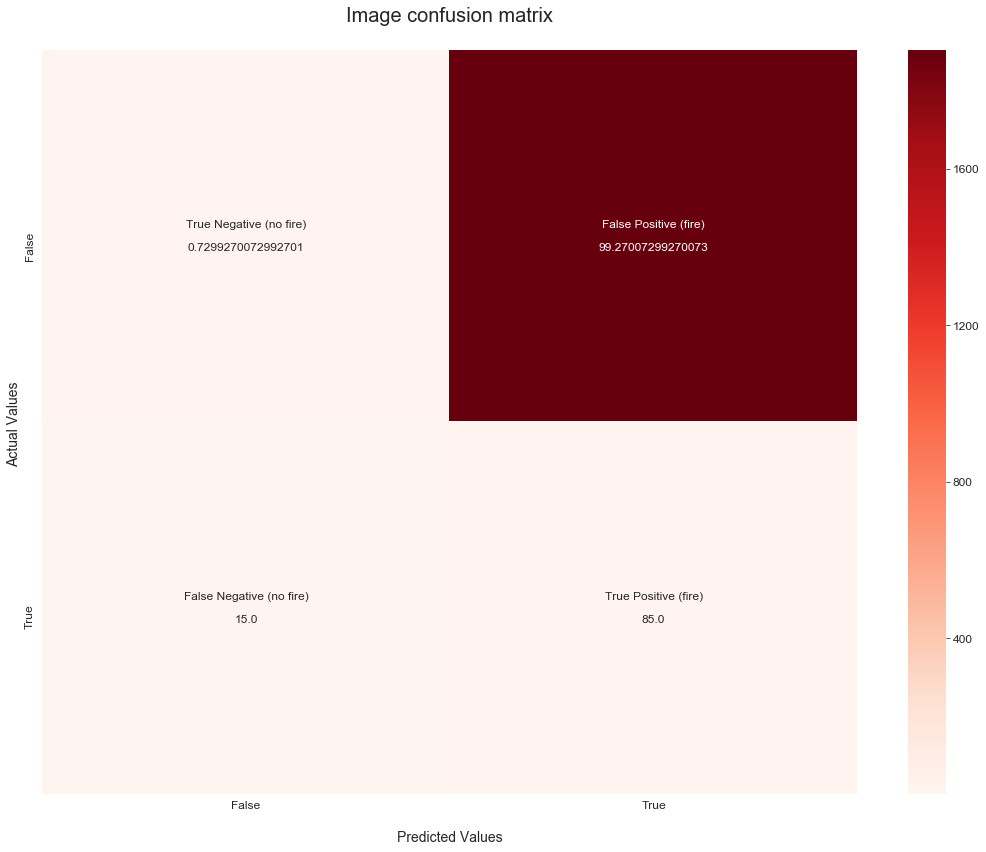

units dropouts optimizers    losses accuracies      aucs precisions  \
41    16      0.7       adam  0.693374   0.496124  0.501923   0.496124   

   recalls                                          histories epochs  \
41       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
41        0.493209

61/61 [==============================] - 6s 97ms/step
0.65
[([1], 0.9984387), ([1], 0.9689743), ([1], 0.9625261), ([1], 0.7465808), ([1], 0.99162173), ([1], 0.99705696), ([1], 0.99850786), ([1], 0.5276595), ([1], 0.39880198), ([1], 0.9970192)]
[([1], 0.9944904), ([1], 0.8384074), ([1], 0.9872972), ([1], 0.9817777), ([1], 0.9622808), ([1], 0.9975156), ([1], 0.99904525), ([1], 0.450011), ([1], 0.455867), ([1], 0.9958812)]


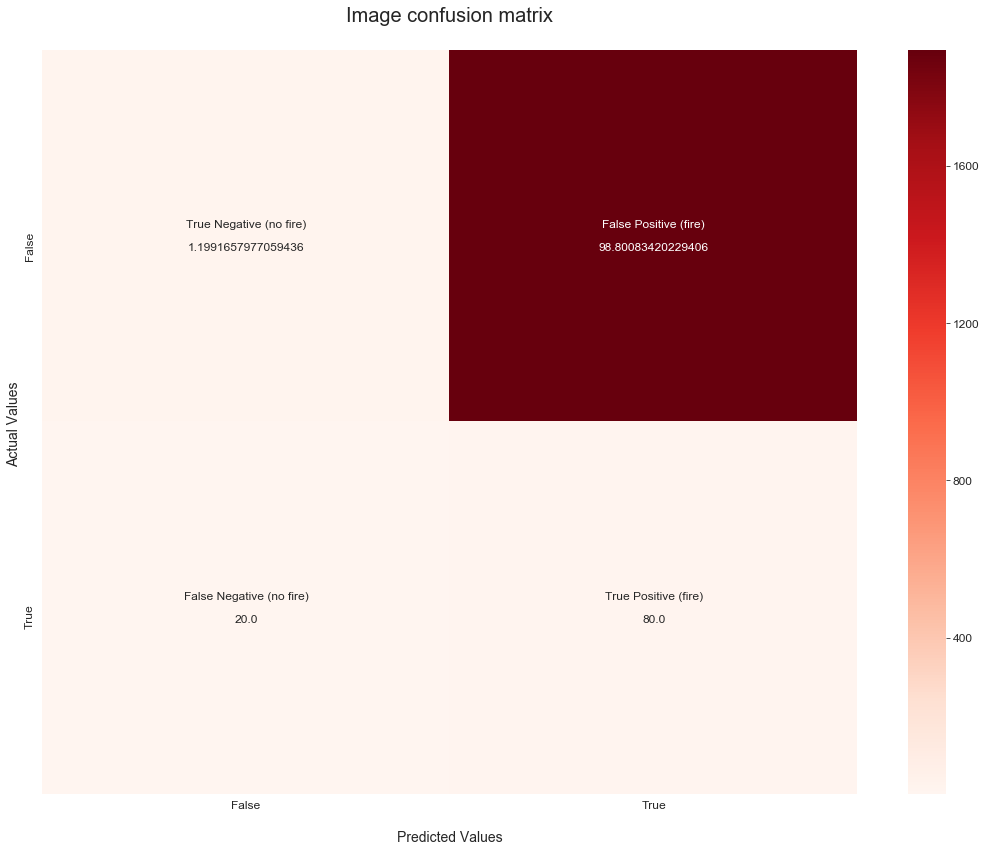

units dropouts optimizers    losses accuracies      aucs precisions  \
41    16      0.7       adam  0.693374   0.496124  0.501923   0.496124   

   recalls                                          histories epochs  \
41       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
41        0.493209

61/61 [==============================] - 6s 96ms/step
0.725
[([1], 0.9984387), ([1], 0.9689743), ([1], 0.9625261), ([1], 0.7465808), ([1], 0.99162173), ([1], 0.99705696), ([1], 0.99850786), ([1], 0.5276595), ([1], 0.39880198), ([1], 0.9970192)]
[([1], 0.9944904), ([1], 0.8384074), ([1], 0.9872972), ([1], 0.9817777), ([1], 0.9622808), ([1], 0.9975156), ([1], 0.99904525), ([1], 0.450011), ([1], 0.455867), ([1], 0.9958812)]


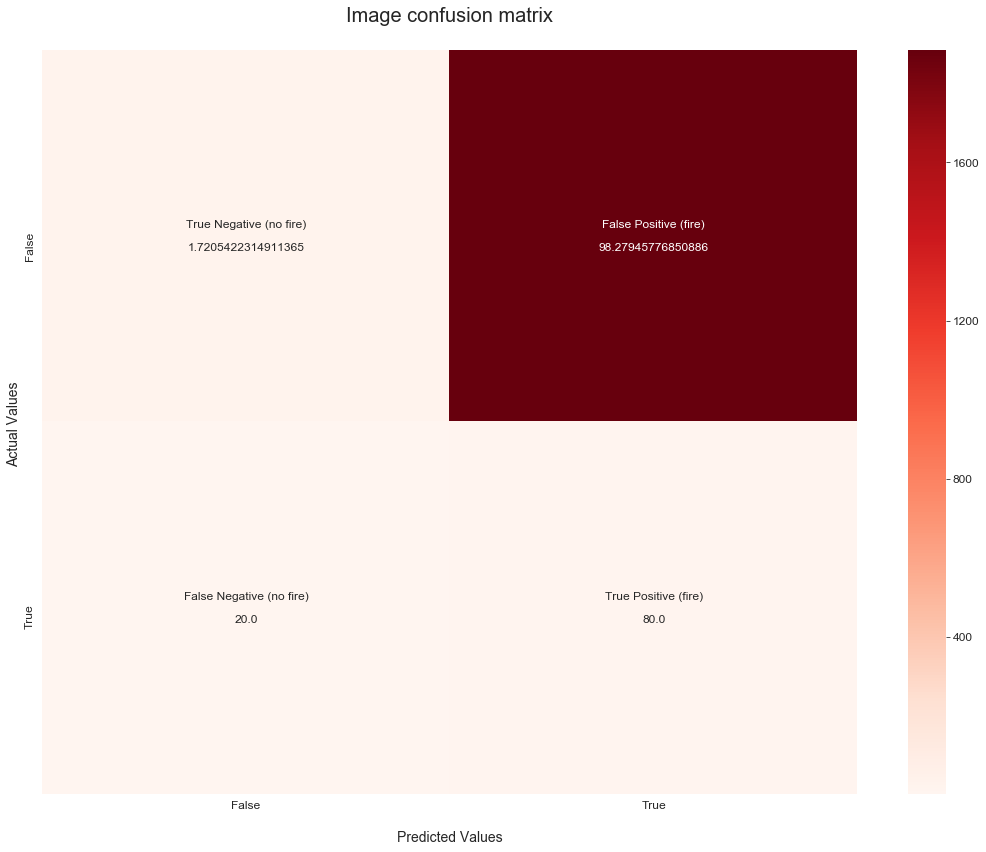

units dropouts optimizers    losses accuracies      aucs precisions  \
41    16      0.7       adam  0.693374   0.496124  0.501923   0.496124   

   recalls                                          histories epochs  \
41       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
41        0.493209

61/61 [==============================] - 6s 97ms/step
0.8
[([1], 0.9984387), ([1], 0.9689743), ([1], 0.9625261), ([1], 0.7465808), ([1], 0.99162173), ([1], 0.99705696), ([1], 0.99850786), ([1], 0.5276595), ([1], 0.39880198), ([1], 0.9970192)]
[([1], 0.9944904), ([1], 0.8384074), ([1], 0.9872972), ([1], 0.9817777), ([1], 0.9622808), ([1], 0.9975156), ([1], 0.99904525), ([1], 0.450011), ([1], 0.455867), ([1], 0.9958812)]


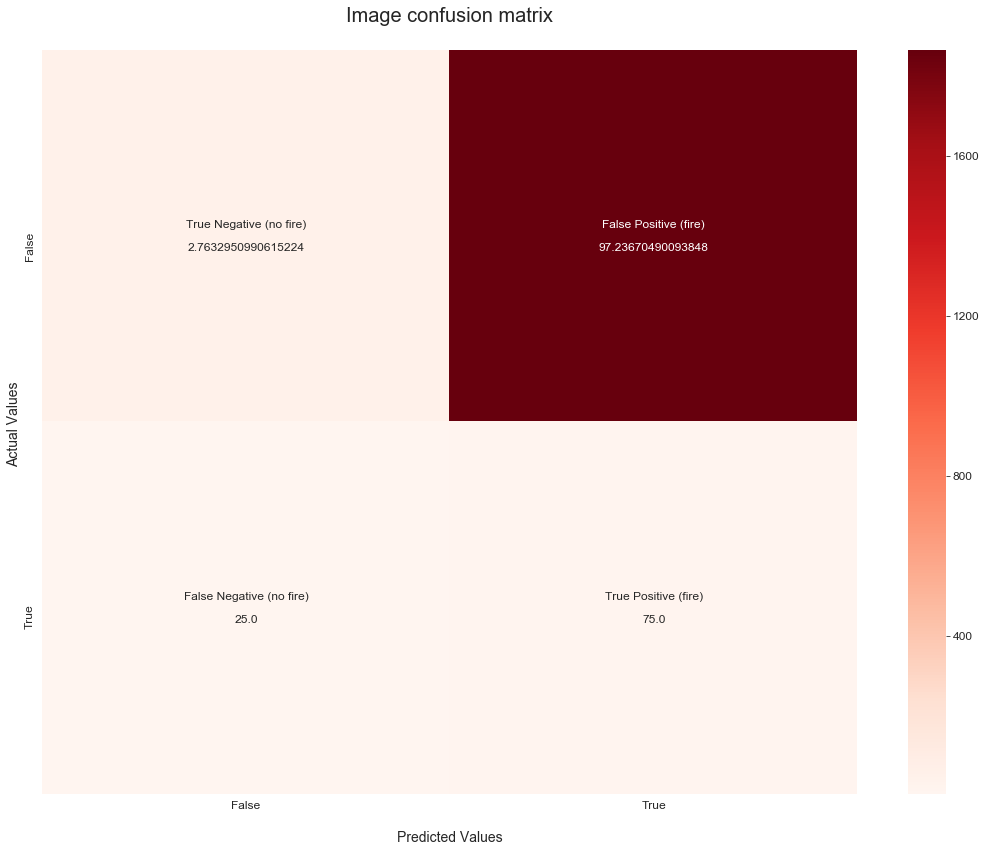

units dropouts optimizers    losses accuracies      aucs precisions  \
41    16      0.7       adam  0.693374   0.496124  0.501923   0.496124   

   recalls                                          histories epochs  \
41       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
41        0.493209

61/61 [==============================] - 6s 96ms/step
0.85
[([1], 0.9984387), ([1], 0.9689743), ([1], 0.9625261), ([1], 0.7465808), ([1], 0.99162173), ([1], 0.99705696), ([1], 0.99850786), ([1], 0.5276595), ([1], 0.39880198), ([1], 0.9970192)]
[([1], 0.9944904), ([1], 0.8384074), ([1], 0.9872972), ([1], 0.9817777), ([1], 0.9622808), ([1], 0.9975156), ([1], 0.99904525), ([1], 0.450011), ([1], 0.455867), ([1], 0.9958812)]


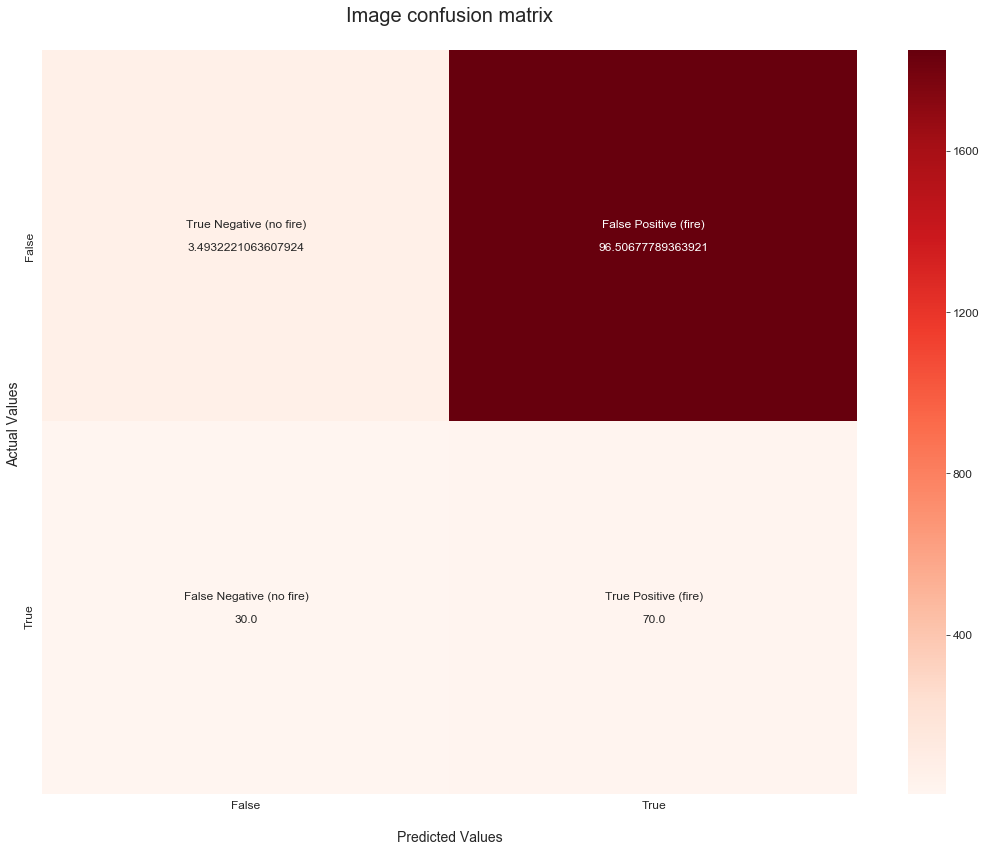

units dropouts optimizers    losses accuracies      aucs precisions  \
41    16      0.7       adam  0.693374   0.496124  0.501923   0.496124   

   recalls                                          histories epochs  \
41       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
41        0.493209

61/61 [==============================] - 6s 97ms/step
0.9
[([1], 0.9984387), ([1], 0.9689743), ([1], 0.9625261), ([1], 0.7465808), ([1], 0.99162173), ([1], 0.99705696), ([1], 0.99850786), ([1], 0.5276595), ([1], 0.39880198), ([1], 0.9970192)]
[([1], 0.9944904), ([1], 0.8384074), ([1], 0.9872972), ([1], 0.9817777), ([1], 0.9622808), ([1], 0.9975156), ([1], 0.99904525), ([1], 0.450011), ([1], 0.455867), ([1], 0.9958812)]


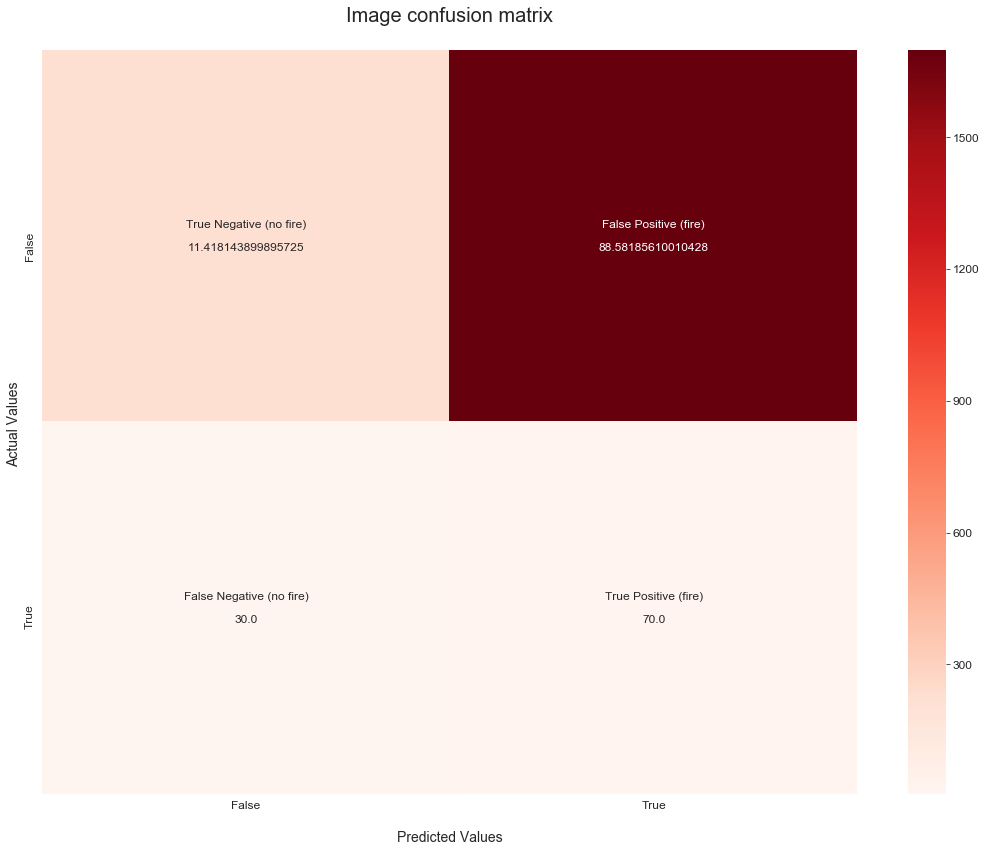

units dropouts optimizers    losses accuracies      aucs precisions  \
41    16      0.7       adam  0.693374   0.496124  0.501923   0.496124   

   recalls                                          histories epochs  \
41       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
41        0.493209

61/61 [==============================] - 7s 105ms/step
0.95
[([1], 0.9984387), ([1], 0.9689743), ([1], 0.9625261), ([1], 0.7465808), ([1], 0.99162173), ([1], 0.99705696), ([1], 0.99850786), ([1], 0.5276595), ([1], 0.39880198), ([1], 0.9970192)]
[([1], 0.9944904), ([1], 0.8384074), ([1], 0.9872972), ([1], 0.9817777), ([1], 0.9622808), ([1], 0.9975156), ([1], 0.99904525), ([1], 0.450011), ([1], 0.455867), ([1], 0.9958812)]


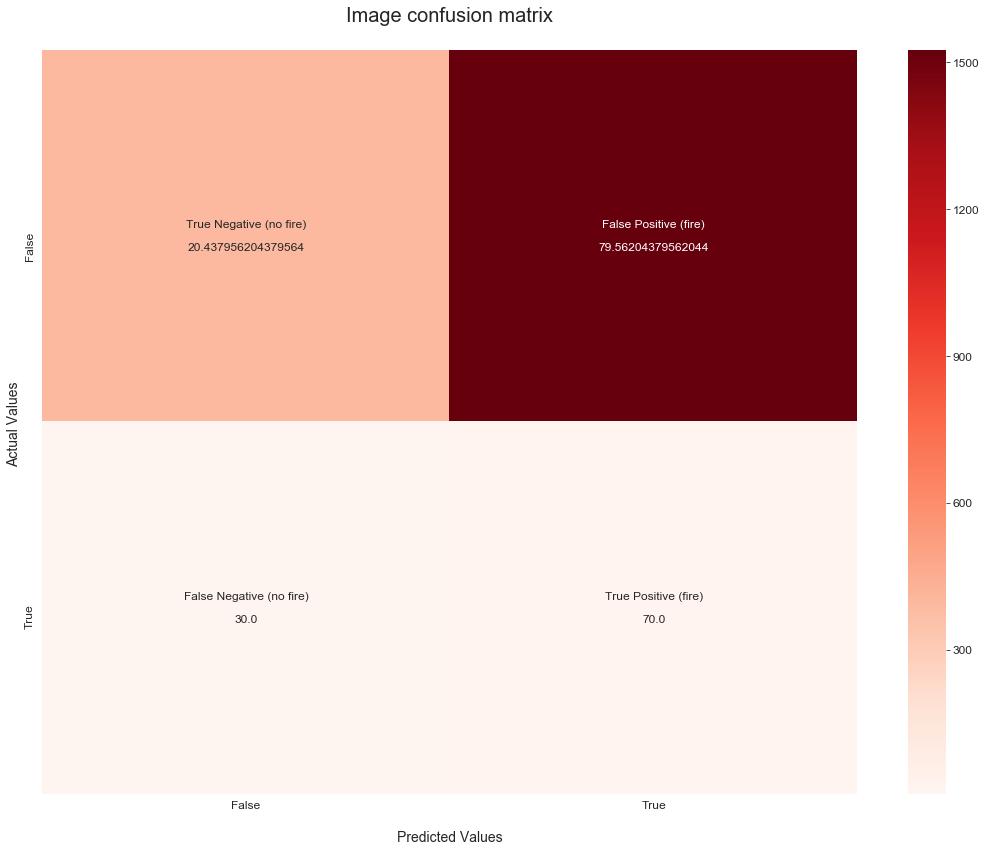

units dropouts optimizers  losses accuracies      aucs precisions recalls  \
42    16      0.7      Nadam  0.7245   0.496124  0.758534   0.496124       1   

                                            histories epochs best thresholds  
42  <keras.callbacks.History object at 0x000002B0B...      3        0.377171

61/61 [==============================] - 7s 97ms/step
0.1
[([1], 0.80193543), ([1], 0.81393313), ([1], 0.42415246), ([1], 0.35683715), ([1], 0.59826964), ([1], 0.48409057), ([1], 0.79613817), ([1], 0.337817), ([1], 0.42229697), ([1], 0.68330395)]
[([1], 0.6129145), ([1], 0.51969814), ([1], 0.4934142), ([1], 0.43908077), ([1], 0.52276415), ([1], 0.5439464), ([1], 0.7987474), ([1], 0.31106648), ([1], 0.45767942), ([1], 0.6385241)]


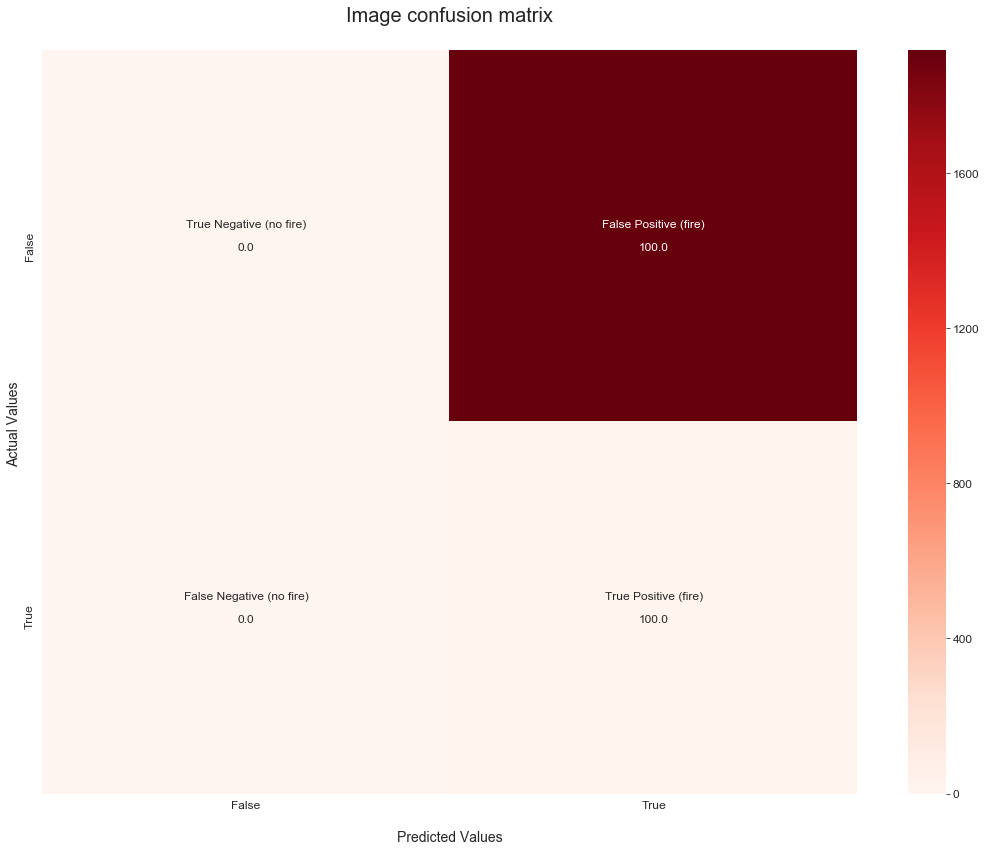

units dropouts optimizers  losses accuracies      aucs precisions recalls  \
42    16      0.7      Nadam  0.7245   0.496124  0.758534   0.496124       1   

                                            histories epochs best thresholds  
42  <keras.callbacks.History object at 0x000002B0B...      3        0.377171

61/61 [==============================] - 6s 98ms/step
0.3
[([1], 0.80193543), ([1], 0.81393313), ([1], 0.42415246), ([1], 0.35683715), ([1], 0.59826964), ([1], 0.48409057), ([1], 0.79613817), ([1], 0.337817), ([1], 0.42229697), ([1], 0.68330395)]
[([1], 0.6129145), ([1], 0.51969814), ([1], 0.4934142), ([1], 0.43908077), ([1], 0.52276415), ([1], 0.5439464), ([1], 0.7987474), ([1], 0.31106648), ([1], 0.45767942), ([1], 0.6385241)]


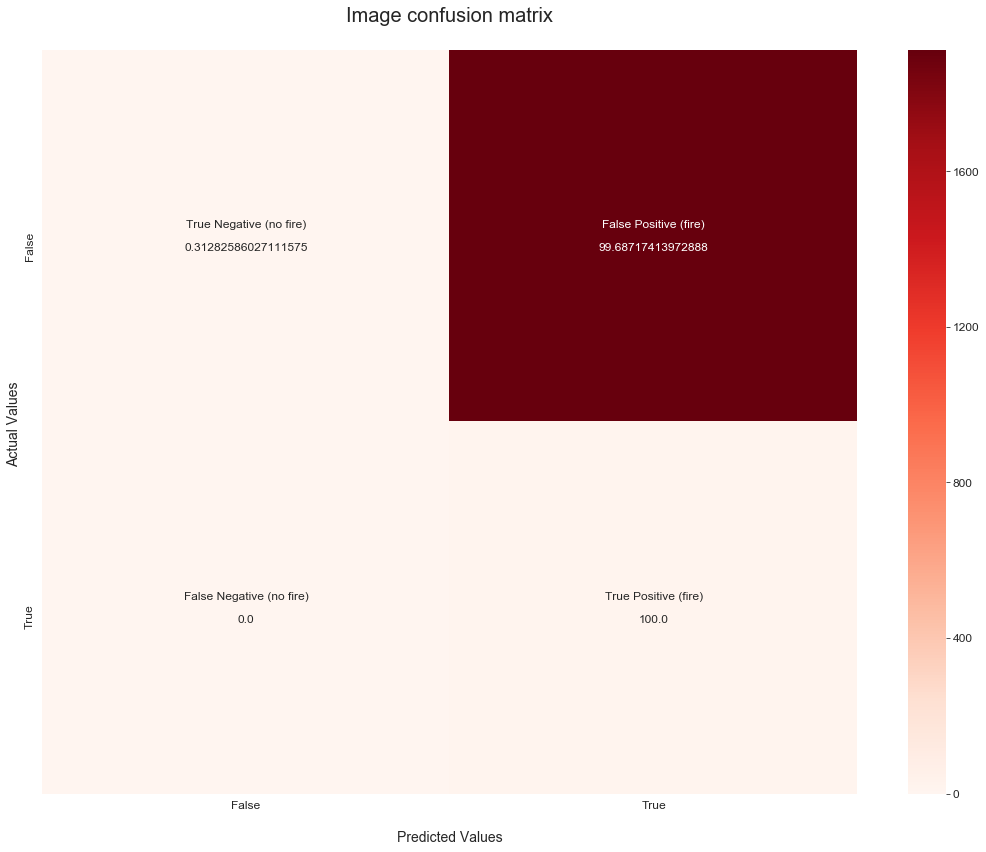

units dropouts optimizers  losses accuracies      aucs precisions recalls  \
42    16      0.7      Nadam  0.7245   0.496124  0.758534   0.496124       1   

                                            histories epochs best thresholds  
42  <keras.callbacks.History object at 0x000002B0B...      3        0.377171

61/61 [==============================] - 6s 99ms/step
0.5
[([1], 0.80193543), ([1], 0.81393313), ([1], 0.42415246), ([1], 0.35683715), ([1], 0.59826964), ([1], 0.48409057), ([1], 0.79613817), ([1], 0.337817), ([1], 0.42229697), ([1], 0.68330395)]
[([1], 0.6129145), ([1], 0.51969814), ([1], 0.4934142), ([1], 0.43908077), ([1], 0.52276415), ([1], 0.5439464), ([1], 0.7987474), ([1], 0.31106648), ([1], 0.45767942), ([1], 0.6385241)]


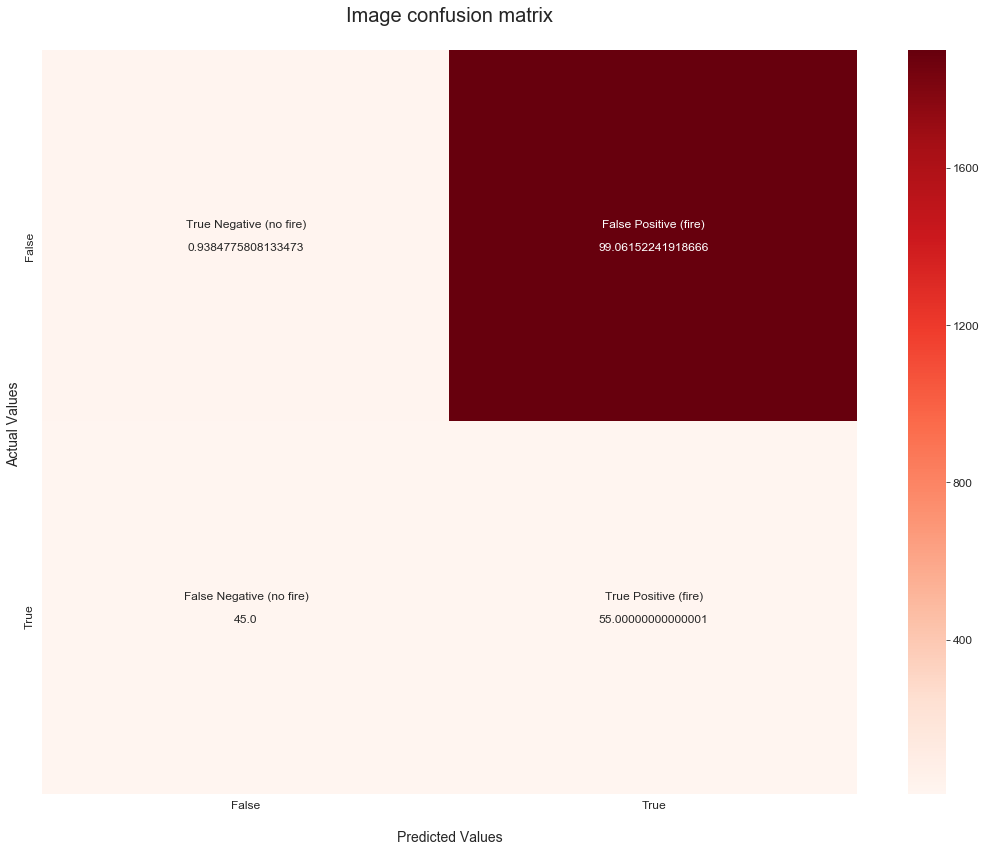

units dropouts optimizers  losses accuracies      aucs precisions recalls  \
42    16      0.7      Nadam  0.7245   0.496124  0.758534   0.496124       1   

                                            histories epochs best thresholds  
42  <keras.callbacks.History object at 0x000002B0B...      3        0.377171

61/61 [==============================] - 6s 97ms/step
0.65
[([1], 0.80193543), ([1], 0.81393313), ([1], 0.42415246), ([1], 0.35683715), ([1], 0.59826964), ([1], 0.48409057), ([1], 0.79613817), ([1], 0.337817), ([1], 0.42229697), ([1], 0.68330395)]
[([1], 0.6129145), ([1], 0.51969814), ([1], 0.4934142), ([1], 0.43908077), ([1], 0.52276415), ([1], 0.5439464), ([1], 0.7987474), ([1], 0.31106648), ([1], 0.45767942), ([1], 0.6385241)]


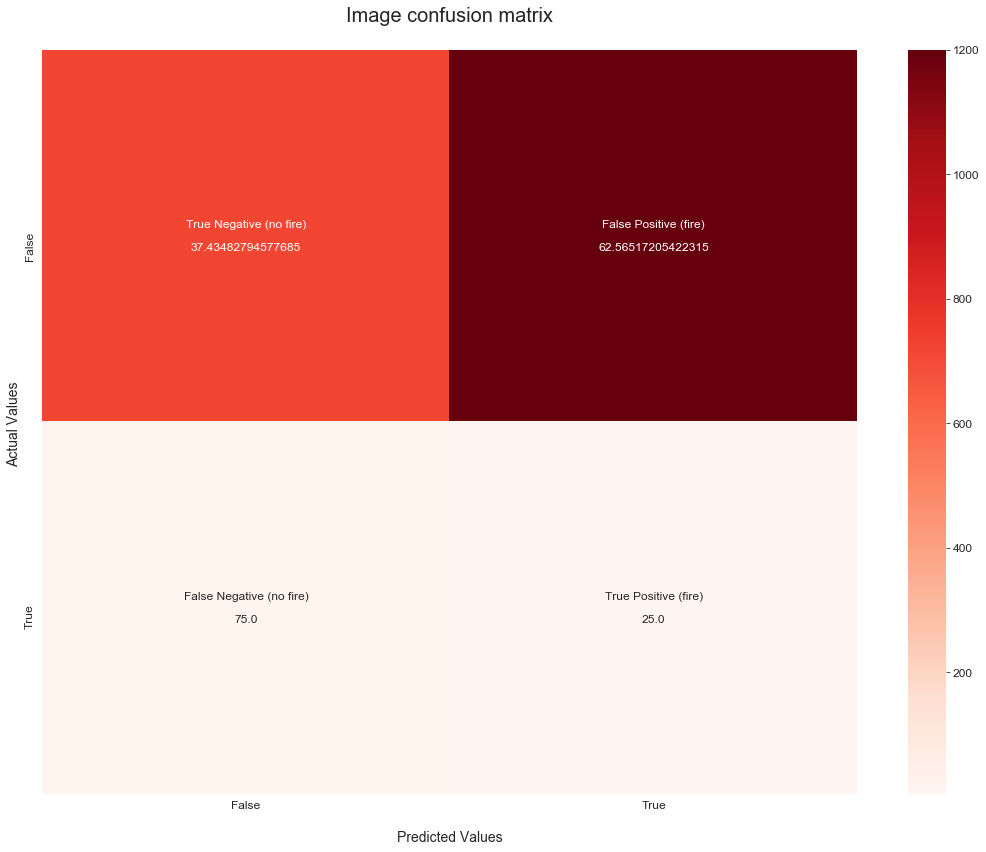

units dropouts optimizers  losses accuracies      aucs precisions recalls  \
42    16      0.7      Nadam  0.7245   0.496124  0.758534   0.496124       1   

                                            histories epochs best thresholds  
42  <keras.callbacks.History object at 0x000002B0B...      3        0.377171

61/61 [==============================] - 6s 97ms/step
0.725
[([1], 0.80193543), ([1], 0.81393313), ([1], 0.42415246), ([1], 0.35683715), ([1], 0.59826964), ([1], 0.48409057), ([1], 0.79613817), ([1], 0.337817), ([1], 0.42229697), ([1], 0.68330395)]
[([1], 0.6129145), ([1], 0.51969814), ([1], 0.4934142), ([1], 0.43908077), ([1], 0.52276415), ([1], 0.5439464), ([1], 0.7987474), ([1], 0.31106648), ([1], 0.45767942), ([1], 0.6385241)]


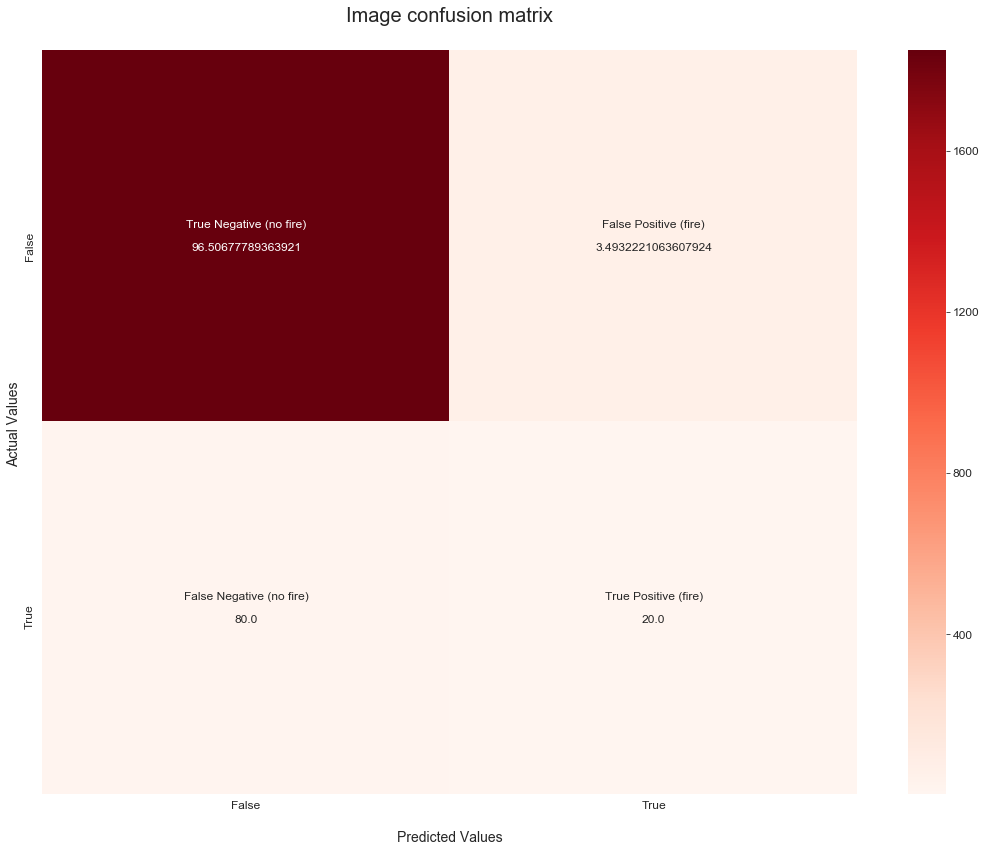

units dropouts optimizers  losses accuracies      aucs precisions recalls  \
42    16      0.7      Nadam  0.7245   0.496124  0.758534   0.496124       1   

                                            histories epochs best thresholds  
42  <keras.callbacks.History object at 0x000002B0B...      3        0.377171

61/61 [==============================] - 6s 97ms/step
0.8
[([1], 0.80193543), ([1], 0.81393313), ([1], 0.42415246), ([1], 0.35683715), ([1], 0.59826964), ([1], 0.48409057), ([1], 0.79613817), ([1], 0.337817), ([1], 0.42229697), ([1], 0.68330395)]
[([1], 0.6129145), ([1], 0.51969814), ([1], 0.4934142), ([1], 0.43908077), ([1], 0.52276415), ([1], 0.5439464), ([1], 0.7987474), ([1], 0.31106648), ([1], 0.45767942), ([1], 0.6385241)]


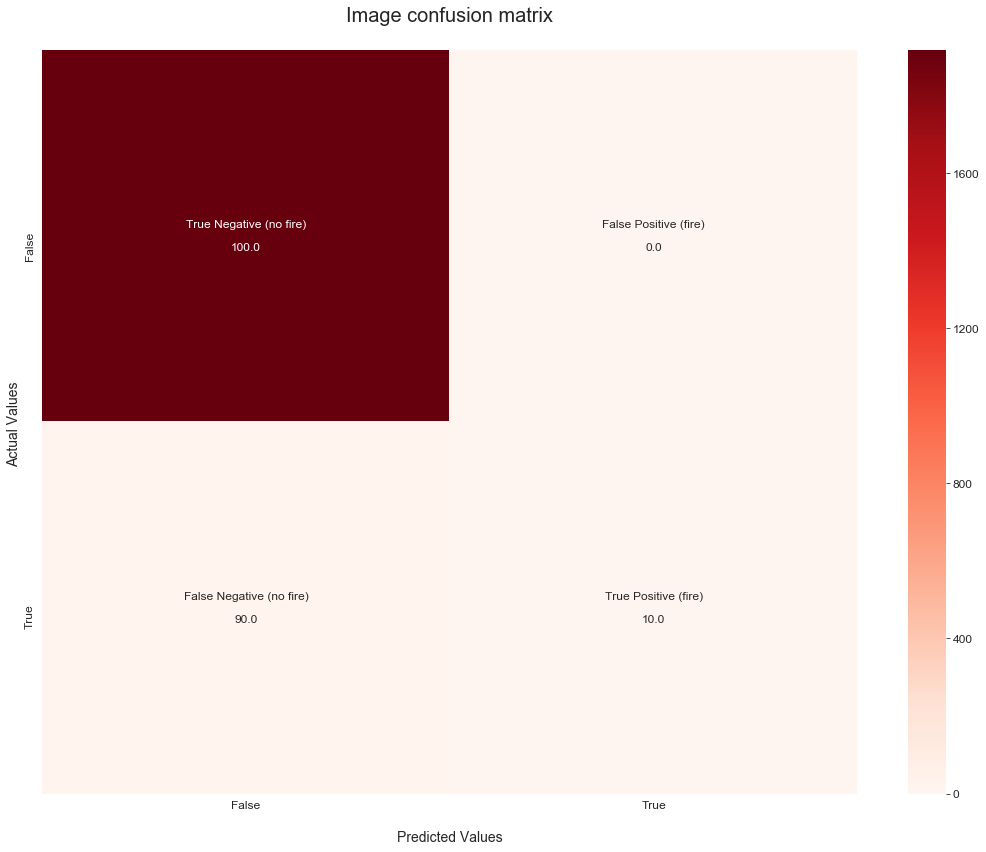

units dropouts optimizers  losses accuracies      aucs precisions recalls  \
42    16      0.7      Nadam  0.7245   0.496124  0.758534   0.496124       1   

                                            histories epochs best thresholds  
42  <keras.callbacks.History object at 0x000002B0B...      3        0.377171

61/61 [==============================] - 6s 98ms/step
0.85
[([1], 0.80193543), ([1], 0.81393313), ([1], 0.42415246), ([1], 0.35683715), ([1], 0.59826964), ([1], 0.48409057), ([1], 0.79613817), ([1], 0.337817), ([1], 0.42229697), ([1], 0.68330395)]
[([1], 0.6129145), ([1], 0.51969814), ([1], 0.4934142), ([1], 0.43908077), ([1], 0.52276415), ([1], 0.5439464), ([1], 0.7987474), ([1], 0.31106648), ([1], 0.45767942), ([1], 0.6385241)]


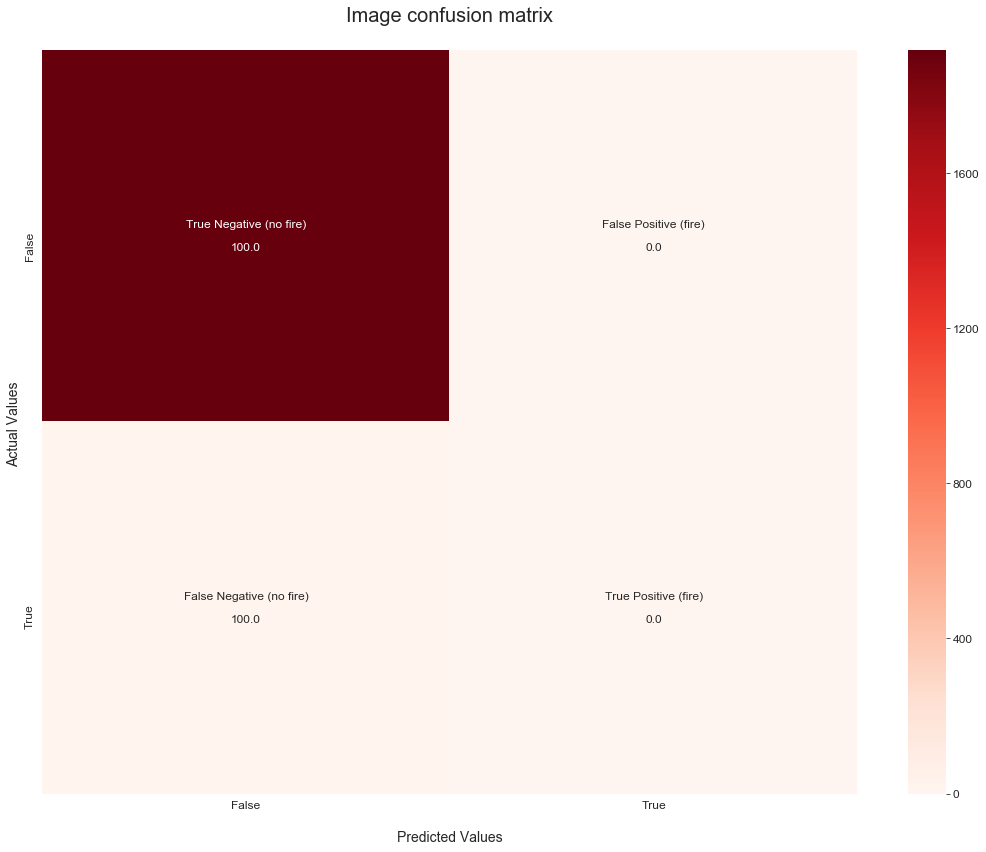

units dropouts optimizers  losses accuracies      aucs precisions recalls  \
42    16      0.7      Nadam  0.7245   0.496124  0.758534   0.496124       1   

                                            histories epochs best thresholds  
42  <keras.callbacks.History object at 0x000002B0B...      3        0.377171

61/61 [==============================] - 8s 123ms/step
0.9
[([1], 0.80193543), ([1], 0.81393313), ([1], 0.42415246), ([1], 0.35683715), ([1], 0.59826964), ([1], 0.48409057), ([1], 0.79613817), ([1], 0.337817), ([1], 0.42229697), ([1], 0.68330395)]
[([1], 0.6129145), ([1], 0.51969814), ([1], 0.4934142), ([1], 0.43908077), ([1], 0.52276415), ([1], 0.5439464), ([1], 0.7987474), ([1], 0.31106648), ([1], 0.45767942), ([1], 0.6385241)]


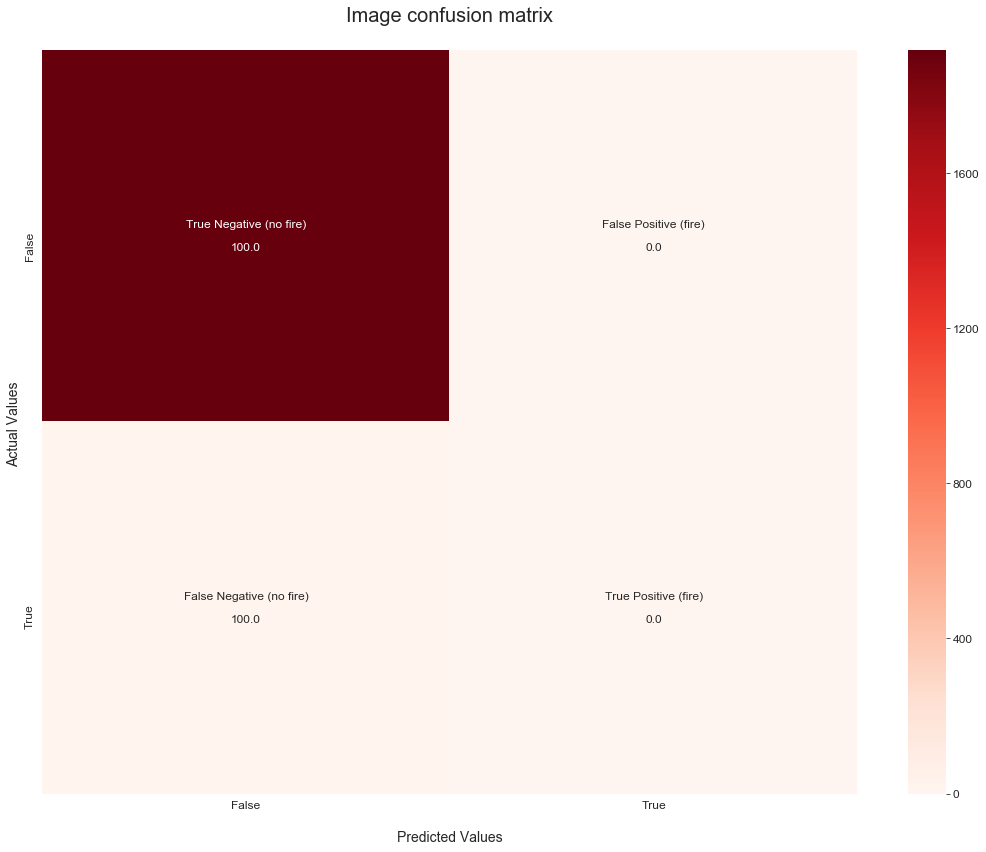

units dropouts optimizers  losses accuracies      aucs precisions recalls  \
42    16      0.7      Nadam  0.7245   0.496124  0.758534   0.496124       1   

                                            histories epochs best thresholds  
42  <keras.callbacks.History object at 0x000002B0B...      3        0.377171

61/61 [==============================] - 6s 96ms/step
0.95
[([1], 0.80193543), ([1], 0.81393313), ([1], 0.42415246), ([1], 0.35683715), ([1], 0.59826964), ([1], 0.48409057), ([1], 0.79613817), ([1], 0.337817), ([1], 0.42229697), ([1], 0.68330395)]
[([1], 0.6129145), ([1], 0.51969814), ([1], 0.4934142), ([1], 0.43908077), ([1], 0.52276415), ([1], 0.5439464), ([1], 0.7987474), ([1], 0.31106648), ([1], 0.45767942), ([1], 0.6385241)]


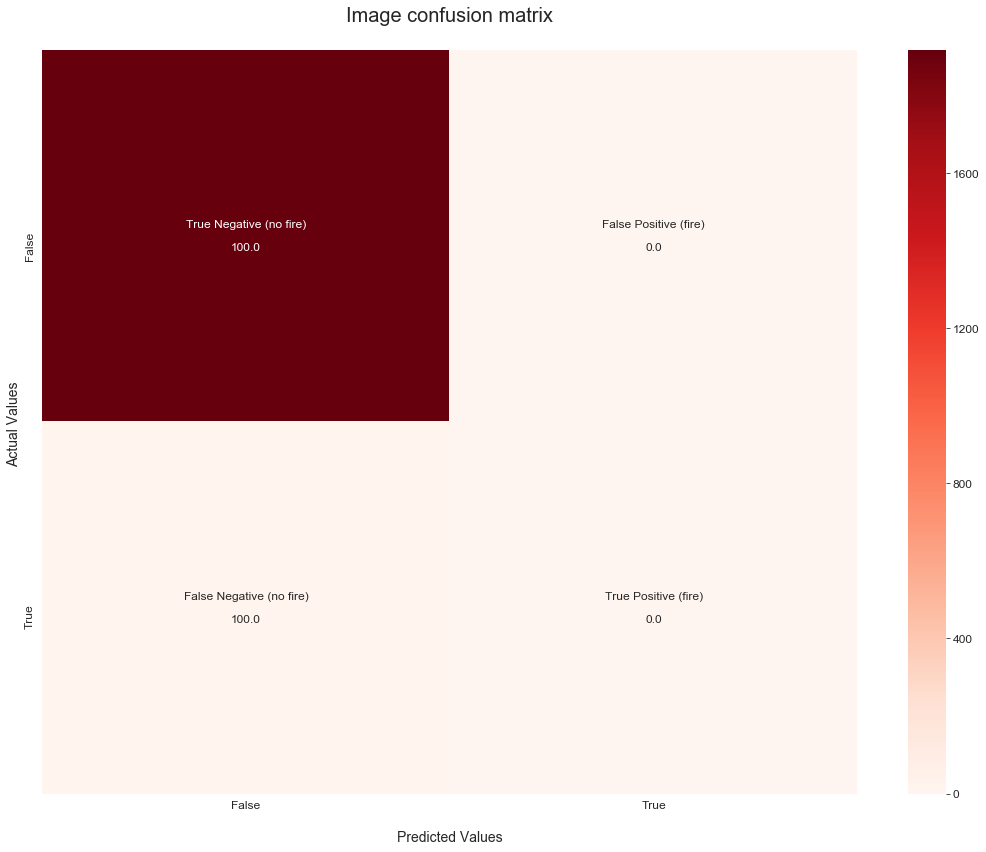

units dropouts optimizers    losses accuracies      aucs precisions  \
43    16      0.7    RMSprop  0.709256   0.496124  0.689423   0.496124   

   recalls                                          histories epochs  \
43       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
43        0.412395

61/61 [==============================] - 7s 98ms/step
0.1
[([1], 0.8627846), ([1], 0.89901847), ([1], 0.9918382), ([1], 0.9892528), ([1], 0.9994006), ([1], 0.8839843), ([1], 0.99975616), ([1], 0.40057373), ([1], 0.40306857), ([1], 0.9999879)]
[([1], 0.82980376), ([1], 0.73425794), ([1], 0.9940367), ([1], 0.99533165), ([1], 0.9990251), ([1], 0.90953434), ([1], 0.9997432), ([1], 0.39257568), ([1], 0.44584402), ([1], 0.9999686)]


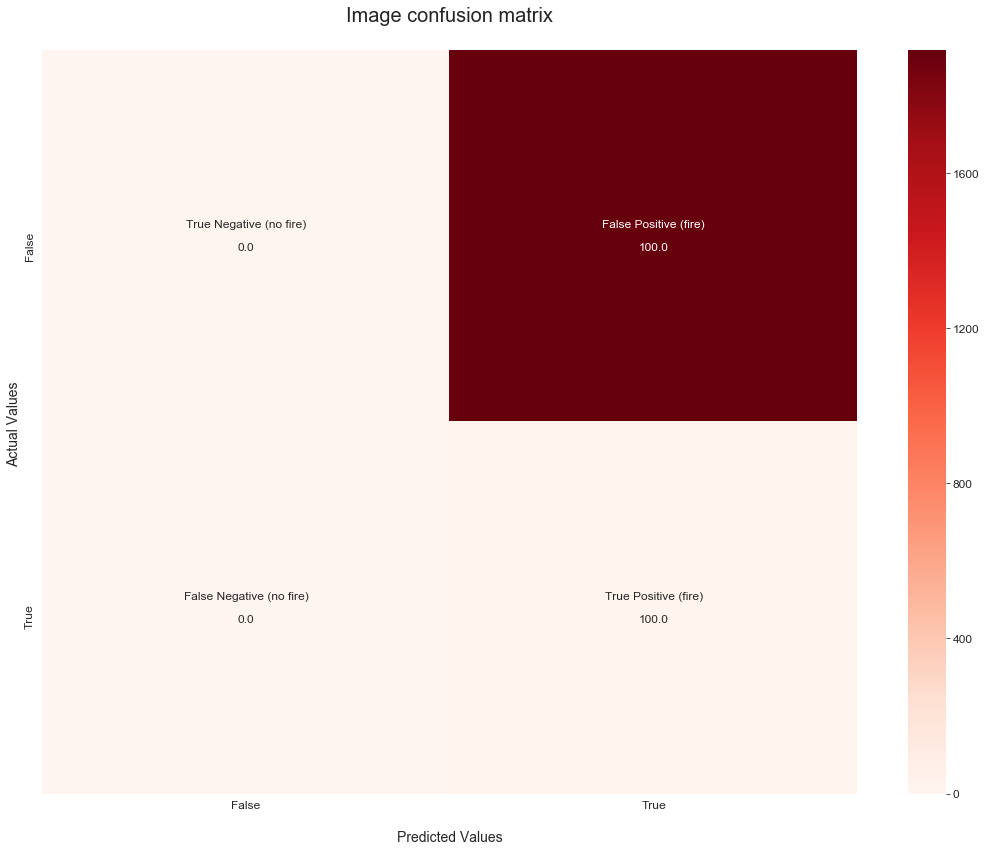

units dropouts optimizers    losses accuracies      aucs precisions  \
43    16      0.7    RMSprop  0.709256   0.496124  0.689423   0.496124   

   recalls                                          histories epochs  \
43       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
43        0.412395

61/61 [==============================] - 6s 98ms/step
0.3
[([1], 0.8627846), ([1], 0.89901847), ([1], 0.9918382), ([1], 0.9892528), ([1], 0.9994006), ([1], 0.8839843), ([1], 0.99975616), ([1], 0.40057373), ([1], 0.40306857), ([1], 0.9999879)]
[([1], 0.82980376), ([1], 0.73425794), ([1], 0.9940367), ([1], 0.99533165), ([1], 0.9990251), ([1], 0.90953434), ([1], 0.9997432), ([1], 0.39257568), ([1], 0.44584402), ([1], 0.9999686)]


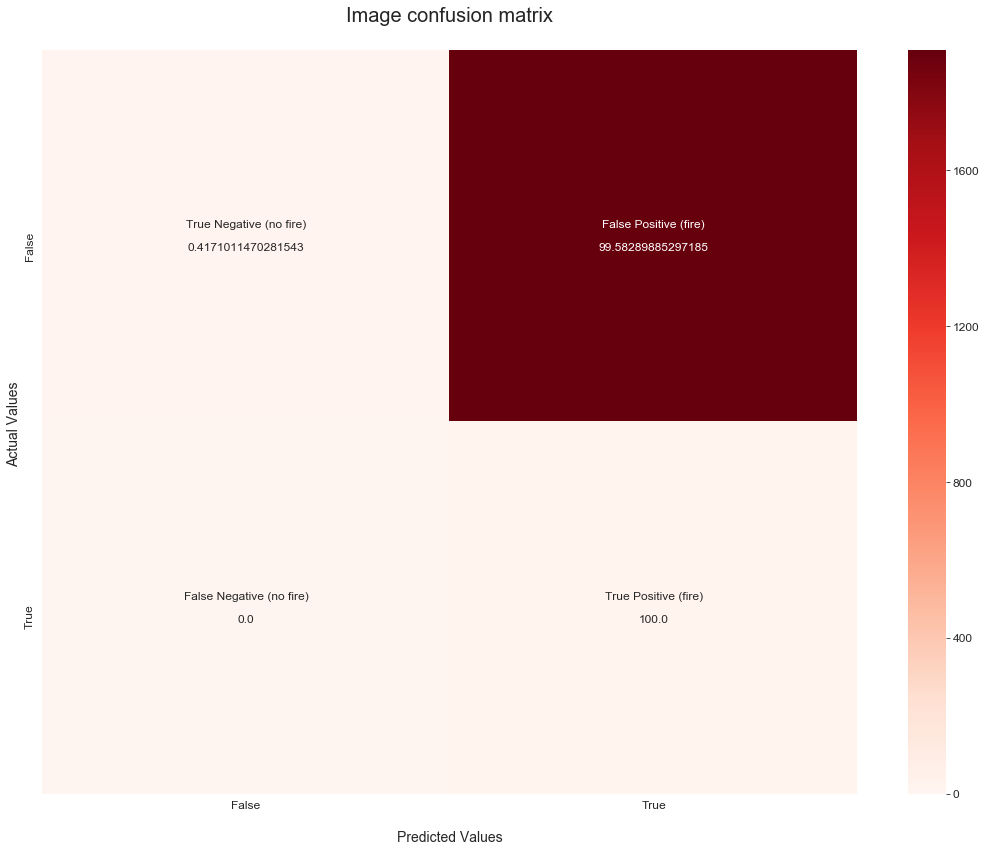

units dropouts optimizers    losses accuracies      aucs precisions  \
43    16      0.7    RMSprop  0.709256   0.496124  0.689423   0.496124   

   recalls                                          histories epochs  \
43       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
43        0.412395

61/61 [==============================] - 6s 98ms/step
0.5
[([1], 0.8627846), ([1], 0.89901847), ([1], 0.9918382), ([1], 0.9892528), ([1], 0.9994006), ([1], 0.8839843), ([1], 0.99975616), ([1], 0.40057373), ([1], 0.40306857), ([1], 0.9999879)]
[([1], 0.82980376), ([1], 0.73425794), ([1], 0.9940367), ([1], 0.99533165), ([1], 0.9990251), ([1], 0.90953434), ([1], 0.9997432), ([1], 0.39257568), ([1], 0.44584402), ([1], 0.9999686)]


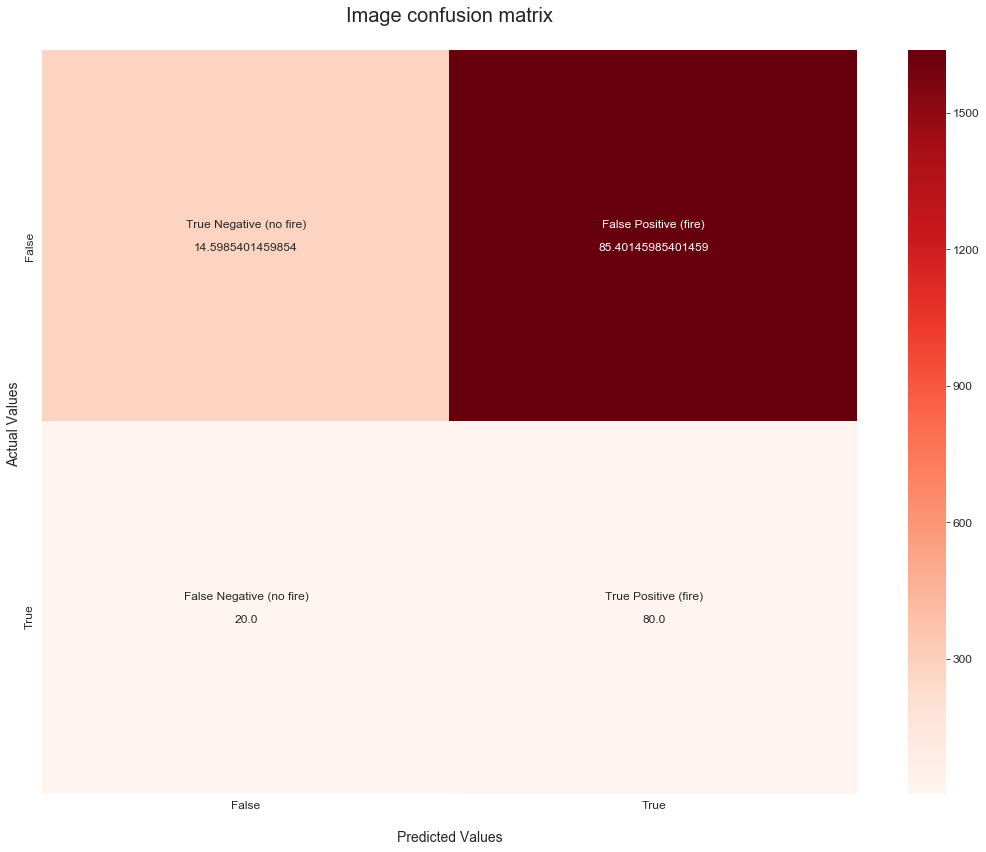

units dropouts optimizers    losses accuracies      aucs precisions  \
43    16      0.7    RMSprop  0.709256   0.496124  0.689423   0.496124   

   recalls                                          histories epochs  \
43       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
43        0.412395

61/61 [==============================] - 6s 98ms/step
0.65
[([1], 0.8627846), ([1], 0.89901847), ([1], 0.9918382), ([1], 0.9892528), ([1], 0.9994006), ([1], 0.8839843), ([1], 0.99975616), ([1], 0.40057373), ([1], 0.40306857), ([1], 0.9999879)]
[([1], 0.82980376), ([1], 0.73425794), ([1], 0.9940367), ([1], 0.99533165), ([1], 0.9990251), ([1], 0.90953434), ([1], 0.9997432), ([1], 0.39257568), ([1], 0.44584402), ([1], 0.9999686)]


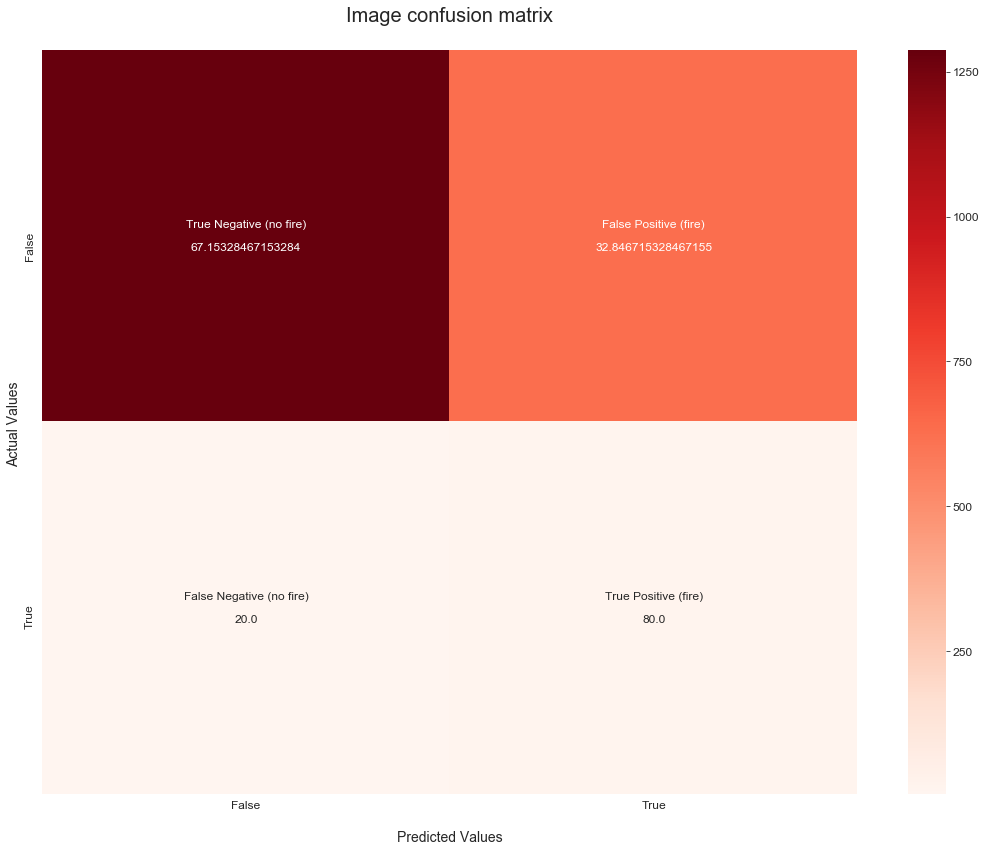

units dropouts optimizers    losses accuracies      aucs precisions  \
43    16      0.7    RMSprop  0.709256   0.496124  0.689423   0.496124   

   recalls                                          histories epochs  \
43       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
43        0.412395

61/61 [==============================] - 6s 98ms/step
0.725
[([1], 0.8627846), ([1], 0.89901847), ([1], 0.9918382), ([1], 0.9892528), ([1], 0.9994006), ([1], 0.8839843), ([1], 0.99975616), ([1], 0.40057373), ([1], 0.40306857), ([1], 0.9999879)]
[([1], 0.82980376), ([1], 0.73425794), ([1], 0.9940367), ([1], 0.99533165), ([1], 0.9990251), ([1], 0.90953434), ([1], 0.9997432), ([1], 0.39257568), ([1], 0.44584402), ([1], 0.9999686)]


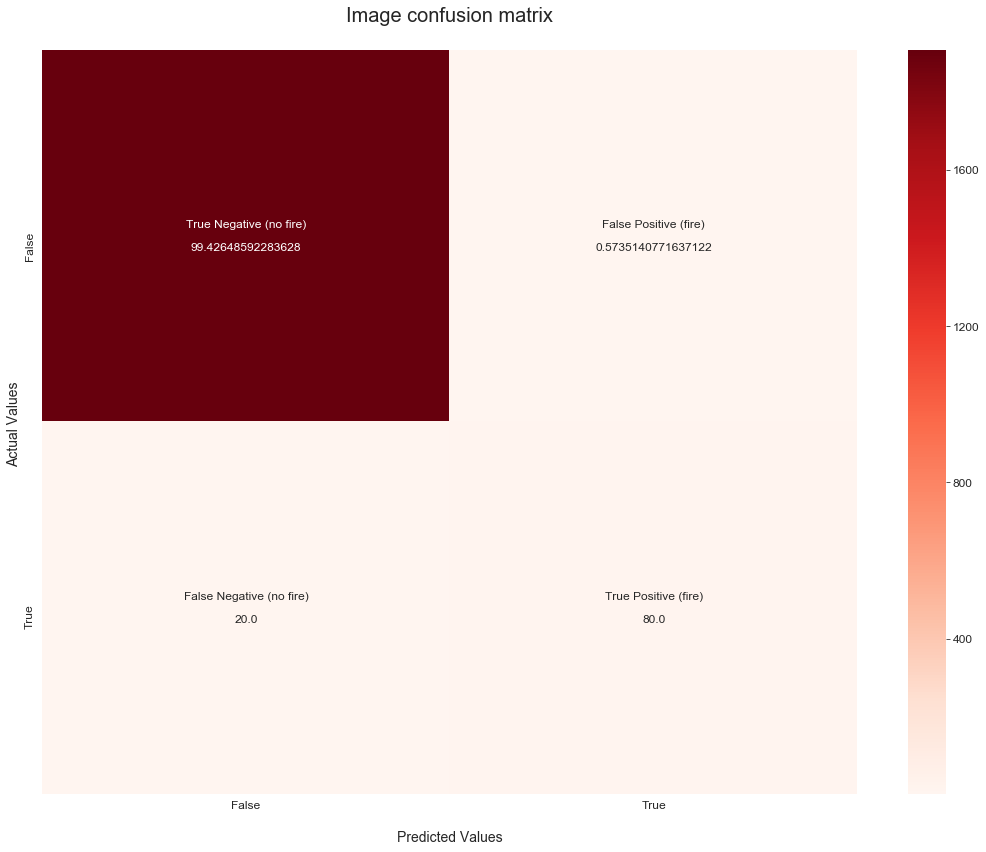

units dropouts optimizers    losses accuracies      aucs precisions  \
43    16      0.7    RMSprop  0.709256   0.496124  0.689423   0.496124   

   recalls                                          histories epochs  \
43       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
43        0.412395

61/61 [==============================] - 6s 97ms/step
0.8
[([1], 0.8627846), ([1], 0.89901847), ([1], 0.9918382), ([1], 0.9892528), ([1], 0.9994006), ([1], 0.8839843), ([1], 0.99975616), ([1], 0.40057373), ([1], 0.40306857), ([1], 0.9999879)]
[([1], 0.82980376), ([1], 0.73425794), ([1], 0.9940367), ([1], 0.99533165), ([1], 0.9990251), ([1], 0.90953434), ([1], 0.9997432), ([1], 0.39257568), ([1], 0.44584402), ([1], 0.9999686)]


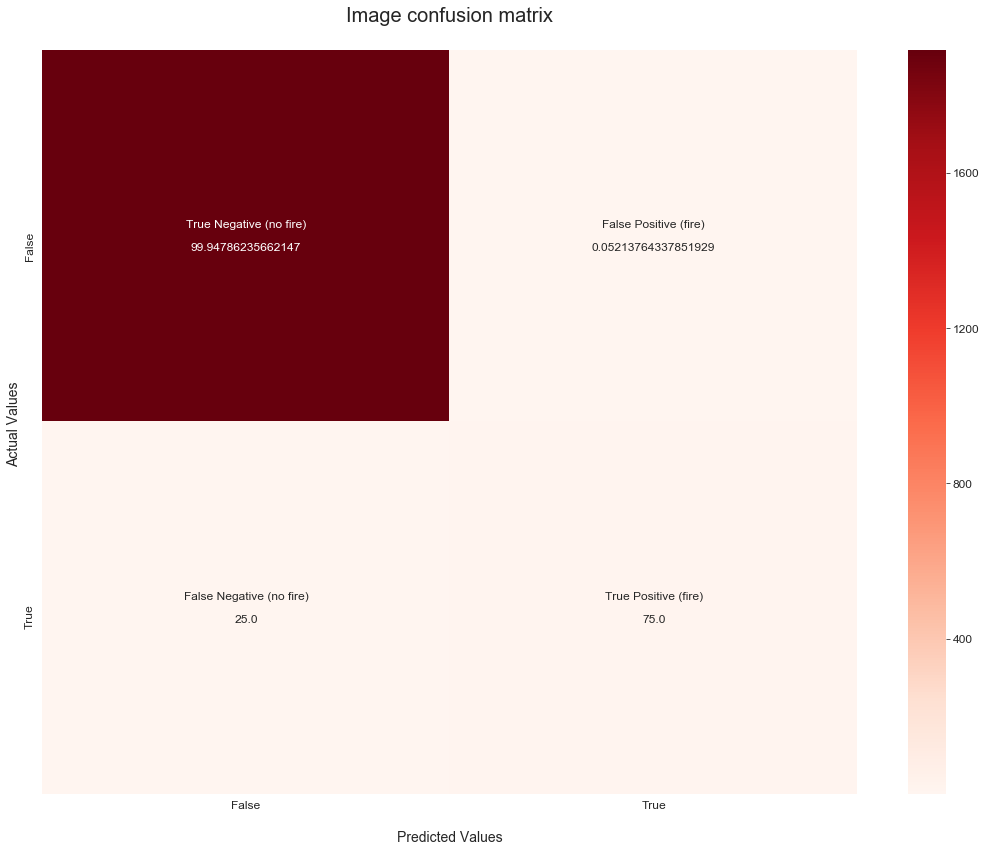

units dropouts optimizers    losses accuracies      aucs precisions  \
43    16      0.7    RMSprop  0.709256   0.496124  0.689423   0.496124   

   recalls                                          histories epochs  \
43       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
43        0.412395

61/61 [==============================] - 7s 103ms/step
0.85
[([1], 0.8627846), ([1], 0.89901847), ([1], 0.9918382), ([1], 0.9892528), ([1], 0.9994006), ([1], 0.8839843), ([1], 0.99975616), ([1], 0.40057373), ([1], 0.40306857), ([1], 0.9999879)]
[([1], 0.82980376), ([1], 0.73425794), ([1], 0.9940367), ([1], 0.99533165), ([1], 0.9990251), ([1], 0.90953434), ([1], 0.9997432), ([1], 0.39257568), ([1], 0.44584402), ([1], 0.9999686)]


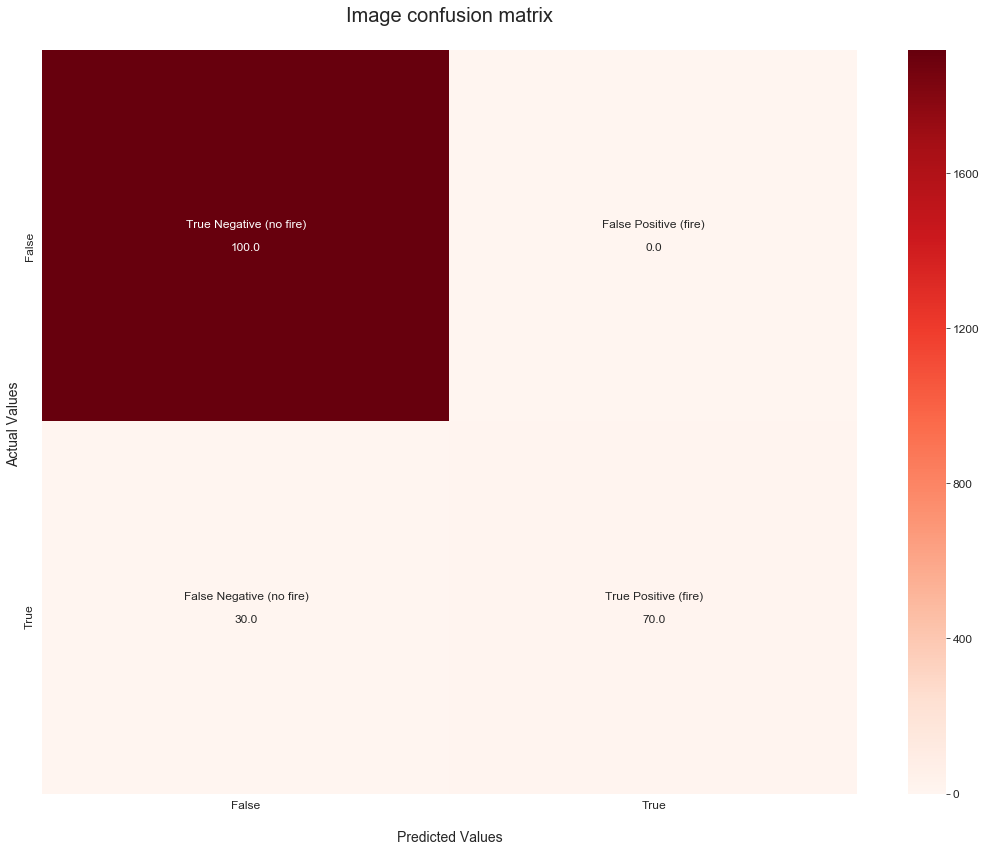

units dropouts optimizers    losses accuracies      aucs precisions  \
43    16      0.7    RMSprop  0.709256   0.496124  0.689423   0.496124   

   recalls                                          histories epochs  \
43       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
43        0.412395

61/61 [==============================] - 6s 98ms/step
0.9
[([1], 0.8627846), ([1], 0.89901847), ([1], 0.9918382), ([1], 0.9892528), ([1], 0.9994006), ([1], 0.8839843), ([1], 0.99975616), ([1], 0.40057373), ([1], 0.40306857), ([1], 0.9999879)]
[([1], 0.82980376), ([1], 0.73425794), ([1], 0.9940367), ([1], 0.99533165), ([1], 0.9990251), ([1], 0.90953434), ([1], 0.9997432), ([1], 0.39257568), ([1], 0.44584402), ([1], 0.9999686)]


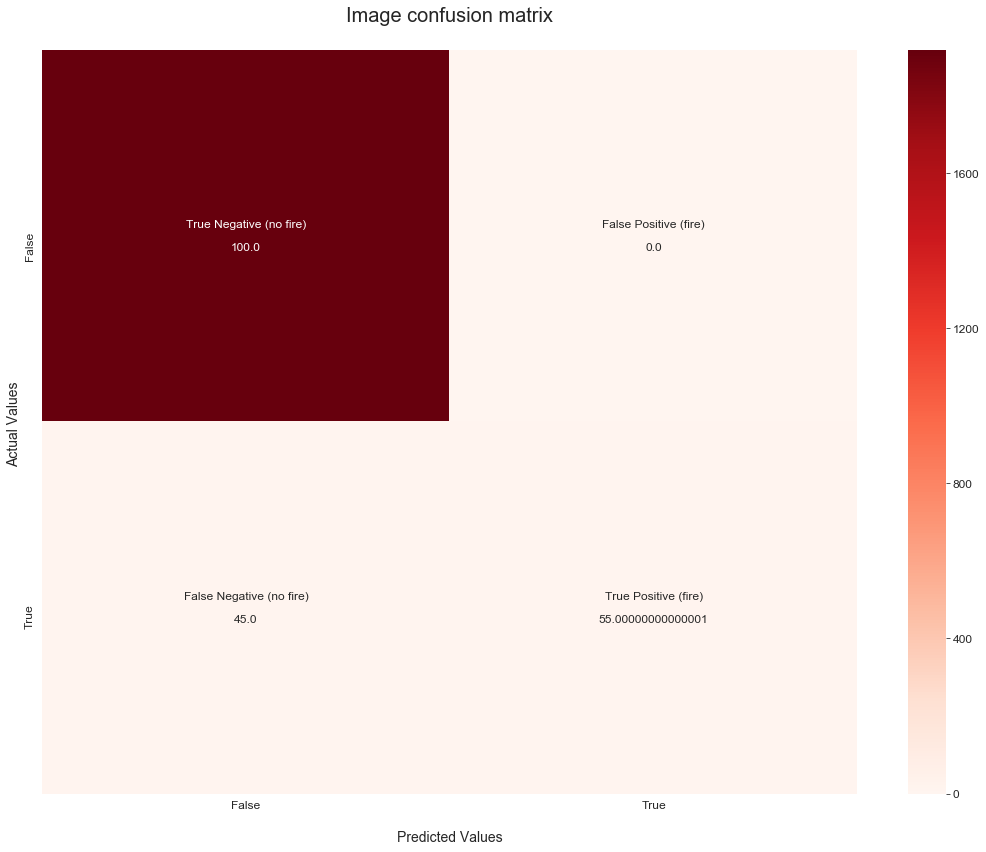

units dropouts optimizers    losses accuracies      aucs precisions  \
43    16      0.7    RMSprop  0.709256   0.496124  0.689423   0.496124   

   recalls                                          histories epochs  \
43       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
43        0.412395

61/61 [==============================] - 6s 99ms/step
0.95
[([1], 0.8627846), ([1], 0.89901847), ([1], 0.9918382), ([1], 0.9892528), ([1], 0.9994006), ([1], 0.8839843), ([1], 0.99975616), ([1], 0.40057373), ([1], 0.40306857), ([1], 0.9999879)]
[([1], 0.82980376), ([1], 0.73425794), ([1], 0.9940367), ([1], 0.99533165), ([1], 0.9990251), ([1], 0.90953434), ([1], 0.9997432), ([1], 0.39257568), ([1], 0.44584402), ([1], 0.9999686)]


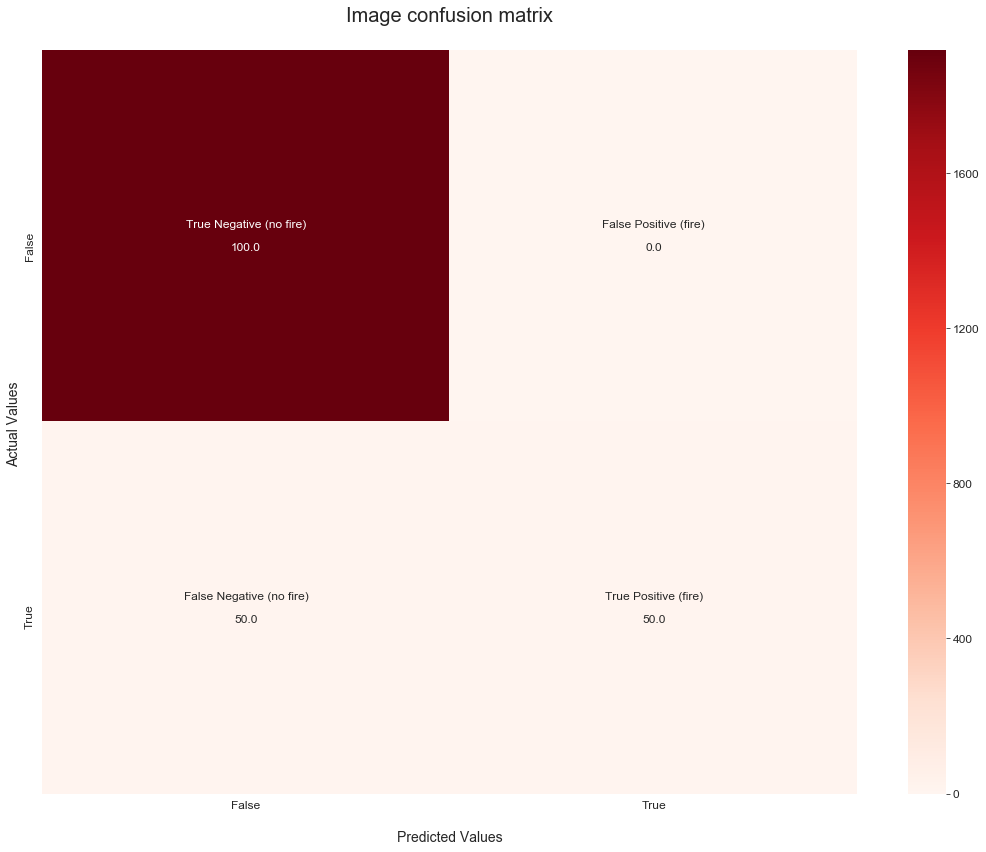

units dropouts optimizers    losses accuracies      aucs precisions  \
44    16      0.7       adam  0.707697   0.503876  0.557692          0   

   recalls                                          histories epochs  \
44       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
44        0.590158

61/61 [==============================] - 7s 98ms/step
0.1
[([1], 0.8475642), ([1], 0.84749043), ([1], 0.5485637), ([1], 0.49184567), ([1], 0.6183699), ([1], 0.6529906), ([1], 0.71964836), ([1], 0.37968782), ([1], 0.37836438), ([1], 0.6748887)]
[([1], 0.7370754), ([1], 0.5978826), ([1], 0.5696973), ([1], 0.6633064), ([1], 0.56695896), ([1], 0.66252416), ([1], 0.75299644), ([1], 0.37767074), ([1], 0.45074046), ([1], 0.85018617)]


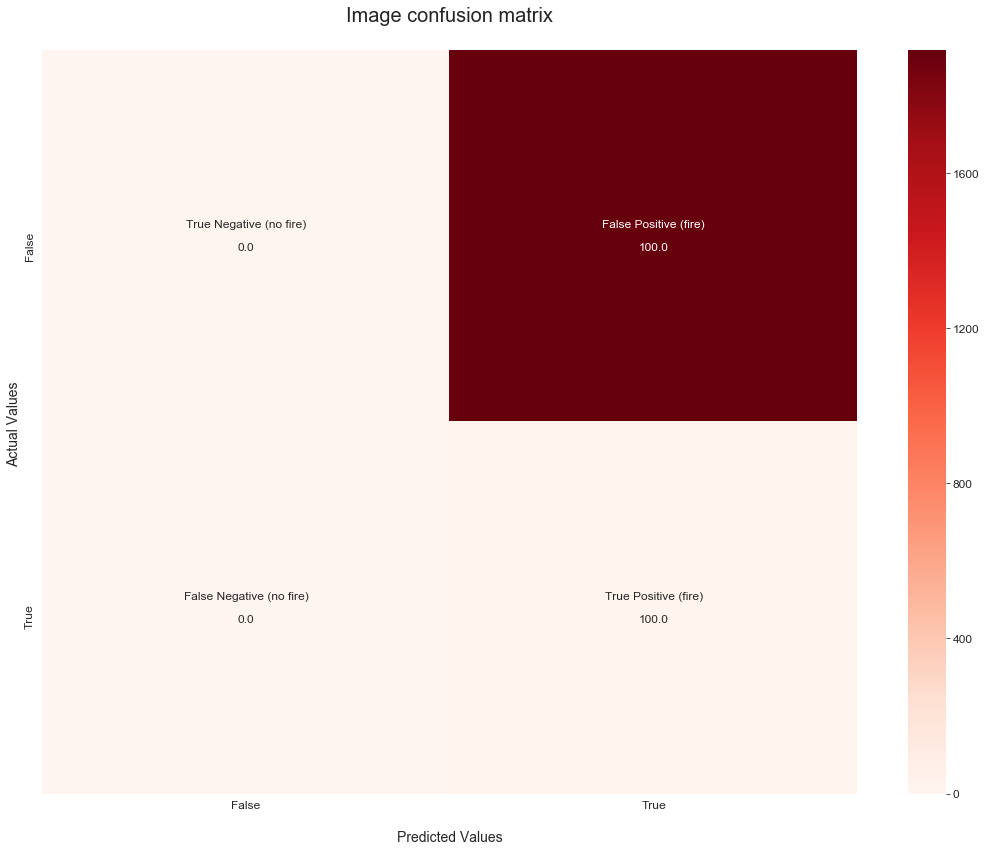

units dropouts optimizers    losses accuracies      aucs precisions  \
44    16      0.7       adam  0.707697   0.503876  0.557692          0   

   recalls                                          histories epochs  \
44       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
44        0.590158

61/61 [==============================] - 6s 98ms/step
0.3
[([1], 0.8475642), ([1], 0.84749043), ([1], 0.5485637), ([1], 0.49184567), ([1], 0.6183699), ([1], 0.6529906), ([1], 0.71964836), ([1], 0.37968782), ([1], 0.37836438), ([1], 0.6748887)]
[([1], 0.7370754), ([1], 0.5978826), ([1], 0.5696973), ([1], 0.6633064), ([1], 0.56695896), ([1], 0.66252416), ([1], 0.75299644), ([1], 0.37767074), ([1], 0.45074046), ([1], 0.85018617)]


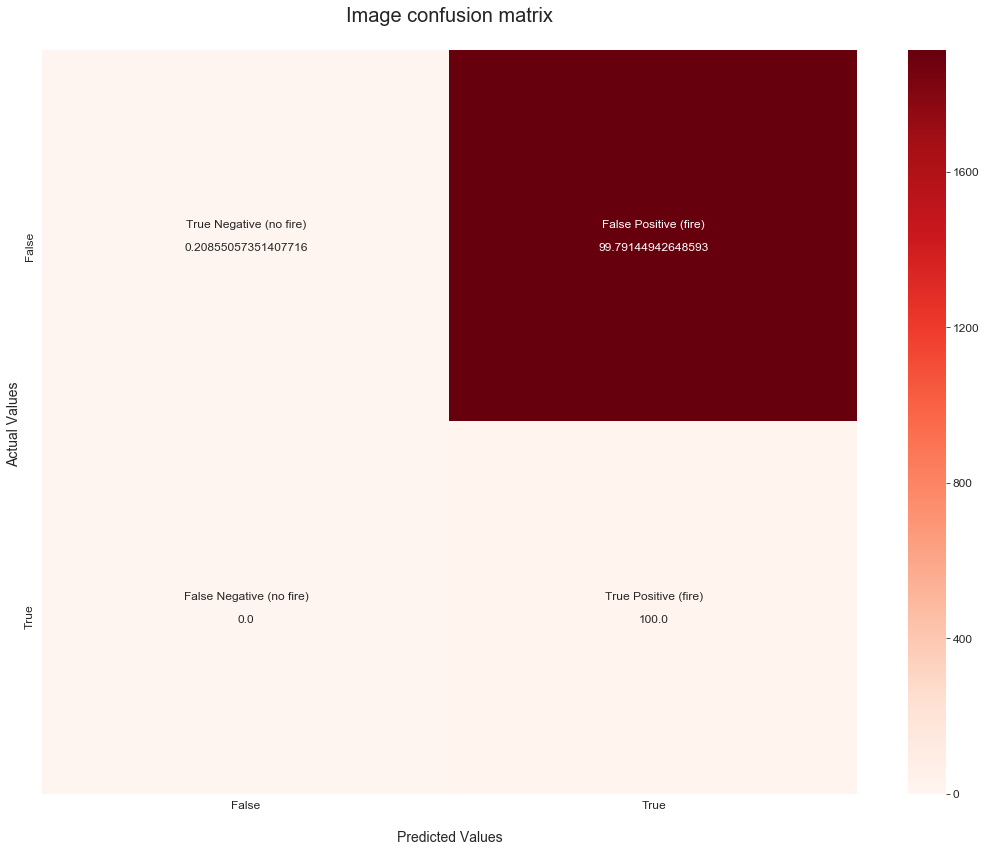

units dropouts optimizers    losses accuracies      aucs precisions  \
44    16      0.7       adam  0.707697   0.503876  0.557692          0   

   recalls                                          histories epochs  \
44       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
44        0.590158

61/61 [==============================] - 6s 98ms/step
0.5
[([1], 0.8475642), ([1], 0.84749043), ([1], 0.5485637), ([1], 0.49184567), ([1], 0.6183699), ([1], 0.6529906), ([1], 0.71964836), ([1], 0.37968782), ([1], 0.37836438), ([1], 0.6748887)]
[([1], 0.7370754), ([1], 0.5978826), ([1], 0.5696973), ([1], 0.6633064), ([1], 0.56695896), ([1], 0.66252416), ([1], 0.75299644), ([1], 0.37767074), ([1], 0.45074046), ([1], 0.85018617)]


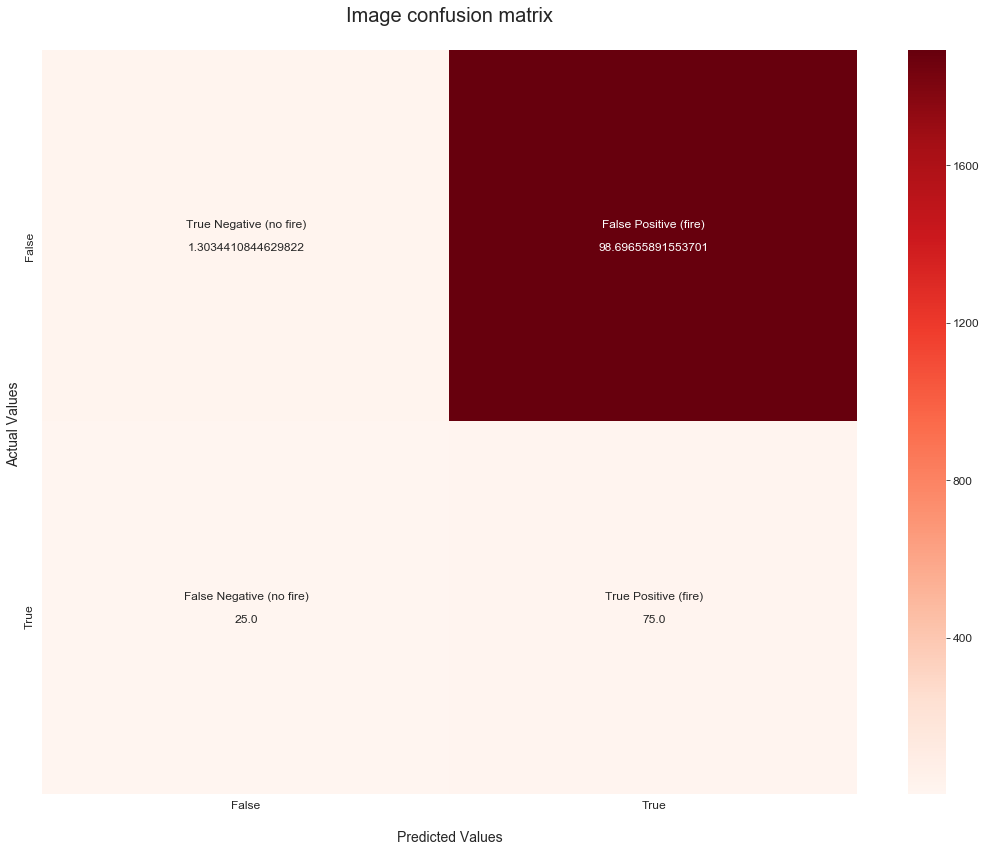

units dropouts optimizers    losses accuracies      aucs precisions  \
44    16      0.7       adam  0.707697   0.503876  0.557692          0   

   recalls                                          histories epochs  \
44       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
44        0.590158

61/61 [==============================] - 6s 98ms/step
0.65
[([1], 0.8475642), ([1], 0.84749043), ([1], 0.5485637), ([1], 0.49184567), ([1], 0.6183699), ([1], 0.6529906), ([1], 0.71964836), ([1], 0.37968782), ([1], 0.37836438), ([1], 0.6748887)]
[([1], 0.7370754), ([1], 0.5978826), ([1], 0.5696973), ([1], 0.6633064), ([1], 0.56695896), ([1], 0.66252416), ([1], 0.75299644), ([1], 0.37767074), ([1], 0.45074046), ([1], 0.85018617)]


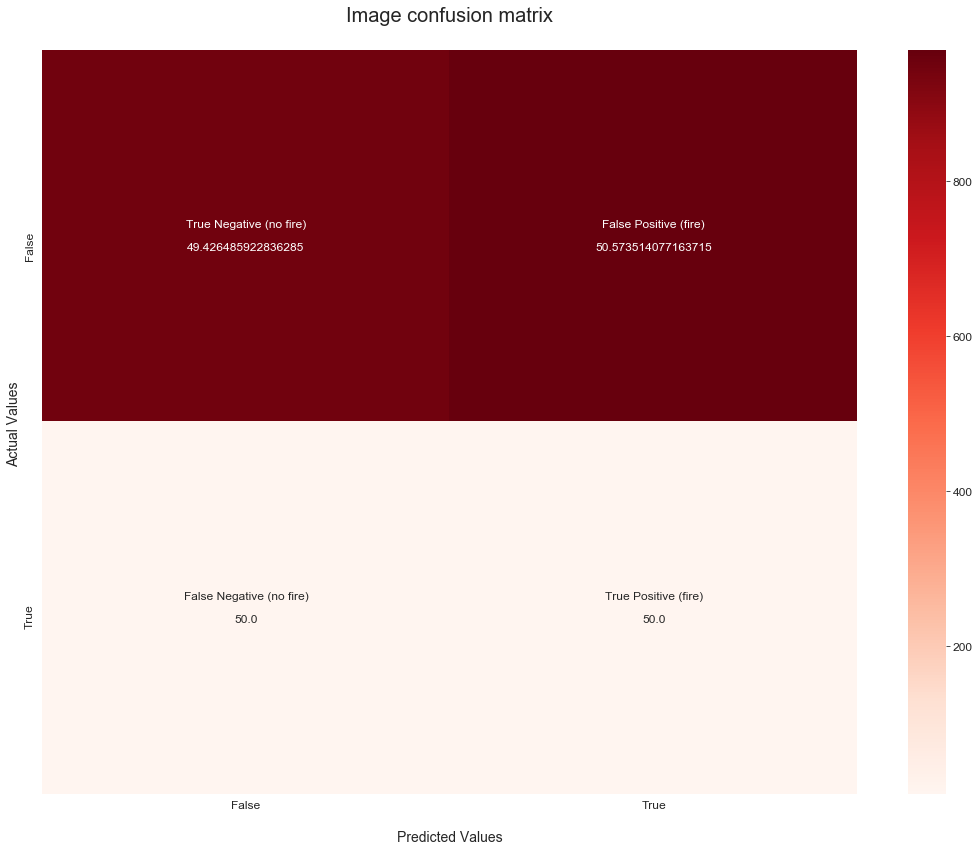

units dropouts optimizers    losses accuracies      aucs precisions  \
44    16      0.7       adam  0.707697   0.503876  0.557692          0   

   recalls                                          histories epochs  \
44       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
44        0.590158

61/61 [==============================] - 6s 98ms/step
0.725
[([1], 0.8475642), ([1], 0.84749043), ([1], 0.5485637), ([1], 0.49184567), ([1], 0.6183699), ([1], 0.6529906), ([1], 0.71964836), ([1], 0.37968782), ([1], 0.37836438), ([1], 0.6748887)]
[([1], 0.7370754), ([1], 0.5978826), ([1], 0.5696973), ([1], 0.6633064), ([1], 0.56695896), ([1], 0.66252416), ([1], 0.75299644), ([1], 0.37767074), ([1], 0.45074046), ([1], 0.85018617)]


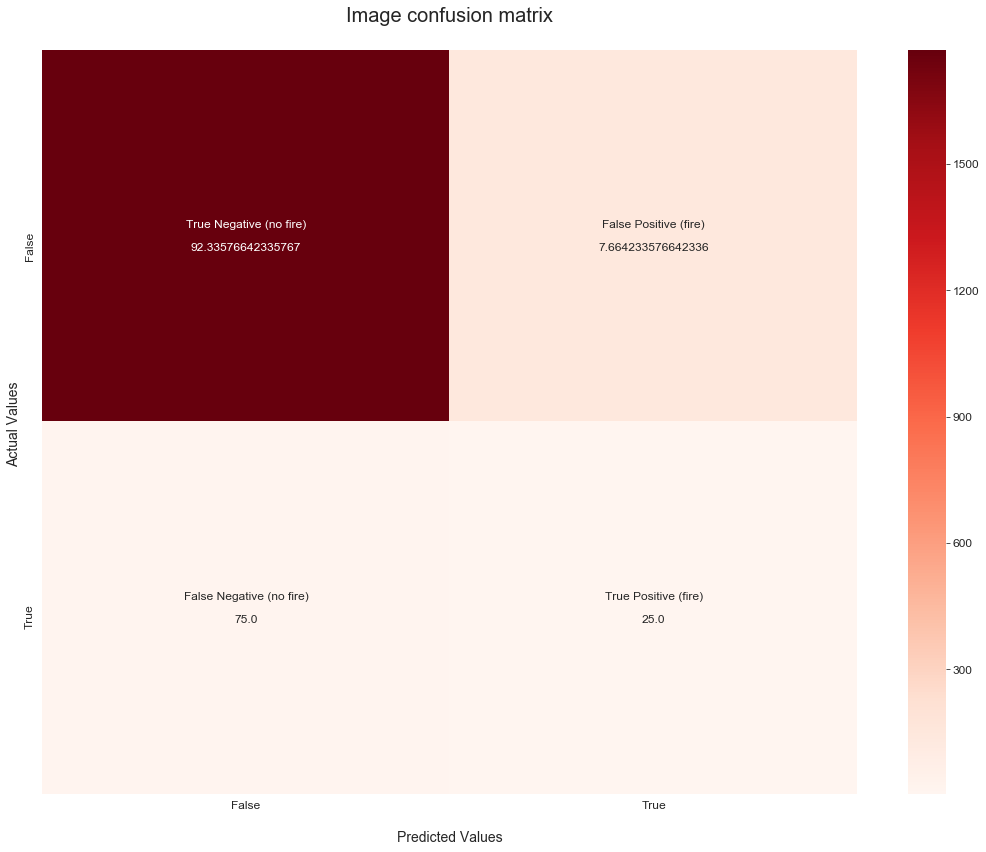

units dropouts optimizers    losses accuracies      aucs precisions  \
44    16      0.7       adam  0.707697   0.503876  0.557692          0   

   recalls                                          histories epochs  \
44       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
44        0.590158

61/61 [==============================] - 6s 98ms/step
0.8
[([1], 0.8475642), ([1], 0.84749043), ([1], 0.5485637), ([1], 0.49184567), ([1], 0.6183699), ([1], 0.6529906), ([1], 0.71964836), ([1], 0.37968782), ([1], 0.37836438), ([1], 0.6748887)]
[([1], 0.7370754), ([1], 0.5978826), ([1], 0.5696973), ([1], 0.6633064), ([1], 0.56695896), ([1], 0.66252416), ([1], 0.75299644), ([1], 0.37767074), ([1], 0.45074046), ([1], 0.85018617)]


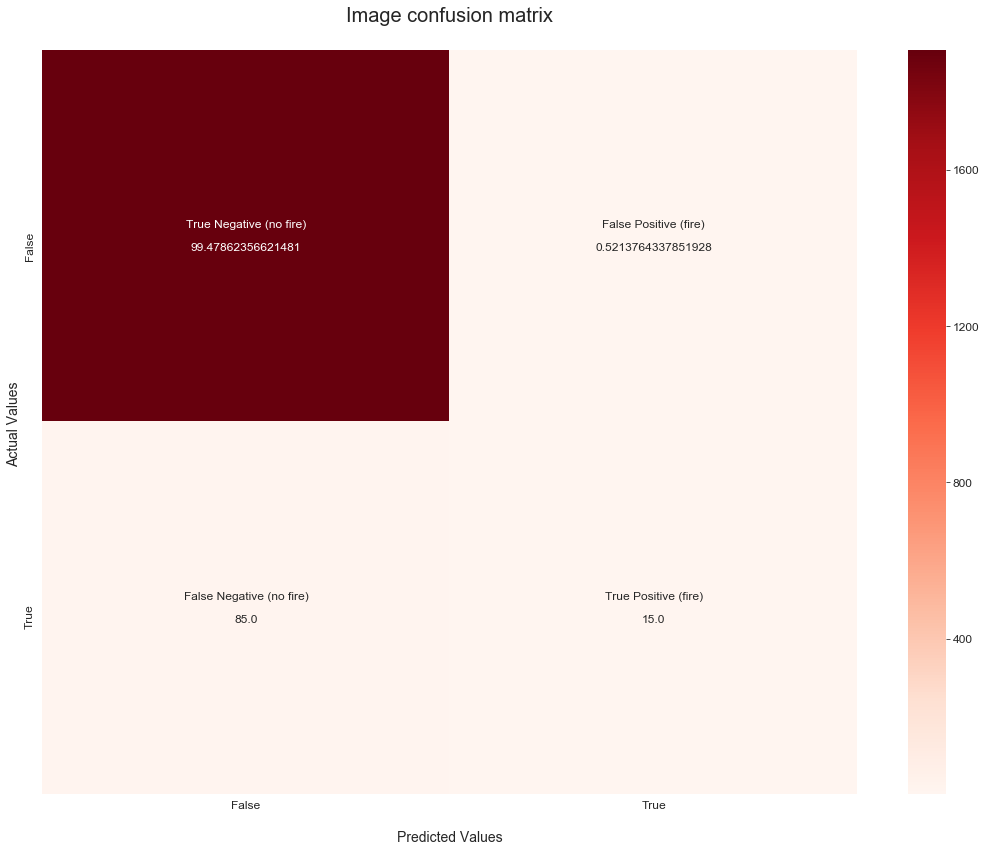

units dropouts optimizers    losses accuracies      aucs precisions  \
44    16      0.7       adam  0.707697   0.503876  0.557692          0   

   recalls                                          histories epochs  \
44       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
44        0.590158

61/61 [==============================] - 6s 99ms/step
0.85
[([1], 0.8475642), ([1], 0.84749043), ([1], 0.5485637), ([1], 0.49184567), ([1], 0.6183699), ([1], 0.6529906), ([1], 0.71964836), ([1], 0.37968782), ([1], 0.37836438), ([1], 0.6748887)]
[([1], 0.7370754), ([1], 0.5978826), ([1], 0.5696973), ([1], 0.6633064), ([1], 0.56695896), ([1], 0.66252416), ([1], 0.75299644), ([1], 0.37767074), ([1], 0.45074046), ([1], 0.85018617)]


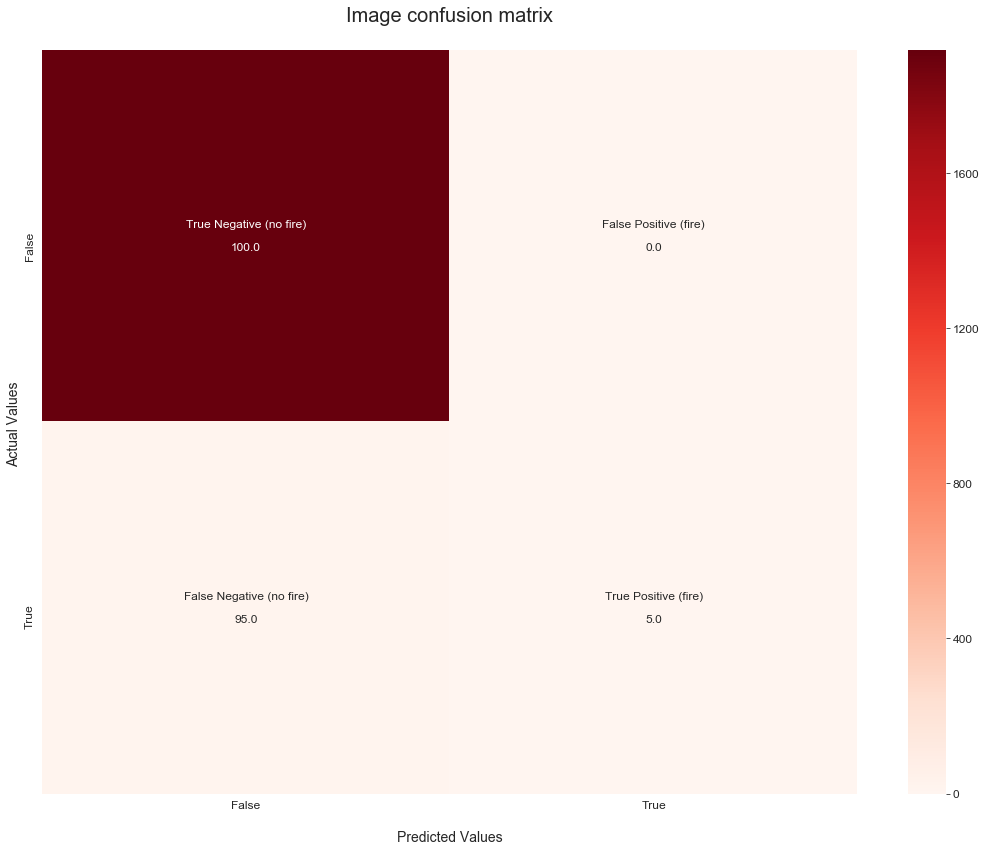

units dropouts optimizers    losses accuracies      aucs precisions  \
44    16      0.7       adam  0.707697   0.503876  0.557692          0   

   recalls                                          histories epochs  \
44       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
44        0.590158

61/61 [==============================] - 7s 102ms/step
0.9
[([1], 0.8475642), ([1], 0.84749043), ([1], 0.5485637), ([1], 0.49184567), ([1], 0.6183699), ([1], 0.6529906), ([1], 0.71964836), ([1], 0.37968782), ([1], 0.37836438), ([1], 0.6748887)]
[([1], 0.7370754), ([1], 0.5978826), ([1], 0.5696973), ([1], 0.6633064), ([1], 0.56695896), ([1], 0.66252416), ([1], 0.75299644), ([1], 0.37767074), ([1], 0.45074046), ([1], 0.85018617)]


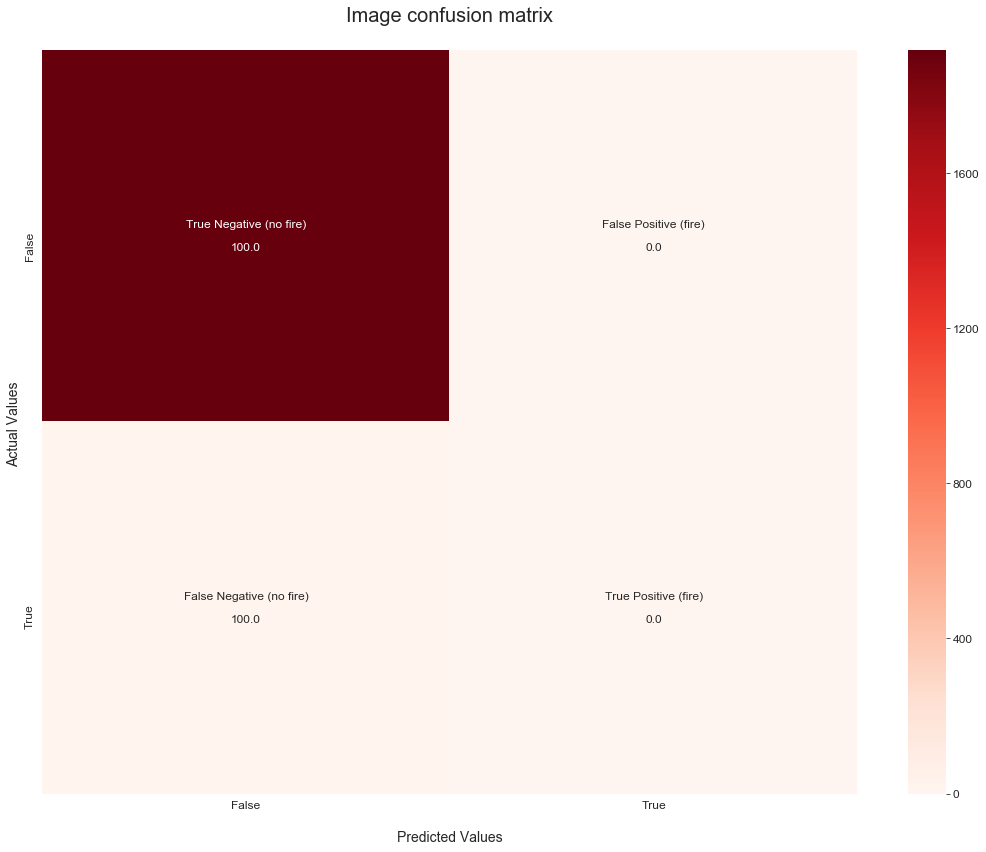

units dropouts optimizers    losses accuracies      aucs precisions  \
44    16      0.7       adam  0.707697   0.503876  0.557692          0   

   recalls                                          histories epochs  \
44       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
44        0.590158

61/61 [==============================] - 6s 93ms/step
0.95
[([1], 0.8475642), ([1], 0.84749043), ([1], 0.5485637), ([1], 0.49184567), ([1], 0.6183699), ([1], 0.6529906), ([1], 0.71964836), ([1], 0.37968782), ([1], 0.37836438), ([1], 0.6748887)]
[([1], 0.7370754), ([1], 0.5978826), ([1], 0.5696973), ([1], 0.6633064), ([1], 0.56695896), ([1], 0.66252416), ([1], 0.75299644), ([1], 0.37767074), ([1], 0.45074046), ([1], 0.85018617)]


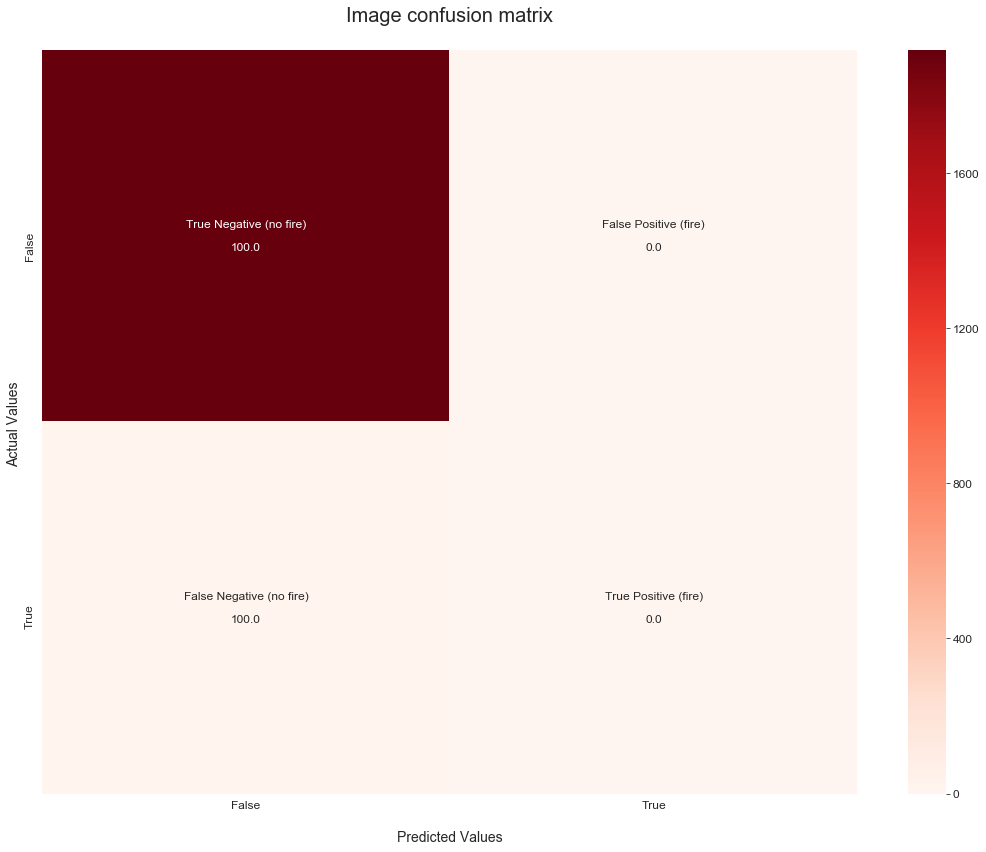

units dropouts optimizers    losses accuracies      aucs precisions  \
45    16      0.7      Nadam  0.713994   0.503876  0.789303          0   

   recalls                                          histories epochs  \
45       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
45        0.608472

61/61 [==============================] - 6s 93ms/step
0.1
[([1], 0.98557425), ([1], 0.95512426), ([1], 0.8411045), ([1], 0.57331425), ([1], 0.8819679), ([1], 0.8658419), ([1], 0.94947326), ([1], 0.45561588), ([1], 0.40692335), ([1], 0.8733661)]
[([1], 0.9609399), ([1], 0.79797566), ([1], 0.8985524), ([1], 0.87631714), ([1], 0.8034419), ([1], 0.89324665), ([1], 0.95726216), ([1], 0.440078), ([1], 0.49086392), ([1], 0.90617615)]


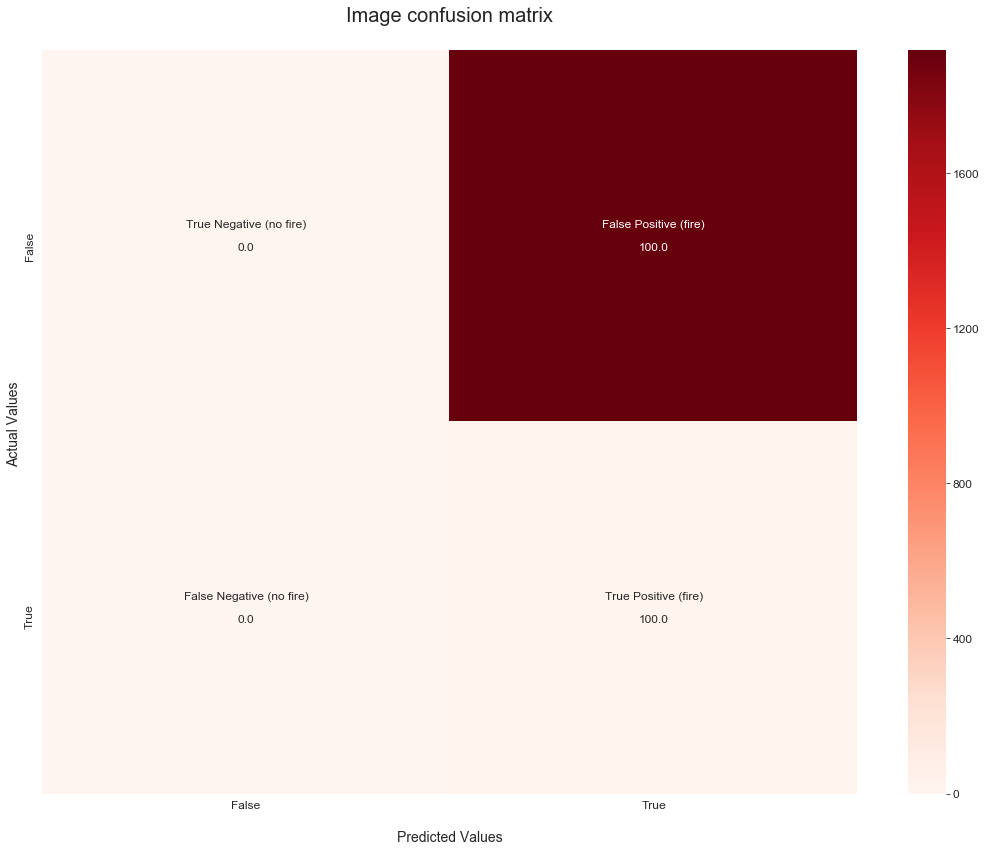

units dropouts optimizers    losses accuracies      aucs precisions  \
45    16      0.7      Nadam  0.713994   0.503876  0.789303          0   

   recalls                                          histories epochs  \
45       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
45        0.608472

61/61 [==============================] - 6s 93ms/step
0.3
[([1], 0.98557425), ([1], 0.95512426), ([1], 0.8411045), ([1], 0.57331425), ([1], 0.8819679), ([1], 0.8658419), ([1], 0.94947326), ([1], 0.45561588), ([1], 0.40692335), ([1], 0.8733661)]
[([1], 0.9609399), ([1], 0.79797566), ([1], 0.8985524), ([1], 0.87631714), ([1], 0.8034419), ([1], 0.89324665), ([1], 0.95726216), ([1], 0.440078), ([1], 0.49086392), ([1], 0.90617615)]


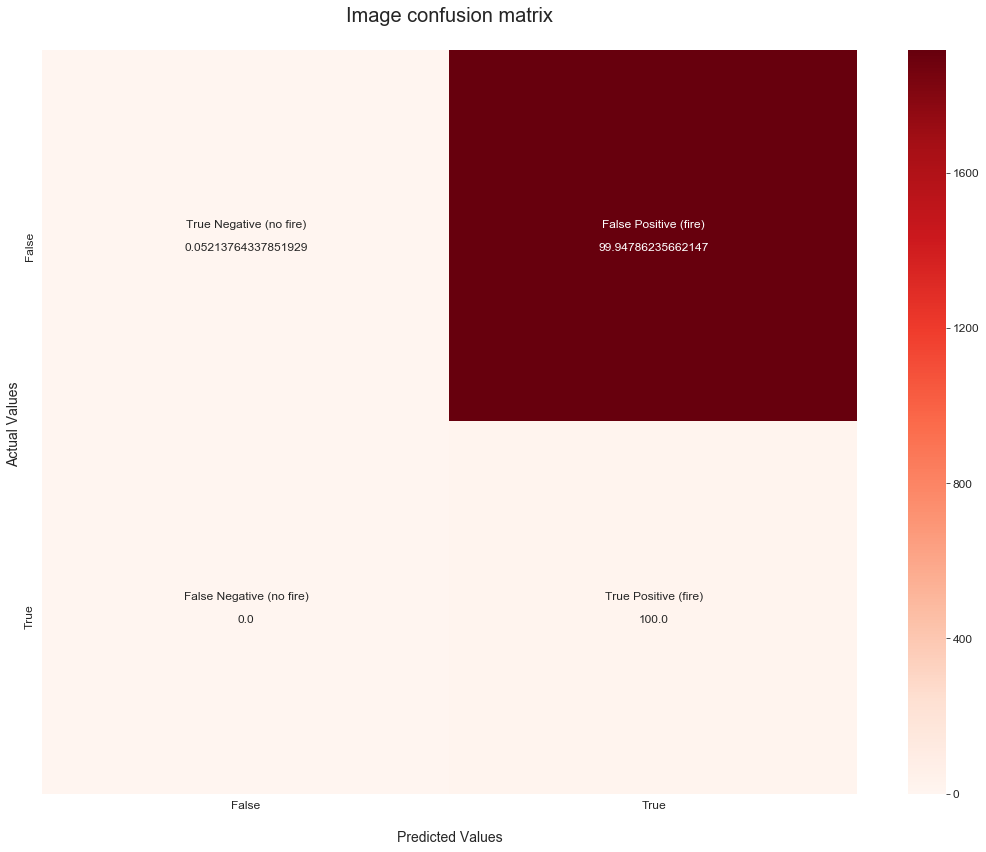

units dropouts optimizers    losses accuracies      aucs precisions  \
45    16      0.7      Nadam  0.713994   0.503876  0.789303          0   

   recalls                                          histories epochs  \
45       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
45        0.608472

61/61 [==============================] - 6s 93ms/step
0.5
[([1], 0.98557425), ([1], 0.95512426), ([1], 0.8411045), ([1], 0.57331425), ([1], 0.8819679), ([1], 0.8658419), ([1], 0.94947326), ([1], 0.45561588), ([1], 0.40692335), ([1], 0.8733661)]
[([1], 0.9609399), ([1], 0.79797566), ([1], 0.8985524), ([1], 0.87631714), ([1], 0.8034419), ([1], 0.89324665), ([1], 0.95726216), ([1], 0.440078), ([1], 0.49086392), ([1], 0.90617615)]


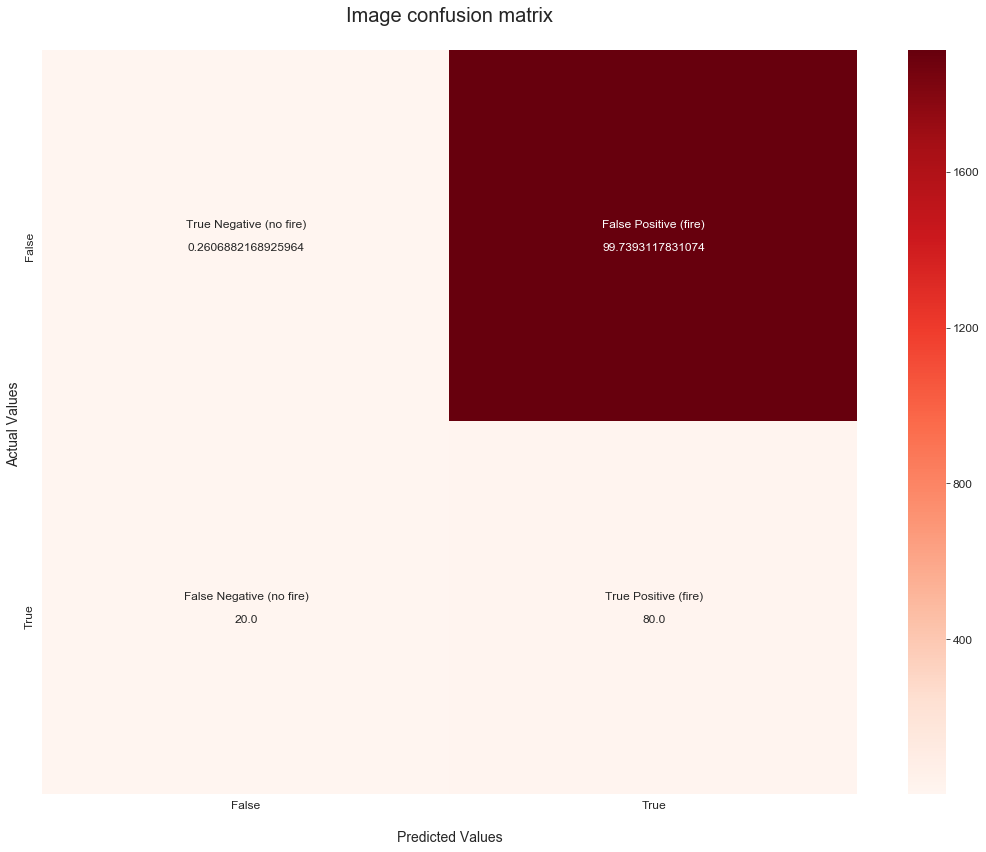

units dropouts optimizers    losses accuracies      aucs precisions  \
45    16      0.7      Nadam  0.713994   0.503876  0.789303          0   

   recalls                                          histories epochs  \
45       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
45        0.608472

61/61 [==============================] - 6s 98ms/step
0.65
[([1], 0.98557425), ([1], 0.95512426), ([1], 0.8411045), ([1], 0.57331425), ([1], 0.8819679), ([1], 0.8658419), ([1], 0.94947326), ([1], 0.45561588), ([1], 0.40692335), ([1], 0.8733661)]
[([1], 0.9609399), ([1], 0.79797566), ([1], 0.8985524), ([1], 0.87631714), ([1], 0.8034419), ([1], 0.89324665), ([1], 0.95726216), ([1], 0.440078), ([1], 0.49086392), ([1], 0.90617615)]


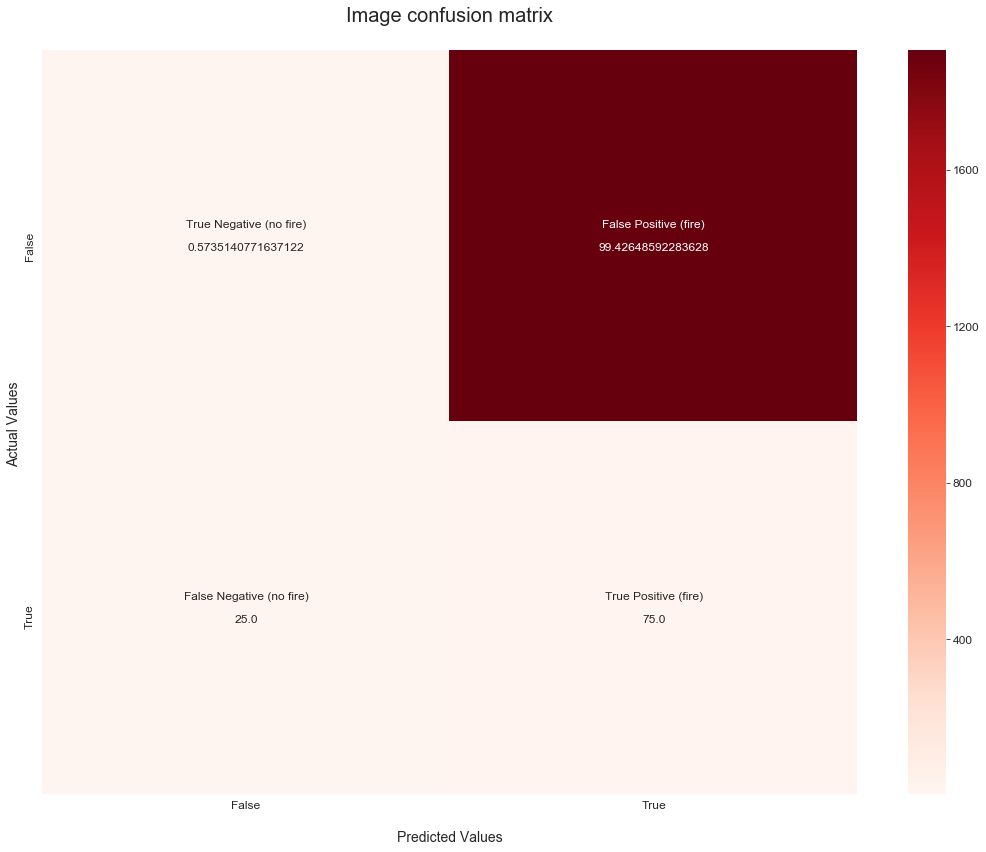

units dropouts optimizers    losses accuracies      aucs precisions  \
45    16      0.7      Nadam  0.713994   0.503876  0.789303          0   

   recalls                                          histories epochs  \
45       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
45        0.608472

61/61 [==============================] - 6s 95ms/step
0.725
[([1], 0.98557425), ([1], 0.95512426), ([1], 0.8411045), ([1], 0.57331425), ([1], 0.8819679), ([1], 0.8658419), ([1], 0.94947326), ([1], 0.45561588), ([1], 0.40692335), ([1], 0.8733661)]
[([1], 0.9609399), ([1], 0.79797566), ([1], 0.8985524), ([1], 0.87631714), ([1], 0.8034419), ([1], 0.89324665), ([1], 0.95726216), ([1], 0.440078), ([1], 0.49086392), ([1], 0.90617615)]


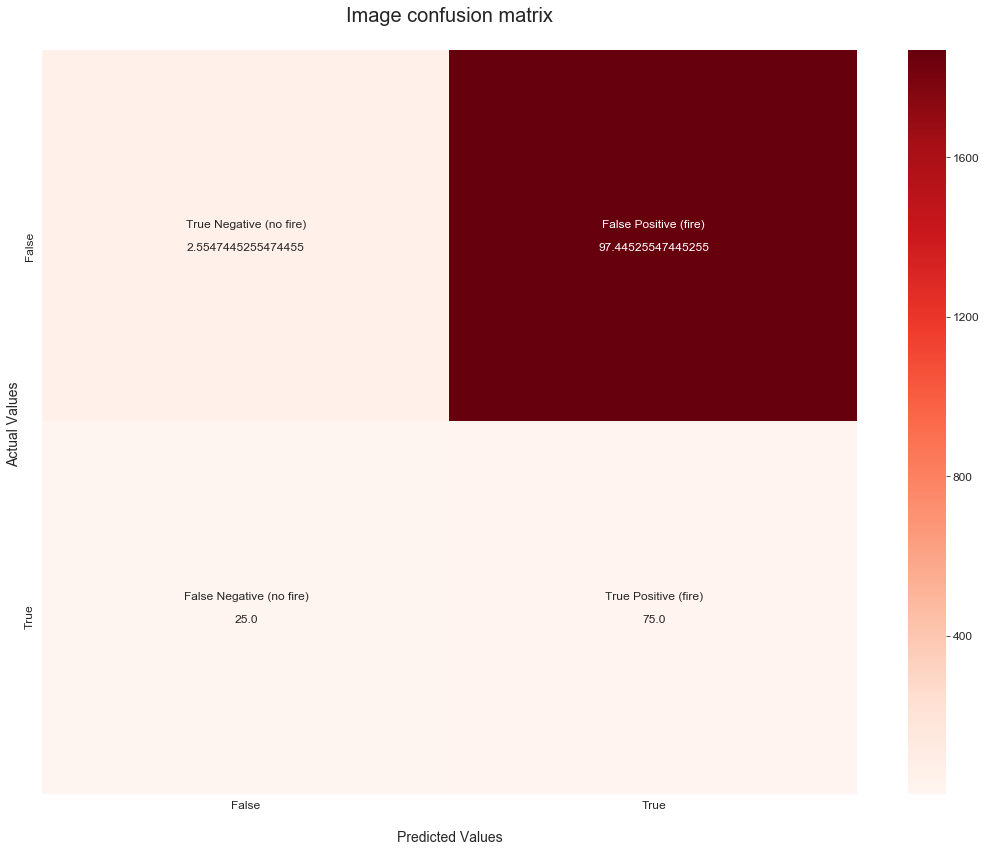

units dropouts optimizers    losses accuracies      aucs precisions  \
45    16      0.7      Nadam  0.713994   0.503876  0.789303          0   

   recalls                                          histories epochs  \
45       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
45        0.608472

61/61 [==============================] - 6s 93ms/step
0.8
[([1], 0.98557425), ([1], 0.95512426), ([1], 0.8411045), ([1], 0.57331425), ([1], 0.8819679), ([1], 0.8658419), ([1], 0.94947326), ([1], 0.45561588), ([1], 0.40692335), ([1], 0.8733661)]
[([1], 0.9609399), ([1], 0.79797566), ([1], 0.8985524), ([1], 0.87631714), ([1], 0.8034419), ([1], 0.89324665), ([1], 0.95726216), ([1], 0.440078), ([1], 0.49086392), ([1], 0.90617615)]


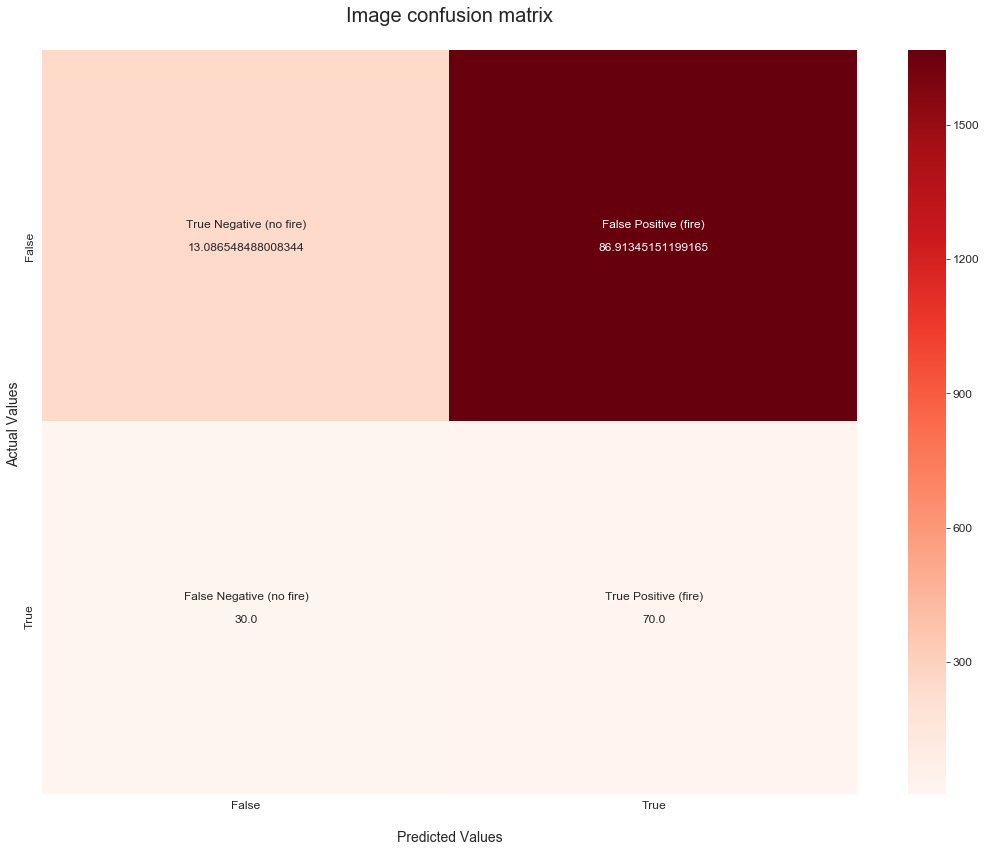

units dropouts optimizers    losses accuracies      aucs precisions  \
45    16      0.7      Nadam  0.713994   0.503876  0.789303          0   

   recalls                                          histories epochs  \
45       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
45        0.608472

61/61 [==============================] - 6s 93ms/step
0.85
[([1], 0.98557425), ([1], 0.95512426), ([1], 0.8411045), ([1], 0.57331425), ([1], 0.8819679), ([1], 0.8658419), ([1], 0.94947326), ([1], 0.45561588), ([1], 0.40692335), ([1], 0.8733661)]
[([1], 0.9609399), ([1], 0.79797566), ([1], 0.8985524), ([1], 0.87631714), ([1], 0.8034419), ([1], 0.89324665), ([1], 0.95726216), ([1], 0.440078), ([1], 0.49086392), ([1], 0.90617615)]


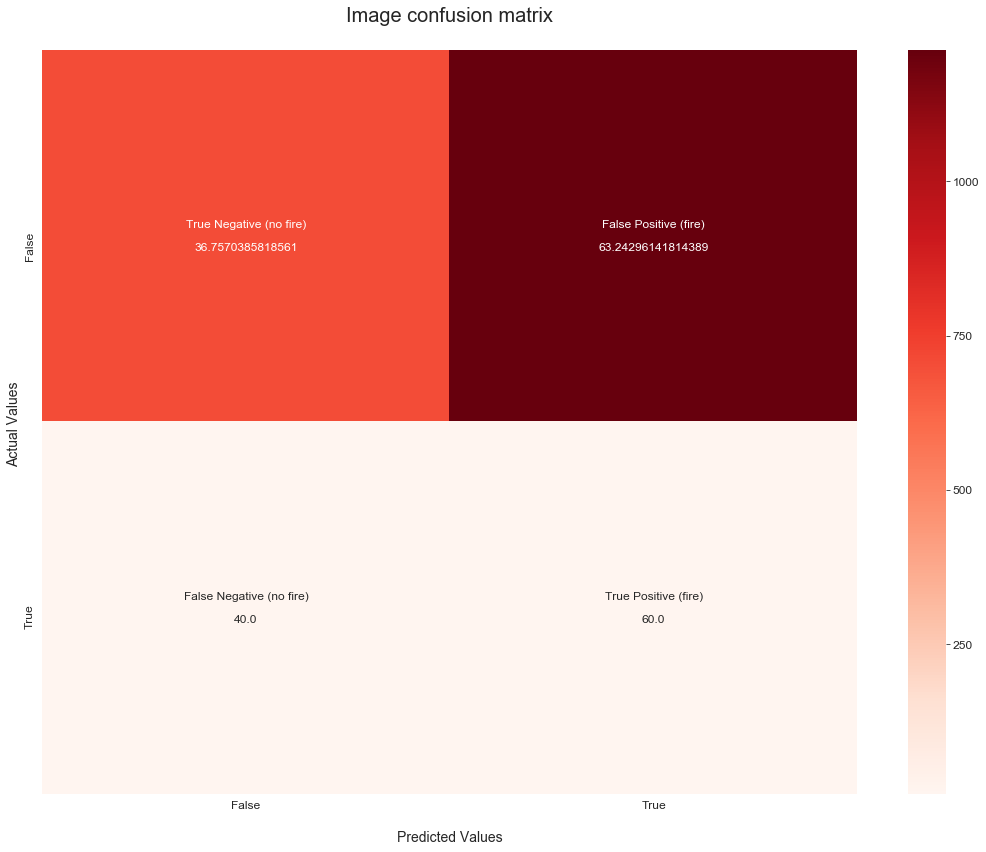

units dropouts optimizers    losses accuracies      aucs precisions  \
45    16      0.7      Nadam  0.713994   0.503876  0.789303          0   

   recalls                                          histories epochs  \
45       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
45        0.608472

61/61 [==============================] - 6s 93ms/step
0.9
[([1], 0.98557425), ([1], 0.95512426), ([1], 0.8411045), ([1], 0.57331425), ([1], 0.8819679), ([1], 0.8658419), ([1], 0.94947326), ([1], 0.45561588), ([1], 0.40692335), ([1], 0.8733661)]
[([1], 0.9609399), ([1], 0.79797566), ([1], 0.8985524), ([1], 0.87631714), ([1], 0.8034419), ([1], 0.89324665), ([1], 0.95726216), ([1], 0.440078), ([1], 0.49086392), ([1], 0.90617615)]


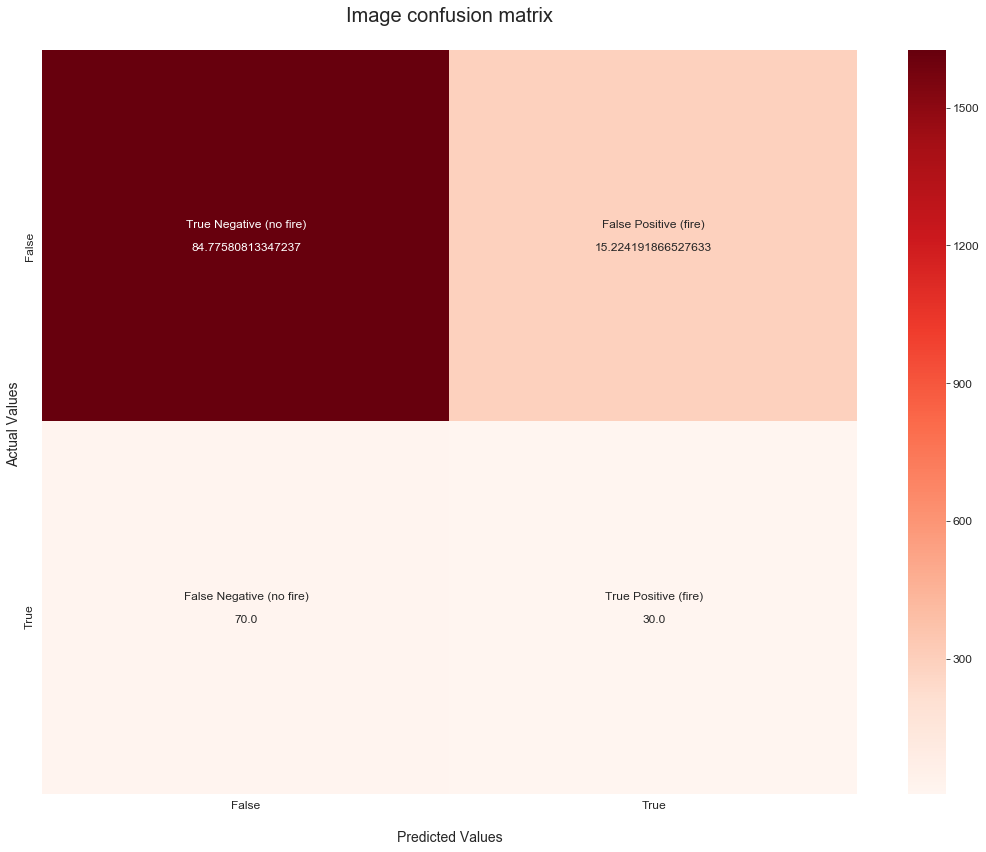

units dropouts optimizers    losses accuracies      aucs precisions  \
45    16      0.7      Nadam  0.713994   0.503876  0.789303          0   

   recalls                                          histories epochs  \
45       0  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
45        0.608472

61/61 [==============================] - 6s 95ms/step
0.95
[([1], 0.98557425), ([1], 0.95512426), ([1], 0.8411045), ([1], 0.57331425), ([1], 0.8819679), ([1], 0.8658419), ([1], 0.94947326), ([1], 0.45561588), ([1], 0.40692335), ([1], 0.8733661)]
[([1], 0.9609399), ([1], 0.79797566), ([1], 0.8985524), ([1], 0.87631714), ([1], 0.8034419), ([1], 0.89324665), ([1], 0.95726216), ([1], 0.440078), ([1], 0.49086392), ([1], 0.90617615)]


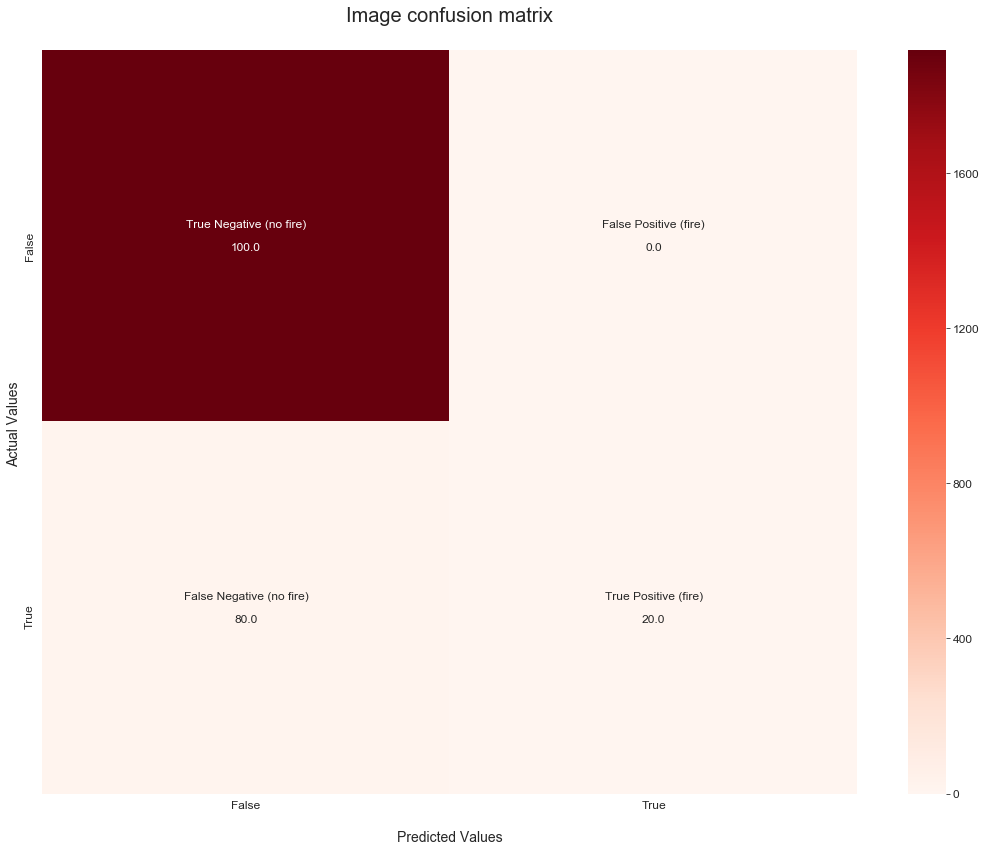

units dropouts optimizers    losses accuracies      aucs precisions  \
46    16      0.7    RMSprop  0.692718   0.488372  0.596514   0.492188   

     recalls                                          histories epochs  \
46  0.984375  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
46        0.492893

61/61 [==============================] - 6s 93ms/step
0.1
[([1], 0.8959638), ([1], 0.87460345), ([1], 0.6926369), ([1], 0.51854676), ([1], 0.7053769), ([1], 0.7731888), ([1], 0.87902486), ([1], 0.47569802), ([1], 0.33551615), ([1], 0.69281113)]
[([1], 0.83449674), ([1], 0.6020798), ([1], 0.7237683), ([1], 0.62526006), ([1], 0.64048743), ([1], 0.7577367), ([1], 0.8868077), ([1], 0.4723866), ([1], 0.33744067), ([1], 0.70566547)]


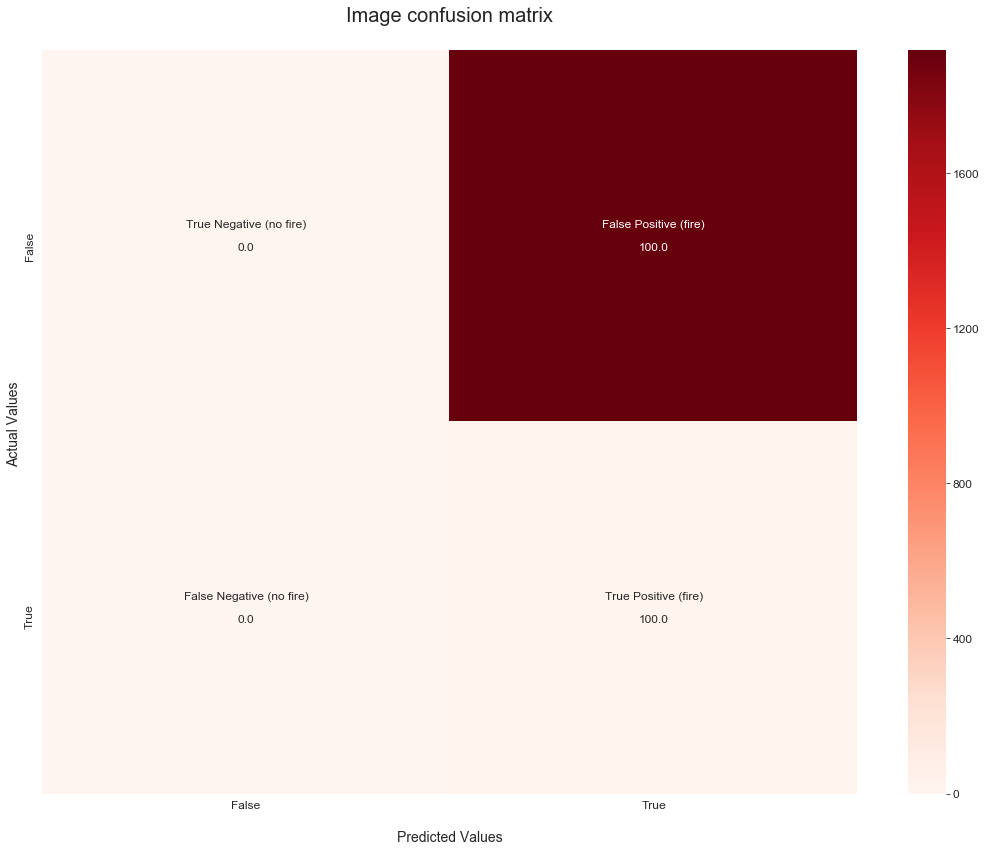

units dropouts optimizers    losses accuracies      aucs precisions  \
46    16      0.7    RMSprop  0.692718   0.488372  0.596514   0.492188   

     recalls                                          histories epochs  \
46  0.984375  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
46        0.492893

61/61 [==============================] - 6s 93ms/step
0.3
[([1], 0.8959638), ([1], 0.87460345), ([1], 0.6926369), ([1], 0.51854676), ([1], 0.7053769), ([1], 0.7731888), ([1], 0.87902486), ([1], 0.47569802), ([1], 0.33551615), ([1], 0.69281113)]
[([1], 0.83449674), ([1], 0.6020798), ([1], 0.7237683), ([1], 0.62526006), ([1], 0.64048743), ([1], 0.7577367), ([1], 0.8868077), ([1], 0.4723866), ([1], 0.33744067), ([1], 0.70566547)]


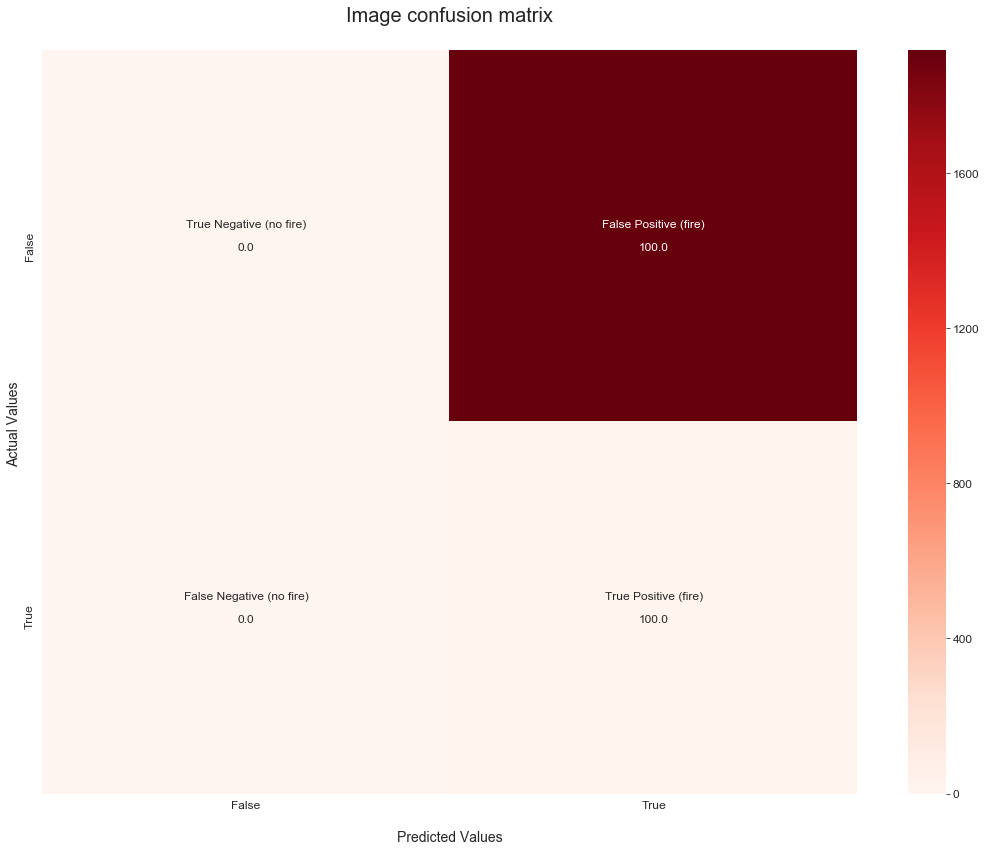

units dropouts optimizers    losses accuracies      aucs precisions  \
46    16      0.7    RMSprop  0.692718   0.488372  0.596514   0.492188   

     recalls                                          histories epochs  \
46  0.984375  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
46        0.492893

61/61 [==============================] - 6s 93ms/step
0.5
[([1], 0.8959638), ([1], 0.87460345), ([1], 0.6926369), ([1], 0.51854676), ([1], 0.7053769), ([1], 0.7731888), ([1], 0.87902486), ([1], 0.47569802), ([1], 0.33551615), ([1], 0.69281113)]
[([1], 0.83449674), ([1], 0.6020798), ([1], 0.7237683), ([1], 0.62526006), ([1], 0.64048743), ([1], 0.7577367), ([1], 0.8868077), ([1], 0.4723866), ([1], 0.33744067), ([1], 0.70566547)]


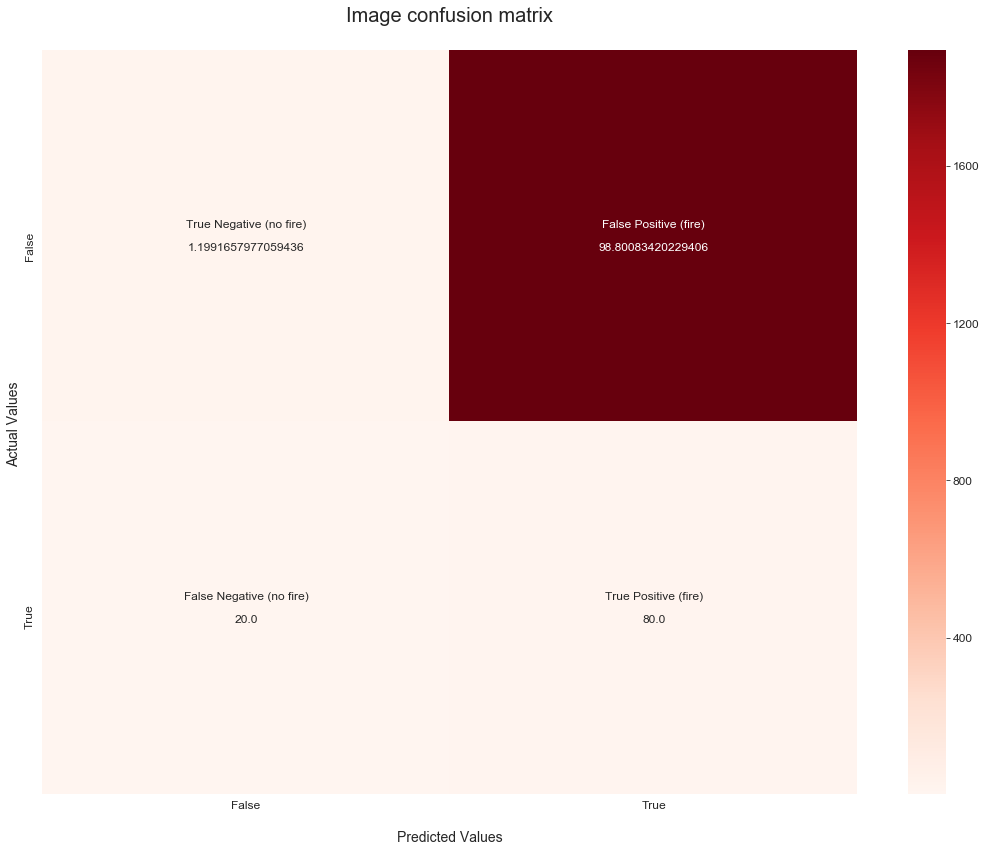

units dropouts optimizers    losses accuracies      aucs precisions  \
46    16      0.7    RMSprop  0.692718   0.488372  0.596514   0.492188   

     recalls                                          histories epochs  \
46  0.984375  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
46        0.492893

61/61 [==============================] - 6s 94ms/step
0.65
[([1], 0.8959638), ([1], 0.87460345), ([1], 0.6926369), ([1], 0.51854676), ([1], 0.7053769), ([1], 0.7731888), ([1], 0.87902486), ([1], 0.47569802), ([1], 0.33551615), ([1], 0.69281113)]
[([1], 0.83449674), ([1], 0.6020798), ([1], 0.7237683), ([1], 0.62526006), ([1], 0.64048743), ([1], 0.7577367), ([1], 0.8868077), ([1], 0.4723866), ([1], 0.33744067), ([1], 0.70566547)]


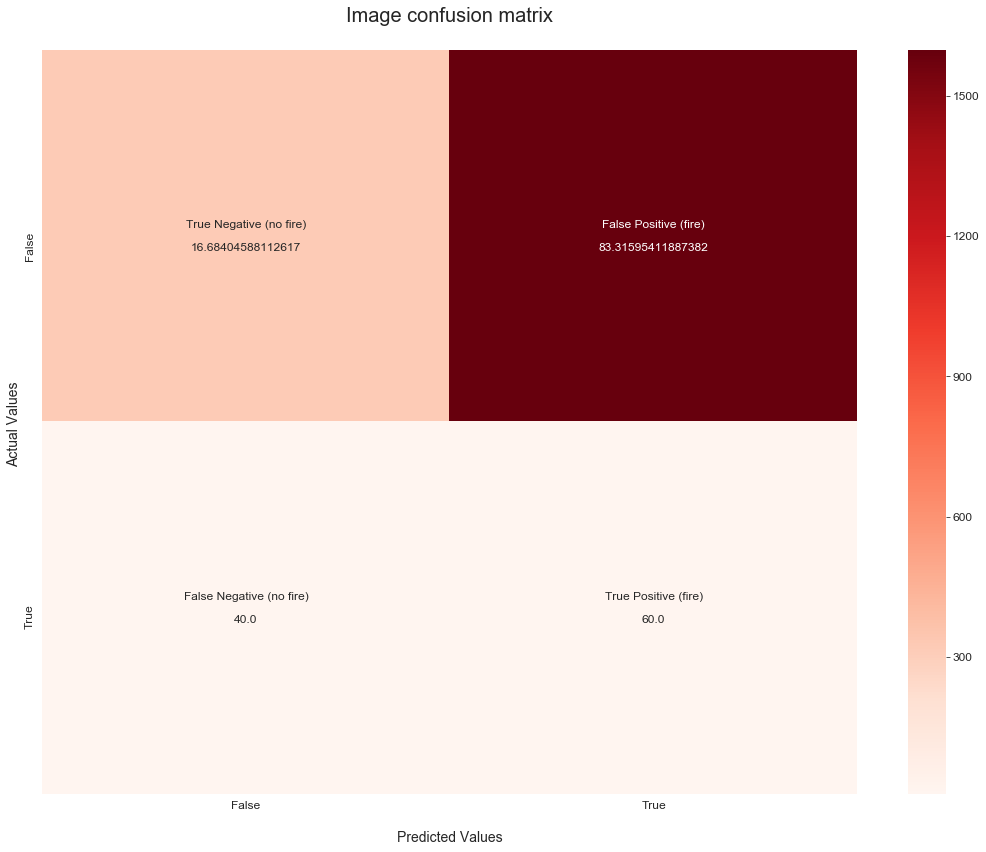

units dropouts optimizers    losses accuracies      aucs precisions  \
46    16      0.7    RMSprop  0.692718   0.488372  0.596514   0.492188   

     recalls                                          histories epochs  \
46  0.984375  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
46        0.492893

61/61 [==============================] - 6s 93ms/step
0.725
[([1], 0.8959638), ([1], 0.87460345), ([1], 0.6926369), ([1], 0.51854676), ([1], 0.7053769), ([1], 0.7731888), ([1], 0.87902486), ([1], 0.47569802), ([1], 0.33551615), ([1], 0.69281113)]
[([1], 0.83449674), ([1], 0.6020798), ([1], 0.7237683), ([1], 0.62526006), ([1], 0.64048743), ([1], 0.7577367), ([1], 0.8868077), ([1], 0.4723866), ([1], 0.33744067), ([1], 0.70566547)]


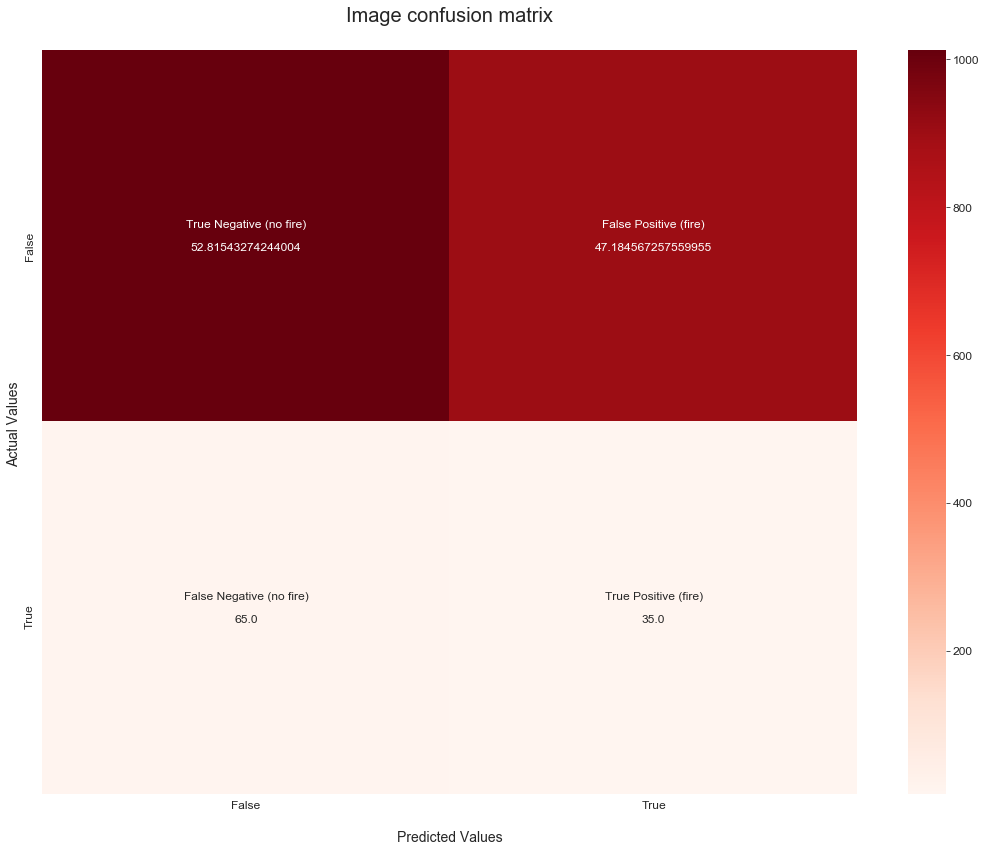

units dropouts optimizers    losses accuracies      aucs precisions  \
46    16      0.7    RMSprop  0.692718   0.488372  0.596514   0.492188   

     recalls                                          histories epochs  \
46  0.984375  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
46        0.492893

61/61 [==============================] - 6s 94ms/step
0.8
[([1], 0.8959638), ([1], 0.87460345), ([1], 0.6926369), ([1], 0.51854676), ([1], 0.7053769), ([1], 0.7731888), ([1], 0.87902486), ([1], 0.47569802), ([1], 0.33551615), ([1], 0.69281113)]
[([1], 0.83449674), ([1], 0.6020798), ([1], 0.7237683), ([1], 0.62526006), ([1], 0.64048743), ([1], 0.7577367), ([1], 0.8868077), ([1], 0.4723866), ([1], 0.33744067), ([1], 0.70566547)]


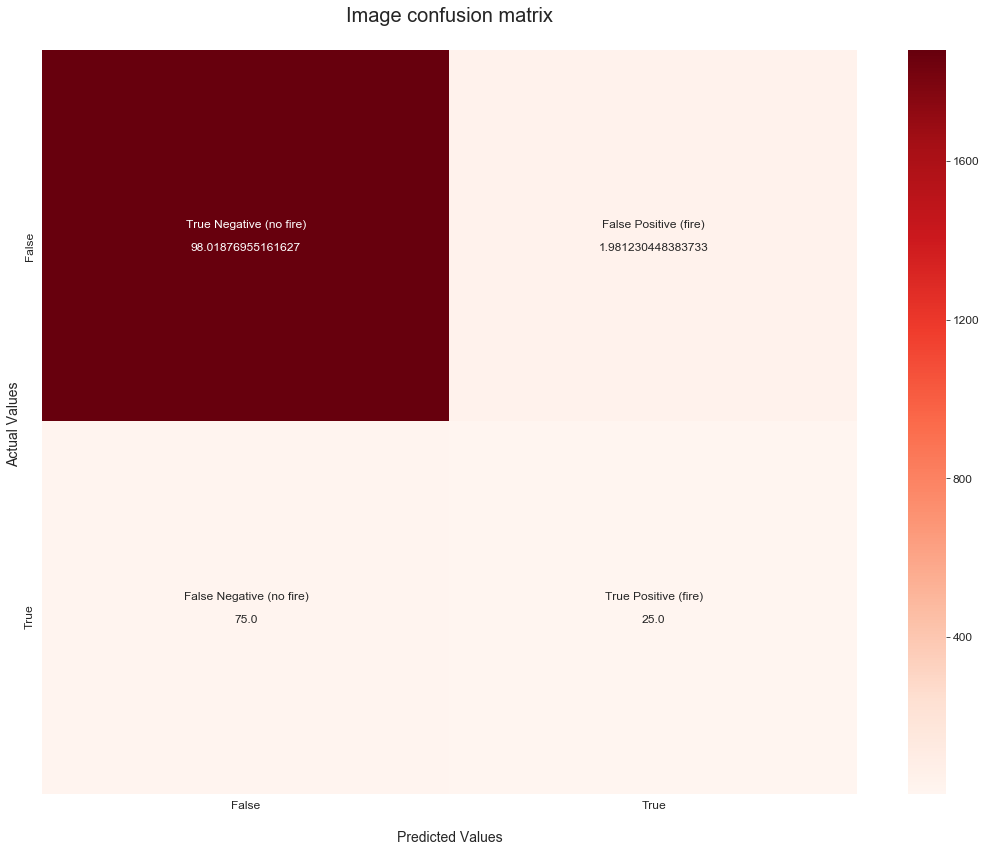

units dropouts optimizers    losses accuracies      aucs precisions  \
46    16      0.7    RMSprop  0.692718   0.488372  0.596514   0.492188   

     recalls                                          histories epochs  \
46  0.984375  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
46        0.492893

61/61 [==============================] - 6s 94ms/step
0.85
[([1], 0.8959638), ([1], 0.87460345), ([1], 0.6926369), ([1], 0.51854676), ([1], 0.7053769), ([1], 0.7731888), ([1], 0.87902486), ([1], 0.47569802), ([1], 0.33551615), ([1], 0.69281113)]
[([1], 0.83449674), ([1], 0.6020798), ([1], 0.7237683), ([1], 0.62526006), ([1], 0.64048743), ([1], 0.7577367), ([1], 0.8868077), ([1], 0.4723866), ([1], 0.33744067), ([1], 0.70566547)]


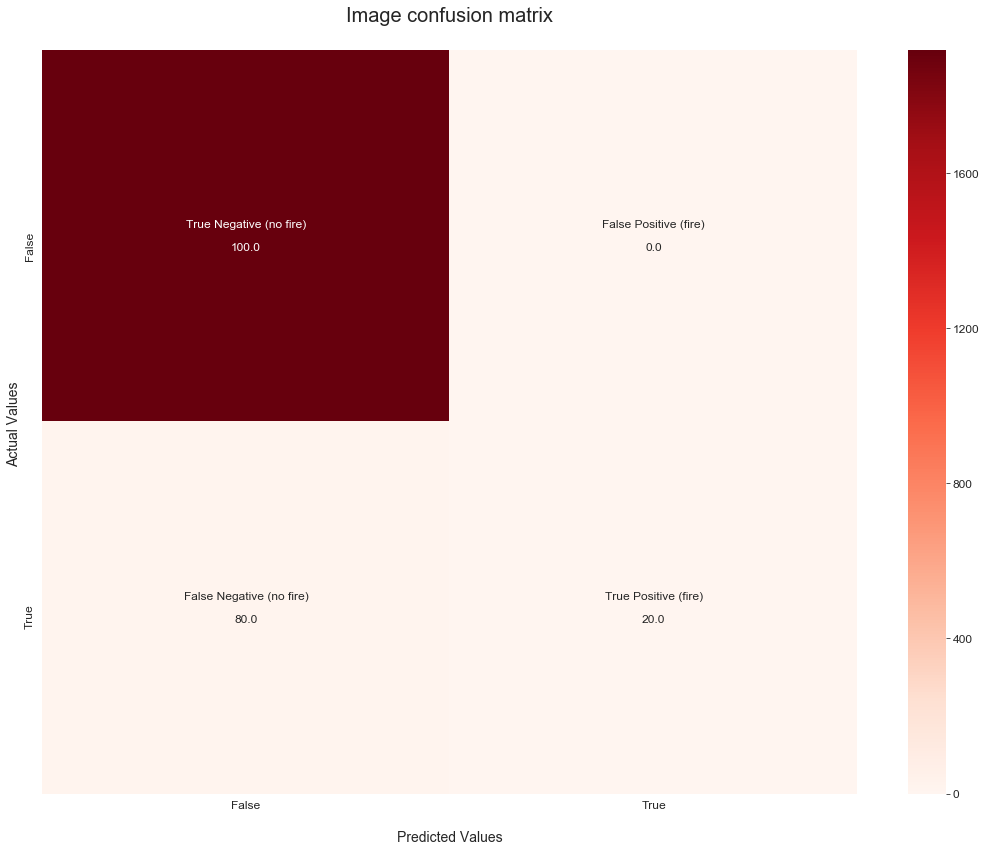

units dropouts optimizers    losses accuracies      aucs precisions  \
46    16      0.7    RMSprop  0.692718   0.488372  0.596514   0.492188   

     recalls                                          histories epochs  \
46  0.984375  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
46        0.492893

61/61 [==============================] - 6s 94ms/step
0.9
[([1], 0.8959638), ([1], 0.87460345), ([1], 0.6926369), ([1], 0.51854676), ([1], 0.7053769), ([1], 0.7731888), ([1], 0.87902486), ([1], 0.47569802), ([1], 0.33551615), ([1], 0.69281113)]
[([1], 0.83449674), ([1], 0.6020798), ([1], 0.7237683), ([1], 0.62526006), ([1], 0.64048743), ([1], 0.7577367), ([1], 0.8868077), ([1], 0.4723866), ([1], 0.33744067), ([1], 0.70566547)]


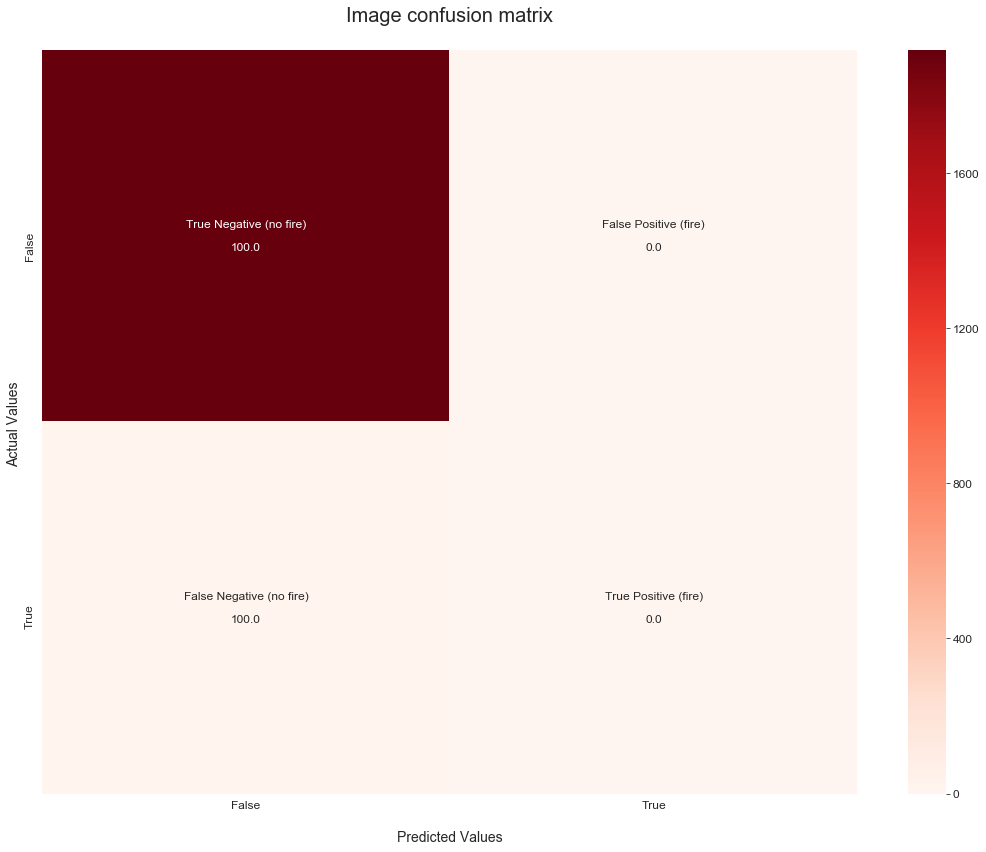

units dropouts optimizers    losses accuracies      aucs precisions  \
46    16      0.7    RMSprop  0.692718   0.488372  0.596514   0.492188   

     recalls                                          histories epochs  \
46  0.984375  <keras.callbacks.History object at 0x000002B0B...      4   

   best thresholds  
46        0.492893

61/61 [==============================] - 6s 93ms/step
0.95
[([1], 0.8959638), ([1], 0.87460345), ([1], 0.6926369), ([1], 0.51854676), ([1], 0.7053769), ([1], 0.7731888), ([1], 0.87902486), ([1], 0.47569802), ([1], 0.33551615), ([1], 0.69281113)]
[([1], 0.83449674), ([1], 0.6020798), ([1], 0.7237683), ([1], 0.62526006), ([1], 0.64048743), ([1], 0.7577367), ([1], 0.8868077), ([1], 0.4723866), ([1], 0.33744067), ([1], 0.70566547)]


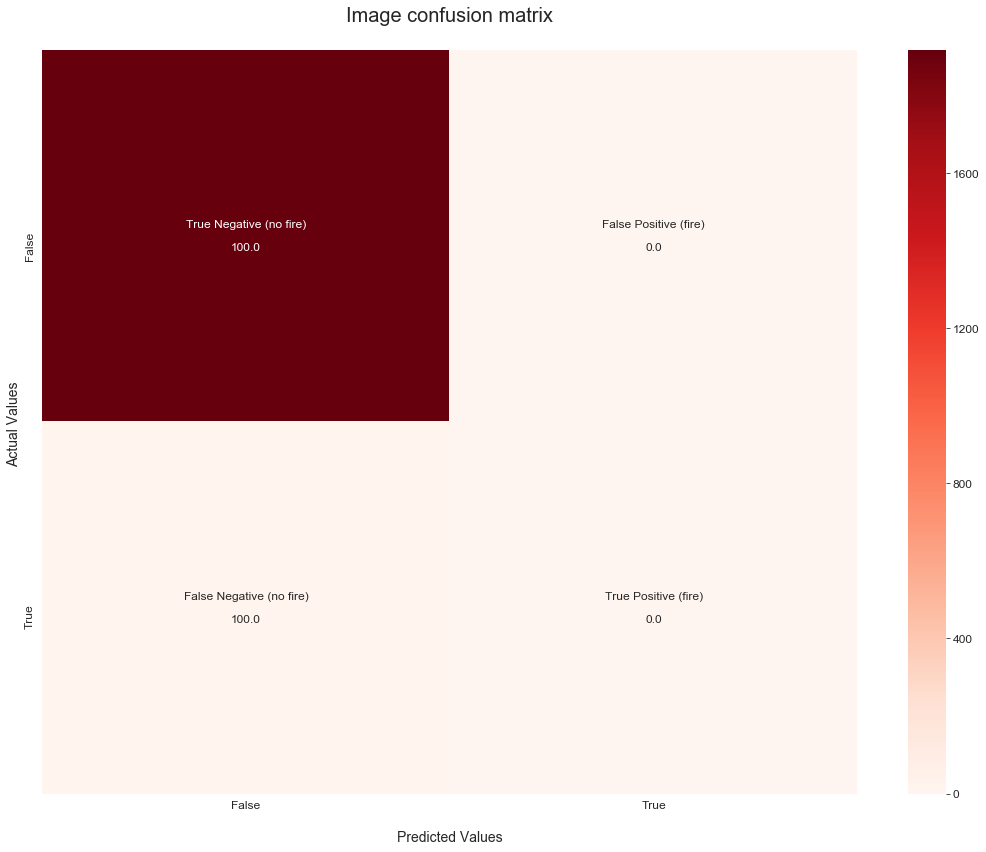

units dropouts optimizers    losses accuracies      aucs precisions  \
47    16      0.7       adam  0.694301   0.496124  0.621755   0.496124   

   recalls                                          histories epochs  \
47       1  <keras.callbacks.History object at 0x000002B0A...      5   

   best thresholds  
47        0.456203

61/61 [==============================] - 6s 93ms/step
0.1
[([1], 0.99912894), ([1], 0.9904882), ([1], 0.9833124), ([1], 0.9161403), ([1], 0.9803158), ([1], 0.99751985), ([1], 0.9965012), ([1], 0.64489114), ([1], 0.45557112), ([1], 0.971407)]
[([1], 0.9957257), ([1], 0.9084208), ([1], 0.98906386), ([1], 0.9750461), ([1], 0.95431423), ([1], 0.9973194), ([1], 0.99715686), ([1], 0.5923394), ([1], 0.46202743), ([1], 0.9679937)]


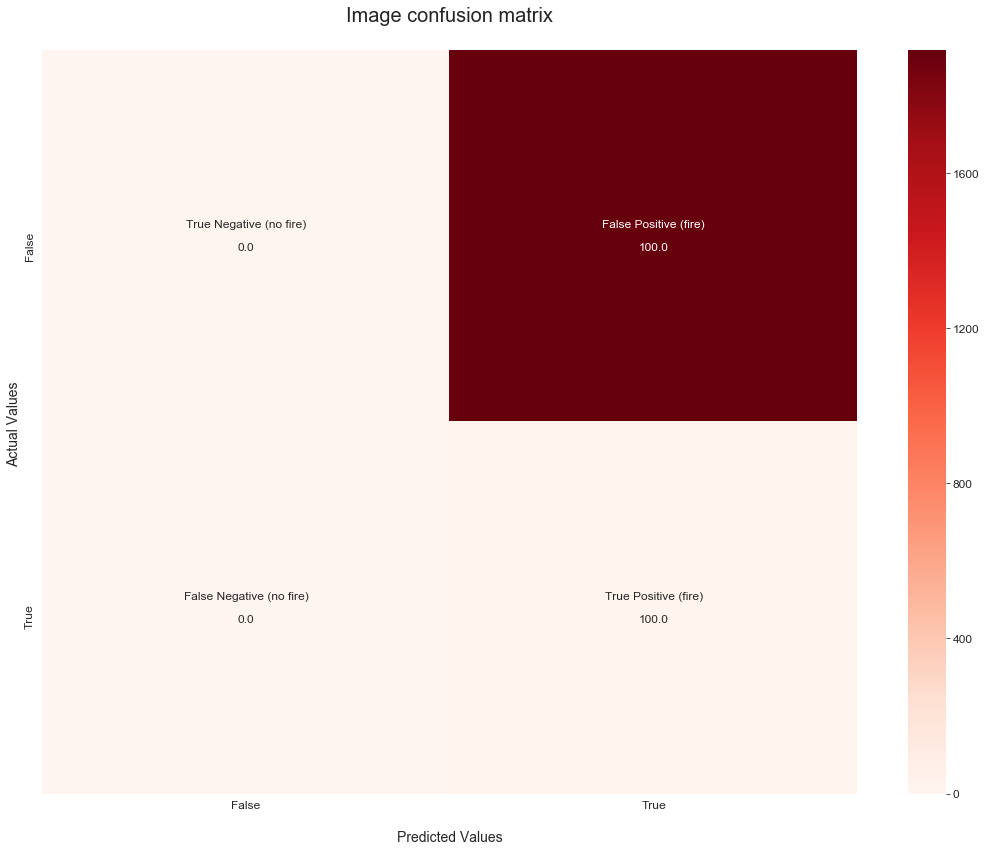

units dropouts optimizers    losses accuracies      aucs precisions  \
47    16      0.7       adam  0.694301   0.496124  0.621755   0.496124   

   recalls                                          histories epochs  \
47       1  <keras.callbacks.History object at 0x000002B0A...      5   

   best thresholds  
47        0.456203

61/61 [==============================] - 6s 94ms/step
0.3
[([1], 0.99912894), ([1], 0.9904882), ([1], 0.9833124), ([1], 0.9161403), ([1], 0.9803158), ([1], 0.99751985), ([1], 0.9965012), ([1], 0.64489114), ([1], 0.45557112), ([1], 0.971407)]
[([1], 0.9957257), ([1], 0.9084208), ([1], 0.98906386), ([1], 0.9750461), ([1], 0.95431423), ([1], 0.9973194), ([1], 0.99715686), ([1], 0.5923394), ([1], 0.46202743), ([1], 0.9679937)]


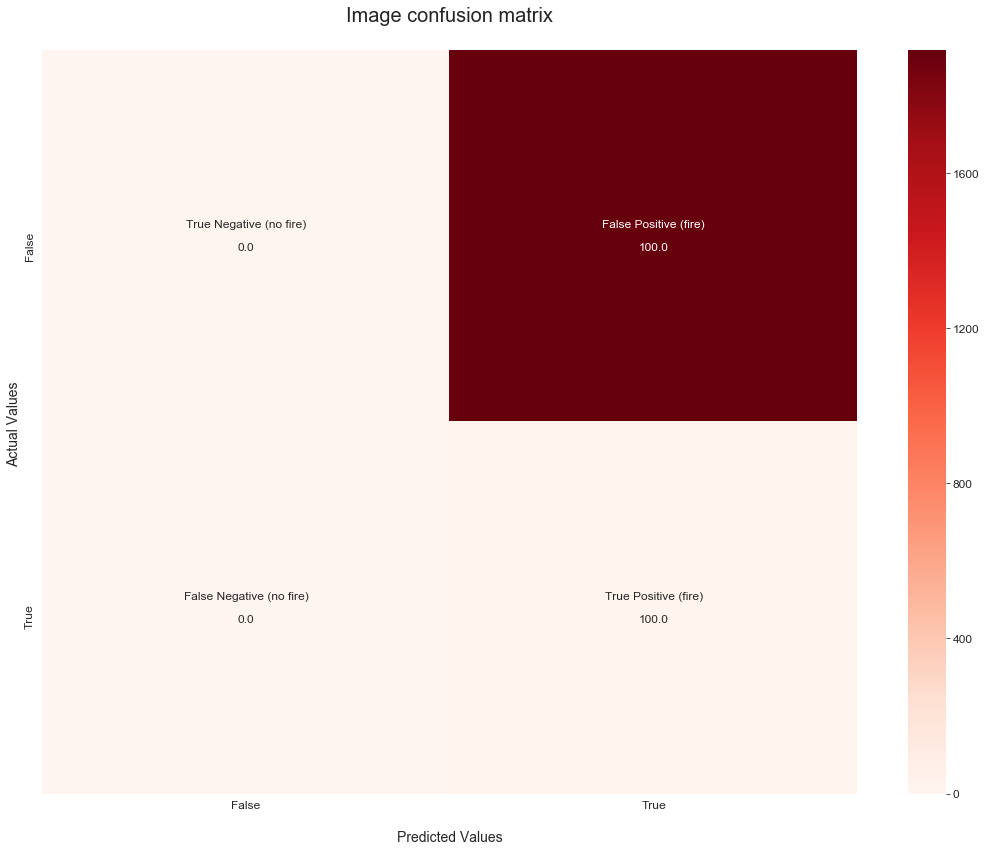

units dropouts optimizers    losses accuracies      aucs precisions  \
47    16      0.7       adam  0.694301   0.496124  0.621755   0.496124   

   recalls                                          histories epochs  \
47       1  <keras.callbacks.History object at 0x000002B0A...      5   

   best thresholds  
47        0.456203

61/61 [==============================] - 6s 93ms/step
0.5
[([1], 0.99912894), ([1], 0.9904882), ([1], 0.9833124), ([1], 0.9161403), ([1], 0.9803158), ([1], 0.99751985), ([1], 0.9965012), ([1], 0.64489114), ([1], 0.45557112), ([1], 0.971407)]
[([1], 0.9957257), ([1], 0.9084208), ([1], 0.98906386), ([1], 0.9750461), ([1], 0.95431423), ([1], 0.9973194), ([1], 0.99715686), ([1], 0.5923394), ([1], 0.46202743), ([1], 0.9679937)]


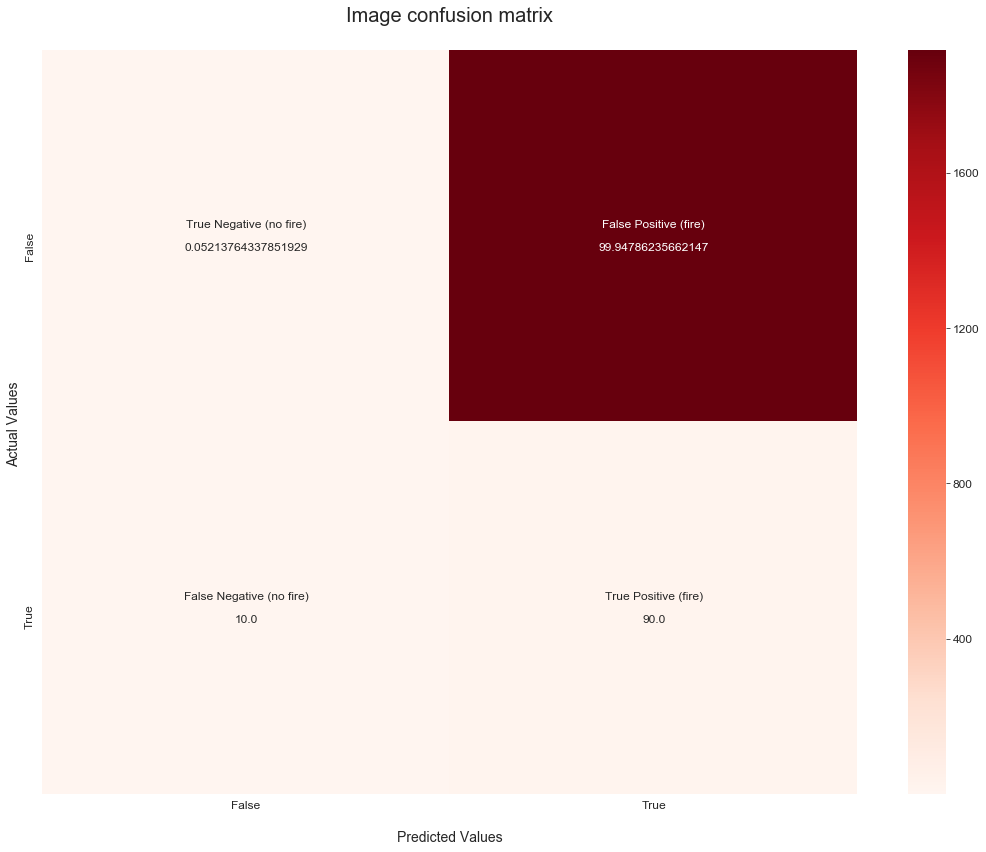

units dropouts optimizers    losses accuracies      aucs precisions  \
47    16      0.7       adam  0.694301   0.496124  0.621755   0.496124   

   recalls                                          histories epochs  \
47       1  <keras.callbacks.History object at 0x000002B0A...      5   

   best thresholds  
47        0.456203

61/61 [==============================] - 6s 93ms/step
0.65
[([1], 0.99912894), ([1], 0.9904882), ([1], 0.9833124), ([1], 0.9161403), ([1], 0.9803158), ([1], 0.99751985), ([1], 0.9965012), ([1], 0.64489114), ([1], 0.45557112), ([1], 0.971407)]
[([1], 0.9957257), ([1], 0.9084208), ([1], 0.98906386), ([1], 0.9750461), ([1], 0.95431423), ([1], 0.9973194), ([1], 0.99715686), ([1], 0.5923394), ([1], 0.46202743), ([1], 0.9679937)]


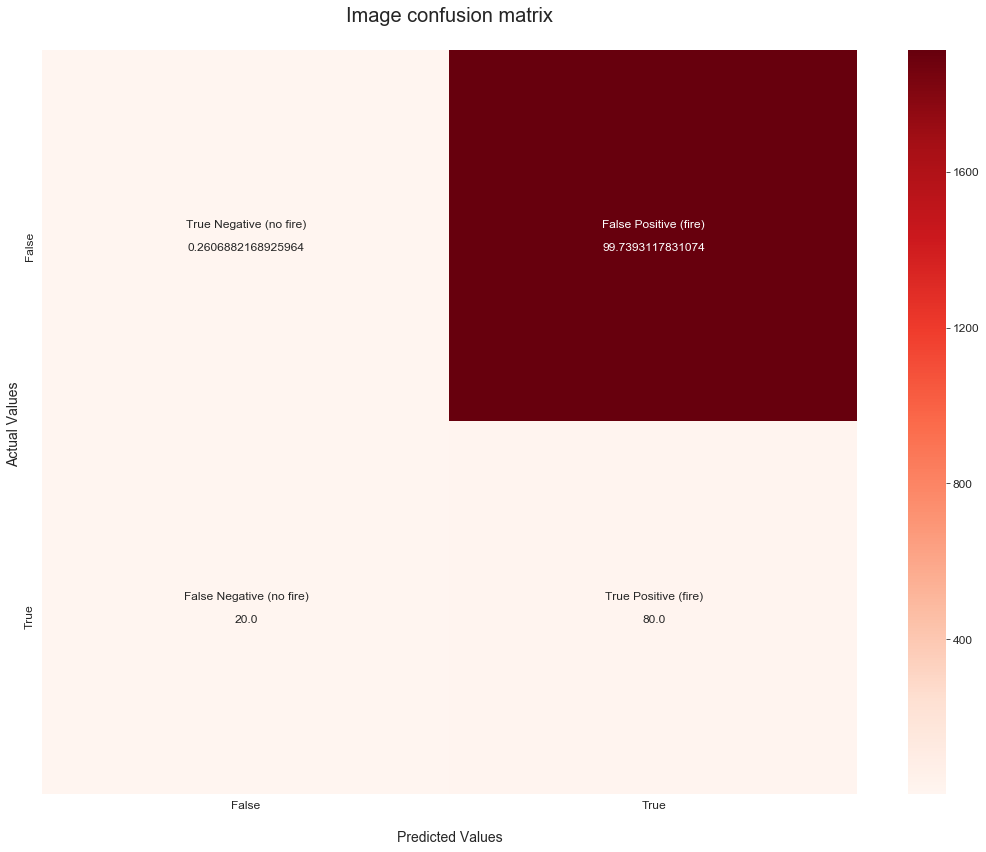

units dropouts optimizers    losses accuracies      aucs precisions  \
47    16      0.7       adam  0.694301   0.496124  0.621755   0.496124   

   recalls                                          histories epochs  \
47       1  <keras.callbacks.History object at 0x000002B0A...      5   

   best thresholds  
47        0.456203

61/61 [==============================] - 6s 93ms/step
0.725
[([1], 0.99912894), ([1], 0.9904882), ([1], 0.9833124), ([1], 0.9161403), ([1], 0.9803158), ([1], 0.99751985), ([1], 0.9965012), ([1], 0.64489114), ([1], 0.45557112), ([1], 0.971407)]
[([1], 0.9957257), ([1], 0.9084208), ([1], 0.98906386), ([1], 0.9750461), ([1], 0.95431423), ([1], 0.9973194), ([1], 0.99715686), ([1], 0.5923394), ([1], 0.46202743), ([1], 0.9679937)]


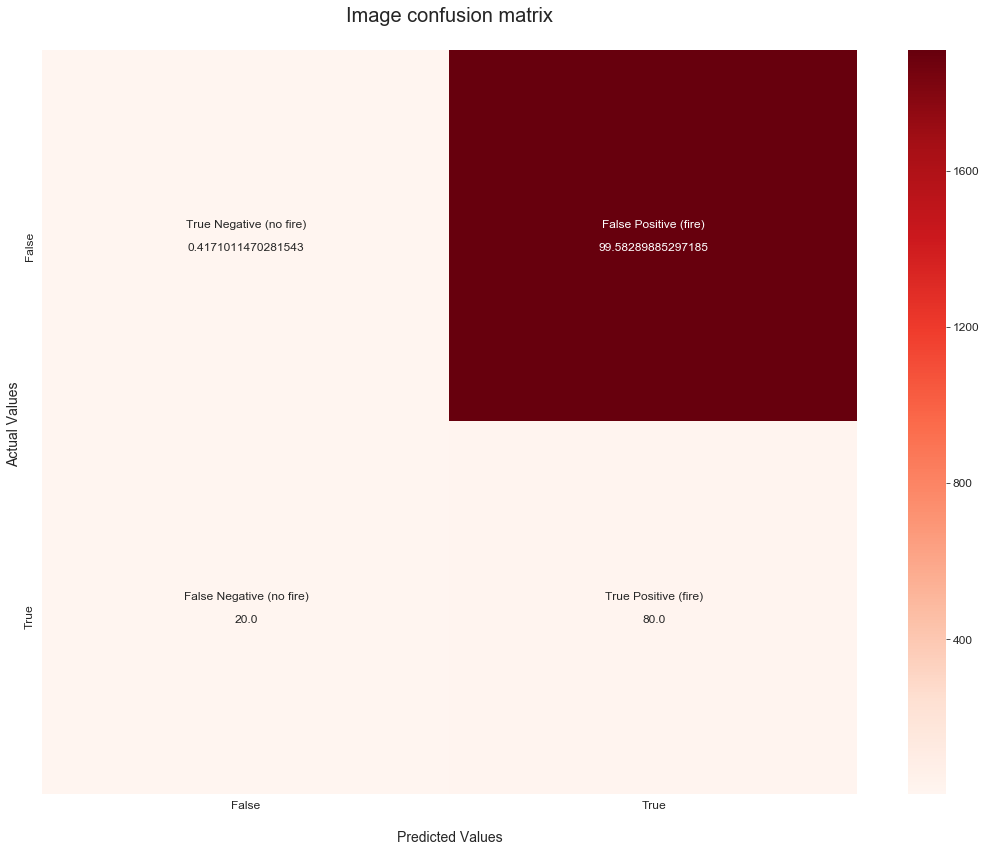

units dropouts optimizers    losses accuracies      aucs precisions  \
47    16      0.7       adam  0.694301   0.496124  0.621755   0.496124   

   recalls                                          histories epochs  \
47       1  <keras.callbacks.History object at 0x000002B0A...      5   

   best thresholds  
47        0.456203

61/61 [==============================] - 6s 94ms/step
0.8
[([1], 0.99912894), ([1], 0.9904882), ([1], 0.9833124), ([1], 0.9161403), ([1], 0.9803158), ([1], 0.99751985), ([1], 0.9965012), ([1], 0.64489114), ([1], 0.45557112), ([1], 0.971407)]
[([1], 0.9957257), ([1], 0.9084208), ([1], 0.98906386), ([1], 0.9750461), ([1], 0.95431423), ([1], 0.9973194), ([1], 0.99715686), ([1], 0.5923394), ([1], 0.46202743), ([1], 0.9679937)]


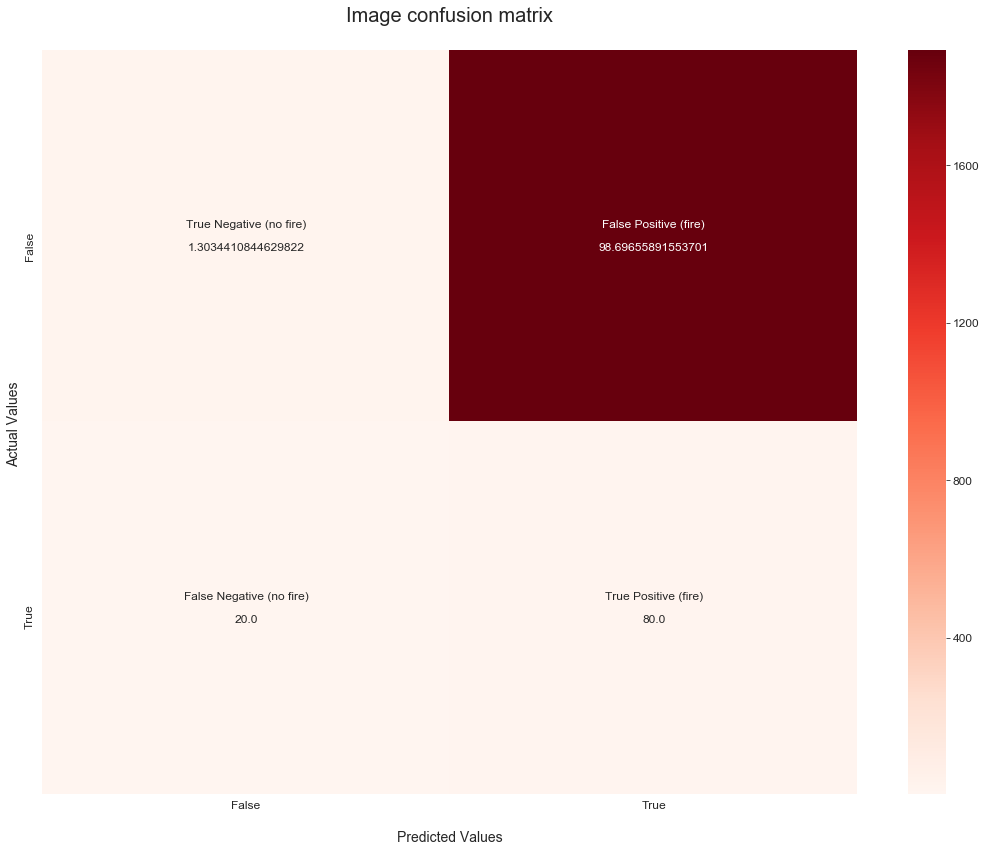

units dropouts optimizers    losses accuracies      aucs precisions  \
47    16      0.7       adam  0.694301   0.496124  0.621755   0.496124   

   recalls                                          histories epochs  \
47       1  <keras.callbacks.History object at 0x000002B0A...      5   

   best thresholds  
47        0.456203

61/61 [==============================] - 6s 93ms/step
0.85
[([1], 0.99912894), ([1], 0.9904882), ([1], 0.9833124), ([1], 0.9161403), ([1], 0.9803158), ([1], 0.99751985), ([1], 0.9965012), ([1], 0.64489114), ([1], 0.45557112), ([1], 0.971407)]
[([1], 0.9957257), ([1], 0.9084208), ([1], 0.98906386), ([1], 0.9750461), ([1], 0.95431423), ([1], 0.9973194), ([1], 0.99715686), ([1], 0.5923394), ([1], 0.46202743), ([1], 0.9679937)]


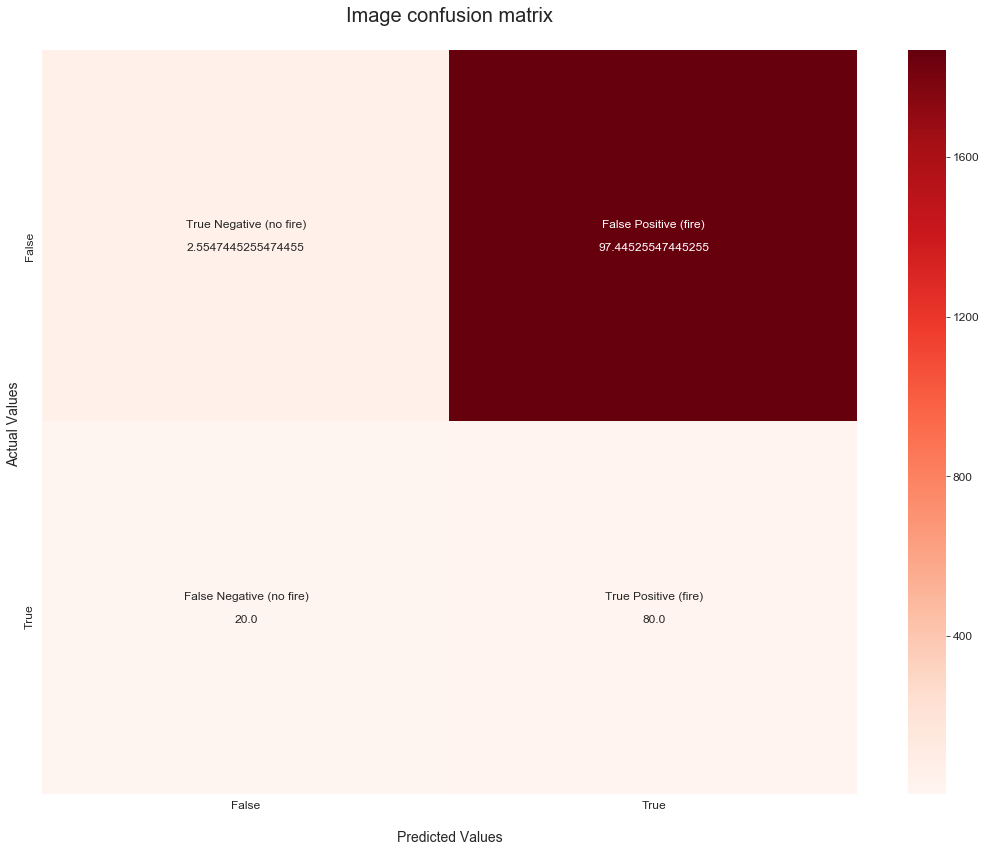

units dropouts optimizers    losses accuracies      aucs precisions  \
47    16      0.7       adam  0.694301   0.496124  0.621755   0.496124   

   recalls                                          histories epochs  \
47       1  <keras.callbacks.History object at 0x000002B0A...      5   

   best thresholds  
47        0.456203

61/61 [==============================] - 6s 93ms/step
0.9
[([1], 0.99912894), ([1], 0.9904882), ([1], 0.9833124), ([1], 0.9161403), ([1], 0.9803158), ([1], 0.99751985), ([1], 0.9965012), ([1], 0.64489114), ([1], 0.45557112), ([1], 0.971407)]
[([1], 0.9957257), ([1], 0.9084208), ([1], 0.98906386), ([1], 0.9750461), ([1], 0.95431423), ([1], 0.9973194), ([1], 0.99715686), ([1], 0.5923394), ([1], 0.46202743), ([1], 0.9679937)]


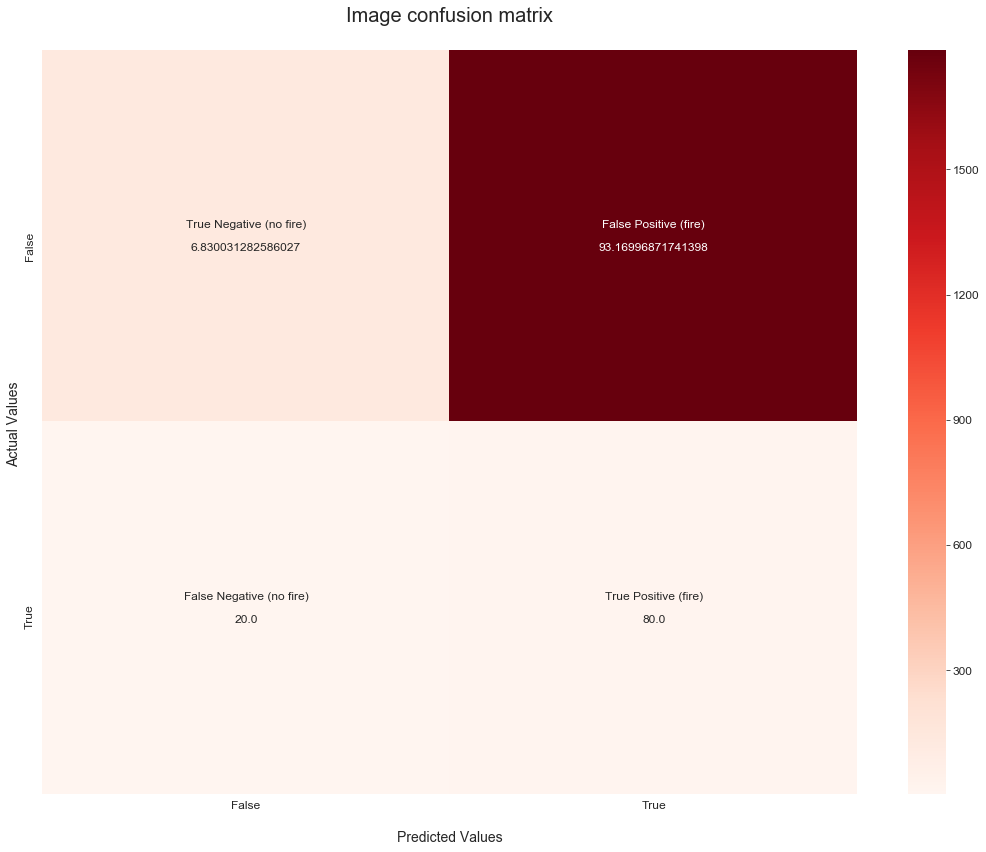

units dropouts optimizers    losses accuracies      aucs precisions  \
47    16      0.7       adam  0.694301   0.496124  0.621755   0.496124   

   recalls                                          histories epochs  \
47       1  <keras.callbacks.History object at 0x000002B0A...      5   

   best thresholds  
47        0.456203

61/61 [==============================] - 6s 93ms/step
0.95
[([1], 0.99912894), ([1], 0.9904882), ([1], 0.9833124), ([1], 0.9161403), ([1], 0.9803158), ([1], 0.99751985), ([1], 0.9965012), ([1], 0.64489114), ([1], 0.45557112), ([1], 0.971407)]
[([1], 0.9957257), ([1], 0.9084208), ([1], 0.98906386), ([1], 0.9750461), ([1], 0.95431423), ([1], 0.9973194), ([1], 0.99715686), ([1], 0.5923394), ([1], 0.46202743), ([1], 0.9679937)]


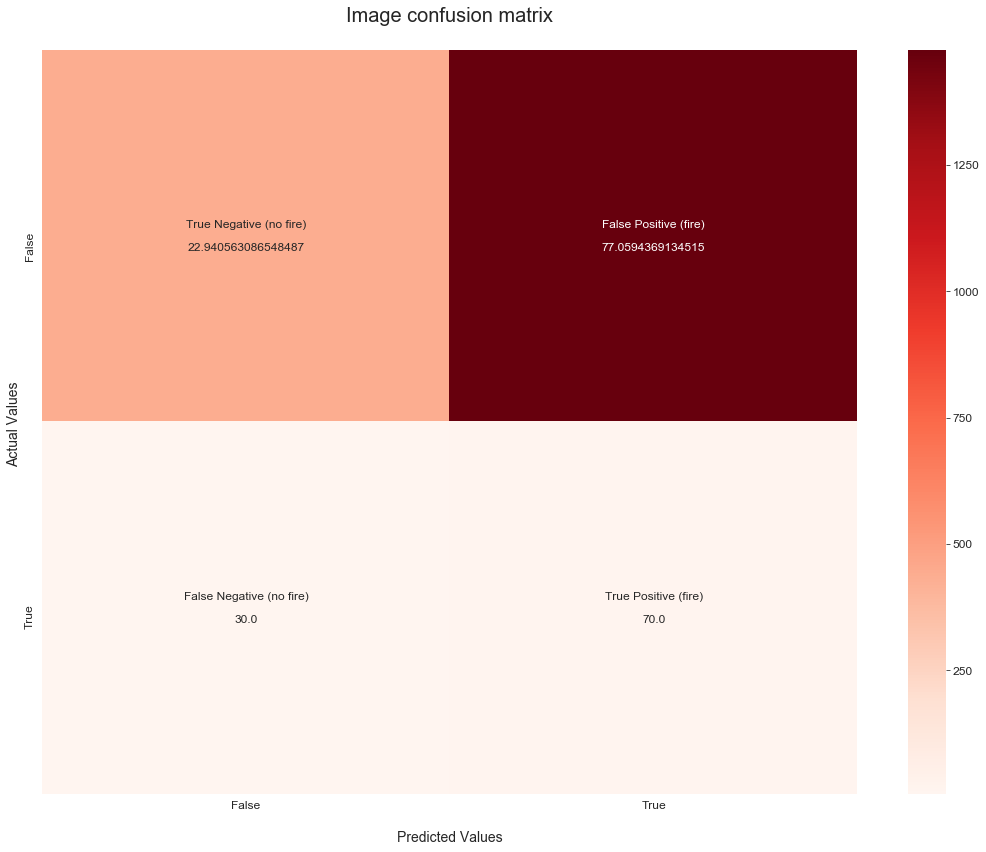

units dropouts optimizers    losses accuracies      aucs precisions  \
48    16      0.7      Nadam  0.728197   0.503876  0.783053          0   

   recalls                                          histories epochs  \
48       0  <keras.callbacks.History object at 0x000002B03...      5   

   best thresholds  
48        0.638644

61/61 [==============================] - 6s 93ms/step
0.1
[([1], 0.9817544), ([1], 0.9392239), ([1], 0.13716319), ([1], 0.082235515), ([1], 0.51303244), ([1], 0.17035887), ([1], 0.6362432), ([1], 0.12364462), ([1], 0.21890882), ([1], 0.47727427)]
[([1], 0.8914267), ([1], 0.49875078), ([1], 0.27973515), ([1], 0.4656241), ([1], 0.29186893), ([1], 0.2575276), ([1], 0.7211175), ([1], 0.10742241), ([1], 0.2889444), ([1], 0.4999101)]


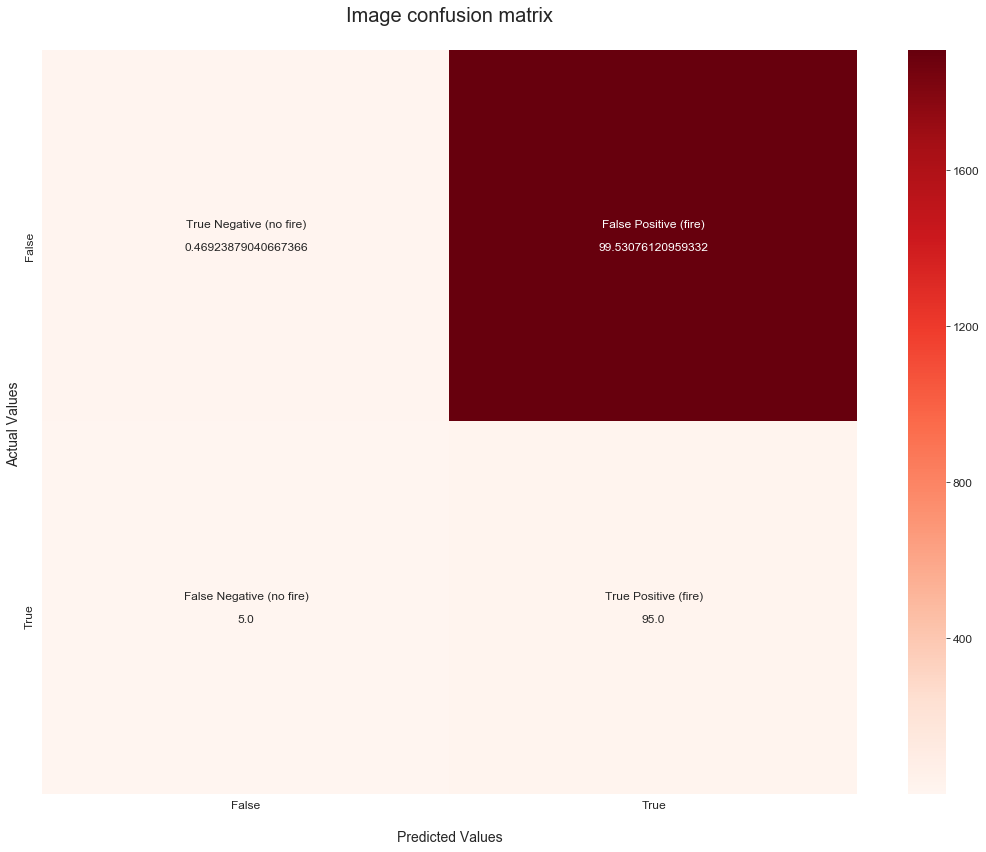

units dropouts optimizers    losses accuracies      aucs precisions  \
48    16      0.7      Nadam  0.728197   0.503876  0.783053          0   

   recalls                                          histories epochs  \
48       0  <keras.callbacks.History object at 0x000002B03...      5   

   best thresholds  
48        0.638644

61/61 [==============================] - 6s 93ms/step
0.3
[([1], 0.9817544), ([1], 0.9392239), ([1], 0.13716319), ([1], 0.082235515), ([1], 0.51303244), ([1], 0.17035887), ([1], 0.6362432), ([1], 0.12364462), ([1], 0.21890882), ([1], 0.47727427)]
[([1], 0.8914267), ([1], 0.49875078), ([1], 0.27973515), ([1], 0.4656241), ([1], 0.29186893), ([1], 0.2575276), ([1], 0.7211175), ([1], 0.10742241), ([1], 0.2889444), ([1], 0.4999101)]


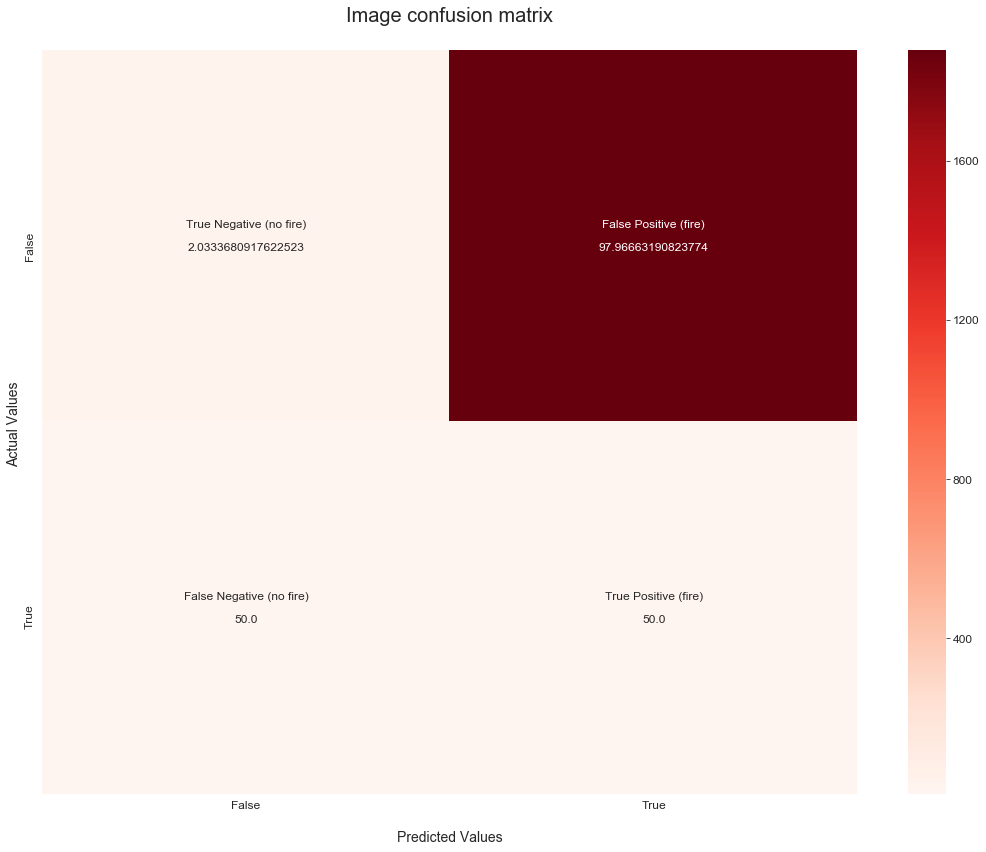

units dropouts optimizers    losses accuracies      aucs precisions  \
48    16      0.7      Nadam  0.728197   0.503876  0.783053          0   

   recalls                                          histories epochs  \
48       0  <keras.callbacks.History object at 0x000002B03...      5   

   best thresholds  
48        0.638644

61/61 [==============================] - 6s 95ms/step
0.5
[([1], 0.9817544), ([1], 0.9392239), ([1], 0.13716319), ([1], 0.082235515), ([1], 0.51303244), ([1], 0.17035887), ([1], 0.6362432), ([1], 0.12364462), ([1], 0.21890882), ([1], 0.47727427)]
[([1], 0.8914267), ([1], 0.49875078), ([1], 0.27973515), ([1], 0.4656241), ([1], 0.29186893), ([1], 0.2575276), ([1], 0.7211175), ([1], 0.10742241), ([1], 0.2889444), ([1], 0.4999101)]


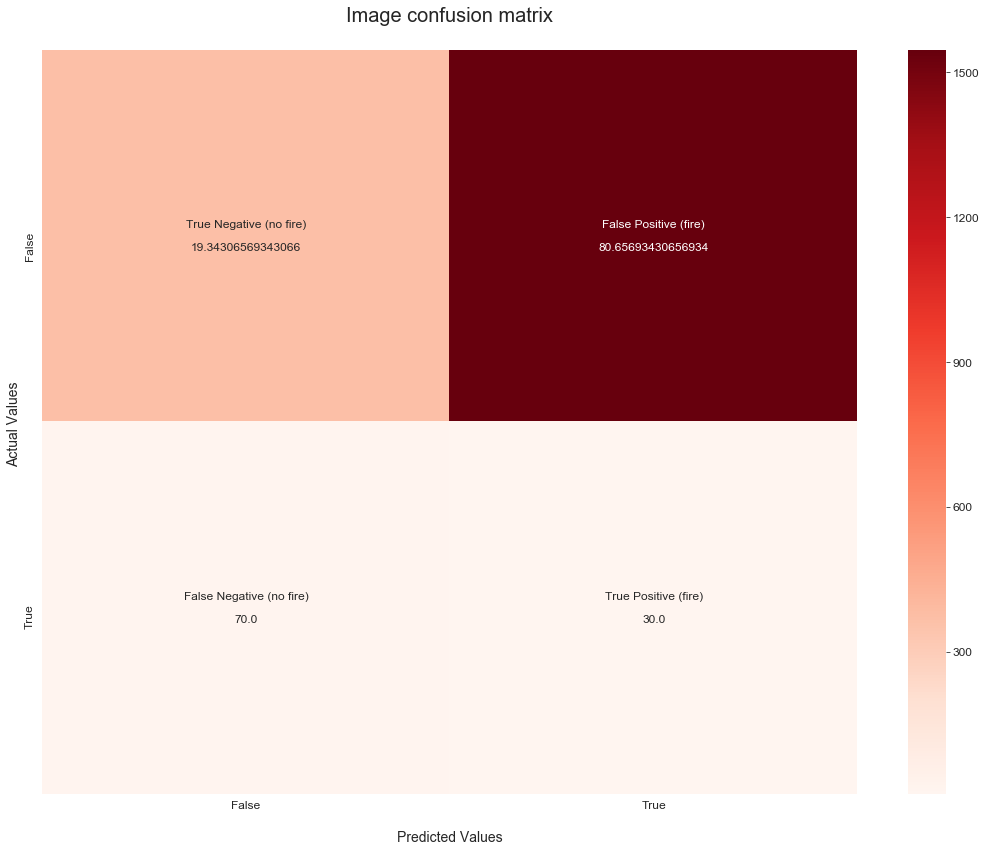

units dropouts optimizers    losses accuracies      aucs precisions  \
48    16      0.7      Nadam  0.728197   0.503876  0.783053          0   

   recalls                                          histories epochs  \
48       0  <keras.callbacks.History object at 0x000002B03...      5   

   best thresholds  
48        0.638644

61/61 [==============================] - 6s 93ms/step
0.65
[([1], 0.9817544), ([1], 0.9392239), ([1], 0.13716319), ([1], 0.082235515), ([1], 0.51303244), ([1], 0.17035887), ([1], 0.6362432), ([1], 0.12364462), ([1], 0.21890882), ([1], 0.47727427)]
[([1], 0.8914267), ([1], 0.49875078), ([1], 0.27973515), ([1], 0.4656241), ([1], 0.29186893), ([1], 0.2575276), ([1], 0.7211175), ([1], 0.10742241), ([1], 0.2889444), ([1], 0.4999101)]


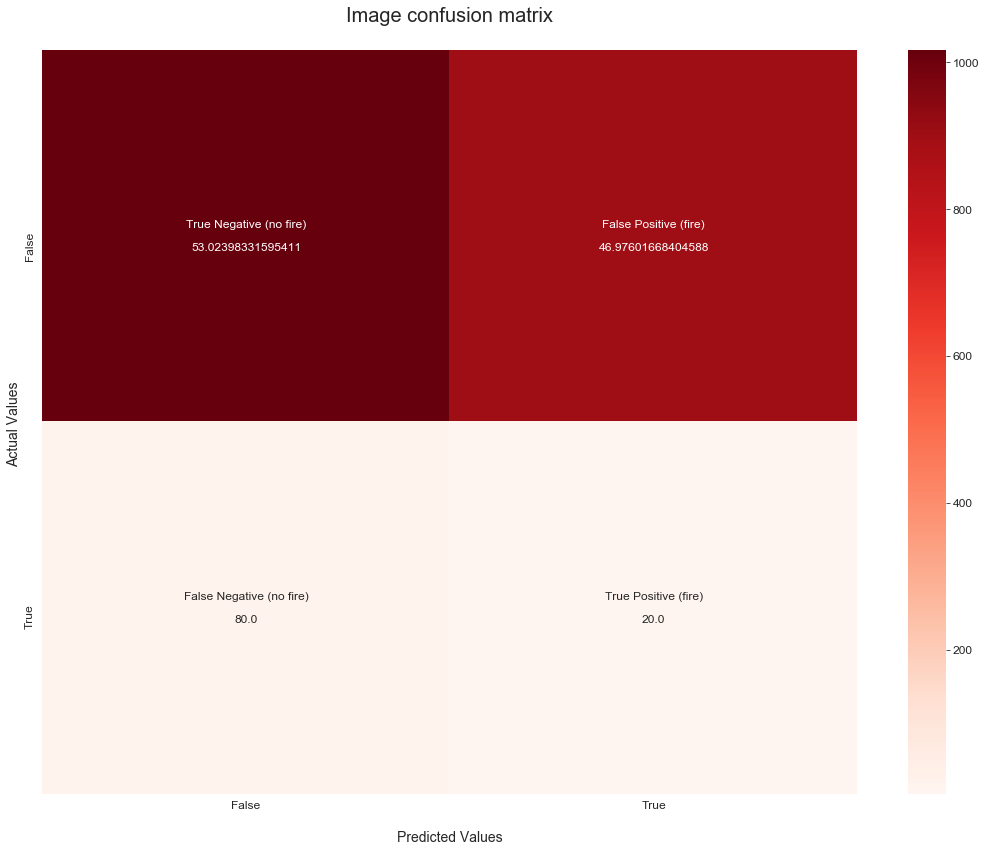

units dropouts optimizers    losses accuracies      aucs precisions  \
48    16      0.7      Nadam  0.728197   0.503876  0.783053          0   

   recalls                                          histories epochs  \
48       0  <keras.callbacks.History object at 0x000002B03...      5   

   best thresholds  
48        0.638644

61/61 [==============================] - 6s 93ms/step
0.725
[([1], 0.9817544), ([1], 0.9392239), ([1], 0.13716319), ([1], 0.082235515), ([1], 0.51303244), ([1], 0.17035887), ([1], 0.6362432), ([1], 0.12364462), ([1], 0.21890882), ([1], 0.47727427)]
[([1], 0.8914267), ([1], 0.49875078), ([1], 0.27973515), ([1], 0.4656241), ([1], 0.29186893), ([1], 0.2575276), ([1], 0.7211175), ([1], 0.10742241), ([1], 0.2889444), ([1], 0.4999101)]


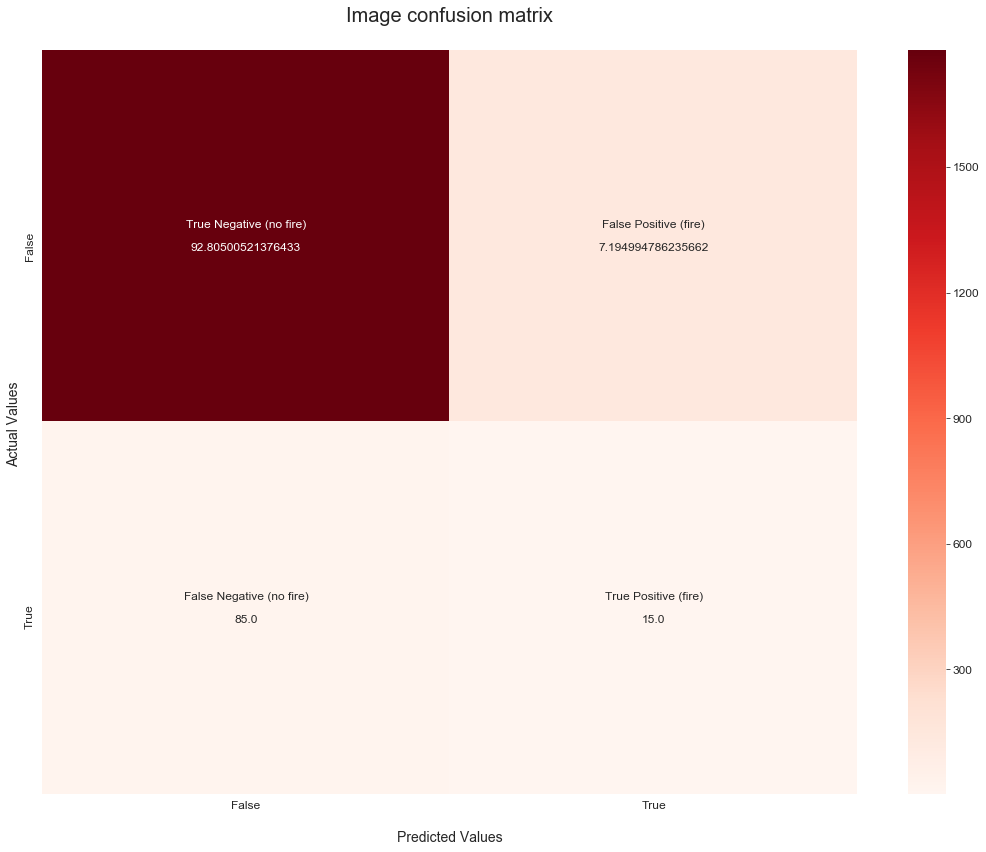

units dropouts optimizers    losses accuracies      aucs precisions  \
48    16      0.7      Nadam  0.728197   0.503876  0.783053          0   

   recalls                                          histories epochs  \
48       0  <keras.callbacks.History object at 0x000002B03...      5   

   best thresholds  
48        0.638644

61/61 [==============================] - 6s 93ms/step
0.8
[([1], 0.9817544), ([1], 0.9392239), ([1], 0.13716319), ([1], 0.082235515), ([1], 0.51303244), ([1], 0.17035887), ([1], 0.6362432), ([1], 0.12364462), ([1], 0.21890882), ([1], 0.47727427)]
[([1], 0.8914267), ([1], 0.49875078), ([1], 0.27973515), ([1], 0.4656241), ([1], 0.29186893), ([1], 0.2575276), ([1], 0.7211175), ([1], 0.10742241), ([1], 0.2889444), ([1], 0.4999101)]


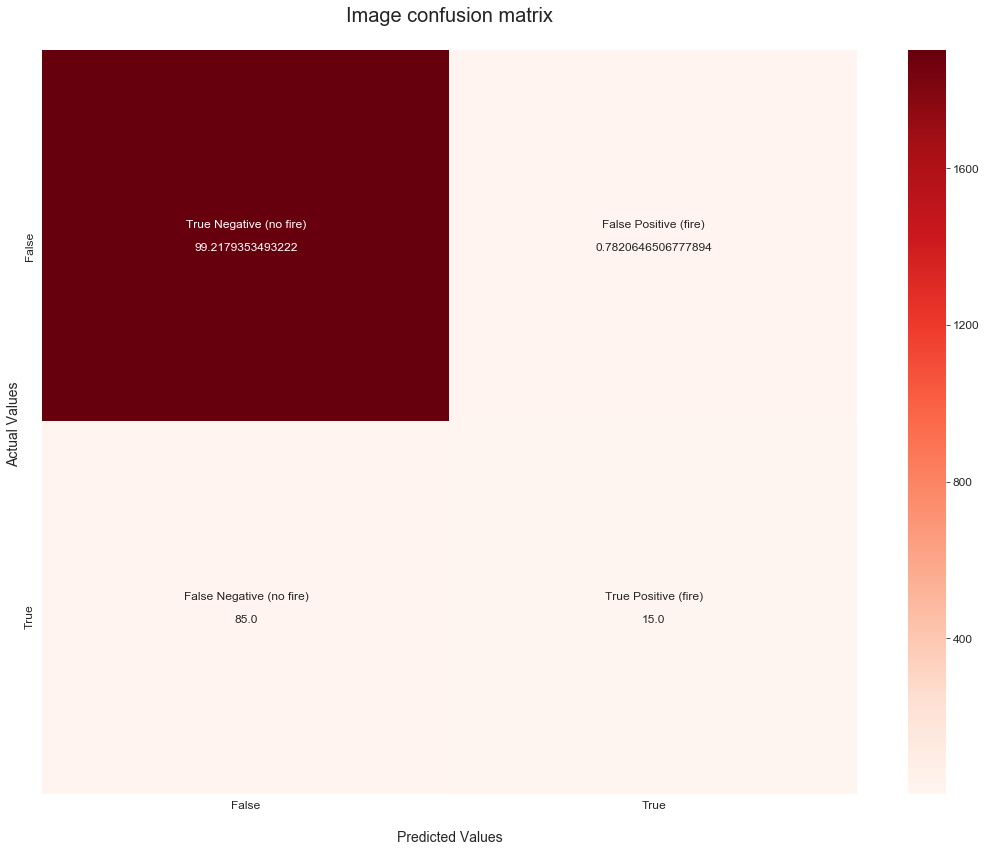

units dropouts optimizers    losses accuracies      aucs precisions  \
48    16      0.7      Nadam  0.728197   0.503876  0.783053          0   

   recalls                                          histories epochs  \
48       0  <keras.callbacks.History object at 0x000002B03...      5   

   best thresholds  
48        0.638644

61/61 [==============================] - 6s 93ms/step
0.85
[([1], 0.9817544), ([1], 0.9392239), ([1], 0.13716319), ([1], 0.082235515), ([1], 0.51303244), ([1], 0.17035887), ([1], 0.6362432), ([1], 0.12364462), ([1], 0.21890882), ([1], 0.47727427)]
[([1], 0.8914267), ([1], 0.49875078), ([1], 0.27973515), ([1], 0.4656241), ([1], 0.29186893), ([1], 0.2575276), ([1], 0.7211175), ([1], 0.10742241), ([1], 0.2889444), ([1], 0.4999101)]


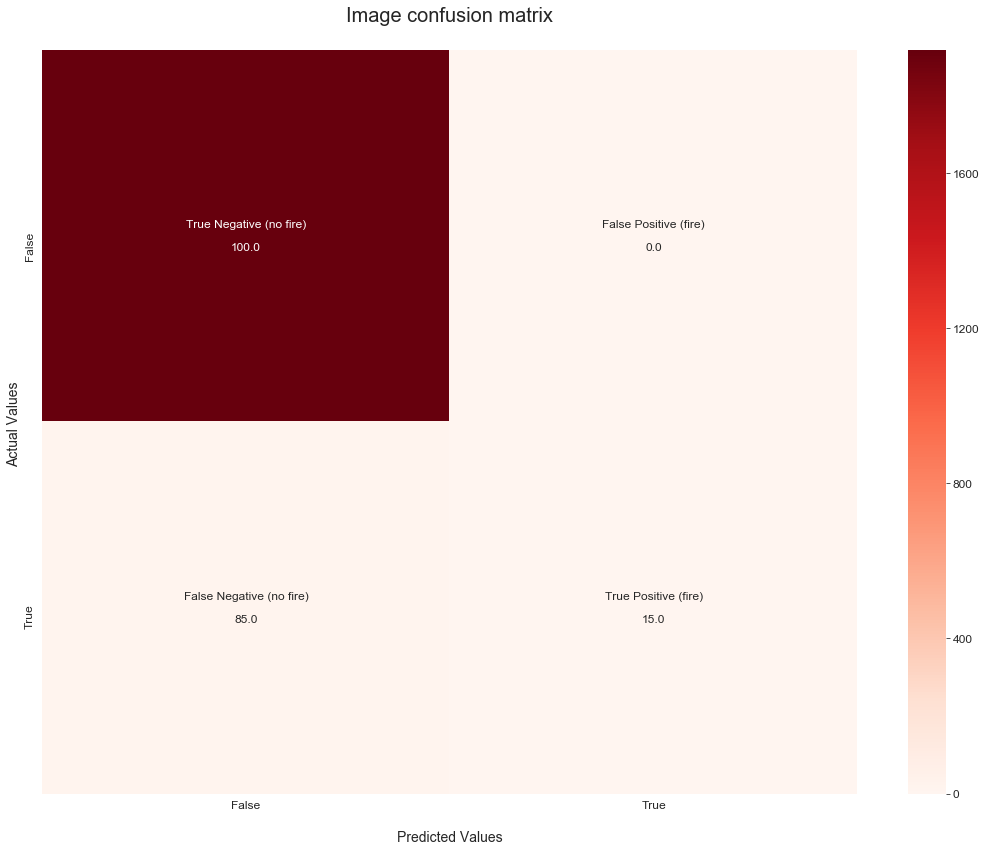

units dropouts optimizers    losses accuracies      aucs precisions  \
48    16      0.7      Nadam  0.728197   0.503876  0.783053          0   

   recalls                                          histories epochs  \
48       0  <keras.callbacks.History object at 0x000002B03...      5   

   best thresholds  
48        0.638644

61/61 [==============================] - 6s 93ms/step
0.9
[([1], 0.9817544), ([1], 0.9392239), ([1], 0.13716319), ([1], 0.082235515), ([1], 0.51303244), ([1], 0.17035887), ([1], 0.6362432), ([1], 0.12364462), ([1], 0.21890882), ([1], 0.47727427)]
[([1], 0.8914267), ([1], 0.49875078), ([1], 0.27973515), ([1], 0.4656241), ([1], 0.29186893), ([1], 0.2575276), ([1], 0.7211175), ([1], 0.10742241), ([1], 0.2889444), ([1], 0.4999101)]


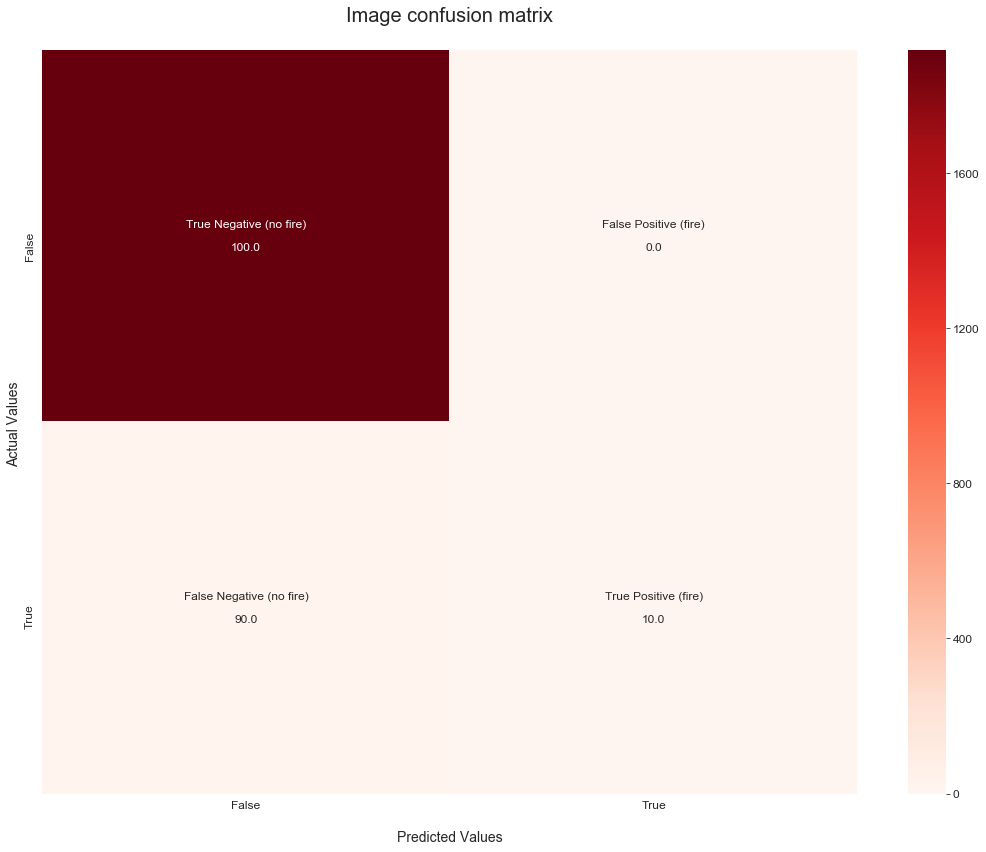

units dropouts optimizers    losses accuracies      aucs precisions  \
48    16      0.7      Nadam  0.728197   0.503876  0.783053          0   

   recalls                                          histories epochs  \
48       0  <keras.callbacks.History object at 0x000002B03...      5   

   best thresholds  
48        0.638644

61/61 [==============================] - 6s 94ms/step
0.95
[([1], 0.9817544), ([1], 0.9392239), ([1], 0.13716319), ([1], 0.082235515), ([1], 0.51303244), ([1], 0.17035887), ([1], 0.6362432), ([1], 0.12364462), ([1], 0.21890882), ([1], 0.47727427)]
[([1], 0.8914267), ([1], 0.49875078), ([1], 0.27973515), ([1], 0.4656241), ([1], 0.29186893), ([1], 0.2575276), ([1], 0.7211175), ([1], 0.10742241), ([1], 0.2889444), ([1], 0.4999101)]


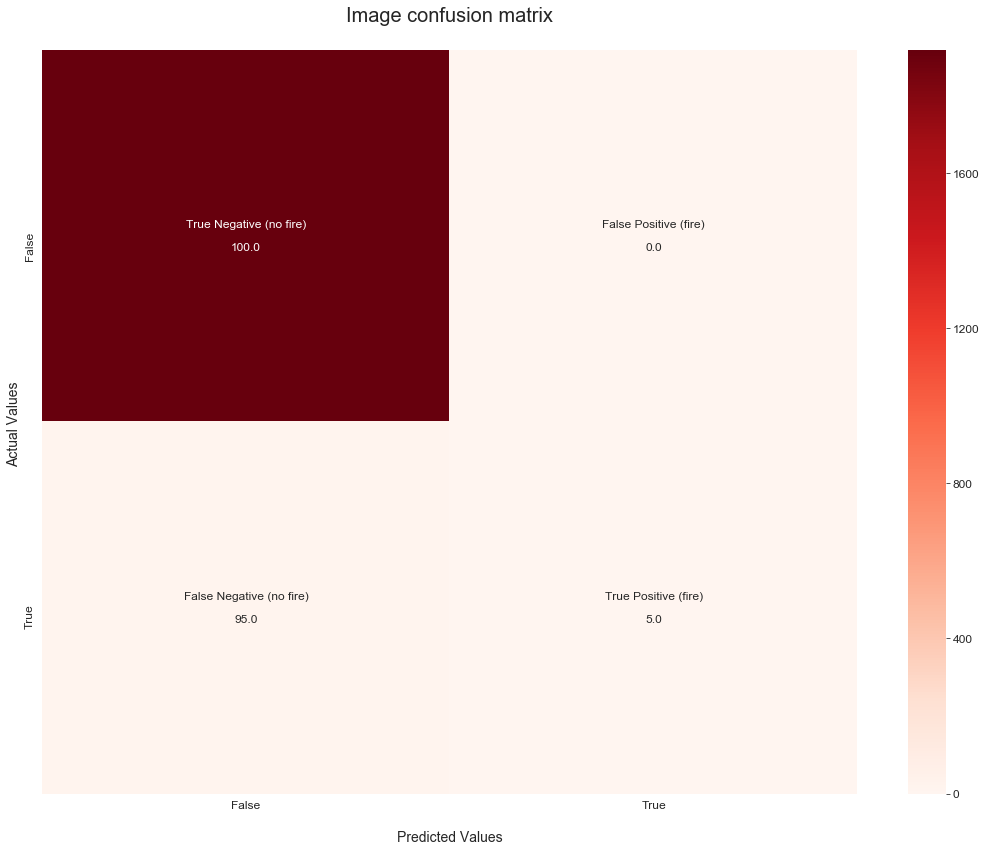

units dropouts optimizers    losses accuracies      aucs precisions  \
49    16      0.7    RMSprop  0.692484   0.496124  0.747236   0.496124   

   recalls                                          histories epochs  \
49       1  <keras.callbacks.History object at 0x000002B0B...      5   

   best thresholds  
49        0.468021

61/61 [==============================] - 6s 92ms/step
0.1
[([1], 0.9119046), ([1], 0.99204385), ([1], 0.9960965), ([1], 0.97368723), ([1], 0.99874556), ([1], 0.3729763), ([1], 0.99957246), ([1], 0.26536858), ([1], 0.4961399), ([1], 0.9996294)]
[([1], 0.85182756), ([1], 0.97000694), ([1], 0.995828), ([1], 0.9659116), ([1], 0.9992341), ([1], 0.6556703), ([1], 0.9993867), ([1], 0.49615926), ([1], 0.44154114), ([1], 0.9996749)]


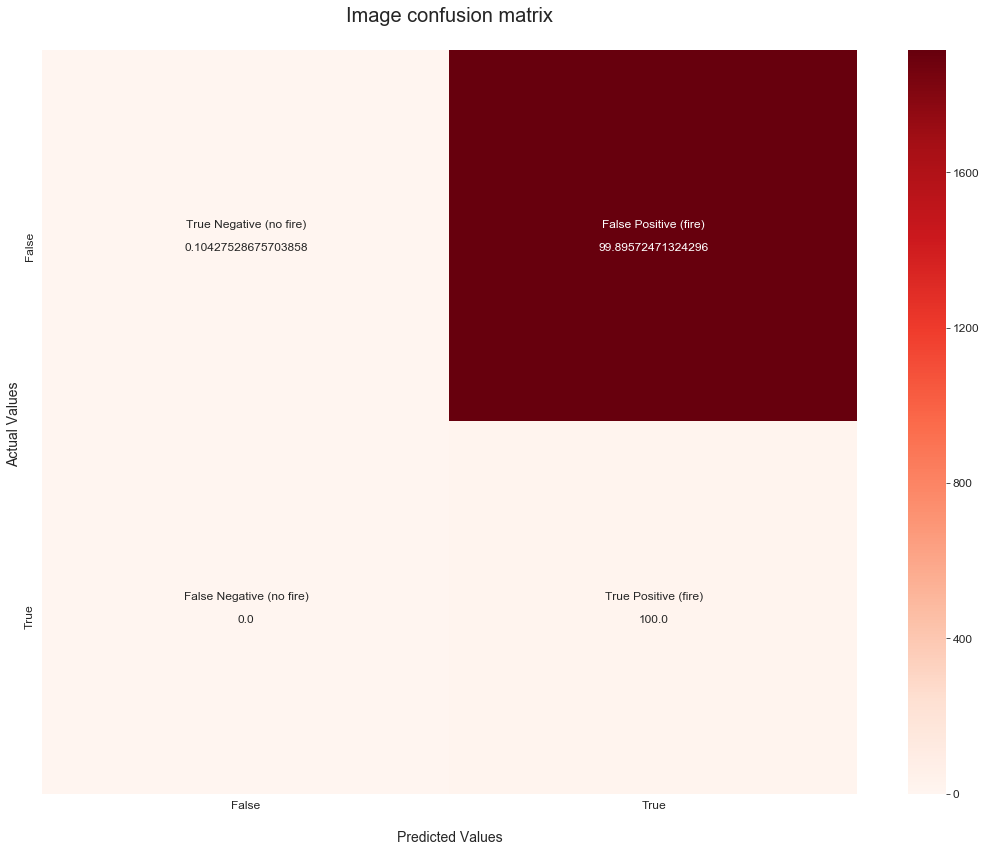

units dropouts optimizers    losses accuracies      aucs precisions  \
49    16      0.7    RMSprop  0.692484   0.496124  0.747236   0.496124   

   recalls                                          histories epochs  \
49       1  <keras.callbacks.History object at 0x000002B0B...      5   

   best thresholds  
49        0.468021

61/61 [==============================] - 6s 93ms/step
0.3
[([1], 0.9119046), ([1], 0.99204385), ([1], 0.9960965), ([1], 0.97368723), ([1], 0.99874556), ([1], 0.3729763), ([1], 0.99957246), ([1], 0.26536858), ([1], 0.4961399), ([1], 0.9996294)]
[([1], 0.85182756), ([1], 0.97000694), ([1], 0.995828), ([1], 0.9659116), ([1], 0.9992341), ([1], 0.6556703), ([1], 0.9993867), ([1], 0.49615926), ([1], 0.44154114), ([1], 0.9996749)]


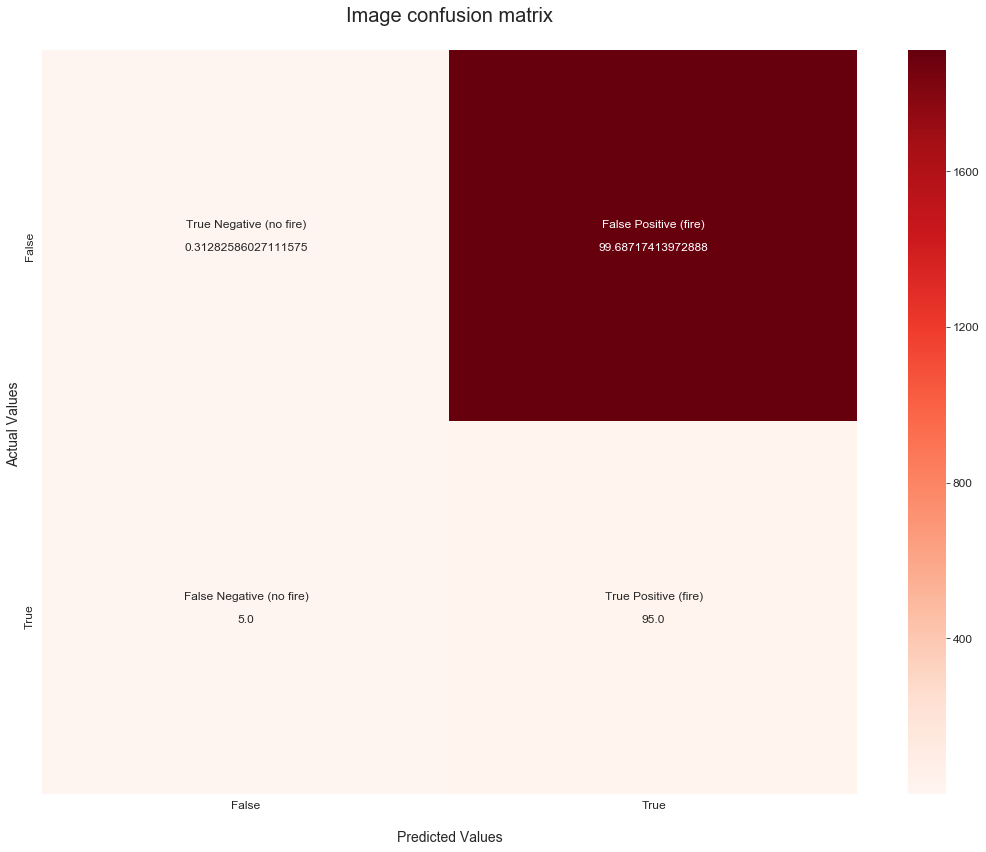

units dropouts optimizers    losses accuracies      aucs precisions  \
49    16      0.7    RMSprop  0.692484   0.496124  0.747236   0.496124   

   recalls                                          histories epochs  \
49       1  <keras.callbacks.History object at 0x000002B0B...      5   

   best thresholds  
49        0.468021

61/61 [==============================] - 6s 92ms/step
0.5
[([1], 0.9119046), ([1], 0.99204385), ([1], 0.9960965), ([1], 0.97368723), ([1], 0.99874556), ([1], 0.3729763), ([1], 0.99957246), ([1], 0.26536858), ([1], 0.4961399), ([1], 0.9996294)]
[([1], 0.85182756), ([1], 0.97000694), ([1], 0.995828), ([1], 0.9659116), ([1], 0.9992341), ([1], 0.6556703), ([1], 0.9993867), ([1], 0.49615926), ([1], 0.44154114), ([1], 0.9996749)]


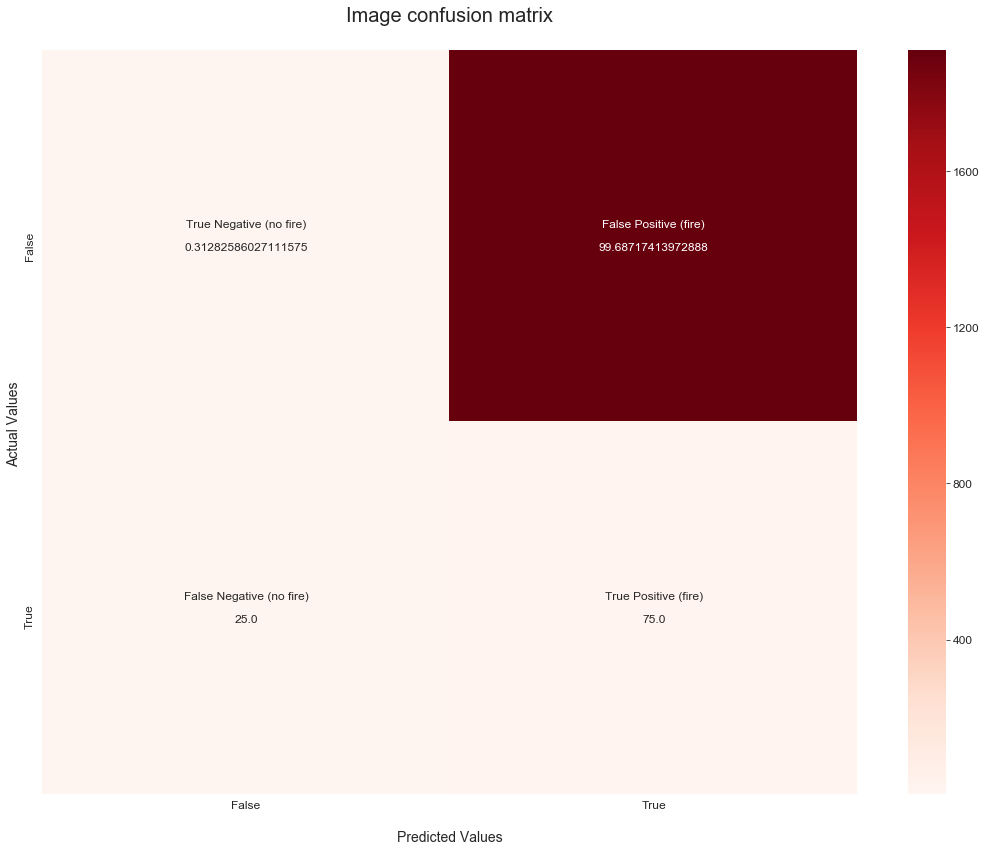

units dropouts optimizers    losses accuracies      aucs precisions  \
49    16      0.7    RMSprop  0.692484   0.496124  0.747236   0.496124   

   recalls                                          histories epochs  \
49       1  <keras.callbacks.History object at 0x000002B0B...      5   

   best thresholds  
49        0.468021

61/61 [==============================] - 6s 95ms/step
0.65
[([1], 0.9119046), ([1], 0.99204385), ([1], 0.9960965), ([1], 0.97368723), ([1], 0.99874556), ([1], 0.3729763), ([1], 0.99957246), ([1], 0.26536858), ([1], 0.4961399), ([1], 0.9996294)]
[([1], 0.85182756), ([1], 0.97000694), ([1], 0.995828), ([1], 0.9659116), ([1], 0.9992341), ([1], 0.6556703), ([1], 0.9993867), ([1], 0.49615926), ([1], 0.44154114), ([1], 0.9996749)]


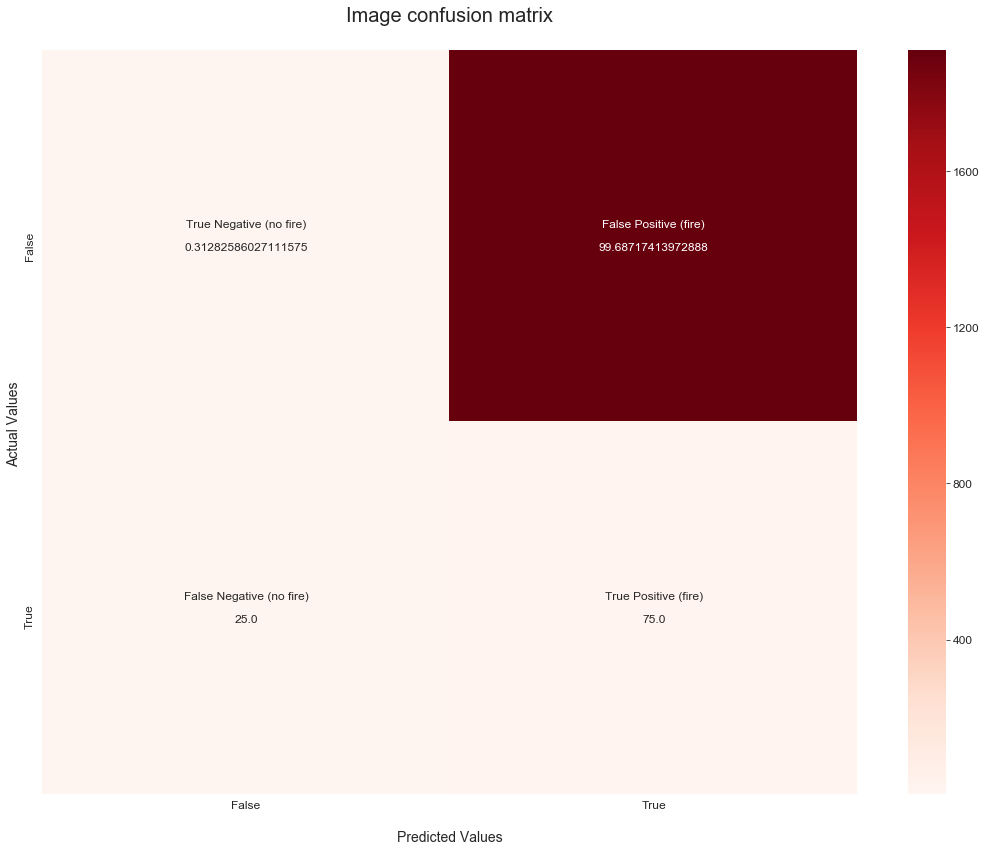

units dropouts optimizers    losses accuracies      aucs precisions  \
49    16      0.7    RMSprop  0.692484   0.496124  0.747236   0.496124   

   recalls                                          histories epochs  \
49       1  <keras.callbacks.History object at 0x000002B0B...      5   

   best thresholds  
49        0.468021

61/61 [==============================] - 6s 93ms/step
0.725
[([1], 0.9119046), ([1], 0.99204385), ([1], 0.9960965), ([1], 0.97368723), ([1], 0.99874556), ([1], 0.3729763), ([1], 0.99957246), ([1], 0.26536858), ([1], 0.4961399), ([1], 0.9996294)]
[([1], 0.85182756), ([1], 0.97000694), ([1], 0.995828), ([1], 0.9659116), ([1], 0.9992341), ([1], 0.6556703), ([1], 0.9993867), ([1], 0.49615926), ([1], 0.44154114), ([1], 0.9996749)]


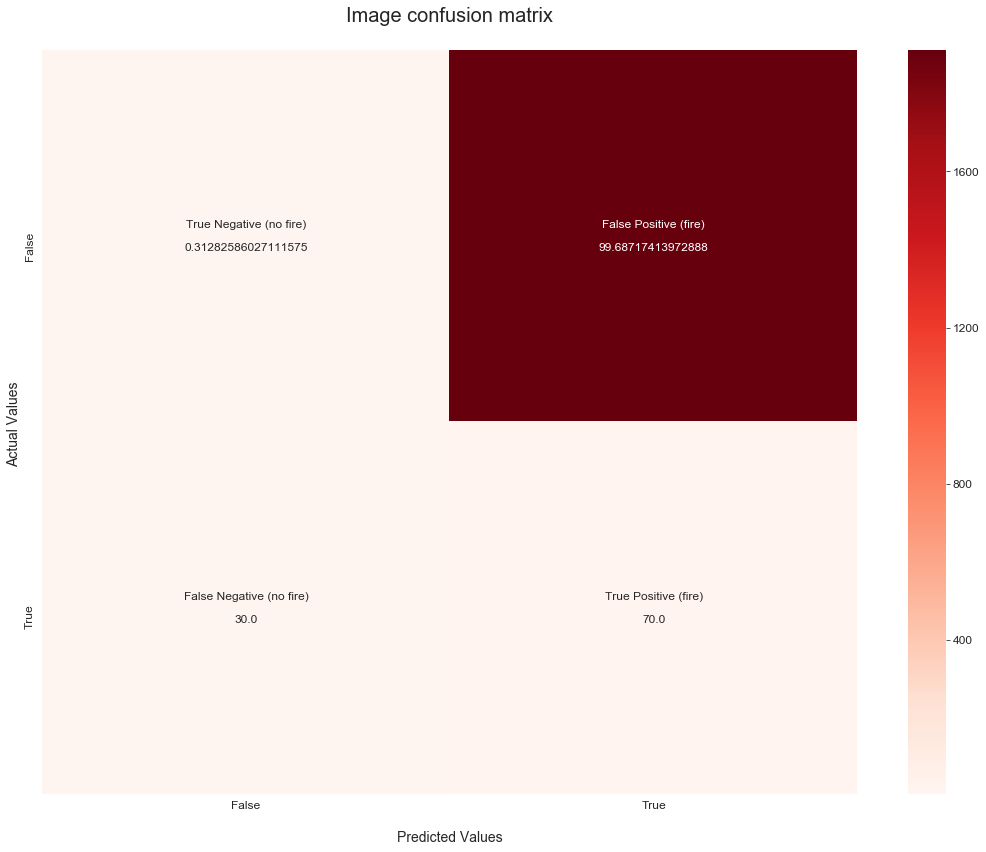

units dropouts optimizers    losses accuracies      aucs precisions  \
49    16      0.7    RMSprop  0.692484   0.496124  0.747236   0.496124   

   recalls                                          histories epochs  \
49       1  <keras.callbacks.History object at 0x000002B0B...      5   

   best thresholds  
49        0.468021

61/61 [==============================] - 6s 93ms/step
0.8
[([1], 0.9119046), ([1], 0.99204385), ([1], 0.9960965), ([1], 0.97368723), ([1], 0.99874556), ([1], 0.3729763), ([1], 0.99957246), ([1], 0.26536858), ([1], 0.4961399), ([1], 0.9996294)]
[([1], 0.85182756), ([1], 0.97000694), ([1], 0.995828), ([1], 0.9659116), ([1], 0.9992341), ([1], 0.6556703), ([1], 0.9993867), ([1], 0.49615926), ([1], 0.44154114), ([1], 0.9996749)]


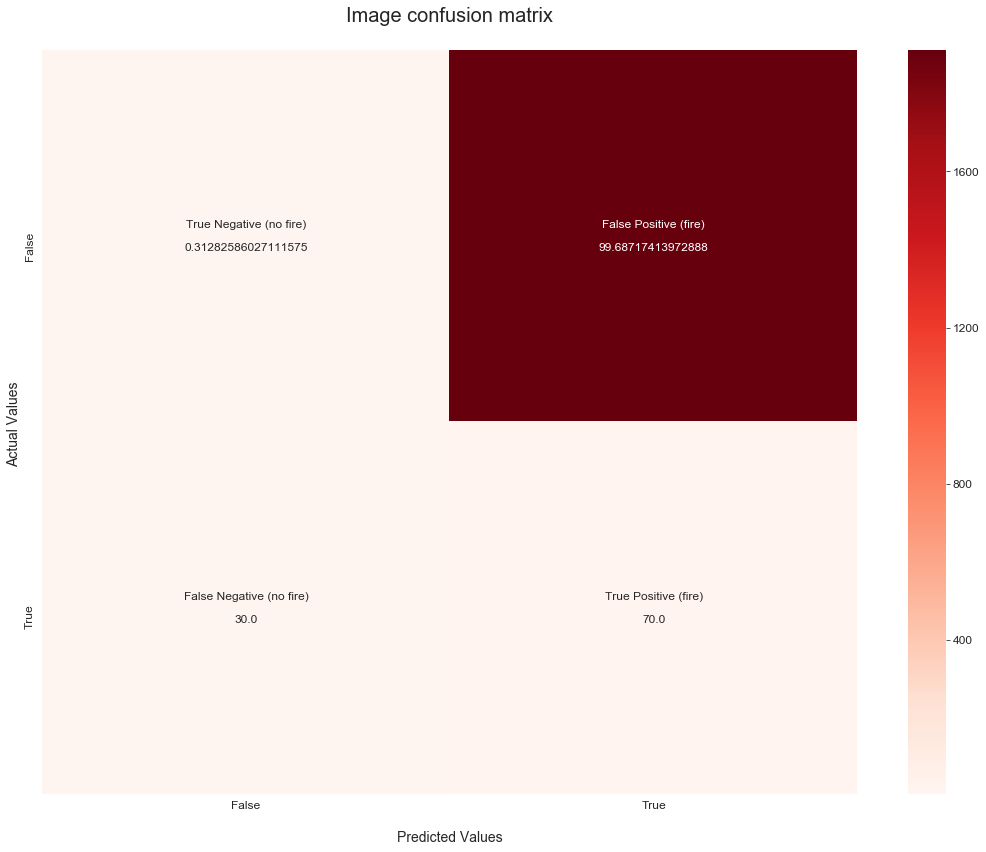

units dropouts optimizers    losses accuracies      aucs precisions  \
49    16      0.7    RMSprop  0.692484   0.496124  0.747236   0.496124   

   recalls                                          histories epochs  \
49       1  <keras.callbacks.History object at 0x000002B0B...      5   

   best thresholds  
49        0.468021

61/61 [==============================] - 6s 93ms/step
0.85
[([1], 0.9119046), ([1], 0.99204385), ([1], 0.9960965), ([1], 0.97368723), ([1], 0.99874556), ([1], 0.3729763), ([1], 0.99957246), ([1], 0.26536858), ([1], 0.4961399), ([1], 0.9996294)]
[([1], 0.85182756), ([1], 0.97000694), ([1], 0.995828), ([1], 0.9659116), ([1], 0.9992341), ([1], 0.6556703), ([1], 0.9993867), ([1], 0.49615926), ([1], 0.44154114), ([1], 0.9996749)]


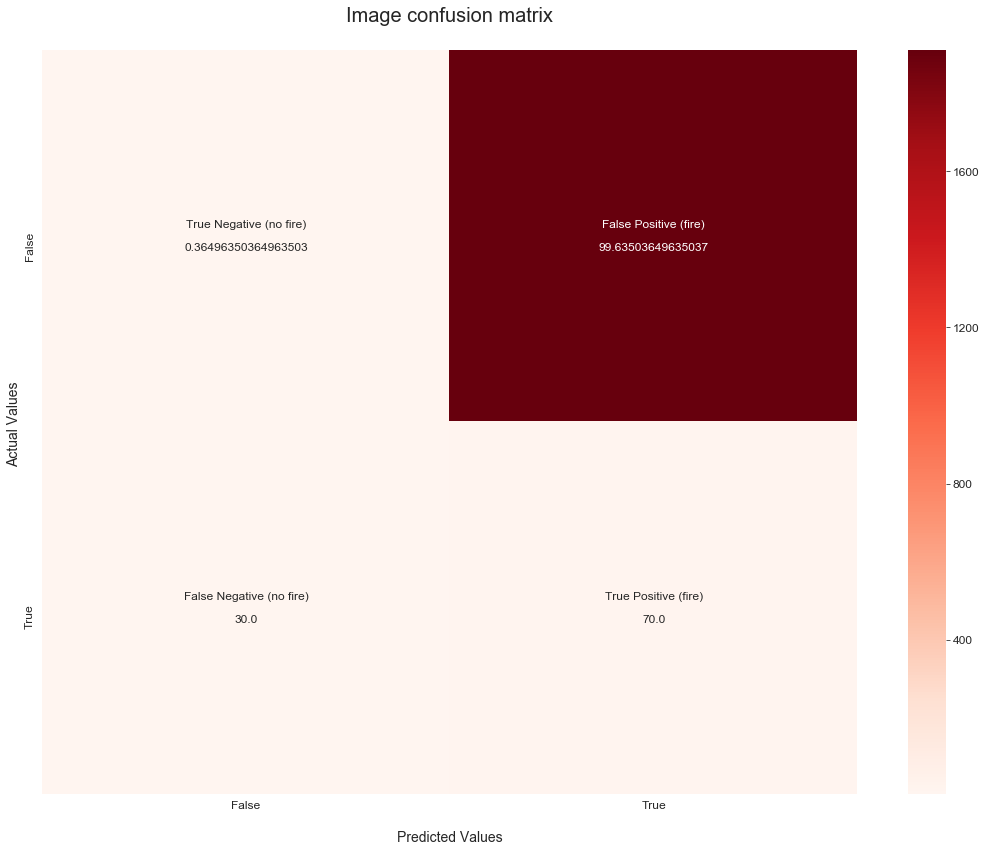

units dropouts optimizers    losses accuracies      aucs precisions  \
49    16      0.7    RMSprop  0.692484   0.496124  0.747236   0.496124   

   recalls                                          histories epochs  \
49       1  <keras.callbacks.History object at 0x000002B0B...      5   

   best thresholds  
49        0.468021

61/61 [==============================] - 6s 93ms/step
0.9
[([1], 0.9119046), ([1], 0.99204385), ([1], 0.9960965), ([1], 0.97368723), ([1], 0.99874556), ([1], 0.3729763), ([1], 0.99957246), ([1], 0.26536858), ([1], 0.4961399), ([1], 0.9996294)]
[([1], 0.85182756), ([1], 0.97000694), ([1], 0.995828), ([1], 0.9659116), ([1], 0.9992341), ([1], 0.6556703), ([1], 0.9993867), ([1], 0.49615926), ([1], 0.44154114), ([1], 0.9996749)]


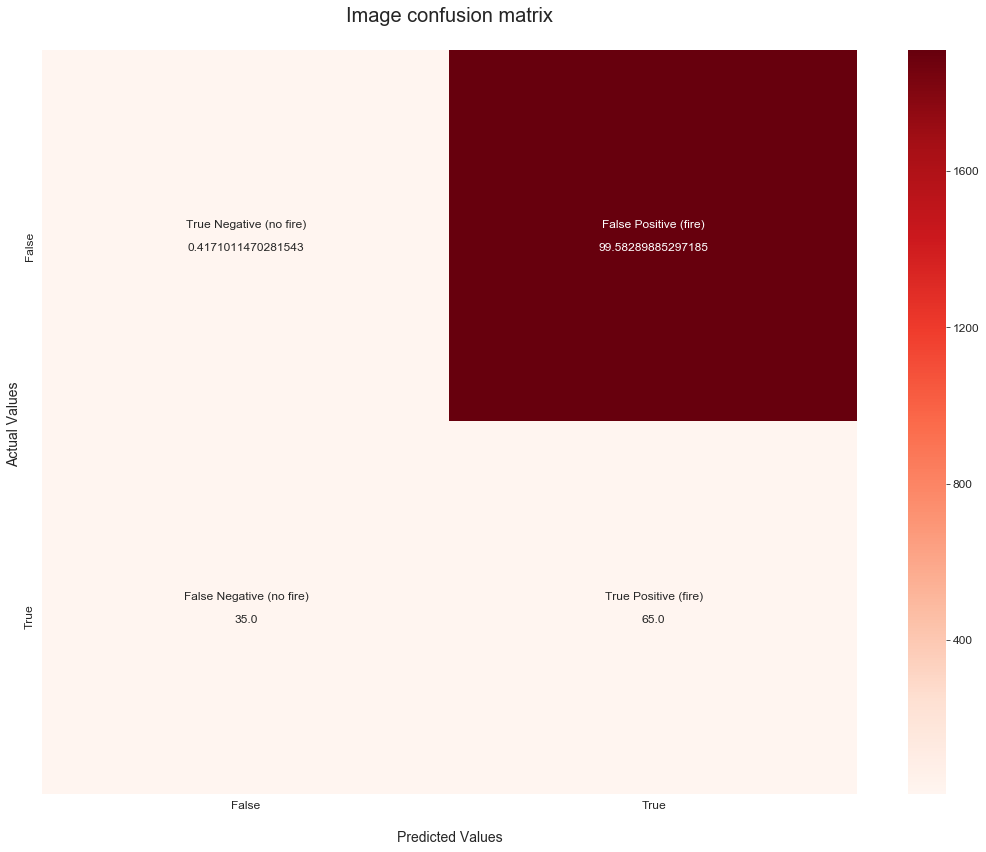

units dropouts optimizers    losses accuracies      aucs precisions  \
49    16      0.7    RMSprop  0.692484   0.496124  0.747236   0.496124   

   recalls                                          histories epochs  \
49       1  <keras.callbacks.History object at 0x000002B0B...      5   

   best thresholds  
49        0.468021

61/61 [==============================] - 6s 96ms/step
0.95
[([1], 0.9119046), ([1], 0.99204385), ([1], 0.9960965), ([1], 0.97368723), ([1], 0.99874556), ([1], 0.3729763), ([1], 0.99957246), ([1], 0.26536858), ([1], 0.4961399), ([1], 0.9996294)]
[([1], 0.85182756), ([1], 0.97000694), ([1], 0.995828), ([1], 0.9659116), ([1], 0.9992341), ([1], 0.6556703), ([1], 0.9993867), ([1], 0.49615926), ([1], 0.44154114), ([1], 0.9996749)]


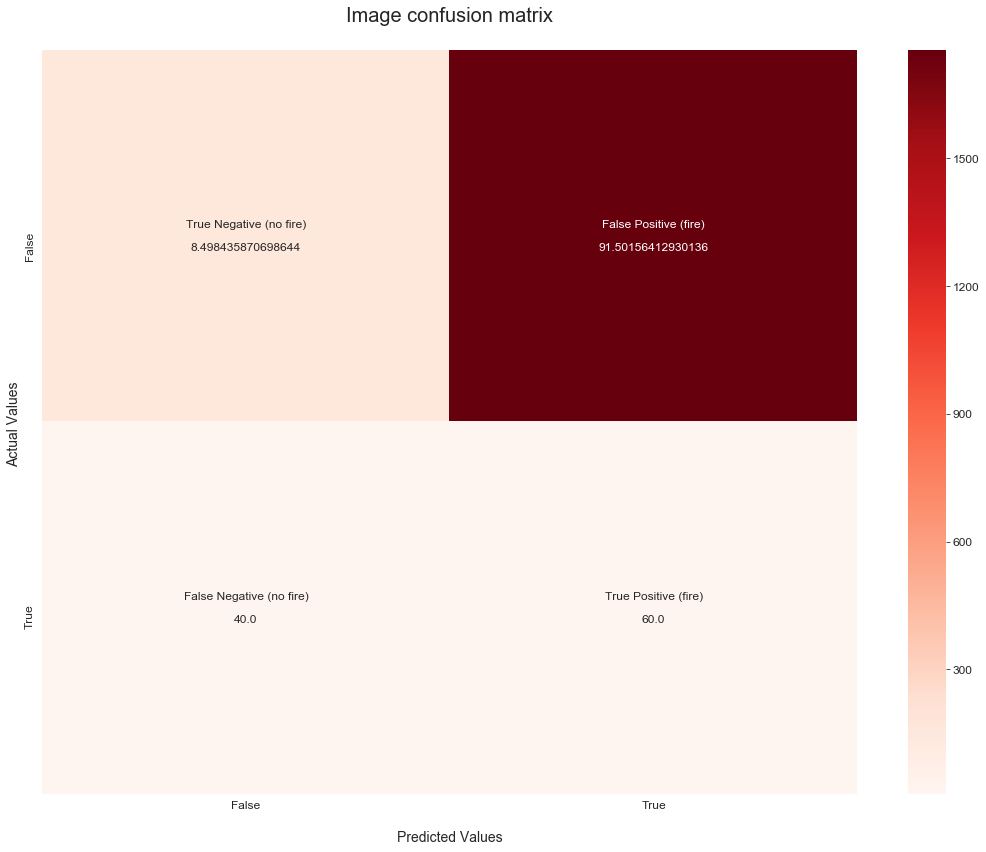

In [37]:
# #if you want to do predictions on model uncomment
counter = 30
TNrates = []
FPrates = []
FNrates = []
TPrates = []
Units = []
Dropouts = []
Optimizers = []
Epochs = []
positions = []
BestThresh = []
# for model in best_mods: #toggle to change lists
for model in modelLst[30:50]:
    for thresHold in [0.1, 0.3, 0.5, 0.65, 0.725, 0.8, 0.85, 0.9, 0.95]:
        # position = good[counter]

        # display(pd.DataFrame(modelDf.iloc[position]).T) #toggle
        modelDetails = pd.DataFrame(modelDfs[0].iloc[counter]).T
        display(modelDetails)
        if pd.isnull(modelDetails['best thresholds'].values[0]):
            
            train_predictions_baseline = model.predict(train_images)

            fp, tp, _ = sklearn.metrics.roc_curve(train_labels,train_predictions_baseline)
            from numpy import argmax
            J = tp- fp
            ix = argmax(J)
            best_thresh = _[ix]
            best_thresh = 1-best_thresh
            print('best thresh')
            print('-----------')
            print(best_thresh)
            print('-----------')
            BestThresh.append(best_thresh)
        
        else:
            thresh = modelDetails['best thresholds'].values[0]
            BestThresh.append(thresh)

        predictions = model.predict(hold_out_images, verbose = 1)

        scores = []
        for prediction in predictions:
            if prediction >= thresHold:
                scores.append(1)
            else:
                scores.append(0)
        
        print(thresHold)
            
        # predictions = [prediction[0] for prediction in predictions]
        predictions1 = [prediction[0] for prediction in predictions][:10]
        predictions2 = [prediction[0] for prediction in predictions][969:979]
        
        # print(list(zip(hold_out_labels,predictions)))
        print(list(zip(hold_out_labels[:10],predictions1)))
        print(list(zip(hold_out_labels[969:979],predictions2)))

        TNrate, FPrate, FNrate, TPrate = plot_confusion_matrix_2(confusion_matrix(y_true=hold_out_labels, y_pred=scores),normalize=True)
        TNrates.append(TNrate)
        FPrates.append(FPrate)
        FNrates.append(FNrate)
        TPrates.append(TPrate)
        Units.append(modelDetails['units'].values[0])
        Dropouts.append(modelDetails['dropouts'].values[0])
        Optimizers.append(modelDetails['optimizers'].values[0])
        Epochs.append(modelDetails['epochs'].values[0])

    counter+=1


# Iterating through good models in different batches

In [ ]:
################################################################
#iterating through subset of good models from different batches#
################################################################

# good = [7,8,10,16,19] #modelDfs[0]
# good = [10,14,16,19,22] #modelDfs[1]
# best_mods = []
# counter = 0
# for model in modelLst[2]:
#     if counter in good:
#         best_mods.append(model)
#     else:
#         pass
#     counter+=1

good = [136, 107, 69, 46, 37, 33, 22, 20, 19, 4]
thresholds = [.32, .45, .47, .56, .75, .37, .63, .42, .35, .71]
counter = 0
truthvalues = []
positions = []
best_thresholds = []
# for model in best_mods: #toggle to change lists
for model in modelz:

    if counter in good:

        position = good[counter]
        print(position)
        thresh = thresholds[position]
        print(thresh)

        # display(pd.DataFrame(modelDf.iloc[position]).T) #toggle
        display(pd.DataFrame(modelDf.iloc[position]).T)


        predictions = model.predict(hold_out_images, verbose = 1)

        scores = []
        for prediction in predictions:
            if prediction >= thresh:
                scores.append(1)
            else:
                scores.append(0)
            
        # predictions = [prediction[0] for prediction in predictions]
        predictions1 = [prediction[0] for prediction in predictions][:10]
        predictions2 = [prediction[0] for prediction in predictions][969:979]
        
        # print(list(zip(hold_out_labels,predictions)))
        print(list(zip(hold_out_labels[:10],predictions1)))
        print(list(zip(hold_out_labels[969:979],predictions2)))

        truthvalues.append(plot_confusion_matrix_2(confusion_matrix(y_true=hold_out_labels, y_pred=scores),normalize=True))
        positions.append(counter)

        counter+=1
    else:
        continue

print(list(zip(truthvalues,positions)))

In [50]:
model = modelLst[43]
modelDetails = pd.DataFrame(modelDfs[0].iloc[43]).T
modelHistory = modelDetails['histories'].values[0]
display(modelDetails)
display(modelHistory)

units dropouts optimizers    losses accuracies      aucs precisions  \
43    16      0.7    RMSprop  0.709256   0.496124  0.689423   0.496124   

   recalls                                          histories epochs  \
43       1  <keras.callbacks.History object at 0x000002B0B...      3   

   best thresholds  
43        0.412395

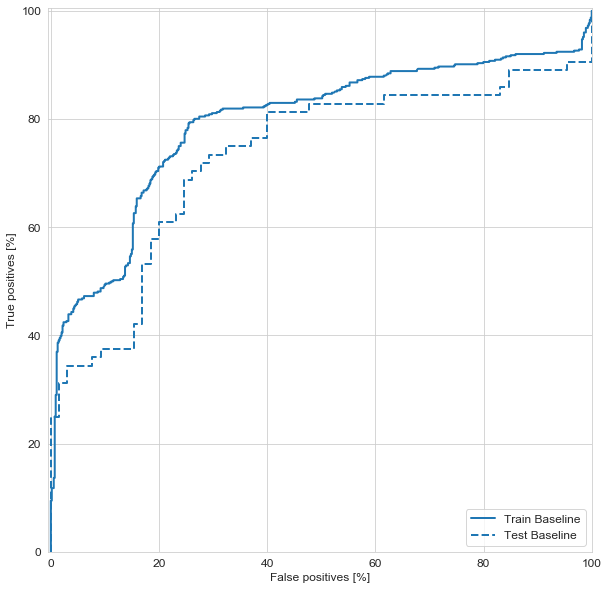

In [43]:
train_predictions_baseline = model.predict(train_images)
test_predictions_baseline = model.predict(test_images)

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [59]:
# line_chart(modelHistory)